# === Install Necessary Libraries ===

In [1]:
!pip install lightning timm torch-xla
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/828.5 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 12.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 53.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.6 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.6 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 15.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.1/326.1 kB 28.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/241.6 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 22.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 16.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--

     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.8 MB 9.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00


  Attempting uninstall: pip
    Found existing installation: pip 23.0.1


    Uninstalling pip-23.0.1:


      Successfully uninstalled pip-23.0.1


# === Imports ===

In [2]:
import os
import pandas as pd
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import lightning.pytorch as L
from lightning.pytorch import LightningModule, Trainer, LightningDataModule
import torch_xla.core.xla_model as xm
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


# === Verify TPU ===

In [3]:
try:
    device = xm.xla_device()
    print("✅ TPU device initialized:", device)
except Exception as e:
    print("🚫 Error initializing TPU:", e)
    device = torch.device("cpu")

E0000 00:00:1759428087.252392      74 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:239


✅ TPU device initialized: xla:0


# === Data Paths ===

In [4]:
train_df = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')
test_df  = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')
img_dir  = '/kaggle/input/ai-vs-human-generated-dataset/'

# --- Create Pair IDs and Split Train/Validation (Pair-Aware) ---
train_df['pair_id'] = train_df.index // 2
unique_pairs = train_df['pair_id'].unique()

In [5]:
train_df

Unnamed: 0                                        file_name  label  \
0               0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1   
1               1  train_data/041be3153810433ab146bc97d5af505c.jpg      0   
2               2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1   
3               3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0   
4               4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1   
...           ...                                              ...    ...   
79945       79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0   
79946       79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1   
79947       79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0   
79948       79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1   
79949       79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0   

       pair_id  
0            0  
1            0  
2            1  
3            1  
4            2  
...        ...  
79945    39972  
79946    39973  
79947    39973  
79948    39974  
79949    39974  

[79950 rows x 4 columns]

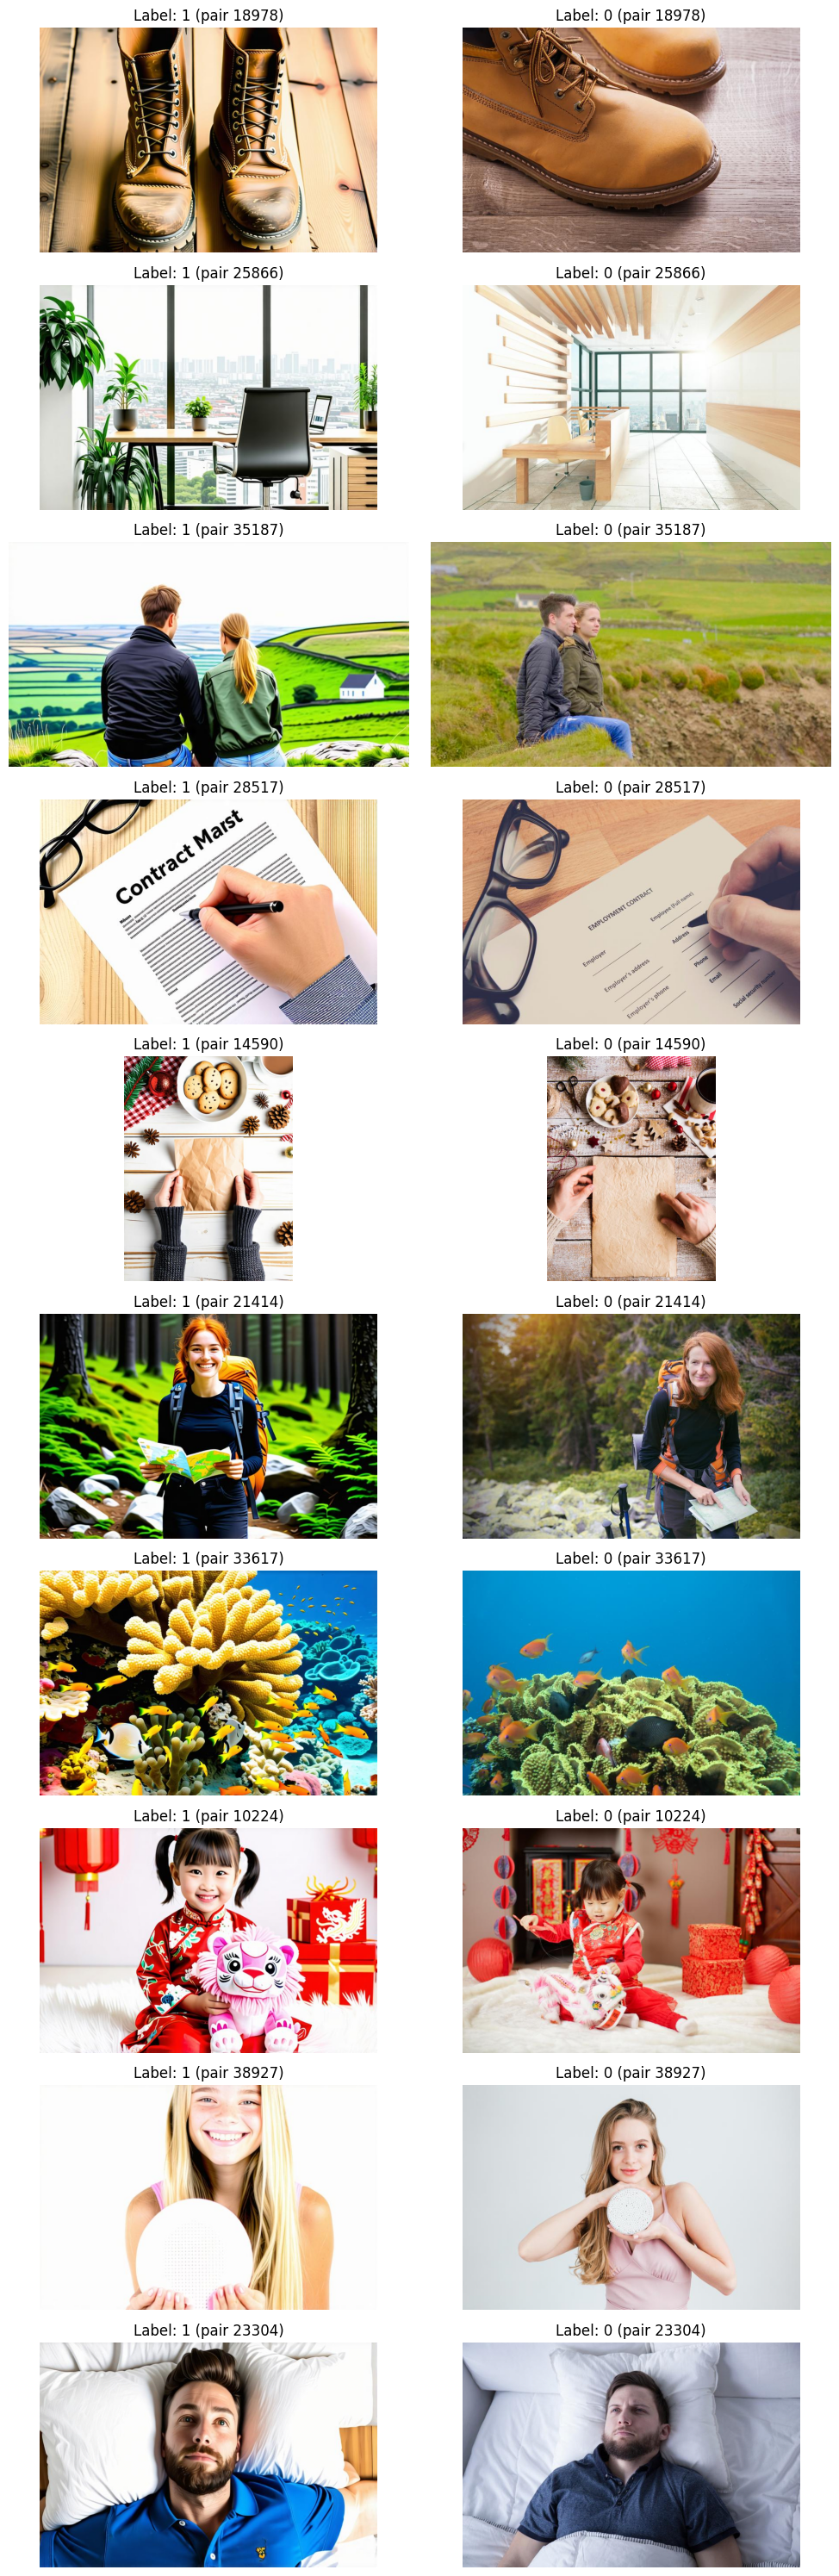

In [6]:
import matplotlib.pyplot as plt
import cv2

# Helper function to show example pairs
def show_pairs(df, img_dir, num_pairs=5):
    unique_pairs = df['pair_id'].unique()
    sample_pairs = np.random.choice(unique_pairs, num_pairs, replace=False)

    plt.figure(figsize=(10, num_pairs*3))

    for i, pid in enumerate(sample_pairs):
        pair_data = df[df['pair_id'] == pid]

        for j, row in enumerate(pair_data.itertuples()):
            img_path = f"{img_dir}/{row.file_name}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(num_pairs, 2, i*2 + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Label: {row.label} (pair {pid})")

    plt.tight_layout()
    plt.show()

# Show 5 random pairs
show_pairs(train_df, img_dir, num_pairs=10)

In [7]:
train_pairs, val_pairs = train_test_split(unique_pairs, test_size=0.2, random_state=42, shuffle=True)
train_df_split = train_df[train_df['pair_id'].isin(train_pairs)].reset_index(drop=True)
val_df_split   = train_df[train_df['pair_id'].isin(val_pairs)].reset_index(drop=True)
print("Training samples:", len(train_df_split), "Validation samples:", len(val_df_split))

Training samples: 63960 Validation samples: 15990


# === Data Transforms ===

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TTA transforms (a few variants)
tta_transforms = [
    val_transform,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
]

# === Custom Dataset Class ===

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['id'])
        else:
            img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx]['file_name'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image, self.dataframe.iloc[idx]['id']
        else:
            label = self.dataframe.iloc[idx]['label']
            return image, label

# === Lightning DataModule with Train/Val Split ===

In [10]:
class ImageDataModule(LightningDataModule):
    def __init__(self, train_df, val_df, test_df, img_dir, batch_size=64):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.img_dir = img_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = CustomDataset(self.train_df, self.img_dir, transform=train_transform)
            self.val_dataset   = CustomDataset(self.val_df, self.img_dir, transform=val_transform)
        if stage == 'test' or stage is None:
            self.test_dataset = CustomDataset(self.test_df, self.img_dir, transform=val_transform, is_test=True)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

# === SqueezeNet Model ===

In [11]:
class SqueezeNetClassifier(LightningModule):
    def __init__(self, num_classes=2, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = models.squeezenet1_1(pretrained=True)
        # Modify the classifier to match the number of classes
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        return optimizer

# === Initialize DataModule ===

In [12]:
datamodule = ImageDataModule(train_df_split, val_df_split, test_df, img_dir, batch_size=64)

# === Initialize Models ===

In [13]:
model_squeezenet   = SqueezeNetClassifier(num_classes=2)

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

100%|██████████| 4.73M/4.73M [00:00<00:00, 63.2MB/s]

# === Train Each Model Separately Using Its Own Trainer Instance ===

In [14]:
# Train SqueezeNet for 3 epochs
trainer_squeezenet = Trainer(
    max_epochs=3,
    accelerator='tpu',
    devices=1,
    precision="bf16-true",
    accumulate_grad_batches=4
)
trainer_squeeze = trainer_squeezenet.fit(model_squeezenet, datamodule=datamodule)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


INFO: GPU available: False, used: False


INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False


INFO: TPU available: True, using: 1 TPU cores


INFO:lightning.pytorch.utilities.rank_zero:TPU available: True, using: 1 TPU cores


INFO: HPU available: False, using: 0 HPUs


INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


E0000 00:00:1759428109.016567      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | SqueezeNet       | 723 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
723 K     Trainable params
0         Non-trainable params
723 K     Total params
1.447     Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | SqueezeNet       | 723 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
723 K     Trainable params
0         Non-trainable params
723 K     Total params
1.447     Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 32.60it/s]

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 41.36it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0:   0%|          | 1/1000 [00:01<21:43,  0.77it/s]

Epoch 0:   0%|          | 1/1000 [00:07<2:00:52,  0.14it/s, v_num=0, train_loss=1.250, train_acc=0.375]

Epoch 0:   0%|          | 2/1000 [00:07<1:00:39,  0.27it/s, v_num=0, train_loss=1.250, train_acc=0.375]

Epoch 0:   0%|          | 2/1000 [00:12<1:43:08,  0.16it/s, v_num=0, train_loss=1.090, train_acc=0.453]

Epoch 0:   0%|          | 3/1000 [00:12<1:08:52,  0.24it/s, v_num=0, train_loss=1.090, train_acc=0.453]

Epoch 0:   0%|          | 3/1000 [00:17<1:34:42,  0.18it/s, v_num=0, train_loss=1.060, train_acc=0.484]

Epoch 0:   0%|          | 4/1000 [00:37<2:36:38,  0.11it/s, v_num=0, train_loss=1.060, train_acc=0.484]

Epoch 0:   0%|          | 4/1000 [00:37<2:37:30,  0.11it/s, v_num=0, train_loss=1.010, train_acc=0.438]

Epoch 0:   0%|          | 5/1000 [00:37<2:05:56,  0.13it/s, v_num=0, train_loss=1.010, train_acc=0.438]

Epoch 0:   0%|          | 5/1000 [00:37<2:05:57,  0.13it/s, v_num=0, train_loss=1.030, train_acc=0.359]

Epoch 0:   1%|          | 6/1000 [00:38<1:44:55,  0.16it/s, v_num=0, train_loss=1.030, train_acc=0.359]

Epoch 0:   1%|          | 6/1000 [00:38<1:44:56,  0.16it/s, v_num=0, train_loss=0.801, train_acc=0.516]

Epoch 0:   1%|          | 7/1000 [00:38<1:29:55,  0.18it/s, v_num=0, train_loss=0.801, train_acc=0.516]

Epoch 0:   1%|          | 7/1000 [00:38<1:29:55,  0.18it/s, v_num=0, train_loss=0.906, train_acc=0.516]

Epoch 0:   1%|          | 8/1000 [00:56<1:56:08,  0.14it/s, v_num=0, train_loss=0.906, train_acc=0.516]

Epoch 0:   1%|          | 8/1000 [00:56<1:56:25,  0.14it/s, v_num=0, train_loss=0.781, train_acc=0.562]

Epoch 0:   1%|          | 9/1000 [00:56<1:43:26,  0.16it/s, v_num=0, train_loss=0.781, train_acc=0.562]

Epoch 0:   1%|          | 9/1000 [00:56<1:43:27,  0.16it/s, v_num=0, train_loss=0.812, train_acc=0.453]

Epoch 0:   1%|          | 10/1000 [00:56<1:33:03,  0.18it/s, v_num=0, train_loss=0.812, train_acc=0.453]

Epoch 0:   1%|          | 10/1000 [00:56<1:33:04,  0.18it/s, v_num=0, train_loss=0.836, train_acc=0.453]

Epoch 0:   1%|          | 11/1000 [00:56<1:24:34,  0.19it/s, v_num=0, train_loss=0.836, train_acc=0.453]

Epoch 0:   1%|          | 11/1000 [00:56<1:24:34,  0.19it/s, v_num=0, train_loss=0.836, train_acc=0.469]

Epoch 0:   1%|          | 12/1000 [00:56<1:17:38,  0.21it/s, v_num=0, train_loss=0.836, train_acc=0.469]

Epoch 0:   1%|          | 12/1000 [00:56<1:17:41,  0.21it/s, v_num=0, train_loss=0.789, train_acc=0.453]

Epoch 0:   1%|▏         | 13/1000 [00:56<1:11:39,  0.23it/s, v_num=0, train_loss=0.789, train_acc=0.453]

Epoch 0:   1%|▏         | 13/1000 [00:56<1:11:40,  0.23it/s, v_num=0, train_loss=0.820, train_acc=0.438]

Epoch 0:   1%|▏         | 14/1000 [00:56<1:06:30,  0.25it/s, v_num=0, train_loss=0.820, train_acc=0.438]

Epoch 0:   1%|▏         | 14/1000 [00:56<1:06:31,  0.25it/s, v_num=0, train_loss=0.727, train_acc=0.484]

Epoch 0:   2%|▏         | 15/1000 [00:56<1:02:02,  0.26it/s, v_num=0, train_loss=0.727, train_acc=0.484]

Epoch 0:   2%|▏         | 15/1000 [00:56<1:02:03,  0.26it/s, v_num=0, train_loss=0.875, train_acc=0.375]

Epoch 0:   2%|▏         | 16/1000 [00:56<58:15,  0.28it/s, v_num=0, train_loss=0.875, train_acc=0.375]  

Epoch 0:   2%|▏         | 16/1000 [00:56<58:17,  0.28it/s, v_num=0, train_loss=0.895, train_acc=0.359]

Epoch 0:   2%|▏         | 17/1000 [00:57<55:31,  0.30it/s, v_num=0, train_loss=0.895, train_acc=0.359]

Epoch 0:   2%|▏         | 17/1000 [00:57<55:32,  0.30it/s, v_num=0, train_loss=0.734, train_acc=0.594]

Epoch 0:   2%|▏         | 18/1000 [00:57<52:25,  0.31it/s, v_num=0, train_loss=0.734, train_acc=0.594]

Epoch 0:   2%|▏         | 18/1000 [00:57<52:25,  0.31it/s, v_num=0, train_loss=0.785, train_acc=0.469]

Epoch 0:   2%|▏         | 19/1000 [00:57<49:39,  0.33it/s, v_num=0, train_loss=0.785, train_acc=0.469]

Epoch 0:   2%|▏         | 19/1000 [00:57<49:39,  0.33it/s, v_num=0, train_loss=0.848, train_acc=0.500]

Epoch 0:   2%|▏         | 20/1000 [00:57<47:14,  0.35it/s, v_num=0, train_loss=0.848, train_acc=0.500]

Epoch 0:   2%|▏         | 20/1000 [00:57<47:16,  0.35it/s, v_num=0, train_loss=0.652, train_acc=0.625]

Epoch 0:   2%|▏         | 21/1000 [00:58<45:42,  0.36it/s, v_num=0, train_loss=0.652, train_acc=0.625]

Epoch 0:   2%|▏         | 21/1000 [00:58<45:43,  0.36it/s, v_num=0, train_loss=0.680, train_acc=0.594]

Epoch 0:   2%|▏         | 22/1000 [00:58<43:38,  0.37it/s, v_num=0, train_loss=0.680, train_acc=0.594]

Epoch 0:   2%|▏         | 22/1000 [00:58<43:39,  0.37it/s, v_num=0, train_loss=0.770, train_acc=0.391]

Epoch 0:   2%|▏         | 23/1000 [00:58<41:46,  0.39it/s, v_num=0, train_loss=0.770, train_acc=0.391]

Epoch 0:   2%|▏         | 23/1000 [00:59<41:46,  0.39it/s, v_num=0, train_loss=0.758, train_acc=0.516]

Epoch 0:   2%|▏         | 24/1000 [00:59<40:05,  0.41it/s, v_num=0, train_loss=0.758, train_acc=0.516]

Epoch 0:   2%|▏         | 24/1000 [00:59<40:06,  0.41it/s, v_num=0, train_loss=0.785, train_acc=0.469]

Epoch 0:   2%|▎         | 25/1000 [01:00<39:02,  0.42it/s, v_num=0, train_loss=0.785, train_acc=0.469]

Epoch 0:   2%|▎         | 25/1000 [01:00<39:02,  0.42it/s, v_num=0, train_loss=0.695, train_acc=0.562]

Epoch 0:   3%|▎         | 26/1000 [01:00<37:32,  0.43it/s, v_num=0, train_loss=0.695, train_acc=0.562]

Epoch 0:   3%|▎         | 26/1000 [01:00<37:32,  0.43it/s, v_num=0, train_loss=0.727, train_acc=0.484]

Epoch 0:   3%|▎         | 27/1000 [01:00<36:09,  0.45it/s, v_num=0, train_loss=0.727, train_acc=0.484]

Epoch 0:   3%|▎         | 27/1000 [01:00<36:09,  0.45it/s, v_num=0, train_loss=0.691, train_acc=0.562]

Epoch 0:   3%|▎         | 28/1000 [01:00<34:54,  0.46it/s, v_num=0, train_loss=0.691, train_acc=0.562]

Epoch 0:   3%|▎         | 28/1000 [01:00<34:55,  0.46it/s, v_num=0, train_loss=0.723, train_acc=0.547]

Epoch 0:   3%|▎         | 29/1000 [01:01<34:11,  0.47it/s, v_num=0, train_loss=0.723, train_acc=0.547]

Epoch 0:   3%|▎         | 29/1000 [01:01<34:11,  0.47it/s, v_num=0, train_loss=0.688, train_acc=0.547]

Epoch 0:   3%|▎         | 30/1000 [01:01<33:04,  0.49it/s, v_num=0, train_loss=0.688, train_acc=0.547]

Epoch 0:   3%|▎         | 30/1000 [01:01<33:04,  0.49it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:   3%|▎         | 31/1000 [01:01<32:01,  0.50it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:   3%|▎         | 31/1000 [01:01<32:01,  0.50it/s, v_num=0, train_loss=0.734, train_acc=0.500]

Epoch 0:   3%|▎         | 32/1000 [01:01<31:04,  0.52it/s, v_num=0, train_loss=0.734, train_acc=0.500]

Epoch 0:   3%|▎         | 32/1000 [01:01<31:05,  0.52it/s, v_num=0, train_loss=0.719, train_acc=0.484]

Epoch 0:   3%|▎         | 33/1000 [01:02<30:30,  0.53it/s, v_num=0, train_loss=0.719, train_acc=0.484]

Epoch 0:   3%|▎         | 33/1000 [01:02<30:30,  0.53it/s, v_num=0, train_loss=0.641, train_acc=0.594]

Epoch 0:   3%|▎         | 34/1000 [01:02<29:38,  0.54it/s, v_num=0, train_loss=0.641, train_acc=0.594]

Epoch 0:   3%|▎         | 34/1000 [01:02<29:38,  0.54it/s, v_num=0, train_loss=0.699, train_acc=0.531]

Epoch 0:   4%|▎         | 35/1000 [01:02<28:48,  0.56it/s, v_num=0, train_loss=0.699, train_acc=0.531]

Epoch 0:   4%|▎         | 35/1000 [01:02<28:48,  0.56it/s, v_num=0, train_loss=0.625, train_acc=0.625]

Epoch 0:   4%|▎         | 36/1000 [01:02<28:02,  0.57it/s, v_num=0, train_loss=0.625, train_acc=0.625]

Epoch 0:   4%|▎         | 36/1000 [01:02<28:03,  0.57it/s, v_num=0, train_loss=0.703, train_acc=0.578]

Epoch 0:   4%|▎         | 37/1000 [01:03<27:37,  0.58it/s, v_num=0, train_loss=0.703, train_acc=0.578]

Epoch 0:   4%|▎         | 37/1000 [01:03<27:37,  0.58it/s, v_num=0, train_loss=0.676, train_acc=0.609]

Epoch 0:   4%|▍         | 38/1000 [01:03<26:56,  0.60it/s, v_num=0, train_loss=0.676, train_acc=0.609]

Epoch 0:   4%|▍         | 38/1000 [01:03<26:56,  0.60it/s, v_num=0, train_loss=0.617, train_acc=0.672]

Epoch 0:   4%|▍         | 39/1000 [01:03<26:15,  0.61it/s, v_num=0, train_loss=0.617, train_acc=0.672]

Epoch 0:   4%|▍         | 39/1000 [01:03<26:15,  0.61it/s, v_num=0, train_loss=0.691, train_acc=0.594]

Epoch 0:   4%|▍         | 40/1000 [01:04<25:38,  0.62it/s, v_num=0, train_loss=0.691, train_acc=0.594]

Epoch 0:   4%|▍         | 40/1000 [01:04<25:38,  0.62it/s, v_num=0, train_loss=0.645, train_acc=0.656]

Epoch 0:   4%|▍         | 41/1000 [01:04<25:17,  0.63it/s, v_num=0, train_loss=0.645, train_acc=0.656]

Epoch 0:   4%|▍         | 41/1000 [01:04<25:17,  0.63it/s, v_num=0, train_loss=0.660, train_acc=0.594]

Epoch 0:   4%|▍         | 42/1000 [01:05<24:43,  0.65it/s, v_num=0, train_loss=0.660, train_acc=0.594]

Epoch 0:   4%|▍         | 42/1000 [01:05<24:43,  0.65it/s, v_num=0, train_loss=0.652, train_acc=0.578]

Epoch 0:   4%|▍         | 43/1000 [01:05<24:09,  0.66it/s, v_num=0, train_loss=0.652, train_acc=0.578]

Epoch 0:   4%|▍         | 43/1000 [01:05<24:09,  0.66it/s, v_num=0, train_loss=0.613, train_acc=0.656]

Epoch 0:   4%|▍         | 44/1000 [01:05<23:38,  0.67it/s, v_num=0, train_loss=0.613, train_acc=0.656]

Epoch 0:   4%|▍         | 44/1000 [01:05<23:39,  0.67it/s, v_num=0, train_loss=0.688, train_acc=0.609]

Epoch 0:   4%|▍         | 45/1000 [01:06<23:23,  0.68it/s, v_num=0, train_loss=0.688, train_acc=0.609]

Epoch 0:   4%|▍         | 45/1000 [01:06<23:23,  0.68it/s, v_num=0, train_loss=0.688, train_acc=0.578]

Epoch 0:   5%|▍         | 46/1000 [01:06<22:53,  0.69it/s, v_num=0, train_loss=0.688, train_acc=0.578]

Epoch 0:   5%|▍         | 46/1000 [01:06<22:53,  0.69it/s, v_num=0, train_loss=0.613, train_acc=0.594]

Epoch 0:   5%|▍         | 47/1000 [01:06<22:25,  0.71it/s, v_num=0, train_loss=0.613, train_acc=0.594]

Epoch 0:   5%|▍         | 47/1000 [01:06<22:26,  0.71it/s, v_num=0, train_loss=0.672, train_acc=0.547]

Epoch 0:   5%|▍         | 48/1000 [01:06<21:59,  0.72it/s, v_num=0, train_loss=0.672, train_acc=0.547]

Epoch 0:   5%|▍         | 48/1000 [01:06<21:59,  0.72it/s, v_num=0, train_loss=0.668, train_acc=0.562]

Epoch 0:   5%|▍         | 49/1000 [01:07<21:47,  0.73it/s, v_num=0, train_loss=0.668, train_acc=0.562]

Epoch 0:   5%|▍         | 49/1000 [01:07<21:47,  0.73it/s, v_num=0, train_loss=0.652, train_acc=0.625]

Epoch 0:   5%|▌         | 50/1000 [01:07<21:21,  0.74it/s, v_num=0, train_loss=0.652, train_acc=0.625]

Epoch 0:   5%|▌         | 50/1000 [01:07<21:21,  0.74it/s, v_num=0, train_loss=0.605, train_acc=0.672]

Epoch 0:   5%|▌         | 51/1000 [01:07<20:57,  0.75it/s, v_num=0, train_loss=0.605, train_acc=0.672]

Epoch 0:   5%|▌         | 51/1000 [01:07<20:57,  0.75it/s, v_num=0, train_loss=0.641, train_acc=0.609]

Epoch 0:   5%|▌         | 52/1000 [01:07<20:34,  0.77it/s, v_num=0, train_loss=0.641, train_acc=0.609]

Epoch 0:   5%|▌         | 52/1000 [01:07<20:35,  0.77it/s, v_num=0, train_loss=0.602, train_acc=0.719]

Epoch 0:   5%|▌         | 53/1000 [01:08<20:24,  0.77it/s, v_num=0, train_loss=0.602, train_acc=0.719]

Epoch 0:   5%|▌         | 53/1000 [01:08<20:24,  0.77it/s, v_num=0, train_loss=0.652, train_acc=0.578]

Epoch 0:   5%|▌         | 54/1000 [01:08<20:02,  0.79it/s, v_num=0, train_loss=0.652, train_acc=0.578]

Epoch 0:   5%|▌         | 54/1000 [01:08<20:02,  0.79it/s, v_num=0, train_loss=0.633, train_acc=0.625]

Epoch 0:   6%|▌         | 55/1000 [01:08<19:41,  0.80it/s, v_num=0, train_loss=0.633, train_acc=0.625]

Epoch 0:   6%|▌         | 55/1000 [01:08<19:41,  0.80it/s, v_num=0, train_loss=0.672, train_acc=0.578]

Epoch 0:   6%|▌         | 56/1000 [01:08<19:22,  0.81it/s, v_num=0, train_loss=0.672, train_acc=0.578]

Epoch 0:   6%|▌         | 56/1000 [01:08<19:22,  0.81it/s, v_num=0, train_loss=0.621, train_acc=0.656]

Epoch 0:   6%|▌         | 57/1000 [01:09<19:13,  0.82it/s, v_num=0, train_loss=0.621, train_acc=0.656]

Epoch 0:   6%|▌         | 57/1000 [01:09<19:13,  0.82it/s, v_num=0, train_loss=0.660, train_acc=0.562]

Epoch 0:   6%|▌         | 58/1000 [01:09<18:54,  0.83it/s, v_num=0, train_loss=0.660, train_acc=0.562]

Epoch 0:   6%|▌         | 58/1000 [01:09<18:54,  0.83it/s, v_num=0, train_loss=0.602, train_acc=0.672]

Epoch 0:   6%|▌         | 59/1000 [01:09<18:36,  0.84it/s, v_num=0, train_loss=0.602, train_acc=0.672]

Epoch 0:   6%|▌         | 59/1000 [01:10<18:36,  0.84it/s, v_num=0, train_loss=0.594, train_acc=0.766]

Epoch 0:   6%|▌         | 60/1000 [01:10<18:19,  0.85it/s, v_num=0, train_loss=0.594, train_acc=0.766]

Epoch 0:   6%|▌         | 60/1000 [01:10<18:20,  0.85it/s, v_num=0, train_loss=0.676, train_acc=0.578]

Epoch 0:   6%|▌         | 61/1000 [01:10<18:12,  0.86it/s, v_num=0, train_loss=0.676, train_acc=0.578]

Epoch 0:   6%|▌         | 61/1000 [01:10<18:12,  0.86it/s, v_num=0, train_loss=0.660, train_acc=0.625]

Epoch 0:   6%|▌         | 62/1000 [01:11<17:55,  0.87it/s, v_num=0, train_loss=0.660, train_acc=0.625]

Epoch 0:   6%|▌         | 62/1000 [01:11<17:55,  0.87it/s, v_num=0, train_loss=0.660, train_acc=0.609]

Epoch 0:   6%|▋         | 63/1000 [01:11<17:39,  0.88it/s, v_num=0, train_loss=0.660, train_acc=0.609]

Epoch 0:   6%|▋         | 63/1000 [01:11<17:39,  0.88it/s, v_num=0, train_loss=0.645, train_acc=0.609]

Epoch 0:   6%|▋         | 64/1000 [01:11<17:24,  0.90it/s, v_num=0, train_loss=0.645, train_acc=0.609]

Epoch 0:   6%|▋         | 64/1000 [01:11<17:24,  0.90it/s, v_num=0, train_loss=0.590, train_acc=0.734]

Epoch 0:   6%|▋         | 65/1000 [01:12<17:17,  0.90it/s, v_num=0, train_loss=0.590, train_acc=0.734]

Epoch 0:   6%|▋         | 65/1000 [01:12<17:17,  0.90it/s, v_num=0, train_loss=0.605, train_acc=0.719]

Epoch 0:   7%|▋         | 66/1000 [01:12<17:02,  0.91it/s, v_num=0, train_loss=0.605, train_acc=0.719]

Epoch 0:   7%|▋         | 66/1000 [01:12<17:02,  0.91it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:   7%|▋         | 67/1000 [01:12<16:48,  0.93it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:   7%|▋         | 67/1000 [01:12<16:48,  0.93it/s, v_num=0, train_loss=0.645, train_acc=0.641]

Epoch 0:   7%|▋         | 68/1000 [01:12<16:34,  0.94it/s, v_num=0, train_loss=0.645, train_acc=0.641]

Epoch 0:   7%|▋         | 68/1000 [01:12<16:34,  0.94it/s, v_num=0, train_loss=0.711, train_acc=0.641]

Epoch 0:   7%|▋         | 69/1000 [01:13<16:29,  0.94it/s, v_num=0, train_loss=0.711, train_acc=0.641]

Epoch 0:   7%|▋         | 69/1000 [01:13<16:29,  0.94it/s, v_num=0, train_loss=0.637, train_acc=0.703]

Epoch 0:   7%|▋         | 70/1000 [01:13<16:15,  0.95it/s, v_num=0, train_loss=0.637, train_acc=0.703]

Epoch 0:   7%|▋         | 70/1000 [01:13<16:15,  0.95it/s, v_num=0, train_loss=0.633, train_acc=0.656]

Epoch 0:   7%|▋         | 71/1000 [01:13<16:03,  0.96it/s, v_num=0, train_loss=0.633, train_acc=0.656]

Epoch 0:   7%|▋         | 71/1000 [01:13<16:03,  0.96it/s, v_num=0, train_loss=0.617, train_acc=0.703]

Epoch 0:   7%|▋         | 72/1000 [01:13<15:50,  0.98it/s, v_num=0, train_loss=0.617, train_acc=0.703]

Epoch 0:   7%|▋         | 72/1000 [01:13<15:51,  0.98it/s, v_num=0, train_loss=0.629, train_acc=0.641]

Epoch 0:   7%|▋         | 73/1000 [01:14<15:46,  0.98it/s, v_num=0, train_loss=0.629, train_acc=0.641]

Epoch 0:   7%|▋         | 73/1000 [01:14<15:46,  0.98it/s, v_num=0, train_loss=0.641, train_acc=0.625]

Epoch 0:   7%|▋         | 74/1000 [01:14<15:33,  0.99it/s, v_num=0, train_loss=0.641, train_acc=0.625]

Epoch 0:   7%|▋         | 74/1000 [01:14<15:33,  0.99it/s, v_num=0, train_loss=0.586, train_acc=0.734]

Epoch 0:   8%|▊         | 75/1000 [01:14<15:22,  1.00it/s, v_num=0, train_loss=0.586, train_acc=0.734]

Epoch 0:   8%|▊         | 75/1000 [01:14<15:22,  1.00it/s, v_num=0, train_loss=0.641, train_acc=0.609]

Epoch 0:   8%|▊         | 76/1000 [01:14<15:11,  1.01it/s, v_num=0, train_loss=0.641, train_acc=0.609]

Epoch 0:   8%|▊         | 76/1000 [01:14<15:11,  1.01it/s, v_num=0, train_loss=0.633, train_acc=0.688]

Epoch 0:   8%|▊         | 77/1000 [01:15<15:06,  1.02it/s, v_num=0, train_loss=0.633, train_acc=0.688]

Epoch 0:   8%|▊         | 77/1000 [01:15<15:06,  1.02it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:   8%|▊         | 78/1000 [01:15<14:55,  1.03it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:   8%|▊         | 78/1000 [01:15<14:55,  1.03it/s, v_num=0, train_loss=0.625, train_acc=0.719]

Epoch 0:   8%|▊         | 79/1000 [01:15<14:45,  1.04it/s, v_num=0, train_loss=0.625, train_acc=0.719]

Epoch 0:   8%|▊         | 79/1000 [01:16<14:46,  1.04it/s, v_num=0, train_loss=0.637, train_acc=0.625]

Epoch 0:   8%|▊         | 80/1000 [01:16<14:35,  1.05it/s, v_num=0, train_loss=0.637, train_acc=0.625]

Epoch 0:   8%|▊         | 80/1000 [01:16<14:36,  1.05it/s, v_num=0, train_loss=0.590, train_acc=0.766]

Epoch 0:   8%|▊         | 81/1000 [01:16<14:31,  1.05it/s, v_num=0, train_loss=0.590, train_acc=0.766]

Epoch 0:   8%|▊         | 81/1000 [01:16<14:31,  1.05it/s, v_num=0, train_loss=0.613, train_acc=0.672]

Epoch 0:   8%|▊         | 82/1000 [01:16<14:21,  1.07it/s, v_num=0, train_loss=0.613, train_acc=0.672]

Epoch 0:   8%|▊         | 82/1000 [01:16<14:21,  1.07it/s, v_num=0, train_loss=0.613, train_acc=0.688]

Epoch 0:   8%|▊         | 83/1000 [01:17<14:12,  1.08it/s, v_num=0, train_loss=0.613, train_acc=0.688]

Epoch 0:   8%|▊         | 83/1000 [01:17<14:13,  1.07it/s, v_num=0, train_loss=0.637, train_acc=0.672]

Epoch 0:   8%|▊         | 84/1000 [01:17<14:03,  1.09it/s, v_num=0, train_loss=0.637, train_acc=0.672]

Epoch 0:   8%|▊         | 84/1000 [01:17<14:03,  1.09it/s, v_num=0, train_loss=0.602, train_acc=0.703]

Epoch 0:   8%|▊         | 85/1000 [01:17<13:59,  1.09it/s, v_num=0, train_loss=0.602, train_acc=0.703]

Epoch 0:   8%|▊         | 85/1000 [01:17<13:59,  1.09it/s, v_num=0, train_loss=0.613, train_acc=0.688]

Epoch 0:   9%|▊         | 86/1000 [01:18<13:50,  1.10it/s, v_num=0, train_loss=0.613, train_acc=0.688]

Epoch 0:   9%|▊         | 86/1000 [01:18<13:50,  1.10it/s, v_num=0, train_loss=0.586, train_acc=0.703]

Epoch 0:   9%|▊         | 87/1000 [01:18<13:43,  1.11it/s, v_num=0, train_loss=0.586, train_acc=0.703]

Epoch 0:   9%|▊         | 87/1000 [01:18<13:43,  1.11it/s, v_num=0, train_loss=0.582, train_acc=0.750]

Epoch 0:   9%|▉         | 88/1000 [01:18<13:34,  1.12it/s, v_num=0, train_loss=0.582, train_acc=0.750]

Epoch 0:   9%|▉         | 88/1000 [01:18<13:34,  1.12it/s, v_num=0, train_loss=0.609, train_acc=0.641]

Epoch 0:   9%|▉         | 89/1000 [01:19<13:30,  1.12it/s, v_num=0, train_loss=0.609, train_acc=0.641]

Epoch 0:   9%|▉         | 89/1000 [01:19<13:30,  1.12it/s, v_num=0, train_loss=0.605, train_acc=0.719]

Epoch 0:   9%|▉         | 90/1000 [01:19<13:22,  1.13it/s, v_num=0, train_loss=0.605, train_acc=0.719]

Epoch 0:   9%|▉         | 90/1000 [01:19<13:22,  1.13it/s, v_num=0, train_loss=0.562, train_acc=0.781]

Epoch 0:   9%|▉         | 91/1000 [01:19<13:15,  1.14it/s, v_num=0, train_loss=0.562, train_acc=0.781]

Epoch 0:   9%|▉         | 91/1000 [01:19<13:15,  1.14it/s, v_num=0, train_loss=0.574, train_acc=0.781]

Epoch 0:   9%|▉         | 92/1000 [01:19<13:07,  1.15it/s, v_num=0, train_loss=0.574, train_acc=0.781]

Epoch 0:   9%|▉         | 92/1000 [01:19<13:07,  1.15it/s, v_num=0, train_loss=0.605, train_acc=0.656]

Epoch 0:   9%|▉         | 93/1000 [01:20<13:04,  1.16it/s, v_num=0, train_loss=0.605, train_acc=0.656]

Epoch 0:   9%|▉         | 93/1000 [01:20<13:04,  1.16it/s, v_num=0, train_loss=0.645, train_acc=0.688]

Epoch 0:   9%|▉         | 94/1000 [01:20<12:56,  1.17it/s, v_num=0, train_loss=0.645, train_acc=0.688]

Epoch 0:   9%|▉         | 94/1000 [01:20<12:56,  1.17it/s, v_num=0, train_loss=0.562, train_acc=0.719]

Epoch 0:  10%|▉         | 95/1000 [01:20<12:50,  1.17it/s, v_num=0, train_loss=0.562, train_acc=0.719]

Epoch 0:  10%|▉         | 95/1000 [01:20<12:50,  1.17it/s, v_num=0, train_loss=0.637, train_acc=0.641]

Epoch 0:  10%|▉         | 96/1000 [01:21<12:42,  1.19it/s, v_num=0, train_loss=0.637, train_acc=0.641]

Epoch 0:  10%|▉         | 96/1000 [01:21<12:43,  1.18it/s, v_num=0, train_loss=0.578, train_acc=0.734]

Epoch 0:  10%|▉         | 97/1000 [01:21<12:40,  1.19it/s, v_num=0, train_loss=0.578, train_acc=0.734]

Epoch 0:  10%|▉         | 97/1000 [01:21<12:40,  1.19it/s, v_num=0, train_loss=0.578, train_acc=0.719]

Epoch 0:  10%|▉         | 98/1000 [01:21<12:32,  1.20it/s, v_num=0, train_loss=0.578, train_acc=0.719]

Epoch 0:  10%|▉         | 98/1000 [01:21<12:32,  1.20it/s, v_num=0, train_loss=0.605, train_acc=0.688]

Epoch 0:  10%|▉         | 99/1000 [01:22<12:27,  1.21it/s, v_num=0, train_loss=0.605, train_acc=0.688]

Epoch 0:  10%|▉         | 99/1000 [01:22<12:27,  1.21it/s, v_num=0, train_loss=0.625, train_acc=0.703]

Epoch 0:  10%|█         | 100/1000 [01:22<12:20,  1.22it/s, v_num=0, train_loss=0.625, train_acc=0.703]

Epoch 0:  10%|█         | 100/1000 [01:22<12:20,  1.22it/s, v_num=0, train_loss=0.598, train_acc=0.734]

Epoch 0:  10%|█         | 101/1000 [01:22<12:17,  1.22it/s, v_num=0, train_loss=0.598, train_acc=0.734]

Epoch 0:  10%|█         | 101/1000 [01:22<12:17,  1.22it/s, v_num=0, train_loss=0.574, train_acc=0.719]

Epoch 0:  10%|█         | 102/1000 [01:22<12:10,  1.23it/s, v_num=0, train_loss=0.574, train_acc=0.719]

Epoch 0:  10%|█         | 102/1000 [01:22<12:10,  1.23it/s, v_num=0, train_loss=0.527, train_acc=0.812]

Epoch 0:  10%|█         | 103/1000 [01:23<12:05,  1.24it/s, v_num=0, train_loss=0.527, train_acc=0.812]

Epoch 0:  10%|█         | 103/1000 [01:23<12:05,  1.24it/s, v_num=0, train_loss=0.543, train_acc=0.812]

Epoch 0:  10%|█         | 104/1000 [01:23<11:58,  1.25it/s, v_num=0, train_loss=0.543, train_acc=0.812]

Epoch 0:  10%|█         | 104/1000 [01:23<11:59,  1.25it/s, v_num=0, train_loss=0.566, train_acc=0.766]

Epoch 0:  10%|█         | 105/1000 [01:24<11:56,  1.25it/s, v_num=0, train_loss=0.566, train_acc=0.766]

Epoch 0:  10%|█         | 105/1000 [01:24<11:56,  1.25it/s, v_num=0, train_loss=0.551, train_acc=0.812]

Epoch 0:  11%|█         | 106/1000 [01:24<11:49,  1.26it/s, v_num=0, train_loss=0.551, train_acc=0.812]

Epoch 0:  11%|█         | 106/1000 [01:24<11:49,  1.26it/s, v_num=0, train_loss=0.562, train_acc=0.688]

Epoch 0:  11%|█         | 107/1000 [01:24<11:45,  1.27it/s, v_num=0, train_loss=0.562, train_acc=0.688]

Epoch 0:  11%|█         | 107/1000 [01:24<11:45,  1.27it/s, v_num=0, train_loss=0.539, train_acc=0.750]

Epoch 0:  11%|█         | 108/1000 [01:24<11:39,  1.28it/s, v_num=0, train_loss=0.539, train_acc=0.750]

Epoch 0:  11%|█         | 108/1000 [01:24<11:39,  1.28it/s, v_num=0, train_loss=0.734, train_acc=0.594]

Epoch 0:  11%|█         | 109/1000 [01:25<11:36,  1.28it/s, v_num=0, train_loss=0.734, train_acc=0.594]

Epoch 0:  11%|█         | 109/1000 [01:25<11:36,  1.28it/s, v_num=0, train_loss=0.574, train_acc=0.734]

Epoch 0:  11%|█         | 110/1000 [01:25<11:30,  1.29it/s, v_num=0, train_loss=0.574, train_acc=0.734]

Epoch 0:  11%|█         | 110/1000 [01:25<11:30,  1.29it/s, v_num=0, train_loss=0.520, train_acc=0.750]

Epoch 0:  11%|█         | 111/1000 [01:25<11:26,  1.30it/s, v_num=0, train_loss=0.520, train_acc=0.750]

Epoch 0:  11%|█         | 111/1000 [01:25<11:26,  1.30it/s, v_num=0, train_loss=0.586, train_acc=0.797]

Epoch 0:  11%|█         | 112/1000 [01:25<11:20,  1.31it/s, v_num=0, train_loss=0.586, train_acc=0.797]

Epoch 0:  11%|█         | 112/1000 [01:25<11:20,  1.30it/s, v_num=0, train_loss=0.486, train_acc=0.828]

Epoch 0:  11%|█▏        | 113/1000 [01:26<11:18,  1.31it/s, v_num=0, train_loss=0.486, train_acc=0.828]

Epoch 0:  11%|█▏        | 113/1000 [01:26<11:18,  1.31it/s, v_num=0, train_loss=0.445, train_acc=0.891]

Epoch 0:  11%|█▏        | 114/1000 [01:26<11:12,  1.32it/s, v_num=0, train_loss=0.445, train_acc=0.891]

Epoch 0:  11%|█▏        | 114/1000 [01:26<11:12,  1.32it/s, v_num=0, train_loss=0.582, train_acc=0.750]

Epoch 0:  12%|█▏        | 115/1000 [01:26<11:08,  1.32it/s, v_num=0, train_loss=0.582, train_acc=0.750]

Epoch 0:  12%|█▏        | 115/1000 [01:26<11:08,  1.32it/s, v_num=0, train_loss=0.602, train_acc=0.672]

Epoch 0:  12%|█▏        | 116/1000 [01:27<11:03,  1.33it/s, v_num=0, train_loss=0.602, train_acc=0.672]

Epoch 0:  12%|█▏        | 116/1000 [01:27<11:03,  1.33it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:  12%|█▏        | 117/1000 [01:27<11:01,  1.33it/s, v_num=0, train_loss=0.613, train_acc=0.719]

Epoch 0:  12%|█▏        | 117/1000 [01:27<11:01,  1.33it/s, v_num=0, train_loss=0.531, train_acc=0.781]

Epoch 0:  12%|█▏        | 118/1000 [01:27<10:55,  1.35it/s, v_num=0, train_loss=0.531, train_acc=0.781]

Epoch 0:  12%|█▏        | 118/1000 [01:27<10:55,  1.35it/s, v_num=0, train_loss=0.559, train_acc=0.734]

Epoch 0:  12%|█▏        | 119/1000 [01:28<10:52,  1.35it/s, v_num=0, train_loss=0.559, train_acc=0.734]

Epoch 0:  12%|█▏        | 119/1000 [01:28<10:52,  1.35it/s, v_num=0, train_loss=0.570, train_acc=0.719]

Epoch 0:  12%|█▏        | 120/1000 [01:28<10:46,  1.36it/s, v_num=0, train_loss=0.570, train_acc=0.719]

Epoch 0:  12%|█▏        | 120/1000 [01:28<10:47,  1.36it/s, v_num=0, train_loss=0.482, train_acc=0.797]

Epoch 0:  12%|█▏        | 121/1000 [01:28<10:45,  1.36it/s, v_num=0, train_loss=0.482, train_acc=0.797]

Epoch 0:  12%|█▏        | 121/1000 [01:28<10:45,  1.36it/s, v_num=0, train_loss=0.582, train_acc=0.719]

Epoch 0:  12%|█▏        | 122/1000 [01:28<10:40,  1.37it/s, v_num=0, train_loss=0.582, train_acc=0.719]

Epoch 0:  12%|█▏        | 122/1000 [01:28<10:40,  1.37it/s, v_num=0, train_loss=0.574, train_acc=0.812]

Epoch 0:  12%|█▏        | 123/1000 [01:29<10:36,  1.38it/s, v_num=0, train_loss=0.574, train_acc=0.812]

Epoch 0:  12%|█▏        | 123/1000 [01:29<10:36,  1.38it/s, v_num=0, train_loss=0.512, train_acc=0.828]

Epoch 0:  12%|█▏        | 124/1000 [01:29<10:31,  1.39it/s, v_num=0, train_loss=0.512, train_acc=0.828]

Epoch 0:  12%|█▏        | 124/1000 [01:29<10:32,  1.39it/s, v_num=0, train_loss=0.578, train_acc=0.656]

Epoch 0:  12%|█▎        | 125/1000 [01:30<10:30,  1.39it/s, v_num=0, train_loss=0.578, train_acc=0.656]

Epoch 0:  12%|█▎        | 125/1000 [01:30<10:30,  1.39it/s, v_num=0, train_loss=0.516, train_acc=0.797]

Epoch 0:  13%|█▎        | 126/1000 [01:30<10:25,  1.40it/s, v_num=0, train_loss=0.516, train_acc=0.797]

Epoch 0:  13%|█▎        | 126/1000 [01:30<10:25,  1.40it/s, v_num=0, train_loss=0.566, train_acc=0.734]

Epoch 0:  13%|█▎        | 127/1000 [01:30<10:22,  1.40it/s, v_num=0, train_loss=0.566, train_acc=0.734]

Epoch 0:  13%|█▎        | 127/1000 [01:30<10:22,  1.40it/s, v_num=0, train_loss=0.508, train_acc=0.766]

Epoch 0:  13%|█▎        | 128/1000 [01:30<10:17,  1.41it/s, v_num=0, train_loss=0.508, train_acc=0.766]

Epoch 0:  13%|█▎        | 128/1000 [01:30<10:17,  1.41it/s, v_num=0, train_loss=0.551, train_acc=0.719]

Epoch 0:  13%|█▎        | 129/1000 [01:31<10:16,  1.41it/s, v_num=0, train_loss=0.551, train_acc=0.719]

Epoch 0:  13%|█▎        | 129/1000 [01:31<10:16,  1.41it/s, v_num=0, train_loss=0.504, train_acc=0.812]

Epoch 0:  13%|█▎        | 130/1000 [01:31<10:11,  1.42it/s, v_num=0, train_loss=0.504, train_acc=0.812]

Epoch 0:  13%|█▎        | 130/1000 [01:31<10:11,  1.42it/s, v_num=0, train_loss=0.471, train_acc=0.828]

Epoch 0:  13%|█▎        | 131/1000 [01:31<10:08,  1.43it/s, v_num=0, train_loss=0.471, train_acc=0.828]

Epoch 0:  13%|█▎        | 131/1000 [01:31<10:08,  1.43it/s, v_num=0, train_loss=0.471, train_acc=0.844]

Epoch 0:  13%|█▎        | 132/1000 [01:31<10:03,  1.44it/s, v_num=0, train_loss=0.471, train_acc=0.844]

Epoch 0:  13%|█▎        | 132/1000 [01:31<10:03,  1.44it/s, v_num=0, train_loss=0.520, train_acc=0.734]

Epoch 0:  13%|█▎        | 133/1000 [01:32<10:02,  1.44it/s, v_num=0, train_loss=0.520, train_acc=0.734]

Epoch 0:  13%|█▎        | 133/1000 [01:32<10:03,  1.44it/s, v_num=0, train_loss=0.527, train_acc=0.766]

Epoch 0:  13%|█▎        | 134/1000 [01:32<09:58,  1.45it/s, v_num=0, train_loss=0.527, train_acc=0.766]

Epoch 0:  13%|█▎        | 134/1000 [01:32<09:58,  1.45it/s, v_num=0, train_loss=0.539, train_acc=0.734]

Epoch 0:  14%|█▎        | 135/1000 [01:32<09:55,  1.45it/s, v_num=0, train_loss=0.539, train_acc=0.734]

Epoch 0:  14%|█▎        | 135/1000 [01:32<09:55,  1.45it/s, v_num=0, train_loss=0.535, train_acc=0.781]

Epoch 0:  14%|█▎        | 136/1000 [01:33<09:50,  1.46it/s, v_num=0, train_loss=0.535, train_acc=0.781]

Epoch 0:  14%|█▎        | 136/1000 [01:33<09:51,  1.46it/s, v_num=0, train_loss=0.467, train_acc=0.844]

Epoch 0:  14%|█▎        | 137/1000 [01:33<09:50,  1.46it/s, v_num=0, train_loss=0.467, train_acc=0.844]

Epoch 0:  14%|█▎        | 137/1000 [01:33<09:50,  1.46it/s, v_num=0, train_loss=0.520, train_acc=0.734]

Epoch 0:  14%|█▍        | 138/1000 [01:33<09:45,  1.47it/s, v_num=0, train_loss=0.520, train_acc=0.734]

Epoch 0:  14%|█▍        | 138/1000 [01:33<09:45,  1.47it/s, v_num=0, train_loss=0.551, train_acc=0.688]

Epoch 0:  14%|█▍        | 139/1000 [01:34<09:43,  1.48it/s, v_num=0, train_loss=0.551, train_acc=0.688]

Epoch 0:  14%|█▍        | 139/1000 [01:34<09:43,  1.48it/s, v_num=0, train_loss=0.463, train_acc=0.828]

Epoch 0:  14%|█▍        | 140/1000 [01:34<09:39,  1.49it/s, v_num=0, train_loss=0.463, train_acc=0.828]

Epoch 0:  14%|█▍        | 140/1000 [01:34<09:39,  1.48it/s, v_num=0, train_loss=0.520, train_acc=0.797]

Epoch 0:  14%|█▍        | 141/1000 [01:34<09:38,  1.49it/s, v_num=0, train_loss=0.520, train_acc=0.797]

Epoch 0:  14%|█▍        | 141/1000 [01:34<09:38,  1.49it/s, v_num=0, train_loss=0.508, train_acc=0.812]

Epoch 0:  14%|█▍        | 142/1000 [01:34<09:33,  1.50it/s, v_num=0, train_loss=0.508, train_acc=0.812]

Epoch 0:  14%|█▍        | 142/1000 [01:34<09:33,  1.50it/s, v_num=0, train_loss=0.531, train_acc=0.703]

Epoch 0:  14%|█▍        | 143/1000 [01:35<09:31,  1.50it/s, v_num=0, train_loss=0.531, train_acc=0.703]

Epoch 0:  14%|█▍        | 143/1000 [01:35<09:31,  1.50it/s, v_num=0, train_loss=0.508, train_acc=0.719]

Epoch 0:  14%|█▍        | 144/1000 [01:35<09:27,  1.51it/s, v_num=0, train_loss=0.508, train_acc=0.719]

Epoch 0:  14%|█▍        | 144/1000 [01:35<09:27,  1.51it/s, v_num=0, train_loss=0.613, train_acc=0.672]

Epoch 0:  14%|█▍        | 145/1000 [01:36<09:27,  1.51it/s, v_num=0, train_loss=0.613, train_acc=0.672]

Epoch 0:  14%|█▍        | 145/1000 [01:36<09:27,  1.51it/s, v_num=0, train_loss=0.527, train_acc=0.703]

Epoch 0:  15%|█▍        | 146/1000 [01:36<09:22,  1.52it/s, v_num=0, train_loss=0.527, train_acc=0.703]

Epoch 0:  15%|█▍        | 146/1000 [01:36<09:22,  1.52it/s, v_num=0, train_loss=0.453, train_acc=0.781]

Epoch 0:  15%|█▍        | 147/1000 [01:36<09:20,  1.52it/s, v_num=0, train_loss=0.453, train_acc=0.781]

Epoch 0:  15%|█▍        | 147/1000 [01:36<09:20,  1.52it/s, v_num=0, train_loss=0.490, train_acc=0.812]

Epoch 0:  15%|█▍        | 148/1000 [01:36<09:16,  1.53it/s, v_num=0, train_loss=0.490, train_acc=0.812]

Epoch 0:  15%|█▍        | 148/1000 [01:36<09:16,  1.53it/s, v_num=0, train_loss=0.520, train_acc=0.750]

Epoch 0:  15%|█▍        | 149/1000 [01:37<09:15,  1.53it/s, v_num=0, train_loss=0.520, train_acc=0.750]

Epoch 0:  15%|█▍        | 149/1000 [01:37<09:15,  1.53it/s, v_num=0, train_loss=0.471, train_acc=0.812]

Epoch 0:  15%|█▌        | 150/1000 [01:37<09:11,  1.54it/s, v_num=0, train_loss=0.471, train_acc=0.812]

Epoch 0:  15%|█▌        | 150/1000 [01:37<09:11,  1.54it/s, v_num=0, train_loss=0.471, train_acc=0.750]

Epoch 0:  15%|█▌        | 151/1000 [01:37<09:09,  1.54it/s, v_num=0, train_loss=0.471, train_acc=0.750]

Epoch 0:  15%|█▌        | 151/1000 [01:37<09:09,  1.54it/s, v_num=0, train_loss=0.613, train_acc=0.688]

Epoch 0:  15%|█▌        | 152/1000 [01:37<09:06,  1.55it/s, v_num=0, train_loss=0.613, train_acc=0.688]

Epoch 0:  15%|█▌        | 152/1000 [01:37<09:06,  1.55it/s, v_num=0, train_loss=0.523, train_acc=0.766]

Epoch 0:  15%|█▌        | 153/1000 [01:38<09:05,  1.55it/s, v_num=0, train_loss=0.523, train_acc=0.766]

Epoch 0:  15%|█▌        | 153/1000 [01:38<09:05,  1.55it/s, v_num=0, train_loss=0.586, train_acc=0.719]

Epoch 0:  15%|█▌        | 154/1000 [01:38<09:01,  1.56it/s, v_num=0, train_loss=0.586, train_acc=0.719]

Epoch 0:  15%|█▌        | 154/1000 [01:38<09:01,  1.56it/s, v_num=0, train_loss=0.430, train_acc=0.797]

Epoch 0:  16%|█▌        | 155/1000 [01:38<08:59,  1.57it/s, v_num=0, train_loss=0.430, train_acc=0.797]

Epoch 0:  16%|█▌        | 155/1000 [01:38<08:59,  1.57it/s, v_num=0, train_loss=0.488, train_acc=0.750]

Epoch 0:  16%|█▌        | 156/1000 [01:39<08:56,  1.57it/s, v_num=0, train_loss=0.488, train_acc=0.750]

Epoch 0:  16%|█▌        | 156/1000 [01:39<08:56,  1.57it/s, v_num=0, train_loss=0.520, train_acc=0.766]

Epoch 0:  16%|█▌        | 157/1000 [01:39<08:55,  1.57it/s, v_num=0, train_loss=0.520, train_acc=0.766]

Epoch 0:  16%|█▌        | 157/1000 [01:39<08:55,  1.57it/s, v_num=0, train_loss=0.471, train_acc=0.719]

Epoch 0:  16%|█▌        | 158/1000 [01:39<08:51,  1.58it/s, v_num=0, train_loss=0.471, train_acc=0.719]

Epoch 0:  16%|█▌        | 158/1000 [01:39<08:51,  1.58it/s, v_num=0, train_loss=0.445, train_acc=0.812]

Epoch 0:  16%|█▌        | 159/1000 [01:40<08:49,  1.59it/s, v_num=0, train_loss=0.445, train_acc=0.812]

Epoch 0:  16%|█▌        | 159/1000 [01:40<08:49,  1.59it/s, v_num=0, train_loss=0.451, train_acc=0.812]

Epoch 0:  16%|█▌        | 160/1000 [01:40<08:46,  1.60it/s, v_num=0, train_loss=0.451, train_acc=0.812]

Epoch 0:  16%|█▌        | 160/1000 [01:40<08:46,  1.59it/s, v_num=0, train_loss=0.469, train_acc=0.781]

Epoch 0:  16%|█▌        | 161/1000 [01:40<08:46,  1.59it/s, v_num=0, train_loss=0.469, train_acc=0.781]

Epoch 0:  16%|█▌        | 161/1000 [01:40<08:46,  1.59it/s, v_num=0, train_loss=0.420, train_acc=0.797]

Epoch 0:  16%|█▌        | 162/1000 [01:41<08:42,  1.60it/s, v_num=0, train_loss=0.420, train_acc=0.797]

Epoch 0:  16%|█▌        | 162/1000 [01:41<08:42,  1.60it/s, v_num=0, train_loss=0.479, train_acc=0.750]

Epoch 0:  16%|█▋        | 163/1000 [01:41<08:40,  1.61it/s, v_num=0, train_loss=0.479, train_acc=0.750]

Epoch 0:  16%|█▋        | 163/1000 [01:41<08:40,  1.61it/s, v_num=0, train_loss=0.402, train_acc=0.828]

Epoch 0:  16%|█▋        | 164/1000 [01:41<08:37,  1.61it/s, v_num=0, train_loss=0.402, train_acc=0.828]

Epoch 0:  16%|█▋        | 164/1000 [01:41<08:37,  1.61it/s, v_num=0, train_loss=0.516, train_acc=0.766]

Epoch 0:  16%|█▋        | 165/1000 [01:42<08:37,  1.61it/s, v_num=0, train_loss=0.516, train_acc=0.766]

Epoch 0:  16%|█▋        | 165/1000 [01:42<08:37,  1.61it/s, v_num=0, train_loss=0.467, train_acc=0.781]

Epoch 0:  17%|█▋        | 166/1000 [01:42<08:33,  1.62it/s, v_num=0, train_loss=0.467, train_acc=0.781]

Epoch 0:  17%|█▋        | 166/1000 [01:42<08:33,  1.62it/s, v_num=0, train_loss=0.473, train_acc=0.781]

Epoch 0:  17%|█▋        | 167/1000 [01:42<08:32,  1.63it/s, v_num=0, train_loss=0.473, train_acc=0.781]

Epoch 0:  17%|█▋        | 167/1000 [01:42<08:32,  1.63it/s, v_num=0, train_loss=0.590, train_acc=0.703]

Epoch 0:  17%|█▋        | 168/1000 [01:42<08:29,  1.63it/s, v_num=0, train_loss=0.590, train_acc=0.703]

Epoch 0:  17%|█▋        | 168/1000 [01:42<08:29,  1.63it/s, v_num=0, train_loss=0.355, train_acc=0.859]

Epoch 0:  17%|█▋        | 169/1000 [01:43<08:29,  1.63it/s, v_num=0, train_loss=0.355, train_acc=0.859]

Epoch 0:  17%|█▋        | 169/1000 [01:43<08:29,  1.63it/s, v_num=0, train_loss=0.389, train_acc=0.844]

Epoch 0:  17%|█▋        | 170/1000 [01:43<08:25,  1.64it/s, v_num=0, train_loss=0.389, train_acc=0.844]

Epoch 0:  17%|█▋        | 170/1000 [01:43<08:25,  1.64it/s, v_num=0, train_loss=0.352, train_acc=0.859]

Epoch 0:  17%|█▋        | 171/1000 [01:43<08:23,  1.65it/s, v_num=0, train_loss=0.352, train_acc=0.859]

Epoch 0:  17%|█▋        | 171/1000 [01:43<08:23,  1.65it/s, v_num=0, train_loss=0.465, train_acc=0.766]

Epoch 0:  17%|█▋        | 172/1000 [01:44<08:20,  1.65it/s, v_num=0, train_loss=0.465, train_acc=0.766]

Epoch 0:  17%|█▋        | 172/1000 [01:44<08:20,  1.65it/s, v_num=0, train_loss=0.484, train_acc=0.781]

Epoch 0:  17%|█▋        | 173/1000 [01:44<08:20,  1.65it/s, v_num=0, train_loss=0.484, train_acc=0.781]

Epoch 0:  17%|█▋        | 173/1000 [01:44<08:20,  1.65it/s, v_num=0, train_loss=0.365, train_acc=0.859]

Epoch 0:  17%|█▋        | 174/1000 [01:44<08:17,  1.66it/s, v_num=0, train_loss=0.365, train_acc=0.859]

Epoch 0:  17%|█▋        | 174/1000 [01:44<08:17,  1.66it/s, v_num=0, train_loss=0.377, train_acc=0.797]

Epoch 0:  18%|█▊        | 175/1000 [01:45<08:15,  1.67it/s, v_num=0, train_loss=0.377, train_acc=0.797]

Epoch 0:  18%|█▊        | 175/1000 [01:45<08:15,  1.67it/s, v_num=0, train_loss=0.520, train_acc=0.750]

Epoch 0:  18%|█▊        | 176/1000 [01:45<08:12,  1.67it/s, v_num=0, train_loss=0.520, train_acc=0.750]

Epoch 0:  18%|█▊        | 176/1000 [01:45<08:12,  1.67it/s, v_num=0, train_loss=0.562, train_acc=0.797]

Epoch 0:  18%|█▊        | 177/1000 [01:45<08:12,  1.67it/s, v_num=0, train_loss=0.562, train_acc=0.797]

Epoch 0:  18%|█▊        | 177/1000 [01:45<08:12,  1.67it/s, v_num=0, train_loss=0.424, train_acc=0.812]

Epoch 0:  18%|█▊        | 178/1000 [01:45<08:09,  1.68it/s, v_num=0, train_loss=0.424, train_acc=0.812]

Epoch 0:  18%|█▊        | 178/1000 [01:45<08:09,  1.68it/s, v_num=0, train_loss=0.656, train_acc=0.703]

Epoch 0:  18%|█▊        | 179/1000 [01:46<08:07,  1.68it/s, v_num=0, train_loss=0.656, train_acc=0.703]

Epoch 0:  18%|█▊        | 179/1000 [01:46<08:07,  1.68it/s, v_num=0, train_loss=0.457, train_acc=0.797]

Epoch 0:  18%|█▊        | 180/1000 [01:46<08:04,  1.69it/s, v_num=0, train_loss=0.457, train_acc=0.797]

Epoch 0:  18%|█▊        | 180/1000 [01:46<08:04,  1.69it/s, v_num=0, train_loss=0.385, train_acc=0.797]

Epoch 0:  18%|█▊        | 181/1000 [01:47<08:04,  1.69it/s, v_num=0, train_loss=0.385, train_acc=0.797]

Epoch 0:  18%|█▊        | 181/1000 [01:47<08:04,  1.69it/s, v_num=0, train_loss=0.389, train_acc=0.828]

Epoch 0:  18%|█▊        | 182/1000 [01:47<08:01,  1.70it/s, v_num=0, train_loss=0.389, train_acc=0.828]

Epoch 0:  18%|█▊        | 182/1000 [01:47<08:01,  1.70it/s, v_num=0, train_loss=0.418, train_acc=0.781]

Epoch 0:  18%|█▊        | 183/1000 [01:47<07:59,  1.70it/s, v_num=0, train_loss=0.418, train_acc=0.781]

Epoch 0:  18%|█▊        | 183/1000 [01:47<07:59,  1.70it/s, v_num=0, train_loss=0.453, train_acc=0.812]

Epoch 0:  18%|█▊        | 184/1000 [01:47<07:57,  1.71it/s, v_num=0, train_loss=0.453, train_acc=0.812]

Epoch 0:  18%|█▊        | 184/1000 [01:47<07:57,  1.71it/s, v_num=0, train_loss=0.441, train_acc=0.781]

Epoch 0:  18%|█▊        | 185/1000 [01:48<07:56,  1.71it/s, v_num=0, train_loss=0.441, train_acc=0.781]

Epoch 0:  18%|█▊        | 185/1000 [01:48<07:56,  1.71it/s, v_num=0, train_loss=0.496, train_acc=0.844]

Epoch 0:  19%|█▊        | 186/1000 [01:48<07:53,  1.72it/s, v_num=0, train_loss=0.496, train_acc=0.844]

Epoch 0:  19%|█▊        | 186/1000 [01:48<07:53,  1.72it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  19%|█▊        | 187/1000 [01:48<07:52,  1.72it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  19%|█▊        | 187/1000 [01:48<07:52,  1.72it/s, v_num=0, train_loss=0.453, train_acc=0.766]

Epoch 0:  19%|█▉        | 188/1000 [01:48<07:49,  1.73it/s, v_num=0, train_loss=0.453, train_acc=0.766]

Epoch 0:  19%|█▉        | 188/1000 [01:48<07:50,  1.73it/s, v_num=0, train_loss=0.340, train_acc=0.859]

Epoch 0:  19%|█▉        | 189/1000 [01:49<07:49,  1.73it/s, v_num=0, train_loss=0.340, train_acc=0.859]

Epoch 0:  19%|█▉        | 189/1000 [01:49<07:49,  1.73it/s, v_num=0, train_loss=0.439, train_acc=0.859]

Epoch 0:  19%|█▉        | 190/1000 [01:49<07:46,  1.73it/s, v_num=0, train_loss=0.439, train_acc=0.859]

Epoch 0:  19%|█▉        | 190/1000 [01:49<07:46,  1.73it/s, v_num=0, train_loss=0.439, train_acc=0.750]

Epoch 0:  19%|█▉        | 191/1000 [01:49<07:45,  1.74it/s, v_num=0, train_loss=0.439, train_acc=0.750]

Epoch 0:  19%|█▉        | 191/1000 [01:49<07:45,  1.74it/s, v_num=0, train_loss=0.512, train_acc=0.781]

Epoch 0:  19%|█▉        | 192/1000 [01:50<07:42,  1.75it/s, v_num=0, train_loss=0.512, train_acc=0.781]

Epoch 0:  19%|█▉        | 192/1000 [01:50<07:43,  1.74it/s, v_num=0, train_loss=0.447, train_acc=0.828]

Epoch 0:  19%|█▉        | 193/1000 [01:50<07:42,  1.74it/s, v_num=0, train_loss=0.447, train_acc=0.828]

Epoch 0:  19%|█▉        | 193/1000 [01:50<07:42,  1.74it/s, v_num=0, train_loss=0.307, train_acc=0.906]

Epoch 0:  19%|█▉        | 194/1000 [01:50<07:39,  1.75it/s, v_num=0, train_loss=0.307, train_acc=0.906]

Epoch 0:  19%|█▉        | 194/1000 [01:50<07:40,  1.75it/s, v_num=0, train_loss=0.396, train_acc=0.781]

Epoch 0:  20%|█▉        | 195/1000 [01:51<07:38,  1.76it/s, v_num=0, train_loss=0.396, train_acc=0.781]

Epoch 0:  20%|█▉        | 195/1000 [01:51<07:38,  1.76it/s, v_num=0, train_loss=0.287, train_acc=0.875]

Epoch 0:  20%|█▉        | 196/1000 [01:51<07:36,  1.76it/s, v_num=0, train_loss=0.287, train_acc=0.875]

Epoch 0:  20%|█▉        | 196/1000 [01:51<07:36,  1.76it/s, v_num=0, train_loss=0.375, train_acc=0.844]

Epoch 0:  20%|█▉        | 197/1000 [01:51<07:35,  1.76it/s, v_num=0, train_loss=0.375, train_acc=0.844]

Epoch 0:  20%|█▉        | 197/1000 [01:51<07:35,  1.76it/s, v_num=0, train_loss=0.385, train_acc=0.781]

Epoch 0:  20%|█▉        | 198/1000 [01:51<07:33,  1.77it/s, v_num=0, train_loss=0.385, train_acc=0.781]

Epoch 0:  20%|█▉        | 198/1000 [01:51<07:33,  1.77it/s, v_num=0, train_loss=0.361, train_acc=0.891]

Epoch 0:  20%|█▉        | 199/1000 [01:52<07:31,  1.77it/s, v_num=0, train_loss=0.361, train_acc=0.891]

Epoch 0:  20%|█▉        | 199/1000 [01:52<07:31,  1.77it/s, v_num=0, train_loss=0.412, train_acc=0.781]

Epoch 0:  20%|██        | 200/1000 [01:52<07:29,  1.78it/s, v_num=0, train_loss=0.412, train_acc=0.781]

Epoch 0:  20%|██        | 200/1000 [01:52<07:29,  1.78it/s, v_num=0, train_loss=0.408, train_acc=0.859]

Epoch 0:  20%|██        | 201/1000 [01:53<07:29,  1.78it/s, v_num=0, train_loss=0.408, train_acc=0.859]

Epoch 0:  20%|██        | 201/1000 [01:53<07:29,  1.78it/s, v_num=0, train_loss=0.369, train_acc=0.828]

Epoch 0:  20%|██        | 202/1000 [01:53<07:26,  1.79it/s, v_num=0, train_loss=0.369, train_acc=0.828]

Epoch 0:  20%|██        | 202/1000 [01:53<07:26,  1.79it/s, v_num=0, train_loss=0.477, train_acc=0.797]

Epoch 0:  20%|██        | 203/1000 [01:53<07:25,  1.79it/s, v_num=0, train_loss=0.477, train_acc=0.797]

Epoch 0:  20%|██        | 203/1000 [01:53<07:25,  1.79it/s, v_num=0, train_loss=0.293, train_acc=0.891]

Epoch 0:  20%|██        | 204/1000 [01:53<07:22,  1.80it/s, v_num=0, train_loss=0.293, train_acc=0.891]

Epoch 0:  20%|██        | 204/1000 [01:53<07:23,  1.80it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  20%|██        | 205/1000 [01:54<07:23,  1.79it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  20%|██        | 205/1000 [01:54<07:23,  1.79it/s, v_num=0, train_loss=0.443, train_acc=0.781]

Epoch 0:  21%|██        | 206/1000 [01:54<07:20,  1.80it/s, v_num=0, train_loss=0.443, train_acc=0.781]

Epoch 0:  21%|██        | 206/1000 [01:54<07:20,  1.80it/s, v_num=0, train_loss=0.412, train_acc=0.781]

Epoch 0:  21%|██        | 207/1000 [01:54<07:19,  1.81it/s, v_num=0, train_loss=0.412, train_acc=0.781]

Epoch 0:  21%|██        | 207/1000 [01:54<07:19,  1.81it/s, v_num=0, train_loss=0.301, train_acc=0.891]

Epoch 0:  21%|██        | 208/1000 [01:54<07:16,  1.81it/s, v_num=0, train_loss=0.301, train_acc=0.891]

Epoch 0:  21%|██        | 208/1000 [01:54<07:17,  1.81it/s, v_num=0, train_loss=0.422, train_acc=0.781]

Epoch 0:  21%|██        | 209/1000 [01:55<07:16,  1.81it/s, v_num=0, train_loss=0.422, train_acc=0.781]

Epoch 0:  21%|██        | 209/1000 [01:55<07:16,  1.81it/s, v_num=0, train_loss=0.434, train_acc=0.797]

Epoch 0:  21%|██        | 210/1000 [01:55<07:14,  1.82it/s, v_num=0, train_loss=0.434, train_acc=0.797]

Epoch 0:  21%|██        | 210/1000 [01:55<07:14,  1.82it/s, v_num=0, train_loss=0.482, train_acc=0.750]

Epoch 0:  21%|██        | 211/1000 [01:55<07:13,  1.82it/s, v_num=0, train_loss=0.482, train_acc=0.750]

Epoch 0:  21%|██        | 211/1000 [01:55<07:13,  1.82it/s, v_num=0, train_loss=0.488, train_acc=0.781]

Epoch 0:  21%|██        | 212/1000 [01:55<07:10,  1.83it/s, v_num=0, train_loss=0.488, train_acc=0.781]

Epoch 0:  21%|██        | 212/1000 [01:55<07:11,  1.83it/s, v_num=0, train_loss=0.469, train_acc=0.766]

Epoch 0:  21%|██▏       | 213/1000 [01:56<07:10,  1.83it/s, v_num=0, train_loss=0.469, train_acc=0.766]

Epoch 0:  21%|██▏       | 213/1000 [01:56<07:10,  1.83it/s, v_num=0, train_loss=0.371, train_acc=0.859]

Epoch 0:  21%|██▏       | 214/1000 [01:56<07:08,  1.83it/s, v_num=0, train_loss=0.371, train_acc=0.859]

Epoch 0:  21%|██▏       | 214/1000 [01:56<07:08,  1.83it/s, v_num=0, train_loss=0.348, train_acc=0.891]

Epoch 0:  22%|██▏       | 215/1000 [01:56<07:07,  1.84it/s, v_num=0, train_loss=0.348, train_acc=0.891]

Epoch 0:  22%|██▏       | 215/1000 [01:57<07:07,  1.84it/s, v_num=0, train_loss=0.461, train_acc=0.703]

Epoch 0:  22%|██▏       | 216/1000 [01:57<07:05,  1.84it/s, v_num=0, train_loss=0.461, train_acc=0.703]

Epoch 0:  22%|██▏       | 216/1000 [01:57<07:05,  1.84it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  22%|██▏       | 217/1000 [01:57<07:05,  1.84it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  22%|██▏       | 217/1000 [01:57<07:05,  1.84it/s, v_num=0, train_loss=0.350, train_acc=0.859]

Epoch 0:  22%|██▏       | 218/1000 [01:57<07:02,  1.85it/s, v_num=0, train_loss=0.350, train_acc=0.859]

Epoch 0:  22%|██▏       | 218/1000 [01:57<07:02,  1.85it/s, v_num=0, train_loss=0.359, train_acc=0.828]

Epoch 0:  22%|██▏       | 219/1000 [01:58<07:01,  1.85it/s, v_num=0, train_loss=0.359, train_acc=0.828]

Epoch 0:  22%|██▏       | 219/1000 [01:58<07:01,  1.85it/s, v_num=0, train_loss=0.424, train_acc=0.750]

Epoch 0:  22%|██▏       | 220/1000 [01:58<06:59,  1.86it/s, v_num=0, train_loss=0.424, train_acc=0.750]

Epoch 0:  22%|██▏       | 220/1000 [01:58<06:59,  1.86it/s, v_num=0, train_loss=0.418, train_acc=0.781]

Epoch 0:  22%|██▏       | 221/1000 [01:59<06:59,  1.86it/s, v_num=0, train_loss=0.418, train_acc=0.781]

Epoch 0:  22%|██▏       | 221/1000 [01:59<06:59,  1.86it/s, v_num=0, train_loss=0.334, train_acc=0.828]

Epoch 0:  22%|██▏       | 222/1000 [01:59<06:57,  1.86it/s, v_num=0, train_loss=0.334, train_acc=0.828]

Epoch 0:  22%|██▏       | 222/1000 [01:59<06:57,  1.86it/s, v_num=0, train_loss=0.400, train_acc=0.766]

Epoch 0:  22%|██▏       | 223/1000 [01:59<06:56,  1.87it/s, v_num=0, train_loss=0.400, train_acc=0.766]

Epoch 0:  22%|██▏       | 223/1000 [01:59<06:56,  1.87it/s, v_num=0, train_loss=0.430, train_acc=0.781]

Epoch 0:  22%|██▏       | 224/1000 [01:59<06:54,  1.87it/s, v_num=0, train_loss=0.430, train_acc=0.781]

Epoch 0:  22%|██▏       | 224/1000 [01:59<06:54,  1.87it/s, v_num=0, train_loss=0.307, train_acc=0.828]

Epoch 0:  22%|██▎       | 225/1000 [02:00<06:54,  1.87it/s, v_num=0, train_loss=0.307, train_acc=0.828]

Epoch 0:  22%|██▎       | 225/1000 [02:00<06:54,  1.87it/s, v_num=0, train_loss=0.303, train_acc=0.906]

Epoch 0:  23%|██▎       | 226/1000 [02:00<06:51,  1.88it/s, v_num=0, train_loss=0.303, train_acc=0.906]

Epoch 0:  23%|██▎       | 226/1000 [02:00<06:51,  1.88it/s, v_num=0, train_loss=0.371, train_acc=0.797]

Epoch 0:  23%|██▎       | 227/1000 [02:00<06:50,  1.88it/s, v_num=0, train_loss=0.371, train_acc=0.797]

Epoch 0:  23%|██▎       | 227/1000 [02:00<06:50,  1.88it/s, v_num=0, train_loss=0.406, train_acc=0.812]

Epoch 0:  23%|██▎       | 228/1000 [02:00<06:48,  1.89it/s, v_num=0, train_loss=0.406, train_acc=0.812]

Epoch 0:  23%|██▎       | 228/1000 [02:00<06:49,  1.89it/s, v_num=0, train_loss=0.365, train_acc=0.812]

Epoch 0:  23%|██▎       | 229/1000 [02:01<06:49,  1.88it/s, v_num=0, train_loss=0.365, train_acc=0.812]

Epoch 0:  23%|██▎       | 229/1000 [02:01<06:49,  1.88it/s, v_num=0, train_loss=0.354, train_acc=0.891]

Epoch 0:  23%|██▎       | 230/1000 [02:01<06:46,  1.89it/s, v_num=0, train_loss=0.354, train_acc=0.891]

Epoch 0:  23%|██▎       | 230/1000 [02:01<06:46,  1.89it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  23%|██▎       | 231/1000 [02:01<06:45,  1.90it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  23%|██▎       | 231/1000 [02:01<06:45,  1.90it/s, v_num=0, train_loss=0.375, train_acc=0.828]

Epoch 0:  23%|██▎       | 232/1000 [02:01<06:43,  1.90it/s, v_num=0, train_loss=0.375, train_acc=0.828]

Epoch 0:  23%|██▎       | 232/1000 [02:02<06:43,  1.90it/s, v_num=0, train_loss=0.395, train_acc=0.844]

Epoch 0:  23%|██▎       | 233/1000 [02:02<06:43,  1.90it/s, v_num=0, train_loss=0.395, train_acc=0.844]

Epoch 0:  23%|██▎       | 233/1000 [02:02<06:44,  1.90it/s, v_num=0, train_loss=0.354, train_acc=0.844]

Epoch 0:  23%|██▎       | 234/1000 [02:02<06:41,  1.91it/s, v_num=0, train_loss=0.354, train_acc=0.844]

Epoch 0:  23%|██▎       | 234/1000 [02:02<06:41,  1.91it/s, v_num=0, train_loss=0.281, train_acc=0.906]

Epoch 0:  24%|██▎       | 235/1000 [02:03<06:40,  1.91it/s, v_num=0, train_loss=0.281, train_acc=0.906]

Epoch 0:  24%|██▎       | 235/1000 [02:03<06:40,  1.91it/s, v_num=0, train_loss=0.422, train_acc=0.828]

Epoch 0:  24%|██▎       | 236/1000 [02:03<06:38,  1.92it/s, v_num=0, train_loss=0.422, train_acc=0.828]

Epoch 0:  24%|██▎       | 236/1000 [02:03<06:39,  1.91it/s, v_num=0, train_loss=0.229, train_acc=0.938]

Epoch 0:  24%|██▎       | 237/1000 [02:03<06:39,  1.91it/s, v_num=0, train_loss=0.229, train_acc=0.938]

Epoch 0:  24%|██▎       | 237/1000 [02:03<06:39,  1.91it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  24%|██▍       | 238/1000 [02:04<06:37,  1.92it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  24%|██▍       | 238/1000 [02:04<06:37,  1.92it/s, v_num=0, train_loss=0.428, train_acc=0.797]

Epoch 0:  24%|██▍       | 239/1000 [02:04<06:35,  1.92it/s, v_num=0, train_loss=0.428, train_acc=0.797]

Epoch 0:  24%|██▍       | 239/1000 [02:04<06:35,  1.92it/s, v_num=0, train_loss=0.477, train_acc=0.812]

Epoch 0:  24%|██▍       | 240/1000 [02:04<06:34,  1.93it/s, v_num=0, train_loss=0.477, train_acc=0.812]

Epoch 0:  24%|██▍       | 240/1000 [02:04<06:34,  1.93it/s, v_num=0, train_loss=0.328, train_acc=0.828]

Epoch 0:  24%|██▍       | 241/1000 [02:05<06:34,  1.92it/s, v_num=0, train_loss=0.328, train_acc=0.828]

Epoch 0:  24%|██▍       | 241/1000 [02:05<06:34,  1.92it/s, v_num=0, train_loss=0.312, train_acc=0.859]

Epoch 0:  24%|██▍       | 242/1000 [02:05<06:32,  1.93it/s, v_num=0, train_loss=0.312, train_acc=0.859]

Epoch 0:  24%|██▍       | 242/1000 [02:05<06:32,  1.93it/s, v_num=0, train_loss=0.418, train_acc=0.750]

Epoch 0:  24%|██▍       | 243/1000 [02:05<06:30,  1.94it/s, v_num=0, train_loss=0.418, train_acc=0.750]

Epoch 0:  24%|██▍       | 243/1000 [02:05<06:31,  1.94it/s, v_num=0, train_loss=0.299, train_acc=0.844]

Epoch 0:  24%|██▍       | 244/1000 [02:05<06:29,  1.94it/s, v_num=0, train_loss=0.299, train_acc=0.844]

Epoch 0:  24%|██▍       | 244/1000 [02:05<06:29,  1.94it/s, v_num=0, train_loss=0.430, train_acc=0.812]

Epoch 0:  24%|██▍       | 245/1000 [02:06<06:29,  1.94it/s, v_num=0, train_loss=0.430, train_acc=0.812]

Epoch 0:  24%|██▍       | 245/1000 [02:06<06:29,  1.94it/s, v_num=0, train_loss=0.365, train_acc=0.828]

Epoch 0:  25%|██▍       | 246/1000 [02:06<06:27,  1.94it/s, v_num=0, train_loss=0.365, train_acc=0.828]

Epoch 0:  25%|██▍       | 246/1000 [02:06<06:27,  1.94it/s, v_num=0, train_loss=0.418, train_acc=0.812]

Epoch 0:  25%|██▍       | 247/1000 [02:06<06:26,  1.95it/s, v_num=0, train_loss=0.418, train_acc=0.812]

Epoch 0:  25%|██▍       | 247/1000 [02:06<06:26,  1.95it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  25%|██▍       | 248/1000 [02:06<06:24,  1.95it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  25%|██▍       | 248/1000 [02:06<06:24,  1.95it/s, v_num=0, train_loss=0.320, train_acc=0.891]

Epoch 0:  25%|██▍       | 249/1000 [02:07<06:25,  1.95it/s, v_num=0, train_loss=0.320, train_acc=0.891]

Epoch 0:  25%|██▍       | 249/1000 [02:07<06:25,  1.95it/s, v_num=0, train_loss=0.254, train_acc=0.891]

Epoch 0:  25%|██▌       | 250/1000 [02:07<06:23,  1.96it/s, v_num=0, train_loss=0.254, train_acc=0.891]

Epoch 0:  25%|██▌       | 250/1000 [02:07<06:23,  1.96it/s, v_num=0, train_loss=0.387, train_acc=0.828]

Epoch 0:  25%|██▌       | 251/1000 [02:07<06:21,  1.96it/s, v_num=0, train_loss=0.387, train_acc=0.828]

Epoch 0:  25%|██▌       | 251/1000 [02:07<06:21,  1.96it/s, v_num=0, train_loss=0.373, train_acc=0.812]

Epoch 0:  25%|██▌       | 252/1000 [02:08<06:20,  1.97it/s, v_num=0, train_loss=0.373, train_acc=0.812]

Epoch 0:  25%|██▌       | 252/1000 [02:08<06:20,  1.97it/s, v_num=0, train_loss=0.348, train_acc=0.828]

Epoch 0:  25%|██▌       | 253/1000 [02:08<06:20,  1.96it/s, v_num=0, train_loss=0.348, train_acc=0.828]

Epoch 0:  25%|██▌       | 253/1000 [02:08<06:20,  1.96it/s, v_num=0, train_loss=0.318, train_acc=0.906]

Epoch 0:  25%|██▌       | 254/1000 [02:08<06:18,  1.97it/s, v_num=0, train_loss=0.318, train_acc=0.906]

Epoch 0:  25%|██▌       | 254/1000 [02:08<06:18,  1.97it/s, v_num=0, train_loss=0.590, train_acc=0.781]

Epoch 0:  26%|██▌       | 255/1000 [02:09<06:17,  1.97it/s, v_num=0, train_loss=0.590, train_acc=0.781]

Epoch 0:  26%|██▌       | 255/1000 [02:09<06:17,  1.97it/s, v_num=0, train_loss=0.459, train_acc=0.844]

Epoch 0:  26%|██▌       | 256/1000 [02:09<06:15,  1.98it/s, v_num=0, train_loss=0.459, train_acc=0.844]

Epoch 0:  26%|██▌       | 256/1000 [02:09<06:15,  1.98it/s, v_num=0, train_loss=0.354, train_acc=0.859]

Epoch 0:  26%|██▌       | 257/1000 [02:10<06:16,  1.98it/s, v_num=0, train_loss=0.354, train_acc=0.859]

Epoch 0:  26%|██▌       | 257/1000 [02:10<06:16,  1.98it/s, v_num=0, train_loss=0.326, train_acc=0.812]

Epoch 0:  26%|██▌       | 258/1000 [02:10<06:14,  1.98it/s, v_num=0, train_loss=0.326, train_acc=0.812]

Epoch 0:  26%|██▌       | 258/1000 [02:10<06:14,  1.98it/s, v_num=0, train_loss=0.326, train_acc=0.844]

Epoch 0:  26%|██▌       | 259/1000 [02:10<06:12,  1.99it/s, v_num=0, train_loss=0.326, train_acc=0.844]

Epoch 0:  26%|██▌       | 259/1000 [02:10<06:13,  1.99it/s, v_num=0, train_loss=0.295, train_acc=0.859]

Epoch 0:  26%|██▌       | 260/1000 [02:10<06:11,  1.99it/s, v_num=0, train_loss=0.295, train_acc=0.859]

Epoch 0:  26%|██▌       | 260/1000 [02:10<06:11,  1.99it/s, v_num=0, train_loss=0.320, train_acc=0.828]

Epoch 0:  26%|██▌       | 261/1000 [02:11<06:11,  1.99it/s, v_num=0, train_loss=0.320, train_acc=0.828]

Epoch 0:  26%|██▌       | 261/1000 [02:11<06:11,  1.99it/s, v_num=0, train_loss=0.312, train_acc=0.828]

Epoch 0:  26%|██▌       | 262/1000 [02:11<06:09,  2.00it/s, v_num=0, train_loss=0.312, train_acc=0.828]

Epoch 0:  26%|██▌       | 262/1000 [02:11<06:09,  1.99it/s, v_num=0, train_loss=0.303, train_acc=0.891]

Epoch 0:  26%|██▋       | 263/1000 [02:11<06:08,  2.00it/s, v_num=0, train_loss=0.303, train_acc=0.891]

Epoch 0:  26%|██▋       | 263/1000 [02:11<06:08,  2.00it/s, v_num=0, train_loss=0.344, train_acc=0.812]

Epoch 0:  26%|██▋       | 264/1000 [02:11<06:07,  2.00it/s, v_num=0, train_loss=0.344, train_acc=0.812]

Epoch 0:  26%|██▋       | 264/1000 [02:11<06:07,  2.00it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  26%|██▋       | 265/1000 [02:12<06:07,  2.00it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  26%|██▋       | 265/1000 [02:12<06:07,  2.00it/s, v_num=0, train_loss=0.312, train_acc=0.844]

Epoch 0:  27%|██▋       | 266/1000 [02:12<06:05,  2.01it/s, v_num=0, train_loss=0.312, train_acc=0.844]

Epoch 0:  27%|██▋       | 266/1000 [02:12<06:05,  2.01it/s, v_num=0, train_loss=0.375, train_acc=0.812]

Epoch 0:  27%|██▋       | 267/1000 [02:12<06:04,  2.01it/s, v_num=0, train_loss=0.375, train_acc=0.812]

Epoch 0:  27%|██▋       | 267/1000 [02:12<06:04,  2.01it/s, v_num=0, train_loss=0.359, train_acc=0.812]

Epoch 0:  27%|██▋       | 268/1000 [02:12<06:03,  2.02it/s, v_num=0, train_loss=0.359, train_acc=0.812]

Epoch 0:  27%|██▋       | 268/1000 [02:12<06:03,  2.02it/s, v_num=0, train_loss=0.229, train_acc=0.875]

Epoch 0:  27%|██▋       | 269/1000 [02:13<06:03,  2.01it/s, v_num=0, train_loss=0.229, train_acc=0.875]

Epoch 0:  27%|██▋       | 269/1000 [02:13<06:03,  2.01it/s, v_num=0, train_loss=0.430, train_acc=0.797]

Epoch 0:  27%|██▋       | 270/1000 [02:13<06:01,  2.02it/s, v_num=0, train_loss=0.430, train_acc=0.797]

Epoch 0:  27%|██▋       | 270/1000 [02:13<06:01,  2.02it/s, v_num=0, train_loss=0.395, train_acc=0.812]

Epoch 0:  27%|██▋       | 271/1000 [02:13<06:00,  2.02it/s, v_num=0, train_loss=0.395, train_acc=0.812]

Epoch 0:  27%|██▋       | 271/1000 [02:13<06:00,  2.02it/s, v_num=0, train_loss=0.354, train_acc=0.781]

Epoch 0:  27%|██▋       | 272/1000 [02:14<05:58,  2.03it/s, v_num=0, train_loss=0.354, train_acc=0.781]

Epoch 0:  27%|██▋       | 272/1000 [02:14<05:58,  2.03it/s, v_num=0, train_loss=0.373, train_acc=0.844]

Epoch 0:  27%|██▋       | 273/1000 [02:14<05:59,  2.02it/s, v_num=0, train_loss=0.373, train_acc=0.844]

Epoch 0:  27%|██▋       | 273/1000 [02:14<05:59,  2.02it/s, v_num=0, train_loss=0.428, train_acc=0.875]

Epoch 0:  27%|██▋       | 274/1000 [02:14<05:57,  2.03it/s, v_num=0, train_loss=0.428, train_acc=0.875]

Epoch 0:  27%|██▋       | 274/1000 [02:14<05:57,  2.03it/s, v_num=0, train_loss=0.342, train_acc=0.828]

Epoch 0:  28%|██▊       | 275/1000 [02:15<05:56,  2.04it/s, v_num=0, train_loss=0.342, train_acc=0.828]

Epoch 0:  28%|██▊       | 275/1000 [02:15<05:56,  2.04it/s, v_num=0, train_loss=0.500, train_acc=0.703]

Epoch 0:  28%|██▊       | 276/1000 [02:15<05:54,  2.04it/s, v_num=0, train_loss=0.500, train_acc=0.703]

Epoch 0:  28%|██▊       | 276/1000 [02:15<05:54,  2.04it/s, v_num=0, train_loss=0.422, train_acc=0.781]

Epoch 0:  28%|██▊       | 277/1000 [02:16<05:55,  2.04it/s, v_num=0, train_loss=0.422, train_acc=0.781]

Epoch 0:  28%|██▊       | 277/1000 [02:16<05:55,  2.04it/s, v_num=0, train_loss=0.443, train_acc=0.828]

Epoch 0:  28%|██▊       | 278/1000 [02:16<05:53,  2.04it/s, v_num=0, train_loss=0.443, train_acc=0.828]

Epoch 0:  28%|██▊       | 278/1000 [02:16<05:53,  2.04it/s, v_num=0, train_loss=0.241, train_acc=0.922]

Epoch 0:  28%|██▊       | 279/1000 [02:16<05:52,  2.05it/s, v_num=0, train_loss=0.241, train_acc=0.922]

Epoch 0:  28%|██▊       | 279/1000 [02:16<05:52,  2.05it/s, v_num=0, train_loss=0.412, train_acc=0.844]

Epoch 0:  28%|██▊       | 280/1000 [02:16<05:50,  2.05it/s, v_num=0, train_loss=0.412, train_acc=0.844]

Epoch 0:  28%|██▊       | 280/1000 [02:16<05:50,  2.05it/s, v_num=0, train_loss=0.293, train_acc=0.891]

Epoch 0:  28%|██▊       | 281/1000 [02:17<05:51,  2.05it/s, v_num=0, train_loss=0.293, train_acc=0.891]

Epoch 0:  28%|██▊       | 281/1000 [02:17<05:51,  2.05it/s, v_num=0, train_loss=0.551, train_acc=0.703]

Epoch 0:  28%|██▊       | 282/1000 [02:17<05:49,  2.05it/s, v_num=0, train_loss=0.551, train_acc=0.703]

Epoch 0:  28%|██▊       | 282/1000 [02:17<05:49,  2.05it/s, v_num=0, train_loss=0.422, train_acc=0.797]

Epoch 0:  28%|██▊       | 283/1000 [02:17<05:48,  2.06it/s, v_num=0, train_loss=0.422, train_acc=0.797]

Epoch 0:  28%|██▊       | 283/1000 [02:17<05:48,  2.06it/s, v_num=0, train_loss=0.330, train_acc=0.891]

Epoch 0:  28%|██▊       | 284/1000 [02:17<05:47,  2.06it/s, v_num=0, train_loss=0.330, train_acc=0.891]

Epoch 0:  28%|██▊       | 284/1000 [02:17<05:47,  2.06it/s, v_num=0, train_loss=0.439, train_acc=0.828]

Epoch 0:  28%|██▊       | 285/1000 [02:18<05:47,  2.06it/s, v_num=0, train_loss=0.439, train_acc=0.828]

Epoch 0:  28%|██▊       | 285/1000 [02:18<05:47,  2.06it/s, v_num=0, train_loss=0.391, train_acc=0.828]

Epoch 0:  29%|██▊       | 286/1000 [02:18<05:45,  2.07it/s, v_num=0, train_loss=0.391, train_acc=0.828]

Epoch 0:  29%|██▊       | 286/1000 [02:18<05:45,  2.07it/s, v_num=0, train_loss=0.381, train_acc=0.844]

Epoch 0:  29%|██▊       | 287/1000 [02:18<05:44,  2.07it/s, v_num=0, train_loss=0.381, train_acc=0.844]

Epoch 0:  29%|██▊       | 287/1000 [02:18<05:44,  2.07it/s, v_num=0, train_loss=0.262, train_acc=0.891]

Epoch 0:  29%|██▉       | 288/1000 [02:18<05:43,  2.07it/s, v_num=0, train_loss=0.262, train_acc=0.891]

Epoch 0:  29%|██▉       | 288/1000 [02:18<05:43,  2.07it/s, v_num=0, train_loss=0.326, train_acc=0.859]

Epoch 0:  29%|██▉       | 289/1000 [02:19<05:43,  2.07it/s, v_num=0, train_loss=0.326, train_acc=0.859]

Epoch 0:  29%|██▉       | 289/1000 [02:19<05:43,  2.07it/s, v_num=0, train_loss=0.242, train_acc=0.938]

Epoch 0:  29%|██▉       | 290/1000 [02:19<05:41,  2.08it/s, v_num=0, train_loss=0.242, train_acc=0.938]

Epoch 0:  29%|██▉       | 290/1000 [02:19<05:41,  2.08it/s, v_num=0, train_loss=0.320, train_acc=0.828]

Epoch 0:  29%|██▉       | 291/1000 [02:19<05:40,  2.08it/s, v_num=0, train_loss=0.320, train_acc=0.828]

Epoch 0:  29%|██▉       | 291/1000 [02:19<05:40,  2.08it/s, v_num=0, train_loss=0.508, train_acc=0.797]

Epoch 0:  29%|██▉       | 292/1000 [02:20<05:39,  2.08it/s, v_num=0, train_loss=0.508, train_acc=0.797]

Epoch 0:  29%|██▉       | 292/1000 [02:20<05:39,  2.08it/s, v_num=0, train_loss=0.430, train_acc=0.859]

Epoch 0:  29%|██▉       | 293/1000 [02:20<05:39,  2.08it/s, v_num=0, train_loss=0.430, train_acc=0.859]

Epoch 0:  29%|██▉       | 293/1000 [02:20<05:39,  2.08it/s, v_num=0, train_loss=0.381, train_acc=0.812]

Epoch 0:  29%|██▉       | 294/1000 [02:20<05:38,  2.09it/s, v_num=0, train_loss=0.381, train_acc=0.812]

Epoch 0:  29%|██▉       | 294/1000 [02:20<05:38,  2.09it/s, v_num=0, train_loss=0.477, train_acc=0.844]

Epoch 0:  30%|██▉       | 295/1000 [02:21<05:37,  2.09it/s, v_num=0, train_loss=0.477, train_acc=0.844]

Epoch 0:  30%|██▉       | 295/1000 [02:21<05:37,  2.09it/s, v_num=0, train_loss=0.410, train_acc=0.812]

Epoch 0:  30%|██▉       | 296/1000 [02:21<05:36,  2.09it/s, v_num=0, train_loss=0.410, train_acc=0.812]

Epoch 0:  30%|██▉       | 296/1000 [02:21<05:36,  2.09it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  30%|██▉       | 297/1000 [02:22<05:36,  2.09it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  30%|██▉       | 297/1000 [02:22<05:36,  2.09it/s, v_num=0, train_loss=0.344, train_acc=0.797]

Epoch 0:  30%|██▉       | 298/1000 [02:22<05:34,  2.10it/s, v_num=0, train_loss=0.344, train_acc=0.797]

Epoch 0:  30%|██▉       | 298/1000 [02:22<05:34,  2.10it/s, v_num=0, train_loss=0.291, train_acc=0.812]

Epoch 0:  30%|██▉       | 299/1000 [02:22<05:33,  2.10it/s, v_num=0, train_loss=0.291, train_acc=0.812]

Epoch 0:  30%|██▉       | 299/1000 [02:22<05:33,  2.10it/s, v_num=0, train_loss=0.244, train_acc=0.891]

Epoch 0:  30%|███       | 300/1000 [02:22<05:32,  2.11it/s, v_num=0, train_loss=0.244, train_acc=0.891]

Epoch 0:  30%|███       | 300/1000 [02:22<05:32,  2.11it/s, v_num=0, train_loss=0.559, train_acc=0.812]

Epoch 0:  30%|███       | 301/1000 [02:23<05:32,  2.10it/s, v_num=0, train_loss=0.559, train_acc=0.812]

Epoch 0:  30%|███       | 301/1000 [02:23<05:32,  2.10it/s, v_num=0, train_loss=0.373, train_acc=0.844]

Epoch 0:  30%|███       | 302/1000 [02:23<05:31,  2.11it/s, v_num=0, train_loss=0.373, train_acc=0.844]

Epoch 0:  30%|███       | 302/1000 [02:23<05:31,  2.11it/s, v_num=0, train_loss=0.354, train_acc=0.844]

Epoch 0:  30%|███       | 303/1000 [02:23<05:30,  2.11it/s, v_num=0, train_loss=0.354, train_acc=0.844]

Epoch 0:  30%|███       | 303/1000 [02:23<05:30,  2.11it/s, v_num=0, train_loss=0.320, train_acc=0.891]

Epoch 0:  30%|███       | 304/1000 [02:23<05:29,  2.12it/s, v_num=0, train_loss=0.320, train_acc=0.891]

Epoch 0:  30%|███       | 304/1000 [02:23<05:29,  2.11it/s, v_num=0, train_loss=0.326, train_acc=0.844]

Epoch 0:  30%|███       | 305/1000 [02:24<05:29,  2.11it/s, v_num=0, train_loss=0.326, train_acc=0.844]

Epoch 0:  30%|███       | 305/1000 [02:24<05:29,  2.11it/s, v_num=0, train_loss=0.496, train_acc=0.688]

Epoch 0:  31%|███       | 306/1000 [02:24<05:27,  2.12it/s, v_num=0, train_loss=0.496, train_acc=0.688]

Epoch 0:  31%|███       | 306/1000 [02:24<05:27,  2.12it/s, v_num=0, train_loss=0.379, train_acc=0.812]

Epoch 0:  31%|███       | 307/1000 [02:24<05:26,  2.12it/s, v_num=0, train_loss=0.379, train_acc=0.812]

Epoch 0:  31%|███       | 307/1000 [02:24<05:26,  2.12it/s, v_num=0, train_loss=0.369, train_acc=0.797]

Epoch 0:  31%|███       | 308/1000 [02:24<05:25,  2.12it/s, v_num=0, train_loss=0.369, train_acc=0.797]

Epoch 0:  31%|███       | 308/1000 [02:25<05:25,  2.12it/s, v_num=0, train_loss=0.357, train_acc=0.828]

Epoch 0:  31%|███       | 309/1000 [02:25<05:25,  2.12it/s, v_num=0, train_loss=0.357, train_acc=0.828]

Epoch 0:  31%|███       | 309/1000 [02:25<05:25,  2.12it/s, v_num=0, train_loss=0.430, train_acc=0.797]

Epoch 0:  31%|███       | 310/1000 [02:25<05:24,  2.13it/s, v_num=0, train_loss=0.430, train_acc=0.797]

Epoch 0:  31%|███       | 310/1000 [02:25<05:24,  2.13it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  31%|███       | 311/1000 [02:25<05:23,  2.13it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  31%|███       | 311/1000 [02:26<05:23,  2.13it/s, v_num=0, train_loss=0.299, train_acc=0.875]

Epoch 0:  31%|███       | 312/1000 [02:26<05:22,  2.13it/s, v_num=0, train_loss=0.299, train_acc=0.875]

Epoch 0:  31%|███       | 312/1000 [02:26<05:22,  2.13it/s, v_num=0, train_loss=0.340, train_acc=0.828]

Epoch 0:  31%|███▏      | 313/1000 [02:26<05:22,  2.13it/s, v_num=0, train_loss=0.340, train_acc=0.828]

Epoch 0:  31%|███▏      | 313/1000 [02:26<05:22,  2.13it/s, v_num=0, train_loss=0.309, train_acc=0.844]

Epoch 0:  31%|███▏      | 314/1000 [02:26<05:20,  2.14it/s, v_num=0, train_loss=0.309, train_acc=0.844]

Epoch 0:  31%|███▏      | 314/1000 [02:26<05:20,  2.14it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  32%|███▏      | 315/1000 [02:27<05:20,  2.14it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  32%|███▏      | 315/1000 [02:27<05:20,  2.14it/s, v_num=0, train_loss=0.400, train_acc=0.812]

Epoch 0:  32%|███▏      | 316/1000 [02:27<05:18,  2.15it/s, v_num=0, train_loss=0.400, train_acc=0.812]

Epoch 0:  32%|███▏      | 316/1000 [02:27<05:18,  2.14it/s, v_num=0, train_loss=0.352, train_acc=0.891]

Epoch 0:  32%|███▏      | 317/1000 [02:28<05:19,  2.14it/s, v_num=0, train_loss=0.352, train_acc=0.891]

Epoch 0:  32%|███▏      | 317/1000 [02:28<05:19,  2.14it/s, v_num=0, train_loss=0.375, train_acc=0.844]

Epoch 0:  32%|███▏      | 318/1000 [02:28<05:17,  2.15it/s, v_num=0, train_loss=0.375, train_acc=0.844]

Epoch 0:  32%|███▏      | 318/1000 [02:28<05:17,  2.15it/s, v_num=0, train_loss=0.361, train_acc=0.828]

Epoch 0:  32%|███▏      | 319/1000 [02:28<05:16,  2.15it/s, v_num=0, train_loss=0.361, train_acc=0.828]

Epoch 0:  32%|███▏      | 319/1000 [02:28<05:16,  2.15it/s, v_num=0, train_loss=0.389, train_acc=0.828]

Epoch 0:  32%|███▏      | 320/1000 [02:28<05:15,  2.15it/s, v_num=0, train_loss=0.389, train_acc=0.828]

Epoch 0:  32%|███▏      | 320/1000 [02:28<05:15,  2.15it/s, v_num=0, train_loss=0.295, train_acc=0.844]

Epoch 0:  32%|███▏      | 321/1000 [02:29<05:15,  2.15it/s, v_num=0, train_loss=0.295, train_acc=0.844]

Epoch 0:  32%|███▏      | 321/1000 [02:29<05:15,  2.15it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  32%|███▏      | 322/1000 [02:29<05:14,  2.16it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  32%|███▏      | 322/1000 [02:29<05:14,  2.16it/s, v_num=0, train_loss=0.402, train_acc=0.828]

Epoch 0:  32%|███▏      | 323/1000 [02:29<05:13,  2.16it/s, v_num=0, train_loss=0.402, train_acc=0.828]

Epoch 0:  32%|███▏      | 323/1000 [02:29<05:13,  2.16it/s, v_num=0, train_loss=0.369, train_acc=0.891]

Epoch 0:  32%|███▏      | 324/1000 [02:29<05:12,  2.16it/s, v_num=0, train_loss=0.369, train_acc=0.891]

Epoch 0:  32%|███▏      | 324/1000 [02:29<05:12,  2.16it/s, v_num=0, train_loss=0.318, train_acc=0.906]

Epoch 0:  32%|███▎      | 325/1000 [02:30<05:12,  2.16it/s, v_num=0, train_loss=0.318, train_acc=0.906]

Epoch 0:  32%|███▎      | 325/1000 [02:30<05:12,  2.16it/s, v_num=0, train_loss=0.324, train_acc=0.844]

Epoch 0:  33%|███▎      | 326/1000 [02:30<05:11,  2.17it/s, v_num=0, train_loss=0.324, train_acc=0.844]

Epoch 0:  33%|███▎      | 326/1000 [02:30<05:11,  2.17it/s, v_num=0, train_loss=0.355, train_acc=0.812]

Epoch 0:  33%|███▎      | 327/1000 [02:30<05:10,  2.17it/s, v_num=0, train_loss=0.355, train_acc=0.812]

Epoch 0:  33%|███▎      | 327/1000 [02:30<05:10,  2.17it/s, v_num=0, train_loss=0.432, train_acc=0.781]

Epoch 0:  33%|███▎      | 328/1000 [02:30<05:09,  2.17it/s, v_num=0, train_loss=0.432, train_acc=0.781]

Epoch 0:  33%|███▎      | 328/1000 [02:30<05:09,  2.17it/s, v_num=0, train_loss=0.314, train_acc=0.891]

Epoch 0:  33%|███▎      | 329/1000 [02:31<05:09,  2.17it/s, v_num=0, train_loss=0.314, train_acc=0.891]

Epoch 0:  33%|███▎      | 329/1000 [02:31<05:09,  2.17it/s, v_num=0, train_loss=0.424, train_acc=0.859]

Epoch 0:  33%|███▎      | 330/1000 [02:31<05:07,  2.18it/s, v_num=0, train_loss=0.424, train_acc=0.859]

Epoch 0:  33%|███▎      | 330/1000 [02:31<05:08,  2.18it/s, v_num=0, train_loss=0.414, train_acc=0.844]

Epoch 0:  33%|███▎      | 331/1000 [02:31<05:07,  2.18it/s, v_num=0, train_loss=0.414, train_acc=0.844]

Epoch 0:  33%|███▎      | 331/1000 [02:32<05:07,  2.18it/s, v_num=0, train_loss=0.346, train_acc=0.859]

Epoch 0:  33%|███▎      | 332/1000 [02:32<05:06,  2.18it/s, v_num=0, train_loss=0.346, train_acc=0.859]

Epoch 0:  33%|███▎      | 332/1000 [02:32<05:06,  2.18it/s, v_num=0, train_loss=0.486, train_acc=0.812]

Epoch 0:  33%|███▎      | 333/1000 [02:32<05:06,  2.18it/s, v_num=0, train_loss=0.486, train_acc=0.812]

Epoch 0:  33%|███▎      | 333/1000 [02:32<05:06,  2.18it/s, v_num=0, train_loss=0.334, train_acc=0.828]

Epoch 0:  33%|███▎      | 334/1000 [02:32<05:04,  2.18it/s, v_num=0, train_loss=0.334, train_acc=0.828]

Epoch 0:  33%|███▎      | 334/1000 [02:32<05:04,  2.18it/s, v_num=0, train_loss=0.404, train_acc=0.781]

Epoch 0:  34%|███▎      | 335/1000 [02:33<05:03,  2.19it/s, v_num=0, train_loss=0.404, train_acc=0.781]

Epoch 0:  34%|███▎      | 335/1000 [02:33<05:03,  2.19it/s, v_num=0, train_loss=0.287, train_acc=0.859]

Epoch 0:  34%|███▎      | 336/1000 [02:33<05:02,  2.19it/s, v_num=0, train_loss=0.287, train_acc=0.859]

Epoch 0:  34%|███▎      | 336/1000 [02:33<05:02,  2.19it/s, v_num=0, train_loss=0.379, train_acc=0.828]

Epoch 0:  34%|███▎      | 337/1000 [02:34<05:03,  2.19it/s, v_num=0, train_loss=0.379, train_acc=0.828]

Epoch 0:  34%|███▎      | 337/1000 [02:34<05:03,  2.19it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  34%|███▍      | 338/1000 [02:34<05:01,  2.19it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  34%|███▍      | 338/1000 [02:34<05:01,  2.19it/s, v_num=0, train_loss=0.383, train_acc=0.781]

Epoch 0:  34%|███▍      | 339/1000 [02:34<05:00,  2.20it/s, v_num=0, train_loss=0.383, train_acc=0.781]

Epoch 0:  34%|███▍      | 339/1000 [02:34<05:00,  2.20it/s, v_num=0, train_loss=0.283, train_acc=0.875]

Epoch 0:  34%|███▍      | 340/1000 [02:34<04:59,  2.20it/s, v_num=0, train_loss=0.283, train_acc=0.875]

Epoch 0:  34%|███▍      | 340/1000 [02:34<04:59,  2.20it/s, v_num=0, train_loss=0.395, train_acc=0.797]

Epoch 0:  34%|███▍      | 341/1000 [02:35<05:00,  2.20it/s, v_num=0, train_loss=0.395, train_acc=0.797]

Epoch 0:  34%|███▍      | 341/1000 [02:35<05:00,  2.20it/s, v_num=0, train_loss=0.314, train_acc=0.891]

Epoch 0:  34%|███▍      | 342/1000 [02:35<04:58,  2.20it/s, v_num=0, train_loss=0.314, train_acc=0.891]

Epoch 0:  34%|███▍      | 342/1000 [02:35<04:58,  2.20it/s, v_num=0, train_loss=0.270, train_acc=0.859]

Epoch 0:  34%|███▍      | 343/1000 [02:35<04:57,  2.21it/s, v_num=0, train_loss=0.270, train_acc=0.859]

Epoch 0:  34%|███▍      | 343/1000 [02:35<04:57,  2.21it/s, v_num=0, train_loss=0.348, train_acc=0.891]

Epoch 0:  34%|███▍      | 344/1000 [02:35<04:57,  2.21it/s, v_num=0, train_loss=0.348, train_acc=0.891]

Epoch 0:  34%|███▍      | 344/1000 [02:35<04:57,  2.21it/s, v_num=0, train_loss=0.350, train_acc=0.875]

Epoch 0:  34%|███▍      | 345/1000 [02:36<04:57,  2.20it/s, v_num=0, train_loss=0.350, train_acc=0.875]

Epoch 0:  34%|███▍      | 345/1000 [02:36<04:57,  2.20it/s, v_num=0, train_loss=0.223, train_acc=0.922]

Epoch 0:  35%|███▍      | 346/1000 [02:36<04:55,  2.21it/s, v_num=0, train_loss=0.223, train_acc=0.922]

Epoch 0:  35%|███▍      | 346/1000 [02:36<04:55,  2.21it/s, v_num=0, train_loss=0.367, train_acc=0.844]

Epoch 0:  35%|███▍      | 347/1000 [02:36<04:54,  2.21it/s, v_num=0, train_loss=0.367, train_acc=0.844]

Epoch 0:  35%|███▍      | 347/1000 [02:36<04:54,  2.21it/s, v_num=0, train_loss=0.459, train_acc=0.797]

Epoch 0:  35%|███▍      | 348/1000 [02:37<04:54,  2.22it/s, v_num=0, train_loss=0.459, train_acc=0.797]

Epoch 0:  35%|███▍      | 348/1000 [02:37<04:54,  2.22it/s, v_num=0, train_loss=0.348, train_acc=0.859]

Epoch 0:  35%|███▍      | 349/1000 [02:37<04:54,  2.21it/s, v_num=0, train_loss=0.348, train_acc=0.859]

Epoch 0:  35%|███▍      | 349/1000 [02:37<04:54,  2.21it/s, v_num=0, train_loss=0.441, train_acc=0.844]

Epoch 0:  35%|███▌      | 350/1000 [02:37<04:52,  2.22it/s, v_num=0, train_loss=0.441, train_acc=0.844]

Epoch 0:  35%|███▌      | 350/1000 [02:37<04:52,  2.22it/s, v_num=0, train_loss=0.191, train_acc=0.953]

Epoch 0:  35%|███▌      | 351/1000 [02:37<04:51,  2.22it/s, v_num=0, train_loss=0.191, train_acc=0.953]

Epoch 0:  35%|███▌      | 351/1000 [02:37<04:51,  2.22it/s, v_num=0, train_loss=0.383, train_acc=0.797]

Epoch 0:  35%|███▌      | 352/1000 [02:38<04:51,  2.22it/s, v_num=0, train_loss=0.383, train_acc=0.797]

Epoch 0:  35%|███▌      | 352/1000 [02:38<04:51,  2.22it/s, v_num=0, train_loss=0.305, train_acc=0.906]

Epoch 0:  35%|███▌      | 353/1000 [02:38<04:51,  2.22it/s, v_num=0, train_loss=0.305, train_acc=0.906]

Epoch 0:  35%|███▌      | 353/1000 [02:38<04:51,  2.22it/s, v_num=0, train_loss=0.484, train_acc=0.781]

Epoch 0:  35%|███▌      | 354/1000 [02:38<04:50,  2.23it/s, v_num=0, train_loss=0.484, train_acc=0.781]

Epoch 0:  35%|███▌      | 354/1000 [02:38<04:50,  2.23it/s, v_num=0, train_loss=0.350, train_acc=0.859]

Epoch 0:  36%|███▌      | 355/1000 [02:39<04:48,  2.23it/s, v_num=0, train_loss=0.350, train_acc=0.859]

Epoch 0:  36%|███▌      | 355/1000 [02:39<04:48,  2.23it/s, v_num=0, train_loss=0.402, train_acc=0.797]

Epoch 0:  36%|███▌      | 356/1000 [02:39<04:48,  2.23it/s, v_num=0, train_loss=0.402, train_acc=0.797]

Epoch 0:  36%|███▌      | 356/1000 [02:39<04:48,  2.23it/s, v_num=0, train_loss=0.328, train_acc=0.812]

Epoch 0:  36%|███▌      | 357/1000 [02:40<04:48,  2.23it/s, v_num=0, train_loss=0.328, train_acc=0.812]

Epoch 0:  36%|███▌      | 357/1000 [02:40<04:48,  2.23it/s, v_num=0, train_loss=0.334, train_acc=0.891]

Epoch 0:  36%|███▌      | 358/1000 [02:40<04:47,  2.24it/s, v_num=0, train_loss=0.334, train_acc=0.891]

Epoch 0:  36%|███▌      | 358/1000 [02:40<04:47,  2.24it/s, v_num=0, train_loss=0.340, train_acc=0.844]

Epoch 0:  36%|███▌      | 359/1000 [02:40<04:46,  2.24it/s, v_num=0, train_loss=0.340, train_acc=0.844]

Epoch 0:  36%|███▌      | 359/1000 [02:40<04:46,  2.24it/s, v_num=0, train_loss=0.387, train_acc=0.812]

Epoch 0:  36%|███▌      | 360/1000 [02:40<04:45,  2.24it/s, v_num=0, train_loss=0.387, train_acc=0.812]

Epoch 0:  36%|███▌      | 360/1000 [02:40<04:45,  2.24it/s, v_num=0, train_loss=0.391, train_acc=0.828]

Epoch 0:  36%|███▌      | 361/1000 [02:41<04:45,  2.24it/s, v_num=0, train_loss=0.391, train_acc=0.828]

Epoch 0:  36%|███▌      | 361/1000 [02:41<04:45,  2.24it/s, v_num=0, train_loss=0.245, train_acc=0.875]

Epoch 0:  36%|███▌      | 362/1000 [02:41<04:44,  2.24it/s, v_num=0, train_loss=0.245, train_acc=0.875]

Epoch 0:  36%|███▌      | 362/1000 [02:41<04:44,  2.24it/s, v_num=0, train_loss=0.332, train_acc=0.828]

Epoch 0:  36%|███▋      | 363/1000 [02:41<04:43,  2.25it/s, v_num=0, train_loss=0.332, train_acc=0.828]

Epoch 0:  36%|███▋      | 363/1000 [02:41<04:43,  2.25it/s, v_num=0, train_loss=0.436, train_acc=0.828]

Epoch 0:  36%|███▋      | 364/1000 [02:41<04:42,  2.25it/s, v_num=0, train_loss=0.436, train_acc=0.828]

Epoch 0:  36%|███▋      | 364/1000 [02:41<04:43,  2.25it/s, v_num=0, train_loss=0.254, train_acc=0.891]

Epoch 0:  36%|███▋      | 365/1000 [02:42<04:42,  2.25it/s, v_num=0, train_loss=0.254, train_acc=0.891]

Epoch 0:  36%|███▋      | 365/1000 [02:42<04:42,  2.25it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  37%|███▋      | 366/1000 [02:42<04:41,  2.25it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  37%|███▋      | 366/1000 [02:42<04:41,  2.25it/s, v_num=0, train_loss=0.247, train_acc=0.875]

Epoch 0:  37%|███▋      | 367/1000 [02:42<04:40,  2.26it/s, v_num=0, train_loss=0.247, train_acc=0.875]

Epoch 0:  37%|███▋      | 367/1000 [02:42<04:40,  2.26it/s, v_num=0, train_loss=0.250, train_acc=0.859]

Epoch 0:  37%|███▋      | 368/1000 [02:43<04:40,  2.26it/s, v_num=0, train_loss=0.250, train_acc=0.859]

Epoch 0:  37%|███▋      | 368/1000 [02:43<04:40,  2.26it/s, v_num=0, train_loss=0.256, train_acc=0.938]

Epoch 0:  37%|███▋      | 369/1000 [02:43<04:40,  2.25it/s, v_num=0, train_loss=0.256, train_acc=0.938]

Epoch 0:  37%|███▋      | 369/1000 [02:43<04:40,  2.25it/s, v_num=0, train_loss=0.354, train_acc=0.859]

Epoch 0:  37%|███▋      | 370/1000 [02:43<04:38,  2.26it/s, v_num=0, train_loss=0.354, train_acc=0.859]

Epoch 0:  37%|███▋      | 370/1000 [02:43<04:38,  2.26it/s, v_num=0, train_loss=0.178, train_acc=0.938]

Epoch 0:  37%|███▋      | 371/1000 [02:43<04:37,  2.26it/s, v_num=0, train_loss=0.178, train_acc=0.938]

Epoch 0:  37%|███▋      | 371/1000 [02:43<04:37,  2.26it/s, v_num=0, train_loss=0.326, train_acc=0.859]

Epoch 0:  37%|███▋      | 372/1000 [02:44<04:37,  2.26it/s, v_num=0, train_loss=0.326, train_acc=0.859]

Epoch 0:  37%|███▋      | 372/1000 [02:44<04:37,  2.26it/s, v_num=0, train_loss=0.445, train_acc=0.812]

Epoch 0:  37%|███▋      | 373/1000 [02:44<04:37,  2.26it/s, v_num=0, train_loss=0.445, train_acc=0.812]

Epoch 0:  37%|███▋      | 373/1000 [02:44<04:37,  2.26it/s, v_num=0, train_loss=0.293, train_acc=0.859]

Epoch 0:  37%|███▋      | 374/1000 [02:44<04:36,  2.27it/s, v_num=0, train_loss=0.293, train_acc=0.859]

Epoch 0:  37%|███▋      | 374/1000 [02:44<04:36,  2.27it/s, v_num=0, train_loss=0.395, train_acc=0.859]

Epoch 0:  38%|███▊      | 375/1000 [02:45<04:35,  2.27it/s, v_num=0, train_loss=0.395, train_acc=0.859]

Epoch 0:  38%|███▊      | 375/1000 [02:45<04:35,  2.27it/s, v_num=0, train_loss=0.289, train_acc=0.859]

Epoch 0:  38%|███▊      | 376/1000 [02:45<04:34,  2.27it/s, v_num=0, train_loss=0.289, train_acc=0.859]

Epoch 0:  38%|███▊      | 376/1000 [02:45<04:34,  2.27it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  38%|███▊      | 377/1000 [02:46<04:34,  2.27it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  38%|███▊      | 377/1000 [02:46<04:34,  2.27it/s, v_num=0, train_loss=0.326, train_acc=0.875]

Epoch 0:  38%|███▊      | 378/1000 [02:46<04:33,  2.27it/s, v_num=0, train_loss=0.326, train_acc=0.875]

Epoch 0:  38%|███▊      | 378/1000 [02:46<04:33,  2.27it/s, v_num=0, train_loss=0.254, train_acc=0.875]

Epoch 0:  38%|███▊      | 379/1000 [02:46<04:32,  2.28it/s, v_num=0, train_loss=0.254, train_acc=0.875]

Epoch 0:  38%|███▊      | 379/1000 [02:46<04:32,  2.28it/s, v_num=0, train_loss=0.312, train_acc=0.875]

Epoch 0:  38%|███▊      | 380/1000 [02:46<04:31,  2.28it/s, v_num=0, train_loss=0.312, train_acc=0.875]

Epoch 0:  38%|███▊      | 380/1000 [02:46<04:31,  2.28it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  38%|███▊      | 381/1000 [02:47<04:31,  2.28it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  38%|███▊      | 381/1000 [02:47<04:31,  2.28it/s, v_num=0, train_loss=0.436, train_acc=0.828]

Epoch 0:  38%|███▊      | 382/1000 [02:47<04:30,  2.28it/s, v_num=0, train_loss=0.436, train_acc=0.828]

Epoch 0:  38%|███▊      | 382/1000 [02:47<04:30,  2.28it/s, v_num=0, train_loss=0.359, train_acc=0.859]

Epoch 0:  38%|███▊      | 383/1000 [02:47<04:29,  2.29it/s, v_num=0, train_loss=0.359, train_acc=0.859]

Epoch 0:  38%|███▊      | 383/1000 [02:47<04:29,  2.29it/s, v_num=0, train_loss=0.418, train_acc=0.797]

Epoch 0:  38%|███▊      | 384/1000 [02:47<04:29,  2.29it/s, v_num=0, train_loss=0.418, train_acc=0.797]

Epoch 0:  38%|███▊      | 384/1000 [02:47<04:29,  2.29it/s, v_num=0, train_loss=0.449, train_acc=0.797]

Epoch 0:  38%|███▊      | 385/1000 [02:48<04:29,  2.28it/s, v_num=0, train_loss=0.449, train_acc=0.797]

Epoch 0:  38%|███▊      | 385/1000 [02:48<04:29,  2.28it/s, v_num=0, train_loss=0.352, train_acc=0.828]

Epoch 0:  39%|███▊      | 386/1000 [02:48<04:28,  2.29it/s, v_num=0, train_loss=0.352, train_acc=0.828]

Epoch 0:  39%|███▊      | 386/1000 [02:48<04:28,  2.29it/s, v_num=0, train_loss=0.375, train_acc=0.781]

Epoch 0:  39%|███▊      | 387/1000 [02:48<04:27,  2.30it/s, v_num=0, train_loss=0.375, train_acc=0.781]

Epoch 0:  39%|███▊      | 387/1000 [02:48<04:27,  2.30it/s, v_num=0, train_loss=0.250, train_acc=0.922]

Epoch 0:  39%|███▉      | 388/1000 [02:49<04:26,  2.29it/s, v_num=0, train_loss=0.250, train_acc=0.922]

Epoch 0:  39%|███▉      | 388/1000 [02:49<04:26,  2.29it/s, v_num=0, train_loss=0.359, train_acc=0.875]

Epoch 0:  39%|███▉      | 389/1000 [02:49<04:26,  2.29it/s, v_num=0, train_loss=0.359, train_acc=0.875]

Epoch 0:  39%|███▉      | 389/1000 [02:49<04:26,  2.29it/s, v_num=0, train_loss=0.301, train_acc=0.875]

Epoch 0:  39%|███▉      | 390/1000 [02:49<04:25,  2.30it/s, v_num=0, train_loss=0.301, train_acc=0.875]

Epoch 0:  39%|███▉      | 390/1000 [02:49<04:25,  2.30it/s, v_num=0, train_loss=0.299, train_acc=0.844]

Epoch 0:  39%|███▉      | 391/1000 [02:49<04:24,  2.30it/s, v_num=0, train_loss=0.299, train_acc=0.844]

Epoch 0:  39%|███▉      | 391/1000 [02:49<04:24,  2.30it/s, v_num=0, train_loss=0.291, train_acc=0.859]

Epoch 0:  39%|███▉      | 392/1000 [02:50<04:24,  2.30it/s, v_num=0, train_loss=0.291, train_acc=0.859]

Epoch 0:  39%|███▉      | 392/1000 [02:50<04:24,  2.30it/s, v_num=0, train_loss=0.268, train_acc=0.922]

Epoch 0:  39%|███▉      | 393/1000 [02:50<04:24,  2.30it/s, v_num=0, train_loss=0.268, train_acc=0.922]

Epoch 0:  39%|███▉      | 393/1000 [02:50<04:24,  2.30it/s, v_num=0, train_loss=0.277, train_acc=0.859]

Epoch 0:  39%|███▉      | 394/1000 [02:50<04:22,  2.30it/s, v_num=0, train_loss=0.277, train_acc=0.859]

Epoch 0:  39%|███▉      | 394/1000 [02:50<04:23,  2.30it/s, v_num=0, train_loss=0.311, train_acc=0.828]

Epoch 0:  40%|███▉      | 395/1000 [02:51<04:22,  2.31it/s, v_num=0, train_loss=0.311, train_acc=0.828]

Epoch 0:  40%|███▉      | 395/1000 [02:51<04:22,  2.31it/s, v_num=0, train_loss=0.367, train_acc=0.812]

Epoch 0:  40%|███▉      | 396/1000 [02:51<04:21,  2.31it/s, v_num=0, train_loss=0.367, train_acc=0.812]

Epoch 0:  40%|███▉      | 396/1000 [02:51<04:21,  2.31it/s, v_num=0, train_loss=0.324, train_acc=0.859]

Epoch 0:  40%|███▉      | 397/1000 [02:52<04:21,  2.31it/s, v_num=0, train_loss=0.324, train_acc=0.859]

Epoch 0:  40%|███▉      | 397/1000 [02:52<04:21,  2.31it/s, v_num=0, train_loss=0.391, train_acc=0.875]

Epoch 0:  40%|███▉      | 398/1000 [02:52<04:20,  2.31it/s, v_num=0, train_loss=0.391, train_acc=0.875]

Epoch 0:  40%|███▉      | 398/1000 [02:52<04:20,  2.31it/s, v_num=0, train_loss=0.443, train_acc=0.766]

Epoch 0:  40%|███▉      | 399/1000 [02:52<04:19,  2.32it/s, v_num=0, train_loss=0.443, train_acc=0.766]

Epoch 0:  40%|███▉      | 399/1000 [02:52<04:19,  2.32it/s, v_num=0, train_loss=0.381, train_acc=0.859]

Epoch 0:  40%|████      | 400/1000 [02:52<04:19,  2.32it/s, v_num=0, train_loss=0.381, train_acc=0.859]

Epoch 0:  40%|████      | 400/1000 [02:52<04:19,  2.32it/s, v_num=0, train_loss=0.355, train_acc=0.859]

Epoch 0:  40%|████      | 401/1000 [02:53<04:18,  2.31it/s, v_num=0, train_loss=0.355, train_acc=0.859]

Epoch 0:  40%|████      | 401/1000 [02:53<04:18,  2.31it/s, v_num=0, train_loss=0.332, train_acc=0.844]

Epoch 0:  40%|████      | 402/1000 [02:53<04:17,  2.32it/s, v_num=0, train_loss=0.332, train_acc=0.844]

Epoch 0:  40%|████      | 402/1000 [02:53<04:17,  2.32it/s, v_num=0, train_loss=0.307, train_acc=0.906]

Epoch 0:  40%|████      | 403/1000 [02:53<04:16,  2.32it/s, v_num=0, train_loss=0.307, train_acc=0.906]

Epoch 0:  40%|████      | 403/1000 [02:53<04:16,  2.32it/s, v_num=0, train_loss=0.316, train_acc=0.875]

Epoch 0:  40%|████      | 404/1000 [02:53<04:16,  2.32it/s, v_num=0, train_loss=0.316, train_acc=0.875]

Epoch 0:  40%|████      | 404/1000 [02:53<04:16,  2.32it/s, v_num=0, train_loss=0.562, train_acc=0.797]

Epoch 0:  40%|████      | 405/1000 [02:54<04:16,  2.32it/s, v_num=0, train_loss=0.562, train_acc=0.797]

Epoch 0:  40%|████      | 405/1000 [02:54<04:16,  2.32it/s, v_num=0, train_loss=0.287, train_acc=0.875]

Epoch 0:  41%|████      | 406/1000 [02:54<04:15,  2.33it/s, v_num=0, train_loss=0.287, train_acc=0.875]

Epoch 0:  41%|████      | 406/1000 [02:54<04:15,  2.33it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  41%|████      | 407/1000 [02:54<04:14,  2.33it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  41%|████      | 407/1000 [02:54<04:14,  2.33it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  41%|████      | 408/1000 [02:55<04:14,  2.33it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  41%|████      | 408/1000 [02:55<04:14,  2.33it/s, v_num=0, train_loss=0.266, train_acc=0.891]

Epoch 0:  41%|████      | 409/1000 [02:55<04:13,  2.33it/s, v_num=0, train_loss=0.266, train_acc=0.891]

Epoch 0:  41%|████      | 409/1000 [02:55<04:13,  2.33it/s, v_num=0, train_loss=0.252, train_acc=0.875]

Epoch 0:  41%|████      | 410/1000 [02:55<04:12,  2.33it/s, v_num=0, train_loss=0.252, train_acc=0.875]

Epoch 0:  41%|████      | 410/1000 [02:55<04:12,  2.33it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  41%|████      | 411/1000 [02:55<04:11,  2.34it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  41%|████      | 411/1000 [02:55<04:12,  2.34it/s, v_num=0, train_loss=0.247, train_acc=0.906]

Epoch 0:  41%|████      | 412/1000 [02:56<04:11,  2.34it/s, v_num=0, train_loss=0.247, train_acc=0.906]

Epoch 0:  41%|████      | 412/1000 [02:56<04:11,  2.34it/s, v_num=0, train_loss=0.369, train_acc=0.797]

Epoch 0:  41%|████▏     | 413/1000 [02:56<04:11,  2.34it/s, v_num=0, train_loss=0.369, train_acc=0.797]

Epoch 0:  41%|████▏     | 413/1000 [02:56<04:11,  2.34it/s, v_num=0, train_loss=0.346, train_acc=0.844]

Epoch 0:  41%|████▏     | 414/1000 [02:56<04:10,  2.34it/s, v_num=0, train_loss=0.346, train_acc=0.844]

Epoch 0:  41%|████▏     | 414/1000 [02:56<04:10,  2.34it/s, v_num=0, train_loss=0.252, train_acc=0.938]

Epoch 0:  42%|████▏     | 415/1000 [02:57<04:09,  2.34it/s, v_num=0, train_loss=0.252, train_acc=0.938]

Epoch 0:  42%|████▏     | 415/1000 [02:57<04:09,  2.34it/s, v_num=0, train_loss=0.398, train_acc=0.812]

Epoch 0:  42%|████▏     | 416/1000 [02:57<04:09,  2.34it/s, v_num=0, train_loss=0.398, train_acc=0.812]

Epoch 0:  42%|████▏     | 416/1000 [02:57<04:09,  2.34it/s, v_num=0, train_loss=0.220, train_acc=0.953]

Epoch 0:  42%|████▏     | 417/1000 [02:58<04:09,  2.34it/s, v_num=0, train_loss=0.220, train_acc=0.953]

Epoch 0:  42%|████▏     | 417/1000 [02:58<04:09,  2.34it/s, v_num=0, train_loss=0.334, train_acc=0.859]

Epoch 0:  42%|████▏     | 418/1000 [02:58<04:08,  2.35it/s, v_num=0, train_loss=0.334, train_acc=0.859]

Epoch 0:  42%|████▏     | 418/1000 [02:58<04:08,  2.35it/s, v_num=0, train_loss=0.240, train_acc=0.875]

Epoch 0:  42%|████▏     | 419/1000 [02:58<04:07,  2.35it/s, v_num=0, train_loss=0.240, train_acc=0.875]

Epoch 0:  42%|████▏     | 419/1000 [02:58<04:07,  2.35it/s, v_num=0, train_loss=0.410, train_acc=0.812]

Epoch 0:  42%|████▏     | 420/1000 [02:58<04:06,  2.35it/s, v_num=0, train_loss=0.410, train_acc=0.812]

Epoch 0:  42%|████▏     | 420/1000 [02:58<04:06,  2.35it/s, v_num=0, train_loss=0.266, train_acc=0.891]

Epoch 0:  42%|████▏     | 421/1000 [02:59<04:06,  2.35it/s, v_num=0, train_loss=0.266, train_acc=0.891]

Epoch 0:  42%|████▏     | 421/1000 [02:59<04:06,  2.35it/s, v_num=0, train_loss=0.469, train_acc=0.750]

Epoch 0:  42%|████▏     | 422/1000 [02:59<04:05,  2.35it/s, v_num=0, train_loss=0.469, train_acc=0.750]

Epoch 0:  42%|████▏     | 422/1000 [02:59<04:05,  2.35it/s, v_num=0, train_loss=0.303, train_acc=0.844]

Epoch 0:  42%|████▏     | 423/1000 [02:59<04:04,  2.36it/s, v_num=0, train_loss=0.303, train_acc=0.844]

Epoch 0:  42%|████▏     | 423/1000 [02:59<04:04,  2.36it/s, v_num=0, train_loss=0.186, train_acc=0.969]

Epoch 0:  42%|████▏     | 424/1000 [03:00<04:04,  2.36it/s, v_num=0, train_loss=0.186, train_acc=0.969]

Epoch 0:  42%|████▏     | 424/1000 [03:00<04:04,  2.35it/s, v_num=0, train_loss=0.400, train_acc=0.797]

Epoch 0:  42%|████▎     | 425/1000 [03:00<04:04,  2.35it/s, v_num=0, train_loss=0.400, train_acc=0.797]

Epoch 0:  42%|████▎     | 425/1000 [03:00<04:04,  2.35it/s, v_num=0, train_loss=0.512, train_acc=0.797]

Epoch 0:  43%|████▎     | 426/1000 [03:00<04:03,  2.36it/s, v_num=0, train_loss=0.512, train_acc=0.797]

Epoch 0:  43%|████▎     | 426/1000 [03:00<04:03,  2.36it/s, v_num=0, train_loss=0.406, train_acc=0.781]

Epoch 0:  43%|████▎     | 427/1000 [03:00<04:02,  2.36it/s, v_num=0, train_loss=0.406, train_acc=0.781]

Epoch 0:  43%|████▎     | 427/1000 [03:00<04:02,  2.36it/s, v_num=0, train_loss=0.354, train_acc=0.875]

Epoch 0:  43%|████▎     | 428/1000 [03:01<04:02,  2.36it/s, v_num=0, train_loss=0.354, train_acc=0.875]

Epoch 0:  43%|████▎     | 428/1000 [03:01<04:02,  2.36it/s, v_num=0, train_loss=0.365, train_acc=0.812]

Epoch 0:  43%|████▎     | 429/1000 [03:01<04:02,  2.36it/s, v_num=0, train_loss=0.365, train_acc=0.812]

Epoch 0:  43%|████▎     | 429/1000 [03:01<04:02,  2.36it/s, v_num=0, train_loss=0.434, train_acc=0.781]

Epoch 0:  43%|████▎     | 430/1000 [03:01<04:01,  2.36it/s, v_num=0, train_loss=0.434, train_acc=0.781]

Epoch 0:  43%|████▎     | 430/1000 [03:01<04:01,  2.36it/s, v_num=0, train_loss=0.228, train_acc=0.922]

Epoch 0:  43%|████▎     | 431/1000 [03:02<04:00,  2.37it/s, v_num=0, train_loss=0.228, train_acc=0.922]

Epoch 0:  43%|████▎     | 431/1000 [03:02<04:00,  2.37it/s, v_num=0, train_loss=0.352, train_acc=0.844]

Epoch 0:  43%|████▎     | 432/1000 [03:02<03:59,  2.37it/s, v_num=0, train_loss=0.352, train_acc=0.844]

Epoch 0:  43%|████▎     | 432/1000 [03:02<03:59,  2.37it/s, v_num=0, train_loss=0.283, train_acc=0.891]

Epoch 0:  43%|████▎     | 433/1000 [03:03<03:59,  2.36it/s, v_num=0, train_loss=0.283, train_acc=0.891]

Epoch 0:  43%|████▎     | 433/1000 [03:03<03:59,  2.36it/s, v_num=0, train_loss=0.309, train_acc=0.859]

Epoch 0:  43%|████▎     | 434/1000 [03:03<03:58,  2.37it/s, v_num=0, train_loss=0.309, train_acc=0.859]

Epoch 0:  43%|████▎     | 434/1000 [03:03<03:58,  2.37it/s, v_num=0, train_loss=0.226, train_acc=0.906]

Epoch 0:  44%|████▎     | 435/1000 [03:03<03:57,  2.37it/s, v_num=0, train_loss=0.226, train_acc=0.906]

Epoch 0:  44%|████▎     | 435/1000 [03:03<03:57,  2.37it/s, v_num=0, train_loss=0.410, train_acc=0.797]

Epoch 0:  44%|████▎     | 436/1000 [03:03<03:57,  2.37it/s, v_num=0, train_loss=0.410, train_acc=0.797]

Epoch 0:  44%|████▎     | 436/1000 [03:03<03:57,  2.37it/s, v_num=0, train_loss=0.220, train_acc=0.875]

Epoch 0:  44%|████▎     | 437/1000 [03:04<03:57,  2.37it/s, v_num=0, train_loss=0.220, train_acc=0.875]

Epoch 0:  44%|████▎     | 437/1000 [03:04<03:57,  2.37it/s, v_num=0, train_loss=0.479, train_acc=0.766]

Epoch 0:  44%|████▍     | 438/1000 [03:04<03:56,  2.38it/s, v_num=0, train_loss=0.479, train_acc=0.766]

Epoch 0:  44%|████▍     | 438/1000 [03:04<03:56,  2.38it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  44%|████▍     | 439/1000 [03:04<03:55,  2.38it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  44%|████▍     | 439/1000 [03:04<03:55,  2.38it/s, v_num=0, train_loss=0.420, train_acc=0.844]

Epoch 0:  44%|████▍     | 440/1000 [03:04<03:55,  2.38it/s, v_num=0, train_loss=0.420, train_acc=0.844]

Epoch 0:  44%|████▍     | 440/1000 [03:04<03:55,  2.38it/s, v_num=0, train_loss=0.393, train_acc=0.828]

Epoch 0:  44%|████▍     | 441/1000 [03:05<03:55,  2.38it/s, v_num=0, train_loss=0.393, train_acc=0.828]

Epoch 0:  44%|████▍     | 441/1000 [03:05<03:55,  2.38it/s, v_num=0, train_loss=0.443, train_acc=0.781]

Epoch 0:  44%|████▍     | 442/1000 [03:05<03:54,  2.38it/s, v_num=0, train_loss=0.443, train_acc=0.781]

Epoch 0:  44%|████▍     | 442/1000 [03:05<03:54,  2.38it/s, v_num=0, train_loss=0.475, train_acc=0.781]

Epoch 0:  44%|████▍     | 443/1000 [03:05<03:53,  2.39it/s, v_num=0, train_loss=0.475, train_acc=0.781]

Epoch 0:  44%|████▍     | 443/1000 [03:05<03:53,  2.39it/s, v_num=0, train_loss=0.432, train_acc=0.781]

Epoch 0:  44%|████▍     | 444/1000 [03:06<03:53,  2.39it/s, v_num=0, train_loss=0.432, train_acc=0.781]

Epoch 0:  44%|████▍     | 444/1000 [03:06<03:53,  2.39it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  44%|████▍     | 445/1000 [03:06<03:52,  2.38it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  44%|████▍     | 445/1000 [03:06<03:52,  2.38it/s, v_num=0, train_loss=0.295, train_acc=0.844]

Epoch 0:  45%|████▍     | 446/1000 [03:06<03:51,  2.39it/s, v_num=0, train_loss=0.295, train_acc=0.844]

Epoch 0:  45%|████▍     | 446/1000 [03:06<03:51,  2.39it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  45%|████▍     | 447/1000 [03:06<03:51,  2.39it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  45%|████▍     | 447/1000 [03:06<03:51,  2.39it/s, v_num=0, train_loss=0.285, train_acc=0.859]

Epoch 0:  45%|████▍     | 448/1000 [03:07<03:50,  2.39it/s, v_num=0, train_loss=0.285, train_acc=0.859]

Epoch 0:  45%|████▍     | 448/1000 [03:07<03:50,  2.39it/s, v_num=0, train_loss=0.322, train_acc=0.859]

Epoch 0:  45%|████▍     | 449/1000 [03:07<03:50,  2.39it/s, v_num=0, train_loss=0.322, train_acc=0.859]

Epoch 0:  45%|████▍     | 449/1000 [03:07<03:50,  2.39it/s, v_num=0, train_loss=0.291, train_acc=0.875]

Epoch 0:  45%|████▌     | 450/1000 [03:08<03:49,  2.39it/s, v_num=0, train_loss=0.291, train_acc=0.875]

Epoch 0:  45%|████▌     | 450/1000 [03:08<03:49,  2.39it/s, v_num=0, train_loss=0.301, train_acc=0.812]

Epoch 0:  45%|████▌     | 451/1000 [03:08<03:48,  2.40it/s, v_num=0, train_loss=0.301, train_acc=0.812]

Epoch 0:  45%|████▌     | 451/1000 [03:08<03:48,  2.40it/s, v_num=0, train_loss=0.344, train_acc=0.875]

Epoch 0:  45%|████▌     | 452/1000 [03:08<03:48,  2.40it/s, v_num=0, train_loss=0.344, train_acc=0.875]

Epoch 0:  45%|████▌     | 452/1000 [03:08<03:48,  2.40it/s, v_num=0, train_loss=0.275, train_acc=0.875]

Epoch 0:  45%|████▌     | 453/1000 [03:08<03:48,  2.40it/s, v_num=0, train_loss=0.275, train_acc=0.875]

Epoch 0:  45%|████▌     | 453/1000 [03:09<03:48,  2.40it/s, v_num=0, train_loss=0.412, train_acc=0.859]

Epoch 0:  45%|████▌     | 454/1000 [03:09<03:47,  2.40it/s, v_num=0, train_loss=0.412, train_acc=0.859]

Epoch 0:  45%|████▌     | 454/1000 [03:09<03:47,  2.40it/s, v_num=0, train_loss=0.361, train_acc=0.844]

Epoch 0:  46%|████▌     | 455/1000 [03:09<03:46,  2.40it/s, v_num=0, train_loss=0.361, train_acc=0.844]

Epoch 0:  46%|████▌     | 455/1000 [03:09<03:46,  2.40it/s, v_num=0, train_loss=0.334, train_acc=0.875]

Epoch 0:  46%|████▌     | 456/1000 [03:09<03:46,  2.40it/s, v_num=0, train_loss=0.334, train_acc=0.875]

Epoch 0:  46%|████▌     | 456/1000 [03:09<03:46,  2.40it/s, v_num=0, train_loss=0.393, train_acc=0.875]

Epoch 0:  46%|████▌     | 457/1000 [03:10<03:46,  2.40it/s, v_num=0, train_loss=0.393, train_acc=0.875]

Epoch 0:  46%|████▌     | 457/1000 [03:10<03:46,  2.40it/s, v_num=0, train_loss=0.395, train_acc=0.812]

Epoch 0:  46%|████▌     | 458/1000 [03:10<03:45,  2.40it/s, v_num=0, train_loss=0.395, train_acc=0.812]

Epoch 0:  46%|████▌     | 458/1000 [03:10<03:45,  2.40it/s, v_num=0, train_loss=0.441, train_acc=0.844]

Epoch 0:  46%|████▌     | 459/1000 [03:10<03:44,  2.41it/s, v_num=0, train_loss=0.441, train_acc=0.844]

Epoch 0:  46%|████▌     | 459/1000 [03:10<03:44,  2.41it/s, v_num=0, train_loss=0.281, train_acc=0.875]

Epoch 0:  46%|████▌     | 460/1000 [03:10<03:44,  2.41it/s, v_num=0, train_loss=0.281, train_acc=0.875]

Epoch 0:  46%|████▌     | 460/1000 [03:10<03:44,  2.41it/s, v_num=0, train_loss=0.467, train_acc=0.828]

Epoch 0:  46%|████▌     | 461/1000 [03:11<03:43,  2.41it/s, v_num=0, train_loss=0.467, train_acc=0.828]

Epoch 0:  46%|████▌     | 461/1000 [03:11<03:43,  2.41it/s, v_num=0, train_loss=0.436, train_acc=0.844]

Epoch 0:  46%|████▌     | 462/1000 [03:11<03:43,  2.41it/s, v_num=0, train_loss=0.436, train_acc=0.844]

Epoch 0:  46%|████▌     | 462/1000 [03:11<03:43,  2.41it/s, v_num=0, train_loss=0.375, train_acc=0.859]

Epoch 0:  46%|████▋     | 463/1000 [03:11<03:42,  2.42it/s, v_num=0, train_loss=0.375, train_acc=0.859]

Epoch 0:  46%|████▋     | 463/1000 [03:11<03:42,  2.42it/s, v_num=0, train_loss=0.297, train_acc=0.891]

Epoch 0:  46%|████▋     | 464/1000 [03:12<03:41,  2.42it/s, v_num=0, train_loss=0.297, train_acc=0.891]

Epoch 0:  46%|████▋     | 464/1000 [03:12<03:41,  2.42it/s, v_num=0, train_loss=0.486, train_acc=0.797]

Epoch 0:  46%|████▋     | 465/1000 [03:12<03:41,  2.41it/s, v_num=0, train_loss=0.486, train_acc=0.797]

Epoch 0:  46%|████▋     | 465/1000 [03:12<03:41,  2.41it/s, v_num=0, train_loss=0.416, train_acc=0.812]

Epoch 0:  47%|████▋     | 466/1000 [03:12<03:40,  2.42it/s, v_num=0, train_loss=0.416, train_acc=0.812]

Epoch 0:  47%|████▋     | 466/1000 [03:12<03:40,  2.42it/s, v_num=0, train_loss=0.279, train_acc=0.844]

Epoch 0:  47%|████▋     | 467/1000 [03:12<03:40,  2.42it/s, v_num=0, train_loss=0.279, train_acc=0.844]

Epoch 0:  47%|████▋     | 467/1000 [03:12<03:40,  2.42it/s, v_num=0, train_loss=0.324, train_acc=0.859]

Epoch 0:  47%|████▋     | 468/1000 [03:13<03:39,  2.42it/s, v_num=0, train_loss=0.324, train_acc=0.859]

Epoch 0:  47%|████▋     | 468/1000 [03:13<03:39,  2.42it/s, v_num=0, train_loss=0.324, train_acc=0.875]

Epoch 0:  47%|████▋     | 469/1000 [03:13<03:39,  2.42it/s, v_num=0, train_loss=0.324, train_acc=0.875]

Epoch 0:  47%|████▋     | 469/1000 [03:13<03:39,  2.42it/s, v_num=0, train_loss=0.355, train_acc=0.828]

Epoch 0:  47%|████▋     | 470/1000 [03:13<03:38,  2.42it/s, v_num=0, train_loss=0.355, train_acc=0.828]

Epoch 0:  47%|████▋     | 470/1000 [03:13<03:38,  2.42it/s, v_num=0, train_loss=0.361, train_acc=0.859]

Epoch 0:  47%|████▋     | 471/1000 [03:13<03:37,  2.43it/s, v_num=0, train_loss=0.361, train_acc=0.859]

Epoch 0:  47%|████▋     | 471/1000 [03:13<03:37,  2.43it/s, v_num=0, train_loss=0.316, train_acc=0.906]

Epoch 0:  47%|████▋     | 472/1000 [03:14<03:37,  2.43it/s, v_num=0, train_loss=0.316, train_acc=0.906]

Epoch 0:  47%|████▋     | 472/1000 [03:14<03:37,  2.43it/s, v_num=0, train_loss=0.395, train_acc=0.750]

Epoch 0:  47%|████▋     | 473/1000 [03:15<03:37,  2.43it/s, v_num=0, train_loss=0.395, train_acc=0.750]

Epoch 0:  47%|████▋     | 473/1000 [03:15<03:37,  2.43it/s, v_num=0, train_loss=0.404, train_acc=0.781]

Epoch 0:  47%|████▋     | 474/1000 [03:15<03:36,  2.43it/s, v_num=0, train_loss=0.404, train_acc=0.781]

Epoch 0:  47%|████▋     | 474/1000 [03:15<03:36,  2.43it/s, v_num=0, train_loss=0.249, train_acc=0.922]

Epoch 0:  48%|████▊     | 475/1000 [03:15<03:35,  2.43it/s, v_num=0, train_loss=0.249, train_acc=0.922]

Epoch 0:  48%|████▊     | 475/1000 [03:15<03:35,  2.43it/s, v_num=0, train_loss=0.260, train_acc=0.906]

Epoch 0:  48%|████▊     | 476/1000 [03:15<03:35,  2.43it/s, v_num=0, train_loss=0.260, train_acc=0.906]

Epoch 0:  48%|████▊     | 476/1000 [03:15<03:35,  2.43it/s, v_num=0, train_loss=0.330, train_acc=0.859]

Epoch 0:  48%|████▊     | 477/1000 [03:16<03:35,  2.43it/s, v_num=0, train_loss=0.330, train_acc=0.859]

Epoch 0:  48%|████▊     | 477/1000 [03:16<03:35,  2.43it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  48%|████▊     | 478/1000 [03:16<03:34,  2.43it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  48%|████▊     | 478/1000 [03:16<03:34,  2.43it/s, v_num=0, train_loss=0.243, train_acc=0.906]

Epoch 0:  48%|████▊     | 479/1000 [03:16<03:33,  2.44it/s, v_num=0, train_loss=0.243, train_acc=0.906]

Epoch 0:  48%|████▊     | 479/1000 [03:16<03:33,  2.44it/s, v_num=0, train_loss=0.266, train_acc=0.922]

Epoch 0:  48%|████▊     | 480/1000 [03:16<03:33,  2.44it/s, v_num=0, train_loss=0.266, train_acc=0.922]

Epoch 0:  48%|████▊     | 480/1000 [03:16<03:33,  2.44it/s, v_num=0, train_loss=0.424, train_acc=0.828]

Epoch 0:  48%|████▊     | 481/1000 [03:17<03:32,  2.44it/s, v_num=0, train_loss=0.424, train_acc=0.828]

Epoch 0:  48%|████▊     | 481/1000 [03:17<03:32,  2.44it/s, v_num=0, train_loss=0.395, train_acc=0.844]

Epoch 0:  48%|████▊     | 482/1000 [03:17<03:32,  2.44it/s, v_num=0, train_loss=0.395, train_acc=0.844]

Epoch 0:  48%|████▊     | 482/1000 [03:17<03:32,  2.44it/s, v_num=0, train_loss=0.328, train_acc=0.844]

Epoch 0:  48%|████▊     | 483/1000 [03:17<03:31,  2.44it/s, v_num=0, train_loss=0.328, train_acc=0.844]

Epoch 0:  48%|████▊     | 483/1000 [03:17<03:31,  2.44it/s, v_num=0, train_loss=0.299, train_acc=0.875]

Epoch 0:  48%|████▊     | 484/1000 [03:18<03:31,  2.44it/s, v_num=0, train_loss=0.299, train_acc=0.875]

Epoch 0:  48%|████▊     | 484/1000 [03:18<03:31,  2.44it/s, v_num=0, train_loss=0.328, train_acc=0.828]

Epoch 0:  48%|████▊     | 485/1000 [03:18<03:30,  2.44it/s, v_num=0, train_loss=0.328, train_acc=0.828]

Epoch 0:  48%|████▊     | 485/1000 [03:18<03:30,  2.44it/s, v_num=0, train_loss=0.408, train_acc=0.859]

Epoch 0:  49%|████▊     | 486/1000 [03:18<03:30,  2.45it/s, v_num=0, train_loss=0.408, train_acc=0.859]

Epoch 0:  49%|████▊     | 486/1000 [03:18<03:30,  2.45it/s, v_num=0, train_loss=0.283, train_acc=0.875]

Epoch 0:  49%|████▊     | 487/1000 [03:18<03:29,  2.45it/s, v_num=0, train_loss=0.283, train_acc=0.875]

Epoch 0:  49%|████▊     | 487/1000 [03:18<03:29,  2.45it/s, v_num=0, train_loss=0.309, train_acc=0.875]

Epoch 0:  49%|████▉     | 488/1000 [03:19<03:29,  2.45it/s, v_num=0, train_loss=0.309, train_acc=0.875]

Epoch 0:  49%|████▉     | 488/1000 [03:19<03:29,  2.45it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  49%|████▉     | 489/1000 [03:19<03:28,  2.45it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  49%|████▉     | 489/1000 [03:19<03:28,  2.45it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  49%|████▉     | 490/1000 [03:19<03:28,  2.45it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  49%|████▉     | 490/1000 [03:19<03:28,  2.45it/s, v_num=0, train_loss=0.293, train_acc=0.891]

Epoch 0:  49%|████▉     | 491/1000 [03:19<03:27,  2.46it/s, v_num=0, train_loss=0.293, train_acc=0.891]

Epoch 0:  49%|████▉     | 491/1000 [03:19<03:27,  2.46it/s, v_num=0, train_loss=0.416, train_acc=0.797]

Epoch 0:  49%|████▉     | 492/1000 [03:20<03:27,  2.45it/s, v_num=0, train_loss=0.416, train_acc=0.797]

Epoch 0:  49%|████▉     | 492/1000 [03:20<03:27,  2.45it/s, v_num=0, train_loss=0.395, train_acc=0.781]

Epoch 0:  49%|████▉     | 493/1000 [03:20<03:26,  2.45it/s, v_num=0, train_loss=0.395, train_acc=0.781]

Epoch 0:  49%|████▉     | 493/1000 [03:20<03:26,  2.45it/s, v_num=0, train_loss=0.336, train_acc=0.844]

Epoch 0:  49%|████▉     | 494/1000 [03:21<03:25,  2.46it/s, v_num=0, train_loss=0.336, train_acc=0.844]

Epoch 0:  49%|████▉     | 494/1000 [03:21<03:25,  2.46it/s, v_num=0, train_loss=0.428, train_acc=0.844]

Epoch 0:  50%|████▉     | 495/1000 [03:21<03:25,  2.46it/s, v_num=0, train_loss=0.428, train_acc=0.844]

Epoch 0:  50%|████▉     | 495/1000 [03:21<03:25,  2.46it/s, v_num=0, train_loss=0.328, train_acc=0.875]

Epoch 0:  50%|████▉     | 496/1000 [03:21<03:25,  2.46it/s, v_num=0, train_loss=0.328, train_acc=0.875]

Epoch 0:  50%|████▉     | 496/1000 [03:21<03:25,  2.46it/s, v_num=0, train_loss=0.332, train_acc=0.859]

Epoch 0:  50%|████▉     | 497/1000 [03:22<03:24,  2.46it/s, v_num=0, train_loss=0.332, train_acc=0.859]

Epoch 0:  50%|████▉     | 497/1000 [03:22<03:24,  2.46it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  50%|████▉     | 498/1000 [03:22<03:23,  2.46it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  50%|████▉     | 498/1000 [03:22<03:23,  2.46it/s, v_num=0, train_loss=0.249, train_acc=0.891]

Epoch 0:  50%|████▉     | 499/1000 [03:22<03:23,  2.47it/s, v_num=0, train_loss=0.249, train_acc=0.891]

Epoch 0:  50%|████▉     | 499/1000 [03:22<03:23,  2.47it/s, v_num=0, train_loss=0.209, train_acc=0.922]

Epoch 0:  50%|█████     | 500/1000 [03:22<03:22,  2.46it/s, v_num=0, train_loss=0.209, train_acc=0.922]

Epoch 0:  50%|█████     | 500/1000 [03:22<03:22,  2.46it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  50%|█████     | 501/1000 [03:23<03:22,  2.46it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  50%|█████     | 501/1000 [03:23<03:22,  2.46it/s, v_num=0, train_loss=0.328, train_acc=0.875]

Epoch 0:  50%|█████     | 502/1000 [03:23<03:21,  2.47it/s, v_num=0, train_loss=0.328, train_acc=0.875]

Epoch 0:  50%|█████     | 502/1000 [03:23<03:21,  2.47it/s, v_num=0, train_loss=0.204, train_acc=0.922]

Epoch 0:  50%|█████     | 503/1000 [03:23<03:21,  2.47it/s, v_num=0, train_loss=0.204, train_acc=0.922]

Epoch 0:  50%|█████     | 503/1000 [03:23<03:21,  2.47it/s, v_num=0, train_loss=0.285, train_acc=0.891]

Epoch 0:  50%|█████     | 504/1000 [03:24<03:20,  2.47it/s, v_num=0, train_loss=0.285, train_acc=0.891]

Epoch 0:  50%|█████     | 504/1000 [03:24<03:20,  2.47it/s, v_num=0, train_loss=0.334, train_acc=0.828]

Epoch 0:  50%|█████     | 505/1000 [03:24<03:20,  2.47it/s, v_num=0, train_loss=0.334, train_acc=0.828]

Epoch 0:  50%|█████     | 505/1000 [03:24<03:20,  2.47it/s, v_num=0, train_loss=0.268, train_acc=0.891]

Epoch 0:  51%|█████     | 506/1000 [03:24<03:19,  2.47it/s, v_num=0, train_loss=0.268, train_acc=0.891]

Epoch 0:  51%|█████     | 506/1000 [03:24<03:19,  2.47it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  51%|█████     | 507/1000 [03:24<03:19,  2.48it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  51%|█████     | 507/1000 [03:24<03:19,  2.48it/s, v_num=0, train_loss=0.408, train_acc=0.797]

Epoch 0:  51%|█████     | 508/1000 [03:25<03:18,  2.47it/s, v_num=0, train_loss=0.408, train_acc=0.797]

Epoch 0:  51%|█████     | 508/1000 [03:25<03:18,  2.47it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  51%|█████     | 509/1000 [03:25<03:18,  2.47it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  51%|█████     | 509/1000 [03:25<03:18,  2.47it/s, v_num=0, train_loss=0.289, train_acc=0.844]

Epoch 0:  51%|█████     | 510/1000 [03:25<03:17,  2.48it/s, v_num=0, train_loss=0.289, train_acc=0.844]

Epoch 0:  51%|█████     | 510/1000 [03:25<03:17,  2.48it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0:  51%|█████     | 511/1000 [03:25<03:17,  2.48it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0:  51%|█████     | 511/1000 [03:26<03:17,  2.48it/s, v_num=0, train_loss=0.235, train_acc=0.922]

Epoch 0:  51%|█████     | 512/1000 [03:26<03:16,  2.48it/s, v_num=0, train_loss=0.235, train_acc=0.922]

Epoch 0:  51%|█████     | 512/1000 [03:26<03:16,  2.48it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  51%|█████▏    | 513/1000 [03:27<03:16,  2.48it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  51%|█████▏    | 513/1000 [03:27<03:16,  2.48it/s, v_num=0, train_loss=0.217, train_acc=0.938]

Epoch 0:  51%|█████▏    | 514/1000 [03:27<03:15,  2.48it/s, v_num=0, train_loss=0.217, train_acc=0.938]

Epoch 0:  51%|█████▏    | 514/1000 [03:27<03:15,  2.48it/s, v_num=0, train_loss=0.350, train_acc=0.812]

Epoch 0:  52%|█████▏    | 515/1000 [03:27<03:15,  2.48it/s, v_num=0, train_loss=0.350, train_acc=0.812]

Epoch 0:  52%|█████▏    | 515/1000 [03:27<03:15,  2.48it/s, v_num=0, train_loss=0.328, train_acc=0.828]

Epoch 0:  52%|█████▏    | 516/1000 [03:27<03:15,  2.48it/s, v_num=0, train_loss=0.328, train_acc=0.828]

Epoch 0:  52%|█████▏    | 516/1000 [03:27<03:15,  2.48it/s, v_num=0, train_loss=0.385, train_acc=0.859]

Epoch 0:  52%|█████▏    | 517/1000 [03:28<03:14,  2.48it/s, v_num=0, train_loss=0.385, train_acc=0.859]

Epoch 0:  52%|█████▏    | 517/1000 [03:28<03:14,  2.48it/s, v_num=0, train_loss=0.205, train_acc=0.938]

Epoch 0:  52%|█████▏    | 518/1000 [03:28<03:13,  2.49it/s, v_num=0, train_loss=0.205, train_acc=0.938]

Epoch 0:  52%|█████▏    | 518/1000 [03:28<03:13,  2.49it/s, v_num=0, train_loss=0.469, train_acc=0.812]

Epoch 0:  52%|█████▏    | 519/1000 [03:28<03:13,  2.49it/s, v_num=0, train_loss=0.469, train_acc=0.812]

Epoch 0:  52%|█████▏    | 519/1000 [03:28<03:13,  2.49it/s, v_num=0, train_loss=0.289, train_acc=0.906]

Epoch 0:  52%|█████▏    | 520/1000 [03:29<03:13,  2.49it/s, v_num=0, train_loss=0.289, train_acc=0.906]

Epoch 0:  52%|█████▏    | 520/1000 [03:29<03:13,  2.49it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  52%|█████▏    | 521/1000 [03:29<03:12,  2.49it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  52%|█████▏    | 521/1000 [03:29<03:12,  2.49it/s, v_num=0, train_loss=0.275, train_acc=0.875]

Epoch 0:  52%|█████▏    | 522/1000 [03:29<03:12,  2.49it/s, v_num=0, train_loss=0.275, train_acc=0.875]

Epoch 0:  52%|█████▏    | 522/1000 [03:29<03:12,  2.49it/s, v_num=0, train_loss=0.473, train_acc=0.766]

Epoch 0:  52%|█████▏    | 523/1000 [03:29<03:11,  2.49it/s, v_num=0, train_loss=0.473, train_acc=0.766]

Epoch 0:  52%|█████▏    | 523/1000 [03:29<03:11,  2.49it/s, v_num=0, train_loss=0.206, train_acc=0.875]

Epoch 0:  52%|█████▏    | 524/1000 [03:30<03:11,  2.49it/s, v_num=0, train_loss=0.206, train_acc=0.875]

Epoch 0:  52%|█████▏    | 524/1000 [03:30<03:11,  2.49it/s, v_num=0, train_loss=0.332, train_acc=0.812]

Epoch 0:  52%|█████▎    | 525/1000 [03:30<03:10,  2.49it/s, v_num=0, train_loss=0.332, train_acc=0.812]

Epoch 0:  52%|█████▎    | 525/1000 [03:30<03:10,  2.49it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  53%|█████▎    | 526/1000 [03:30<03:10,  2.49it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  53%|█████▎    | 526/1000 [03:30<03:10,  2.49it/s, v_num=0, train_loss=0.258, train_acc=0.906]

Epoch 0:  53%|█████▎    | 527/1000 [03:31<03:09,  2.50it/s, v_num=0, train_loss=0.258, train_acc=0.906]

Epoch 0:  53%|█████▎    | 527/1000 [03:31<03:09,  2.50it/s, v_num=0, train_loss=0.428, train_acc=0.781]

Epoch 0:  53%|█████▎    | 528/1000 [03:31<03:09,  2.49it/s, v_num=0, train_loss=0.428, train_acc=0.781]

Epoch 0:  53%|█████▎    | 528/1000 [03:31<03:09,  2.49it/s, v_num=0, train_loss=0.516, train_acc=0.828]

Epoch 0:  53%|█████▎    | 529/1000 [03:32<03:08,  2.49it/s, v_num=0, train_loss=0.516, train_acc=0.828]

Epoch 0:  53%|█████▎    | 529/1000 [03:32<03:08,  2.49it/s, v_num=0, train_loss=0.187, train_acc=0.938]

Epoch 0:  53%|█████▎    | 530/1000 [03:32<03:08,  2.50it/s, v_num=0, train_loss=0.187, train_acc=0.938]

Epoch 0:  53%|█████▎    | 530/1000 [03:32<03:08,  2.50it/s, v_num=0, train_loss=0.252, train_acc=0.875]

Epoch 0:  53%|█████▎    | 531/1000 [03:32<03:07,  2.50it/s, v_num=0, train_loss=0.252, train_acc=0.875]

Epoch 0:  53%|█████▎    | 531/1000 [03:32<03:07,  2.50it/s, v_num=0, train_loss=0.340, train_acc=0.828]

Epoch 0:  53%|█████▎    | 532/1000 [03:33<03:07,  2.50it/s, v_num=0, train_loss=0.340, train_acc=0.828]

Epoch 0:  53%|█████▎    | 532/1000 [03:33<03:07,  2.50it/s, v_num=0, train_loss=0.287, train_acc=0.875]

Epoch 0:  53%|█████▎    | 533/1000 [03:33<03:06,  2.50it/s, v_num=0, train_loss=0.287, train_acc=0.875]

Epoch 0:  53%|█████▎    | 533/1000 [03:33<03:06,  2.50it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  53%|█████▎    | 534/1000 [03:33<03:06,  2.50it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  53%|█████▎    | 534/1000 [03:33<03:06,  2.50it/s, v_num=0, train_loss=0.430, train_acc=0.766]

Epoch 0:  54%|█████▎    | 535/1000 [03:33<03:05,  2.50it/s, v_num=0, train_loss=0.430, train_acc=0.766]

Epoch 0:  54%|█████▎    | 535/1000 [03:33<03:05,  2.50it/s, v_num=0, train_loss=0.270, train_acc=0.906]

Epoch 0:  54%|█████▎    | 536/1000 [03:34<03:05,  2.50it/s, v_num=0, train_loss=0.270, train_acc=0.906]

Epoch 0:  54%|█████▎    | 536/1000 [03:34<03:05,  2.50it/s, v_num=0, train_loss=0.363, train_acc=0.875]

Epoch 0:  54%|█████▎    | 537/1000 [03:34<03:05,  2.50it/s, v_num=0, train_loss=0.363, train_acc=0.875]

Epoch 0:  54%|█████▎    | 537/1000 [03:34<03:05,  2.50it/s, v_num=0, train_loss=0.287, train_acc=0.844]

Epoch 0:  54%|█████▍    | 538/1000 [03:34<03:04,  2.50it/s, v_num=0, train_loss=0.287, train_acc=0.844]

Epoch 0:  54%|█████▍    | 538/1000 [03:34<03:04,  2.50it/s, v_num=0, train_loss=0.137, train_acc=0.969]

Epoch 0:  54%|█████▍    | 539/1000 [03:34<03:03,  2.51it/s, v_num=0, train_loss=0.137, train_acc=0.969]

Epoch 0:  54%|█████▍    | 539/1000 [03:34<03:03,  2.51it/s, v_num=0, train_loss=0.324, train_acc=0.844]

Epoch 0:  54%|█████▍    | 540/1000 [03:35<03:03,  2.50it/s, v_num=0, train_loss=0.324, train_acc=0.844]

Epoch 0:  54%|█████▍    | 540/1000 [03:35<03:03,  2.50it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0:  54%|█████▍    | 541/1000 [03:35<03:03,  2.51it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0:  54%|█████▍    | 541/1000 [03:35<03:03,  2.51it/s, v_num=0, train_loss=0.226, train_acc=0.891]

Epoch 0:  54%|█████▍    | 542/1000 [03:36<03:02,  2.51it/s, v_num=0, train_loss=0.226, train_acc=0.891]

Epoch 0:  54%|█████▍    | 542/1000 [03:36<03:02,  2.51it/s, v_num=0, train_loss=0.316, train_acc=0.812]

Epoch 0:  54%|█████▍    | 543/1000 [03:36<03:02,  2.51it/s, v_num=0, train_loss=0.316, train_acc=0.812]

Epoch 0:  54%|█████▍    | 543/1000 [03:36<03:02,  2.51it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  54%|█████▍    | 544/1000 [03:36<03:01,  2.51it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  54%|█████▍    | 544/1000 [03:36<03:01,  2.51it/s, v_num=0, train_loss=0.293, train_acc=0.875]

Epoch 0:  55%|█████▍    | 545/1000 [03:37<03:01,  2.51it/s, v_num=0, train_loss=0.293, train_acc=0.875]

Epoch 0:  55%|█████▍    | 545/1000 [03:37<03:01,  2.51it/s, v_num=0, train_loss=0.377, train_acc=0.844]

Epoch 0:  55%|█████▍    | 546/1000 [03:37<03:00,  2.51it/s, v_num=0, train_loss=0.377, train_acc=0.844]

Epoch 0:  55%|█████▍    | 546/1000 [03:37<03:00,  2.51it/s, v_num=0, train_loss=0.217, train_acc=0.938]

Epoch 0:  55%|█████▍    | 547/1000 [03:37<03:00,  2.51it/s, v_num=0, train_loss=0.217, train_acc=0.938]

Epoch 0:  55%|█████▍    | 547/1000 [03:37<03:00,  2.51it/s, v_num=0, train_loss=0.311, train_acc=0.875]

Epoch 0:  55%|█████▍    | 548/1000 [03:38<03:00,  2.51it/s, v_num=0, train_loss=0.311, train_acc=0.875]

Epoch 0:  55%|█████▍    | 548/1000 [03:38<03:00,  2.51it/s, v_num=0, train_loss=0.299, train_acc=0.812]

Epoch 0:  55%|█████▍    | 549/1000 [03:38<02:59,  2.51it/s, v_num=0, train_loss=0.299, train_acc=0.812]

Epoch 0:  55%|█████▍    | 549/1000 [03:38<02:59,  2.51it/s, v_num=0, train_loss=0.453, train_acc=0.844]

Epoch 0:  55%|█████▌    | 550/1000 [03:38<02:59,  2.51it/s, v_num=0, train_loss=0.453, train_acc=0.844]

Epoch 0:  55%|█████▌    | 550/1000 [03:38<02:59,  2.51it/s, v_num=0, train_loss=0.369, train_acc=0.844]

Epoch 0:  55%|█████▌    | 551/1000 [03:39<02:58,  2.52it/s, v_num=0, train_loss=0.369, train_acc=0.844]

Epoch 0:  55%|█████▌    | 551/1000 [03:39<02:58,  2.52it/s, v_num=0, train_loss=0.330, train_acc=0.922]

Epoch 0:  55%|█████▌    | 552/1000 [03:39<02:58,  2.51it/s, v_num=0, train_loss=0.330, train_acc=0.922]

Epoch 0:  55%|█████▌    | 552/1000 [03:39<02:58,  2.51it/s, v_num=0, train_loss=0.254, train_acc=0.891]

Epoch 0:  55%|█████▌    | 553/1000 [03:39<02:57,  2.51it/s, v_num=0, train_loss=0.254, train_acc=0.891]

Epoch 0:  55%|█████▌    | 553/1000 [03:39<02:57,  2.51it/s, v_num=0, train_loss=0.297, train_acc=0.891]

Epoch 0:  55%|█████▌    | 554/1000 [03:40<02:57,  2.52it/s, v_num=0, train_loss=0.297, train_acc=0.891]

Epoch 0:  55%|█████▌    | 554/1000 [03:40<02:57,  2.52it/s, v_num=0, train_loss=0.245, train_acc=0.922]

Epoch 0:  56%|█████▌    | 555/1000 [03:40<02:56,  2.52it/s, v_num=0, train_loss=0.245, train_acc=0.922]

Epoch 0:  56%|█████▌    | 555/1000 [03:40<02:56,  2.52it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  56%|█████▌    | 556/1000 [03:40<02:56,  2.52it/s, v_num=0, train_loss=0.336, train_acc=0.859]

Epoch 0:  56%|█████▌    | 556/1000 [03:40<02:56,  2.52it/s, v_num=0, train_loss=0.387, train_acc=0.828]

Epoch 0:  56%|█████▌    | 557/1000 [03:41<02:55,  2.52it/s, v_num=0, train_loss=0.387, train_acc=0.828]

Epoch 0:  56%|█████▌    | 557/1000 [03:41<02:55,  2.52it/s, v_num=0, train_loss=0.285, train_acc=0.891]

Epoch 0:  56%|█████▌    | 558/1000 [03:41<02:55,  2.52it/s, v_num=0, train_loss=0.285, train_acc=0.891]

Epoch 0:  56%|█████▌    | 558/1000 [03:41<02:55,  2.52it/s, v_num=0, train_loss=0.299, train_acc=0.844]

Epoch 0:  56%|█████▌    | 559/1000 [03:41<02:54,  2.52it/s, v_num=0, train_loss=0.299, train_acc=0.844]

Epoch 0:  56%|█████▌    | 559/1000 [03:41<02:54,  2.52it/s, v_num=0, train_loss=0.348, train_acc=0.859]

Epoch 0:  56%|█████▌    | 560/1000 [03:42<02:54,  2.52it/s, v_num=0, train_loss=0.348, train_acc=0.859]

Epoch 0:  56%|█████▌    | 560/1000 [03:42<02:54,  2.52it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  56%|█████▌    | 561/1000 [03:42<02:54,  2.52it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  56%|█████▌    | 561/1000 [03:42<02:54,  2.52it/s, v_num=0, train_loss=0.330, train_acc=0.859]

Epoch 0:  56%|█████▌    | 562/1000 [03:42<02:53,  2.52it/s, v_num=0, train_loss=0.330, train_acc=0.859]

Epoch 0:  56%|█████▌    | 562/1000 [03:42<02:53,  2.52it/s, v_num=0, train_loss=0.236, train_acc=0.906]

Epoch 0:  56%|█████▋    | 563/1000 [03:42<02:53,  2.53it/s, v_num=0, train_loss=0.236, train_acc=0.906]

Epoch 0:  56%|█████▋    | 563/1000 [03:42<02:53,  2.53it/s, v_num=0, train_loss=0.275, train_acc=0.875]

Epoch 0:  56%|█████▋    | 564/1000 [03:43<02:52,  2.52it/s, v_num=0, train_loss=0.275, train_acc=0.875]

Epoch 0:  56%|█████▋    | 564/1000 [03:43<02:52,  2.52it/s, v_num=0, train_loss=0.279, train_acc=0.875]

Epoch 0:  56%|█████▋    | 565/1000 [03:43<02:52,  2.52it/s, v_num=0, train_loss=0.279, train_acc=0.875]

Epoch 0:  56%|█████▋    | 565/1000 [03:43<02:52,  2.52it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  57%|█████▋    | 566/1000 [03:44<02:51,  2.53it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  57%|█████▋    | 566/1000 [03:44<02:51,  2.53it/s, v_num=0, train_loss=0.301, train_acc=0.859]

Epoch 0:  57%|█████▋    | 567/1000 [03:44<02:51,  2.53it/s, v_num=0, train_loss=0.301, train_acc=0.859]

Epoch 0:  57%|█████▋    | 567/1000 [03:44<02:51,  2.53it/s, v_num=0, train_loss=0.342, train_acc=0.812]

Epoch 0:  57%|█████▋    | 568/1000 [03:44<02:51,  2.53it/s, v_num=0, train_loss=0.342, train_acc=0.812]

Epoch 0:  57%|█████▋    | 568/1000 [03:44<02:51,  2.52it/s, v_num=0, train_loss=0.229, train_acc=0.891]

Epoch 0:  57%|█████▋    | 569/1000 [03:45<02:50,  2.53it/s, v_num=0, train_loss=0.229, train_acc=0.891]

Epoch 0:  57%|█████▋    | 569/1000 [03:45<02:50,  2.53it/s, v_num=0, train_loss=0.373, train_acc=0.828]

Epoch 0:  57%|█████▋    | 570/1000 [03:45<02:50,  2.53it/s, v_num=0, train_loss=0.373, train_acc=0.828]

Epoch 0:  57%|█████▋    | 570/1000 [03:45<02:50,  2.53it/s, v_num=0, train_loss=0.254, train_acc=0.859]

Epoch 0:  57%|█████▋    | 571/1000 [03:45<02:49,  2.53it/s, v_num=0, train_loss=0.254, train_acc=0.859]

Epoch 0:  57%|█████▋    | 571/1000 [03:45<02:49,  2.53it/s, v_num=0, train_loss=0.338, train_acc=0.844]

Epoch 0:  57%|█████▋    | 572/1000 [03:46<02:49,  2.53it/s, v_num=0, train_loss=0.338, train_acc=0.844]

Epoch 0:  57%|█████▋    | 572/1000 [03:46<02:49,  2.53it/s, v_num=0, train_loss=0.430, train_acc=0.844]

Epoch 0:  57%|█████▋    | 573/1000 [03:46<02:48,  2.53it/s, v_num=0, train_loss=0.430, train_acc=0.844]

Epoch 0:  57%|█████▋    | 573/1000 [03:46<02:48,  2.53it/s, v_num=0, train_loss=0.318, train_acc=0.859]

Epoch 0:  57%|█████▋    | 574/1000 [03:46<02:48,  2.53it/s, v_num=0, train_loss=0.318, train_acc=0.859]

Epoch 0:  57%|█████▋    | 574/1000 [03:46<02:48,  2.53it/s, v_num=0, train_loss=0.348, train_acc=0.859]

Epoch 0:  57%|█████▊    | 575/1000 [03:46<02:47,  2.54it/s, v_num=0, train_loss=0.348, train_acc=0.859]

Epoch 0:  57%|█████▊    | 575/1000 [03:46<02:47,  2.54it/s, v_num=0, train_loss=0.516, train_acc=0.812]

Epoch 0:  58%|█████▊    | 576/1000 [03:47<02:47,  2.53it/s, v_num=0, train_loss=0.516, train_acc=0.812]

Epoch 0:  58%|█████▊    | 576/1000 [03:47<02:47,  2.53it/s, v_num=0, train_loss=0.396, train_acc=0.766]

Epoch 0:  58%|█████▊    | 577/1000 [03:47<02:46,  2.54it/s, v_num=0, train_loss=0.396, train_acc=0.766]

Epoch 0:  58%|█████▊    | 577/1000 [03:47<02:46,  2.54it/s, v_num=0, train_loss=0.412, train_acc=0.797]

Epoch 0:  58%|█████▊    | 578/1000 [03:47<02:46,  2.54it/s, v_num=0, train_loss=0.412, train_acc=0.797]

Epoch 0:  58%|█████▊    | 578/1000 [03:47<02:46,  2.54it/s, v_num=0, train_loss=0.234, train_acc=0.891]

Epoch 0:  58%|█████▊    | 579/1000 [03:48<02:45,  2.54it/s, v_num=0, train_loss=0.234, train_acc=0.891]

Epoch 0:  58%|█████▊    | 579/1000 [03:48<02:45,  2.54it/s, v_num=0, train_loss=0.186, train_acc=0.953]

Epoch 0:  58%|█████▊    | 580/1000 [03:48<02:45,  2.54it/s, v_num=0, train_loss=0.186, train_acc=0.953]

Epoch 0:  58%|█████▊    | 580/1000 [03:48<02:45,  2.53it/s, v_num=0, train_loss=0.252, train_acc=0.938]

Epoch 0:  58%|█████▊    | 581/1000 [03:48<02:45,  2.54it/s, v_num=0, train_loss=0.252, train_acc=0.938]

Epoch 0:  58%|█████▊    | 581/1000 [03:48<02:45,  2.54it/s, v_num=0, train_loss=0.410, train_acc=0.844]

Epoch 0:  58%|█████▊    | 582/1000 [03:49<02:44,  2.54it/s, v_num=0, train_loss=0.410, train_acc=0.844]

Epoch 0:  58%|█████▊    | 582/1000 [03:49<02:44,  2.54it/s, v_num=0, train_loss=0.207, train_acc=0.938]

Epoch 0:  58%|█████▊    | 583/1000 [03:49<02:44,  2.54it/s, v_num=0, train_loss=0.207, train_acc=0.938]

Epoch 0:  58%|█████▊    | 583/1000 [03:49<02:44,  2.54it/s, v_num=0, train_loss=0.359, train_acc=0.812]

Epoch 0:  58%|█████▊    | 584/1000 [03:50<02:43,  2.54it/s, v_num=0, train_loss=0.359, train_acc=0.812]

Epoch 0:  58%|█████▊    | 584/1000 [03:50<02:43,  2.54it/s, v_num=0, train_loss=0.438, train_acc=0.828]

Epoch 0:  58%|█████▊    | 585/1000 [03:50<02:43,  2.54it/s, v_num=0, train_loss=0.438, train_acc=0.828]

Epoch 0:  58%|█████▊    | 585/1000 [03:50<02:43,  2.54it/s, v_num=0, train_loss=0.355, train_acc=0.859]

Epoch 0:  59%|█████▊    | 586/1000 [03:50<02:42,  2.54it/s, v_num=0, train_loss=0.355, train_acc=0.859]

Epoch 0:  59%|█████▊    | 586/1000 [03:50<02:42,  2.54it/s, v_num=0, train_loss=0.338, train_acc=0.859]

Epoch 0:  59%|█████▊    | 587/1000 [03:50<02:42,  2.55it/s, v_num=0, train_loss=0.338, train_acc=0.859]

Epoch 0:  59%|█████▊    | 587/1000 [03:50<02:42,  2.55it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  59%|█████▉    | 588/1000 [03:51<02:42,  2.54it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  59%|█████▉    | 588/1000 [03:51<02:42,  2.54it/s, v_num=0, train_loss=0.381, train_acc=0.828]

Epoch 0:  59%|█████▉    | 589/1000 [03:51<02:41,  2.55it/s, v_num=0, train_loss=0.381, train_acc=0.828]

Epoch 0:  59%|█████▉    | 589/1000 [03:51<02:41,  2.55it/s, v_num=0, train_loss=0.229, train_acc=0.953]

Epoch 0:  59%|█████▉    | 590/1000 [03:51<02:41,  2.55it/s, v_num=0, train_loss=0.229, train_acc=0.953]

Epoch 0:  59%|█████▉    | 590/1000 [03:51<02:41,  2.55it/s, v_num=0, train_loss=0.246, train_acc=0.938]

Epoch 0:  59%|█████▉    | 591/1000 [03:51<02:40,  2.55it/s, v_num=0, train_loss=0.246, train_acc=0.938]

Epoch 0:  59%|█████▉    | 591/1000 [03:51<02:40,  2.55it/s, v_num=0, train_loss=0.365, train_acc=0.875]

Epoch 0:  59%|█████▉    | 592/1000 [03:52<02:40,  2.55it/s, v_num=0, train_loss=0.365, train_acc=0.875]

Epoch 0:  59%|█████▉    | 592/1000 [03:52<02:40,  2.54it/s, v_num=0, train_loss=0.355, train_acc=0.844]

Epoch 0:  59%|█████▉    | 593/1000 [03:52<02:39,  2.55it/s, v_num=0, train_loss=0.355, train_acc=0.844]

Epoch 0:  59%|█████▉    | 593/1000 [03:52<02:39,  2.55it/s, v_num=0, train_loss=0.285, train_acc=0.859]

Epoch 0:  59%|█████▉    | 594/1000 [03:52<02:39,  2.55it/s, v_num=0, train_loss=0.285, train_acc=0.859]

Epoch 0:  59%|█████▉    | 594/1000 [03:52<02:39,  2.55it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  60%|█████▉    | 595/1000 [03:53<02:38,  2.55it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  60%|█████▉    | 595/1000 [03:53<02:38,  2.55it/s, v_num=0, train_loss=0.320, train_acc=0.906]

Epoch 0:  60%|█████▉    | 596/1000 [03:53<02:38,  2.55it/s, v_num=0, train_loss=0.320, train_acc=0.906]

Epoch 0:  60%|█████▉    | 596/1000 [03:53<02:38,  2.55it/s, v_num=0, train_loss=0.443, train_acc=0.766]

Epoch 0:  60%|█████▉    | 597/1000 [03:53<02:37,  2.55it/s, v_num=0, train_loss=0.443, train_acc=0.766]

Epoch 0:  60%|█████▉    | 597/1000 [03:53<02:37,  2.55it/s, v_num=0, train_loss=0.318, train_acc=0.859]

Epoch 0:  60%|█████▉    | 598/1000 [03:54<02:37,  2.55it/s, v_num=0, train_loss=0.318, train_acc=0.859]

Epoch 0:  60%|█████▉    | 598/1000 [03:54<02:37,  2.55it/s, v_num=0, train_loss=0.324, train_acc=0.875]

Epoch 0:  60%|█████▉    | 599/1000 [03:54<02:36,  2.56it/s, v_num=0, train_loss=0.324, train_acc=0.875]

Epoch 0:  60%|█████▉    | 599/1000 [03:54<02:36,  2.56it/s, v_num=0, train_loss=0.293, train_acc=0.859]

Epoch 0:  60%|██████    | 600/1000 [03:55<02:36,  2.55it/s, v_num=0, train_loss=0.293, train_acc=0.859]

Epoch 0:  60%|██████    | 600/1000 [03:55<02:36,  2.55it/s, v_num=0, train_loss=0.230, train_acc=0.906]

Epoch 0:  60%|██████    | 601/1000 [03:55<02:36,  2.56it/s, v_num=0, train_loss=0.230, train_acc=0.906]

Epoch 0:  60%|██████    | 601/1000 [03:55<02:36,  2.56it/s, v_num=0, train_loss=0.273, train_acc=0.859]

Epoch 0:  60%|██████    | 602/1000 [03:55<02:35,  2.56it/s, v_num=0, train_loss=0.273, train_acc=0.859]

Epoch 0:  60%|██████    | 602/1000 [03:55<02:35,  2.56it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  60%|██████    | 603/1000 [03:55<02:35,  2.56it/s, v_num=0, train_loss=0.389, train_acc=0.812]

Epoch 0:  60%|██████    | 603/1000 [03:55<02:35,  2.56it/s, v_num=0, train_loss=0.365, train_acc=0.812]

Epoch 0:  60%|██████    | 604/1000 [03:56<02:34,  2.56it/s, v_num=0, train_loss=0.365, train_acc=0.812]

Epoch 0:  60%|██████    | 604/1000 [03:56<02:34,  2.55it/s, v_num=0, train_loss=0.318, train_acc=0.875]

Epoch 0:  60%|██████    | 605/1000 [03:56<02:34,  2.56it/s, v_num=0, train_loss=0.318, train_acc=0.875]

Epoch 0:  60%|██████    | 605/1000 [03:56<02:34,  2.56it/s, v_num=0, train_loss=0.204, train_acc=0.922]

Epoch 0:  61%|██████    | 606/1000 [03:56<02:33,  2.56it/s, v_num=0, train_loss=0.204, train_acc=0.922]

Epoch 0:  61%|██████    | 606/1000 [03:56<02:33,  2.56it/s, v_num=0, train_loss=0.393, train_acc=0.875]

Epoch 0:  61%|██████    | 607/1000 [03:56<02:33,  2.56it/s, v_num=0, train_loss=0.393, train_acc=0.875]

Epoch 0:  61%|██████    | 607/1000 [03:57<02:33,  2.56it/s, v_num=0, train_loss=0.346, train_acc=0.859]

Epoch 0:  61%|██████    | 608/1000 [03:57<02:33,  2.56it/s, v_num=0, train_loss=0.346, train_acc=0.859]

Epoch 0:  61%|██████    | 608/1000 [03:57<02:33,  2.56it/s, v_num=0, train_loss=0.410, train_acc=0.828]

Epoch 0:  61%|██████    | 609/1000 [03:57<02:32,  2.56it/s, v_num=0, train_loss=0.410, train_acc=0.828]

Epoch 0:  61%|██████    | 609/1000 [03:57<02:32,  2.56it/s, v_num=0, train_loss=0.240, train_acc=0.891]

Epoch 0:  61%|██████    | 610/1000 [03:58<02:32,  2.56it/s, v_num=0, train_loss=0.240, train_acc=0.891]

Epoch 0:  61%|██████    | 610/1000 [03:58<02:32,  2.56it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  61%|██████    | 611/1000 [03:58<02:31,  2.56it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  61%|██████    | 611/1000 [03:58<02:31,  2.56it/s, v_num=0, train_loss=0.307, train_acc=0.844]

Epoch 0:  61%|██████    | 612/1000 [03:58<02:31,  2.56it/s, v_num=0, train_loss=0.307, train_acc=0.844]

Epoch 0:  61%|██████    | 612/1000 [03:59<02:31,  2.56it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  61%|██████▏   | 613/1000 [03:59<02:30,  2.56it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  61%|██████▏   | 613/1000 [03:59<02:30,  2.56it/s, v_num=0, train_loss=0.346, train_acc=0.844]

Epoch 0:  61%|██████▏   | 614/1000 [03:59<02:30,  2.57it/s, v_num=0, train_loss=0.346, train_acc=0.844]

Epoch 0:  61%|██████▏   | 614/1000 [03:59<02:30,  2.56it/s, v_num=0, train_loss=0.441, train_acc=0.781]

Epoch 0:  62%|██████▏   | 615/1000 [03:59<02:29,  2.57it/s, v_num=0, train_loss=0.441, train_acc=0.781]

Epoch 0:  62%|██████▏   | 615/1000 [03:59<02:29,  2.57it/s, v_num=0, train_loss=0.146, train_acc=0.953]

Epoch 0:  62%|██████▏   | 616/1000 [04:00<02:29,  2.56it/s, v_num=0, train_loss=0.146, train_acc=0.953]

Epoch 0:  62%|██████▏   | 616/1000 [04:00<02:29,  2.56it/s, v_num=0, train_loss=0.354, train_acc=0.875]

Epoch 0:  62%|██████▏   | 617/1000 [04:00<02:29,  2.57it/s, v_num=0, train_loss=0.354, train_acc=0.875]

Epoch 0:  62%|██████▏   | 617/1000 [04:00<02:29,  2.57it/s, v_num=0, train_loss=0.301, train_acc=0.859]

Epoch 0:  62%|██████▏   | 618/1000 [04:00<02:28,  2.57it/s, v_num=0, train_loss=0.301, train_acc=0.859]

Epoch 0:  62%|██████▏   | 618/1000 [04:00<02:28,  2.57it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  62%|██████▏   | 619/1000 [04:00<02:28,  2.57it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  62%|██████▏   | 619/1000 [04:00<02:28,  2.57it/s, v_num=0, train_loss=0.338, train_acc=0.812]

Epoch 0:  62%|██████▏   | 620/1000 [04:01<02:28,  2.57it/s, v_num=0, train_loss=0.338, train_acc=0.812]

Epoch 0:  62%|██████▏   | 620/1000 [04:01<02:28,  2.57it/s, v_num=0, train_loss=0.262, train_acc=0.875]

Epoch 0:  62%|██████▏   | 621/1000 [04:01<02:27,  2.57it/s, v_num=0, train_loss=0.262, train_acc=0.875]

Epoch 0:  62%|██████▏   | 621/1000 [04:01<02:27,  2.57it/s, v_num=0, train_loss=0.252, train_acc=0.922]

Epoch 0:  62%|██████▏   | 622/1000 [04:01<02:27,  2.57it/s, v_num=0, train_loss=0.252, train_acc=0.922]

Epoch 0:  62%|██████▏   | 622/1000 [04:01<02:27,  2.57it/s, v_num=0, train_loss=0.301, train_acc=0.891]

Epoch 0:  62%|██████▏   | 623/1000 [04:02<02:26,  2.57it/s, v_num=0, train_loss=0.301, train_acc=0.891]

Epoch 0:  62%|██████▏   | 623/1000 [04:02<02:26,  2.57it/s, v_num=0, train_loss=0.434, train_acc=0.797]

Epoch 0:  62%|██████▏   | 624/1000 [04:02<02:26,  2.57it/s, v_num=0, train_loss=0.434, train_acc=0.797]

Epoch 0:  62%|██████▏   | 624/1000 [04:02<02:26,  2.57it/s, v_num=0, train_loss=0.367, train_acc=0.875]

Epoch 0:  62%|██████▎   | 625/1000 [04:02<02:25,  2.57it/s, v_num=0, train_loss=0.367, train_acc=0.875]

Epoch 0:  62%|██████▎   | 625/1000 [04:02<02:25,  2.57it/s, v_num=0, train_loss=0.357, train_acc=0.906]

Epoch 0:  63%|██████▎   | 626/1000 [04:03<02:25,  2.57it/s, v_num=0, train_loss=0.357, train_acc=0.906]

Epoch 0:  63%|██████▎   | 626/1000 [04:03<02:25,  2.57it/s, v_num=0, train_loss=0.170, train_acc=0.984]

Epoch 0:  63%|██████▎   | 627/1000 [04:03<02:24,  2.58it/s, v_num=0, train_loss=0.170, train_acc=0.984]

Epoch 0:  63%|██████▎   | 627/1000 [04:03<02:24,  2.58it/s, v_num=0, train_loss=0.210, train_acc=0.906]

Epoch 0:  63%|██████▎   | 628/1000 [04:04<02:24,  2.57it/s, v_num=0, train_loss=0.210, train_acc=0.906]

Epoch 0:  63%|██████▎   | 628/1000 [04:04<02:24,  2.57it/s, v_num=0, train_loss=0.262, train_acc=0.859]

Epoch 0:  63%|██████▎   | 629/1000 [04:04<02:24,  2.57it/s, v_num=0, train_loss=0.262, train_acc=0.859]

Epoch 0:  63%|██████▎   | 629/1000 [04:04<02:24,  2.57it/s, v_num=0, train_loss=0.227, train_acc=0.891]

Epoch 0:  63%|██████▎   | 630/1000 [04:04<02:23,  2.58it/s, v_num=0, train_loss=0.227, train_acc=0.891]

Epoch 0:  63%|██████▎   | 630/1000 [04:04<02:23,  2.58it/s, v_num=0, train_loss=0.348, train_acc=0.812]

Epoch 0:  63%|██████▎   | 631/1000 [04:04<02:23,  2.58it/s, v_num=0, train_loss=0.348, train_acc=0.812]

Epoch 0:  63%|██████▎   | 631/1000 [04:04<02:23,  2.58it/s, v_num=0, train_loss=0.271, train_acc=0.859]

Epoch 0:  63%|██████▎   | 632/1000 [04:05<02:22,  2.57it/s, v_num=0, train_loss=0.271, train_acc=0.859]

Epoch 0:  63%|██████▎   | 632/1000 [04:05<02:23,  2.57it/s, v_num=0, train_loss=0.258, train_acc=0.875]

Epoch 0:  63%|██████▎   | 633/1000 [04:05<02:22,  2.58it/s, v_num=0, train_loss=0.258, train_acc=0.875]

Epoch 0:  63%|██████▎   | 633/1000 [04:05<02:22,  2.58it/s, v_num=0, train_loss=0.273, train_acc=0.828]

Epoch 0:  63%|██████▎   | 634/1000 [04:05<02:21,  2.58it/s, v_num=0, train_loss=0.273, train_acc=0.828]

Epoch 0:  63%|██████▎   | 634/1000 [04:05<02:21,  2.58it/s, v_num=0, train_loss=0.262, train_acc=0.922]

Epoch 0:  64%|██████▎   | 635/1000 [04:05<02:21,  2.58it/s, v_num=0, train_loss=0.262, train_acc=0.922]

Epoch 0:  64%|██████▎   | 635/1000 [04:05<02:21,  2.58it/s, v_num=0, train_loss=0.424, train_acc=0.766]

Epoch 0:  64%|██████▎   | 636/1000 [04:06<02:21,  2.58it/s, v_num=0, train_loss=0.424, train_acc=0.766]

Epoch 0:  64%|██████▎   | 636/1000 [04:06<02:21,  2.58it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  64%|██████▎   | 637/1000 [04:06<02:20,  2.58it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  64%|██████▎   | 637/1000 [04:06<02:20,  2.58it/s, v_num=0, train_loss=0.277, train_acc=0.906]

Epoch 0:  64%|██████▍   | 638/1000 [04:07<02:20,  2.58it/s, v_num=0, train_loss=0.277, train_acc=0.906]

Epoch 0:  64%|██████▍   | 638/1000 [04:07<02:20,  2.58it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  64%|██████▍   | 639/1000 [04:07<02:19,  2.58it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  64%|██████▍   | 639/1000 [04:07<02:19,  2.58it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  64%|██████▍   | 640/1000 [04:08<02:19,  2.58it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  64%|██████▍   | 640/1000 [04:08<02:19,  2.58it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  64%|██████▍   | 641/1000 [04:08<02:19,  2.58it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  64%|██████▍   | 641/1000 [04:08<02:19,  2.58it/s, v_num=0, train_loss=0.348, train_acc=0.844]

Epoch 0:  64%|██████▍   | 642/1000 [04:08<02:18,  2.58it/s, v_num=0, train_loss=0.348, train_acc=0.844]

Epoch 0:  64%|██████▍   | 642/1000 [04:08<02:18,  2.58it/s, v_num=0, train_loss=0.305, train_acc=0.859]

Epoch 0:  64%|██████▍   | 643/1000 [04:08<02:17,  2.59it/s, v_num=0, train_loss=0.305, train_acc=0.859]

Epoch 0:  64%|██████▍   | 643/1000 [04:08<02:17,  2.59it/s, v_num=0, train_loss=0.352, train_acc=0.859]

Epoch 0:  64%|██████▍   | 644/1000 [04:09<02:17,  2.58it/s, v_num=0, train_loss=0.352, train_acc=0.859]

Epoch 0:  64%|██████▍   | 644/1000 [04:09<02:17,  2.58it/s, v_num=0, train_loss=0.289, train_acc=0.906]

Epoch 0:  64%|██████▍   | 645/1000 [04:09<02:17,  2.59it/s, v_num=0, train_loss=0.289, train_acc=0.906]

Epoch 0:  64%|██████▍   | 645/1000 [04:09<02:17,  2.59it/s, v_num=0, train_loss=0.223, train_acc=0.953]

Epoch 0:  65%|██████▍   | 646/1000 [04:09<02:16,  2.59it/s, v_num=0, train_loss=0.223, train_acc=0.953]

Epoch 0:  65%|██████▍   | 646/1000 [04:09<02:16,  2.59it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  65%|██████▍   | 647/1000 [04:09<02:16,  2.59it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  65%|██████▍   | 647/1000 [04:09<02:16,  2.59it/s, v_num=0, train_loss=0.270, train_acc=0.938]

Epoch 0:  65%|██████▍   | 648/1000 [04:10<02:16,  2.58it/s, v_num=0, train_loss=0.270, train_acc=0.938]

Epoch 0:  65%|██████▍   | 648/1000 [04:10<02:16,  2.58it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  65%|██████▍   | 649/1000 [04:10<02:15,  2.59it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  65%|██████▍   | 649/1000 [04:10<02:15,  2.59it/s, v_num=0, train_loss=0.264, train_acc=0.891]

Epoch 0:  65%|██████▌   | 650/1000 [04:10<02:15,  2.59it/s, v_num=0, train_loss=0.264, train_acc=0.891]

Epoch 0:  65%|██████▌   | 650/1000 [04:10<02:15,  2.59it/s, v_num=0, train_loss=0.289, train_acc=0.891]

Epoch 0:  65%|██████▌   | 651/1000 [04:11<02:14,  2.59it/s, v_num=0, train_loss=0.289, train_acc=0.891]

Epoch 0:  65%|██████▌   | 651/1000 [04:11<02:14,  2.59it/s, v_num=0, train_loss=0.218, train_acc=0.875]

Epoch 0:  65%|██████▌   | 652/1000 [04:12<02:14,  2.59it/s, v_num=0, train_loss=0.218, train_acc=0.875]

Epoch 0:  65%|██████▌   | 652/1000 [04:12<02:14,  2.59it/s, v_num=0, train_loss=0.322, train_acc=0.859]

Epoch 0:  65%|██████▌   | 653/1000 [04:12<02:13,  2.59it/s, v_num=0, train_loss=0.322, train_acc=0.859]

Epoch 0:  65%|██████▌   | 653/1000 [04:12<02:13,  2.59it/s, v_num=0, train_loss=0.396, train_acc=0.781]

Epoch 0:  65%|██████▌   | 654/1000 [04:12<02:13,  2.59it/s, v_num=0, train_loss=0.396, train_acc=0.781]

Epoch 0:  65%|██████▌   | 654/1000 [04:12<02:13,  2.59it/s, v_num=0, train_loss=0.363, train_acc=0.828]

Epoch 0:  66%|██████▌   | 655/1000 [04:12<02:12,  2.60it/s, v_num=0, train_loss=0.363, train_acc=0.828]

Epoch 0:  66%|██████▌   | 655/1000 [04:12<02:12,  2.60it/s, v_num=0, train_loss=0.270, train_acc=0.859]

Epoch 0:  66%|██████▌   | 656/1000 [04:13<02:12,  2.59it/s, v_num=0, train_loss=0.270, train_acc=0.859]

Epoch 0:  66%|██████▌   | 656/1000 [04:13<02:12,  2.59it/s, v_num=0, train_loss=0.301, train_acc=0.828]

Epoch 0:  66%|██████▌   | 657/1000 [04:13<02:12,  2.59it/s, v_num=0, train_loss=0.301, train_acc=0.828]

Epoch 0:  66%|██████▌   | 657/1000 [04:13<02:12,  2.59it/s, v_num=0, train_loss=0.236, train_acc=0.891]

Epoch 0:  66%|██████▌   | 658/1000 [04:13<02:11,  2.60it/s, v_num=0, train_loss=0.236, train_acc=0.891]

Epoch 0:  66%|██████▌   | 658/1000 [04:13<02:11,  2.60it/s, v_num=0, train_loss=0.432, train_acc=0.797]

Epoch 0:  66%|██████▌   | 659/1000 [04:13<02:11,  2.60it/s, v_num=0, train_loss=0.432, train_acc=0.797]

Epoch 0:  66%|██████▌   | 659/1000 [04:13<02:11,  2.60it/s, v_num=0, train_loss=0.324, train_acc=0.875]

Epoch 0:  66%|██████▌   | 660/1000 [04:14<02:11,  2.59it/s, v_num=0, train_loss=0.324, train_acc=0.875]

Epoch 0:  66%|██████▌   | 660/1000 [04:14<02:11,  2.59it/s, v_num=0, train_loss=0.281, train_acc=0.938]

Epoch 0:  66%|██████▌   | 661/1000 [04:14<02:10,  2.60it/s, v_num=0, train_loss=0.281, train_acc=0.938]

Epoch 0:  66%|██████▌   | 661/1000 [04:14<02:10,  2.60it/s, v_num=0, train_loss=0.363, train_acc=0.875]

Epoch 0:  66%|██████▌   | 662/1000 [04:14<02:10,  2.60it/s, v_num=0, train_loss=0.363, train_acc=0.875]

Epoch 0:  66%|██████▌   | 662/1000 [04:14<02:10,  2.60it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  66%|██████▋   | 663/1000 [04:14<02:09,  2.60it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  66%|██████▋   | 663/1000 [04:14<02:09,  2.60it/s, v_num=0, train_loss=0.309, train_acc=0.875]

Epoch 0:  66%|██████▋   | 664/1000 [04:15<02:09,  2.60it/s, v_num=0, train_loss=0.309, train_acc=0.875]

Epoch 0:  66%|██████▋   | 664/1000 [04:15<02:09,  2.60it/s, v_num=0, train_loss=0.287, train_acc=0.859]

Epoch 0:  66%|██████▋   | 665/1000 [04:15<02:08,  2.60it/s, v_num=0, train_loss=0.287, train_acc=0.859]

Epoch 0:  66%|██████▋   | 665/1000 [04:15<02:08,  2.60it/s, v_num=0, train_loss=0.475, train_acc=0.812]

Epoch 0:  67%|██████▋   | 666/1000 [04:16<02:08,  2.60it/s, v_num=0, train_loss=0.475, train_acc=0.812]

Epoch 0:  67%|██████▋   | 666/1000 [04:16<02:08,  2.60it/s, v_num=0, train_loss=0.322, train_acc=0.844]

Epoch 0:  67%|██████▋   | 667/1000 [04:16<02:07,  2.60it/s, v_num=0, train_loss=0.322, train_acc=0.844]

Epoch 0:  67%|██████▋   | 667/1000 [04:16<02:07,  2.60it/s, v_num=0, train_loss=0.361, train_acc=0.891]

Epoch 0:  67%|██████▋   | 668/1000 [04:17<02:07,  2.60it/s, v_num=0, train_loss=0.361, train_acc=0.891]

Epoch 0:  67%|██████▋   | 668/1000 [04:17<02:07,  2.60it/s, v_num=0, train_loss=0.301, train_acc=0.891]

Epoch 0:  67%|██████▋   | 669/1000 [04:17<02:07,  2.60it/s, v_num=0, train_loss=0.301, train_acc=0.891]

Epoch 0:  67%|██████▋   | 669/1000 [04:17<02:07,  2.60it/s, v_num=0, train_loss=0.443, train_acc=0.766]

Epoch 0:  67%|██████▋   | 670/1000 [04:17<02:06,  2.60it/s, v_num=0, train_loss=0.443, train_acc=0.766]

Epoch 0:  67%|██████▋   | 670/1000 [04:17<02:06,  2.60it/s, v_num=0, train_loss=0.240, train_acc=0.891]

Epoch 0:  67%|██████▋   | 671/1000 [04:17<02:06,  2.61it/s, v_num=0, train_loss=0.240, train_acc=0.891]

Epoch 0:  67%|██████▋   | 671/1000 [04:17<02:06,  2.61it/s, v_num=0, train_loss=0.330, train_acc=0.844]

Epoch 0:  67%|██████▋   | 672/1000 [04:18<02:06,  2.60it/s, v_num=0, train_loss=0.330, train_acc=0.844]

Epoch 0:  67%|██████▋   | 672/1000 [04:18<02:06,  2.60it/s, v_num=0, train_loss=0.379, train_acc=0.844]

Epoch 0:  67%|██████▋   | 673/1000 [04:18<02:05,  2.60it/s, v_num=0, train_loss=0.379, train_acc=0.844]

Epoch 0:  67%|██████▋   | 673/1000 [04:18<02:05,  2.60it/s, v_num=0, train_loss=0.283, train_acc=0.875]

Epoch 0:  67%|██████▋   | 674/1000 [04:18<02:05,  2.61it/s, v_num=0, train_loss=0.283, train_acc=0.875]

Epoch 0:  67%|██████▋   | 674/1000 [04:18<02:05,  2.61it/s, v_num=0, train_loss=0.287, train_acc=0.859]

Epoch 0:  68%|██████▊   | 675/1000 [04:18<02:04,  2.61it/s, v_num=0, train_loss=0.287, train_acc=0.859]

Epoch 0:  68%|██████▊   | 675/1000 [04:18<02:04,  2.61it/s, v_num=0, train_loss=0.215, train_acc=0.922]

Epoch 0:  68%|██████▊   | 676/1000 [04:19<02:04,  2.60it/s, v_num=0, train_loss=0.215, train_acc=0.922]

Epoch 0:  68%|██████▊   | 676/1000 [04:19<02:04,  2.60it/s, v_num=0, train_loss=0.289, train_acc=0.875]

Epoch 0:  68%|██████▊   | 677/1000 [04:19<02:03,  2.61it/s, v_num=0, train_loss=0.289, train_acc=0.875]

Epoch 0:  68%|██████▊   | 677/1000 [04:19<02:03,  2.61it/s, v_num=0, train_loss=0.285, train_acc=0.844]

Epoch 0:  68%|██████▊   | 678/1000 [04:19<02:03,  2.61it/s, v_num=0, train_loss=0.285, train_acc=0.844]

Epoch 0:  68%|██████▊   | 678/1000 [04:19<02:03,  2.61it/s, v_num=0, train_loss=0.332, train_acc=0.875]

Epoch 0:  68%|██████▊   | 679/1000 [04:19<02:02,  2.61it/s, v_num=0, train_loss=0.332, train_acc=0.875]

Epoch 0:  68%|██████▊   | 679/1000 [04:19<02:02,  2.61it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  68%|██████▊   | 680/1000 [04:20<02:02,  2.61it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  68%|██████▊   | 680/1000 [04:20<02:02,  2.61it/s, v_num=0, train_loss=0.245, train_acc=0.891]

Epoch 0:  68%|██████▊   | 681/1000 [04:20<02:02,  2.61it/s, v_num=0, train_loss=0.245, train_acc=0.891]

Epoch 0:  68%|██████▊   | 681/1000 [04:21<02:02,  2.61it/s, v_num=0, train_loss=0.385, train_acc=0.844]

Epoch 0:  68%|██████▊   | 682/1000 [04:21<02:01,  2.61it/s, v_num=0, train_loss=0.385, train_acc=0.844]

Epoch 0:  68%|██████▊   | 682/1000 [04:21<02:01,  2.61it/s, v_num=0, train_loss=0.239, train_acc=0.891]

Epoch 0:  68%|██████▊   | 683/1000 [04:21<02:01,  2.61it/s, v_num=0, train_loss=0.239, train_acc=0.891]

Epoch 0:  68%|██████▊   | 683/1000 [04:21<02:01,  2.61it/s, v_num=0, train_loss=0.202, train_acc=0.891]

Epoch 0:  68%|██████▊   | 684/1000 [04:22<02:01,  2.61it/s, v_num=0, train_loss=0.202, train_acc=0.891]

Epoch 0:  68%|██████▊   | 684/1000 [04:22<02:01,  2.61it/s, v_num=0, train_loss=0.373, train_acc=0.875]

Epoch 0:  68%|██████▊   | 685/1000 [04:22<02:00,  2.61it/s, v_num=0, train_loss=0.373, train_acc=0.875]

Epoch 0:  68%|██████▊   | 685/1000 [04:22<02:00,  2.61it/s, v_num=0, train_loss=0.338, train_acc=0.859]

Epoch 0:  69%|██████▊   | 686/1000 [04:22<02:00,  2.61it/s, v_num=0, train_loss=0.338, train_acc=0.859]

Epoch 0:  69%|██████▊   | 686/1000 [04:22<02:00,  2.61it/s, v_num=0, train_loss=0.275, train_acc=0.891]

Epoch 0:  69%|██████▊   | 687/1000 [04:22<01:59,  2.62it/s, v_num=0, train_loss=0.275, train_acc=0.891]

Epoch 0:  69%|██████▊   | 687/1000 [04:22<01:59,  2.62it/s, v_num=0, train_loss=0.328, train_acc=0.812]

Epoch 0:  69%|██████▉   | 688/1000 [04:23<01:59,  2.61it/s, v_num=0, train_loss=0.328, train_acc=0.812]

Epoch 0:  69%|██████▉   | 688/1000 [04:23<01:59,  2.61it/s, v_num=0, train_loss=0.198, train_acc=0.938]

Epoch 0:  69%|██████▉   | 689/1000 [04:23<01:58,  2.61it/s, v_num=0, train_loss=0.198, train_acc=0.938]

Epoch 0:  69%|██████▉   | 689/1000 [04:23<01:59,  2.61it/s, v_num=0, train_loss=0.326, train_acc=0.875]

Epoch 0:  69%|██████▉   | 690/1000 [04:23<01:58,  2.62it/s, v_num=0, train_loss=0.326, train_acc=0.875]

Epoch 0:  69%|██████▉   | 690/1000 [04:23<01:58,  2.62it/s, v_num=0, train_loss=0.352, train_acc=0.875]

Epoch 0:  69%|██████▉   | 691/1000 [04:23<01:57,  2.62it/s, v_num=0, train_loss=0.352, train_acc=0.875]

Epoch 0:  69%|██████▉   | 691/1000 [04:23<01:57,  2.62it/s, v_num=0, train_loss=0.229, train_acc=0.906]

Epoch 0:  69%|██████▉   | 692/1000 [04:24<01:57,  2.61it/s, v_num=0, train_loss=0.229, train_acc=0.906]

Epoch 0:  69%|██████▉   | 692/1000 [04:24<01:57,  2.61it/s, v_num=0, train_loss=0.326, train_acc=0.906]

Epoch 0:  69%|██████▉   | 693/1000 [04:24<01:57,  2.62it/s, v_num=0, train_loss=0.326, train_acc=0.906]

Epoch 0:  69%|██████▉   | 693/1000 [04:24<01:57,  2.62it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  69%|██████▉   | 694/1000 [04:24<01:56,  2.62it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  69%|██████▉   | 694/1000 [04:24<01:56,  2.62it/s, v_num=0, train_loss=0.324, train_acc=0.906]

Epoch 0:  70%|██████▉   | 695/1000 [04:25<01:56,  2.62it/s, v_num=0, train_loss=0.324, train_acc=0.906]

Epoch 0:  70%|██████▉   | 695/1000 [04:25<01:56,  2.62it/s, v_num=0, train_loss=0.203, train_acc=0.922]

Epoch 0:  70%|██████▉   | 696/1000 [04:26<01:56,  2.62it/s, v_num=0, train_loss=0.203, train_acc=0.922]

Epoch 0:  70%|██████▉   | 696/1000 [04:26<01:56,  2.62it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  70%|██████▉   | 697/1000 [04:26<01:55,  2.62it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  70%|██████▉   | 697/1000 [04:26<01:55,  2.62it/s, v_num=0, train_loss=0.295, train_acc=0.828]

Epoch 0:  70%|██████▉   | 698/1000 [04:26<01:55,  2.62it/s, v_num=0, train_loss=0.295, train_acc=0.828]

Epoch 0:  70%|██████▉   | 698/1000 [04:26<01:55,  2.62it/s, v_num=0, train_loss=0.328, train_acc=0.859]

Epoch 0:  70%|██████▉   | 699/1000 [04:26<01:54,  2.62it/s, v_num=0, train_loss=0.328, train_acc=0.859]

Epoch 0:  70%|██████▉   | 699/1000 [04:26<01:54,  2.62it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  70%|███████   | 700/1000 [04:27<01:54,  2.62it/s, v_num=0, train_loss=0.268, train_acc=0.875]

Epoch 0:  70%|███████   | 700/1000 [04:27<01:54,  2.62it/s, v_num=0, train_loss=0.471, train_acc=0.734]

Epoch 0:  70%|███████   | 701/1000 [04:27<01:54,  2.62it/s, v_num=0, train_loss=0.471, train_acc=0.734]

Epoch 0:  70%|███████   | 701/1000 [04:27<01:54,  2.62it/s, v_num=0, train_loss=0.486, train_acc=0.875]

Epoch 0:  70%|███████   | 702/1000 [04:27<01:53,  2.62it/s, v_num=0, train_loss=0.486, train_acc=0.875]

Epoch 0:  70%|███████   | 702/1000 [04:27<01:53,  2.62it/s, v_num=0, train_loss=0.228, train_acc=0.922]

Epoch 0:  70%|███████   | 703/1000 [04:27<01:53,  2.63it/s, v_num=0, train_loss=0.228, train_acc=0.922]

Epoch 0:  70%|███████   | 703/1000 [04:27<01:53,  2.63it/s, v_num=0, train_loss=0.295, train_acc=0.875]

Epoch 0:  70%|███████   | 704/1000 [04:28<01:52,  2.62it/s, v_num=0, train_loss=0.295, train_acc=0.875]

Epoch 0:  70%|███████   | 704/1000 [04:28<01:52,  2.62it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  70%|███████   | 705/1000 [04:28<01:52,  2.62it/s, v_num=0, train_loss=0.316, train_acc=0.859]

Epoch 0:  70%|███████   | 705/1000 [04:28<01:52,  2.62it/s, v_num=0, train_loss=0.266, train_acc=0.922]

Epoch 0:  71%|███████   | 706/1000 [04:28<01:51,  2.63it/s, v_num=0, train_loss=0.266, train_acc=0.922]

Epoch 0:  71%|███████   | 706/1000 [04:28<01:51,  2.63it/s, v_num=0, train_loss=0.402, train_acc=0.844]

Epoch 0:  71%|███████   | 707/1000 [04:28<01:51,  2.63it/s, v_num=0, train_loss=0.402, train_acc=0.844]

Epoch 0:  71%|███████   | 707/1000 [04:28<01:51,  2.63it/s, v_num=0, train_loss=0.181, train_acc=0.922]

Epoch 0:  71%|███████   | 708/1000 [04:29<01:51,  2.62it/s, v_num=0, train_loss=0.181, train_acc=0.922]

Epoch 0:  71%|███████   | 708/1000 [04:29<01:51,  2.62it/s, v_num=0, train_loss=0.273, train_acc=0.875]

Epoch 0:  71%|███████   | 709/1000 [04:29<01:50,  2.63it/s, v_num=0, train_loss=0.273, train_acc=0.875]

Epoch 0:  71%|███████   | 709/1000 [04:29<01:50,  2.63it/s, v_num=0, train_loss=0.328, train_acc=0.891]

Epoch 0:  71%|███████   | 710/1000 [04:30<01:50,  2.63it/s, v_num=0, train_loss=0.328, train_acc=0.891]

Epoch 0:  71%|███████   | 710/1000 [04:30<01:50,  2.63it/s, v_num=0, train_loss=0.357, train_acc=0.828]

Epoch 0:  71%|███████   | 711/1000 [04:30<01:49,  2.63it/s, v_num=0, train_loss=0.357, train_acc=0.828]

Epoch 0:  71%|███████   | 711/1000 [04:30<01:49,  2.63it/s, v_num=0, train_loss=0.334, train_acc=0.859]

Epoch 0:  71%|███████   | 712/1000 [04:31<01:49,  2.63it/s, v_num=0, train_loss=0.334, train_acc=0.859]

Epoch 0:  71%|███████   | 712/1000 [04:31<01:49,  2.63it/s, v_num=0, train_loss=0.324, train_acc=0.891]

Epoch 0:  71%|███████▏  | 713/1000 [04:31<01:49,  2.63it/s, v_num=0, train_loss=0.324, train_acc=0.891]

Epoch 0:  71%|███████▏  | 713/1000 [04:31<01:49,  2.63it/s, v_num=0, train_loss=0.393, train_acc=0.750]

Epoch 0:  71%|███████▏  | 714/1000 [04:31<01:48,  2.63it/s, v_num=0, train_loss=0.393, train_acc=0.750]

Epoch 0:  71%|███████▏  | 714/1000 [04:31<01:48,  2.63it/s, v_num=0, train_loss=0.212, train_acc=0.922]

Epoch 0:  72%|███████▏  | 715/1000 [04:31<01:48,  2.63it/s, v_num=0, train_loss=0.212, train_acc=0.922]

Epoch 0:  72%|███████▏  | 715/1000 [04:31<01:48,  2.63it/s, v_num=0, train_loss=0.271, train_acc=0.859]

Epoch 0:  72%|███████▏  | 716/1000 [04:32<01:48,  2.63it/s, v_num=0, train_loss=0.271, train_acc=0.859]

Epoch 0:  72%|███████▏  | 716/1000 [04:32<01:48,  2.63it/s, v_num=0, train_loss=0.320, train_acc=0.875]

Epoch 0:  72%|███████▏  | 717/1000 [04:32<01:47,  2.63it/s, v_num=0, train_loss=0.320, train_acc=0.875]

Epoch 0:  72%|███████▏  | 717/1000 [04:32<01:47,  2.63it/s, v_num=0, train_loss=0.330, train_acc=0.844]

Epoch 0:  72%|███████▏  | 718/1000 [04:32<01:47,  2.63it/s, v_num=0, train_loss=0.330, train_acc=0.844]

Epoch 0:  72%|███████▏  | 718/1000 [04:32<01:47,  2.63it/s, v_num=0, train_loss=0.305, train_acc=0.859]

Epoch 0:  72%|███████▏  | 719/1000 [04:32<01:46,  2.64it/s, v_num=0, train_loss=0.305, train_acc=0.859]

Epoch 0:  72%|███████▏  | 719/1000 [04:32<01:46,  2.64it/s, v_num=0, train_loss=0.299, train_acc=0.859]

Epoch 0:  72%|███████▏  | 720/1000 [04:33<01:46,  2.63it/s, v_num=0, train_loss=0.299, train_acc=0.859]

Epoch 0:  72%|███████▏  | 720/1000 [04:33<01:46,  2.63it/s, v_num=0, train_loss=0.254, train_acc=0.922]

Epoch 0:  72%|███████▏  | 721/1000 [04:33<01:45,  2.63it/s, v_num=0, train_loss=0.254, train_acc=0.922]

Epoch 0:  72%|███████▏  | 721/1000 [04:33<01:45,  2.63it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  72%|███████▏  | 722/1000 [04:33<01:45,  2.64it/s, v_num=0, train_loss=0.273, train_acc=0.891]

Epoch 0:  72%|███████▏  | 722/1000 [04:33<01:45,  2.64it/s, v_num=0, train_loss=0.248, train_acc=0.906]

Epoch 0:  72%|███████▏  | 723/1000 [04:33<01:44,  2.64it/s, v_num=0, train_loss=0.248, train_acc=0.906]

Epoch 0:  72%|███████▏  | 723/1000 [04:34<01:44,  2.64it/s, v_num=0, train_loss=0.285, train_acc=0.828]

Epoch 0:  72%|███████▏  | 724/1000 [04:34<01:44,  2.63it/s, v_num=0, train_loss=0.285, train_acc=0.828]

Epoch 0:  72%|███████▏  | 724/1000 [04:34<01:44,  2.63it/s, v_num=0, train_loss=0.307, train_acc=0.875]

Epoch 0:  72%|███████▎  | 725/1000 [04:34<01:44,  2.64it/s, v_num=0, train_loss=0.307, train_acc=0.875]

Epoch 0:  72%|███████▎  | 725/1000 [04:34<01:44,  2.64it/s, v_num=0, train_loss=0.220, train_acc=0.953]

Epoch 0:  73%|███████▎  | 726/1000 [04:35<01:43,  2.64it/s, v_num=0, train_loss=0.220, train_acc=0.953]

Epoch 0:  73%|███████▎  | 726/1000 [04:35<01:43,  2.64it/s, v_num=0, train_loss=0.475, train_acc=0.766]

Epoch 0:  73%|███████▎  | 727/1000 [04:35<01:43,  2.64it/s, v_num=0, train_loss=0.475, train_acc=0.766]

Epoch 0:  73%|███████▎  | 727/1000 [04:35<01:43,  2.64it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0:  73%|███████▎  | 728/1000 [04:36<01:43,  2.63it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0:  73%|███████▎  | 728/1000 [04:36<01:43,  2.63it/s, v_num=0, train_loss=0.316, train_acc=0.875]

Epoch 0:  73%|███████▎  | 729/1000 [04:36<01:42,  2.64it/s, v_num=0, train_loss=0.316, train_acc=0.875]

Epoch 0:  73%|███████▎  | 729/1000 [04:36<01:42,  2.64it/s, v_num=0, train_loss=0.266, train_acc=0.844]

Epoch 0:  73%|███████▎  | 730/1000 [04:36<01:42,  2.64it/s, v_num=0, train_loss=0.266, train_acc=0.844]

Epoch 0:  73%|███████▎  | 730/1000 [04:36<01:42,  2.64it/s, v_num=0, train_loss=0.221, train_acc=0.953]

Epoch 0:  73%|███████▎  | 731/1000 [04:36<01:41,  2.64it/s, v_num=0, train_loss=0.221, train_acc=0.953]

Epoch 0:  73%|███████▎  | 731/1000 [04:36<01:41,  2.64it/s, v_num=0, train_loss=0.212, train_acc=0.922]

Epoch 0:  73%|███████▎  | 732/1000 [04:37<01:41,  2.64it/s, v_num=0, train_loss=0.212, train_acc=0.922]

Epoch 0:  73%|███████▎  | 732/1000 [04:37<01:41,  2.64it/s, v_num=0, train_loss=0.260, train_acc=0.922]

Epoch 0:  73%|███████▎  | 733/1000 [04:37<01:41,  2.64it/s, v_num=0, train_loss=0.260, train_acc=0.922]

Epoch 0:  73%|███████▎  | 733/1000 [04:37<01:41,  2.64it/s, v_num=0, train_loss=0.285, train_acc=0.906]

Epoch 0:  73%|███████▎  | 734/1000 [04:37<01:40,  2.64it/s, v_num=0, train_loss=0.285, train_acc=0.906]

Epoch 0:  73%|███████▎  | 734/1000 [04:37<01:40,  2.64it/s, v_num=0, train_loss=0.369, train_acc=0.828]

Epoch 0:  74%|███████▎  | 735/1000 [04:37<01:40,  2.64it/s, v_num=0, train_loss=0.369, train_acc=0.828]

Epoch 0:  74%|███████▎  | 735/1000 [04:37<01:40,  2.64it/s, v_num=0, train_loss=0.185, train_acc=0.906]

Epoch 0:  74%|███████▎  | 736/1000 [04:38<01:40,  2.64it/s, v_num=0, train_loss=0.185, train_acc=0.906]

Epoch 0:  74%|███████▎  | 736/1000 [04:38<01:40,  2.64it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  74%|███████▎  | 737/1000 [04:38<01:39,  2.64it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  74%|███████▎  | 737/1000 [04:38<01:39,  2.64it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  74%|███████▍  | 738/1000 [04:39<01:39,  2.64it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  74%|███████▍  | 738/1000 [04:39<01:39,  2.64it/s, v_num=0, train_loss=0.465, train_acc=0.766]

Epoch 0:  74%|███████▍  | 739/1000 [04:39<01:38,  2.65it/s, v_num=0, train_loss=0.465, train_acc=0.766]

Epoch 0:  74%|███████▍  | 739/1000 [04:39<01:38,  2.65it/s, v_num=0, train_loss=0.307, train_acc=0.906]

Epoch 0:  74%|███████▍  | 740/1000 [04:40<01:38,  2.64it/s, v_num=0, train_loss=0.307, train_acc=0.906]

Epoch 0:  74%|███████▍  | 740/1000 [04:40<01:38,  2.64it/s, v_num=0, train_loss=0.169, train_acc=0.938]

Epoch 0:  74%|███████▍  | 741/1000 [04:40<01:37,  2.64it/s, v_num=0, train_loss=0.169, train_acc=0.938]

Epoch 0:  74%|███████▍  | 741/1000 [04:40<01:37,  2.64it/s, v_num=0, train_loss=0.213, train_acc=0.891]

Epoch 0:  74%|███████▍  | 742/1000 [04:40<01:37,  2.65it/s, v_num=0, train_loss=0.213, train_acc=0.891]

Epoch 0:  74%|███████▍  | 742/1000 [04:40<01:37,  2.65it/s, v_num=0, train_loss=0.221, train_acc=0.922]

Epoch 0:  74%|███████▍  | 743/1000 [04:40<01:37,  2.65it/s, v_num=0, train_loss=0.221, train_acc=0.922]

Epoch 0:  74%|███████▍  | 743/1000 [04:40<01:37,  2.65it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  74%|███████▍  | 744/1000 [04:41<01:36,  2.64it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  74%|███████▍  | 744/1000 [04:41<01:36,  2.64it/s, v_num=0, train_loss=0.303, train_acc=0.844]

Epoch 0:  74%|███████▍  | 745/1000 [04:41<01:36,  2.65it/s, v_num=0, train_loss=0.303, train_acc=0.844]

Epoch 0:  74%|███████▍  | 745/1000 [04:41<01:36,  2.65it/s, v_num=0, train_loss=0.367, train_acc=0.812]

Epoch 0:  75%|███████▍  | 746/1000 [04:41<01:35,  2.65it/s, v_num=0, train_loss=0.367, train_acc=0.812]

Epoch 0:  75%|███████▍  | 746/1000 [04:41<01:35,  2.65it/s, v_num=0, train_loss=0.192, train_acc=0.906]

Epoch 0:  75%|███████▍  | 747/1000 [04:41<01:35,  2.65it/s, v_num=0, train_loss=0.192, train_acc=0.906]

Epoch 0:  75%|███████▍  | 747/1000 [04:41<01:35,  2.65it/s, v_num=0, train_loss=0.258, train_acc=0.891]

Epoch 0:  75%|███████▍  | 748/1000 [04:42<01:35,  2.65it/s, v_num=0, train_loss=0.258, train_acc=0.891]

Epoch 0:  75%|███████▍  | 748/1000 [04:42<01:35,  2.64it/s, v_num=0, train_loss=0.424, train_acc=0.859]

Epoch 0:  75%|███████▍  | 749/1000 [04:42<01:34,  2.65it/s, v_num=0, train_loss=0.424, train_acc=0.859]

Epoch 0:  75%|███████▍  | 749/1000 [04:42<01:34,  2.65it/s, v_num=0, train_loss=0.241, train_acc=0.938]

Epoch 0:  75%|███████▌  | 750/1000 [04:43<01:34,  2.65it/s, v_num=0, train_loss=0.241, train_acc=0.938]

Epoch 0:  75%|███████▌  | 750/1000 [04:43<01:34,  2.65it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  75%|███████▌  | 751/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.250, train_acc=0.906]

Epoch 0:  75%|███████▌  | 751/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.178, train_acc=0.922]

Epoch 0:  75%|███████▌  | 752/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.178, train_acc=0.922]

Epoch 0:  75%|███████▌  | 752/1000 [04:44<01:33,  2.65it/s, v_num=0, train_loss=0.277, train_acc=0.875]

Epoch 0:  75%|███████▌  | 753/1000 [04:44<01:33,  2.65it/s, v_num=0, train_loss=0.277, train_acc=0.875]

Epoch 0:  75%|███████▌  | 753/1000 [04:44<01:33,  2.65it/s, v_num=0, train_loss=0.197, train_acc=0.922]

Epoch 0:  75%|███████▌  | 754/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.197, train_acc=0.922]

Epoch 0:  75%|███████▌  | 754/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.225, train_acc=0.891]

Epoch 0:  76%|███████▌  | 755/1000 [04:44<01:32,  2.66it/s, v_num=0, train_loss=0.225, train_acc=0.891]

Epoch 0:  76%|███████▌  | 755/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.365, train_acc=0.844]

Epoch 0:  76%|███████▌  | 756/1000 [04:45<01:32,  2.65it/s, v_num=0, train_loss=0.365, train_acc=0.844]

Epoch 0:  76%|███████▌  | 756/1000 [04:45<01:32,  2.65it/s, v_num=0, train_loss=0.320, train_acc=0.891]

Epoch 0:  76%|███████▌  | 757/1000 [04:45<01:31,  2.65it/s, v_num=0, train_loss=0.320, train_acc=0.891]

Epoch 0:  76%|███████▌  | 757/1000 [04:45<01:31,  2.65it/s, v_num=0, train_loss=0.305, train_acc=0.812]

Epoch 0:  76%|███████▌  | 758/1000 [04:45<01:31,  2.65it/s, v_num=0, train_loss=0.305, train_acc=0.812]

Epoch 0:  76%|███████▌  | 758/1000 [04:45<01:31,  2.65it/s, v_num=0, train_loss=0.256, train_acc=0.922]

Epoch 0:  76%|███████▌  | 759/1000 [04:45<01:30,  2.66it/s, v_num=0, train_loss=0.256, train_acc=0.922]

Epoch 0:  76%|███████▌  | 759/1000 [04:45<01:30,  2.66it/s, v_num=0, train_loss=0.328, train_acc=0.844]

Epoch 0:  76%|███████▌  | 760/1000 [04:46<01:30,  2.65it/s, v_num=0, train_loss=0.328, train_acc=0.844]

Epoch 0:  76%|███████▌  | 760/1000 [04:46<01:30,  2.65it/s, v_num=0, train_loss=0.314, train_acc=0.906]

Epoch 0:  76%|███████▌  | 761/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.314, train_acc=0.906]

Epoch 0:  76%|███████▌  | 761/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.348, train_acc=0.812]

Epoch 0:  76%|███████▌  | 762/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.348, train_acc=0.812]

Epoch 0:  76%|███████▌  | 762/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.228, train_acc=0.906]

Epoch 0:  76%|███████▋  | 763/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.228, train_acc=0.906]

Epoch 0:  76%|███████▋  | 763/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  76%|███████▋  | 764/1000 [04:47<01:28,  2.66it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  76%|███████▋  | 764/1000 [04:47<01:28,  2.66it/s, v_num=0, train_loss=0.400, train_acc=0.812]

Epoch 0:  76%|███████▋  | 765/1000 [04:47<01:28,  2.66it/s, v_num=0, train_loss=0.400, train_acc=0.812]

Epoch 0:  76%|███████▋  | 765/1000 [04:47<01:28,  2.66it/s, v_num=0, train_loss=0.188, train_acc=0.938]

Epoch 0:  77%|███████▋  | 766/1000 [04:48<01:27,  2.66it/s, v_num=0, train_loss=0.188, train_acc=0.938]

Epoch 0:  77%|███████▋  | 766/1000 [04:48<01:27,  2.66it/s, v_num=0, train_loss=0.260, train_acc=0.859]

Epoch 0:  77%|███████▋  | 767/1000 [04:48<01:27,  2.66it/s, v_num=0, train_loss=0.260, train_acc=0.859]

Epoch 0:  77%|███████▋  | 767/1000 [04:48<01:27,  2.66it/s, v_num=0, train_loss=0.224, train_acc=0.906]

Epoch 0:  77%|███████▋  | 768/1000 [04:48<01:27,  2.66it/s, v_num=0, train_loss=0.224, train_acc=0.906]

Epoch 0:  77%|███████▋  | 768/1000 [04:48<01:27,  2.66it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  77%|███████▋  | 769/1000 [04:48<01:26,  2.66it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  77%|███████▋  | 769/1000 [04:48<01:26,  2.66it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  77%|███████▋  | 770/1000 [04:49<01:26,  2.66it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  77%|███████▋  | 770/1000 [04:49<01:26,  2.66it/s, v_num=0, train_loss=0.241, train_acc=0.859]

Epoch 0:  77%|███████▋  | 771/1000 [04:49<01:25,  2.66it/s, v_num=0, train_loss=0.241, train_acc=0.859]

Epoch 0:  77%|███████▋  | 771/1000 [04:49<01:25,  2.66it/s, v_num=0, train_loss=0.295, train_acc=0.891]

Epoch 0:  77%|███████▋  | 772/1000 [04:50<01:25,  2.66it/s, v_num=0, train_loss=0.295, train_acc=0.891]

Epoch 0:  77%|███████▋  | 772/1000 [04:50<01:25,  2.66it/s, v_num=0, train_loss=0.233, train_acc=0.922]

Epoch 0:  77%|███████▋  | 773/1000 [04:50<01:25,  2.66it/s, v_num=0, train_loss=0.233, train_acc=0.922]

Epoch 0:  77%|███████▋  | 773/1000 [04:50<01:25,  2.66it/s, v_num=0, train_loss=0.247, train_acc=0.922]

Epoch 0:  77%|███████▋  | 774/1000 [04:50<01:24,  2.66it/s, v_num=0, train_loss=0.247, train_acc=0.922]

Epoch 0:  77%|███████▋  | 774/1000 [04:50<01:24,  2.66it/s, v_num=0, train_loss=0.244, train_acc=0.875]

Epoch 0:  78%|███████▊  | 775/1000 [04:50<01:24,  2.67it/s, v_num=0, train_loss=0.244, train_acc=0.875]

Epoch 0:  78%|███████▊  | 775/1000 [04:50<01:24,  2.67it/s, v_num=0, train_loss=0.355, train_acc=0.875]

Epoch 0:  78%|███████▊  | 776/1000 [04:51<01:24,  2.66it/s, v_num=0, train_loss=0.355, train_acc=0.875]

Epoch 0:  78%|███████▊  | 776/1000 [04:51<01:24,  2.66it/s, v_num=0, train_loss=0.189, train_acc=0.922]

Epoch 0:  78%|███████▊  | 777/1000 [04:51<01:23,  2.67it/s, v_num=0, train_loss=0.189, train_acc=0.922]

Epoch 0:  78%|███████▊  | 777/1000 [04:51<01:23,  2.67it/s, v_num=0, train_loss=0.220, train_acc=0.922]

Epoch 0:  78%|███████▊  | 778/1000 [04:51<01:23,  2.67it/s, v_num=0, train_loss=0.220, train_acc=0.922]

Epoch 0:  78%|███████▊  | 778/1000 [04:51<01:23,  2.67it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  78%|███████▊  | 779/1000 [04:51<01:22,  2.67it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  78%|███████▊  | 779/1000 [04:51<01:22,  2.67it/s, v_num=0, train_loss=0.365, train_acc=0.859]

Epoch 0:  78%|███████▊  | 780/1000 [04:52<01:22,  2.67it/s, v_num=0, train_loss=0.365, train_acc=0.859]

Epoch 0:  78%|███████▊  | 780/1000 [04:52<01:22,  2.67it/s, v_num=0, train_loss=0.297, train_acc=0.844]

Epoch 0:  78%|███████▊  | 781/1000 [04:52<01:22,  2.67it/s, v_num=0, train_loss=0.297, train_acc=0.844]

Epoch 0:  78%|███████▊  | 781/1000 [04:52<01:22,  2.67it/s, v_num=0, train_loss=0.221, train_acc=0.922]

Epoch 0:  78%|███████▊  | 782/1000 [04:53<01:21,  2.67it/s, v_num=0, train_loss=0.221, train_acc=0.922]

Epoch 0:  78%|███████▊  | 782/1000 [04:53<01:21,  2.67it/s, v_num=0, train_loss=0.277, train_acc=0.891]

Epoch 0:  78%|███████▊  | 783/1000 [04:53<01:21,  2.67it/s, v_num=0, train_loss=0.277, train_acc=0.891]

Epoch 0:  78%|███████▊  | 783/1000 [04:53<01:21,  2.67it/s, v_num=0, train_loss=0.197, train_acc=0.922]

Epoch 0:  78%|███████▊  | 784/1000 [04:53<01:20,  2.67it/s, v_num=0, train_loss=0.197, train_acc=0.922]

Epoch 0:  78%|███████▊  | 784/1000 [04:53<01:20,  2.67it/s, v_num=0, train_loss=0.216, train_acc=0.922]

Epoch 0:  78%|███████▊  | 785/1000 [04:53<01:20,  2.67it/s, v_num=0, train_loss=0.216, train_acc=0.922]

Epoch 0:  78%|███████▊  | 785/1000 [04:53<01:20,  2.67it/s, v_num=0, train_loss=0.262, train_acc=0.859]

Epoch 0:  79%|███████▊  | 786/1000 [04:54<01:20,  2.67it/s, v_num=0, train_loss=0.262, train_acc=0.859]

Epoch 0:  79%|███████▊  | 786/1000 [04:54<01:20,  2.67it/s, v_num=0, train_loss=0.227, train_acc=0.891]

Epoch 0:  79%|███████▊  | 787/1000 [04:54<01:19,  2.67it/s, v_num=0, train_loss=0.227, train_acc=0.891]

Epoch 0:  79%|███████▊  | 787/1000 [04:54<01:19,  2.67it/s, v_num=0, train_loss=0.291, train_acc=0.844]

Epoch 0:  79%|███████▉  | 788/1000 [04:55<01:19,  2.67it/s, v_num=0, train_loss=0.291, train_acc=0.844]

Epoch 0:  79%|███████▉  | 788/1000 [04:55<01:19,  2.67it/s, v_num=0, train_loss=0.377, train_acc=0.844]

Epoch 0:  79%|███████▉  | 789/1000 [04:55<01:18,  2.67it/s, v_num=0, train_loss=0.377, train_acc=0.844]

Epoch 0:  79%|███████▉  | 789/1000 [04:55<01:18,  2.67it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  79%|███████▉  | 790/1000 [04:55<01:18,  2.67it/s, v_num=0, train_loss=0.273, train_acc=0.906]

Epoch 0:  79%|███████▉  | 790/1000 [04:55<01:18,  2.67it/s, v_num=0, train_loss=0.312, train_acc=0.844]

Epoch 0:  79%|███████▉  | 791/1000 [04:55<01:18,  2.68it/s, v_num=0, train_loss=0.312, train_acc=0.844]

Epoch 0:  79%|███████▉  | 791/1000 [04:55<01:18,  2.68it/s, v_num=0, train_loss=0.262, train_acc=0.906]

Epoch 0:  79%|███████▉  | 792/1000 [04:56<01:17,  2.67it/s, v_num=0, train_loss=0.262, train_acc=0.906]

Epoch 0:  79%|███████▉  | 792/1000 [04:56<01:17,  2.67it/s, v_num=0, train_loss=0.318, train_acc=0.812]

Epoch 0:  79%|███████▉  | 793/1000 [04:56<01:17,  2.68it/s, v_num=0, train_loss=0.318, train_acc=0.812]

Epoch 0:  79%|███████▉  | 793/1000 [04:56<01:17,  2.68it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  79%|███████▉  | 794/1000 [04:56<01:17,  2.67it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  79%|███████▉  | 794/1000 [04:56<01:17,  2.67it/s, v_num=0, train_loss=0.199, train_acc=0.938]

Epoch 0:  80%|███████▉  | 795/1000 [04:56<01:16,  2.68it/s, v_num=0, train_loss=0.199, train_acc=0.938]

Epoch 0:  80%|███████▉  | 795/1000 [04:56<01:16,  2.68it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  80%|███████▉  | 796/1000 [04:57<01:16,  2.68it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  80%|███████▉  | 796/1000 [04:57<01:16,  2.68it/s, v_num=0, train_loss=0.328, train_acc=0.844]

Epoch 0:  80%|███████▉  | 797/1000 [04:57<01:15,  2.68it/s, v_num=0, train_loss=0.328, train_acc=0.844]

Epoch 0:  80%|███████▉  | 797/1000 [04:57<01:15,  2.68it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  80%|███████▉  | 798/1000 [04:58<01:15,  2.68it/s, v_num=0, train_loss=0.305, train_acc=0.875]

Epoch 0:  80%|███████▉  | 798/1000 [04:58<01:15,  2.68it/s, v_num=0, train_loss=0.266, train_acc=0.859]

Epoch 0:  80%|███████▉  | 799/1000 [04:58<01:15,  2.68it/s, v_num=0, train_loss=0.266, train_acc=0.859]

Epoch 0:  80%|███████▉  | 799/1000 [04:58<01:15,  2.68it/s, v_num=0, train_loss=0.254, train_acc=0.875]

Epoch 0:  80%|████████  | 800/1000 [04:58<01:14,  2.68it/s, v_num=0, train_loss=0.254, train_acc=0.875]

Epoch 0:  80%|████████  | 800/1000 [04:58<01:14,  2.68it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  80%|████████  | 801/1000 [04:58<01:14,  2.68it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  80%|████████  | 801/1000 [04:58<01:14,  2.68it/s, v_num=0, train_loss=0.258, train_acc=0.891]

Epoch 0:  80%|████████  | 802/1000 [04:59<01:13,  2.68it/s, v_num=0, train_loss=0.258, train_acc=0.891]

Epoch 0:  80%|████████  | 802/1000 [04:59<01:13,  2.68it/s, v_num=0, train_loss=0.264, train_acc=0.875]

Epoch 0:  80%|████████  | 803/1000 [04:59<01:13,  2.68it/s, v_num=0, train_loss=0.264, train_acc=0.875]

Epoch 0:  80%|████████  | 803/1000 [04:59<01:13,  2.68it/s, v_num=0, train_loss=0.221, train_acc=0.906]

Epoch 0:  80%|████████  | 804/1000 [05:00<01:13,  2.68it/s, v_num=0, train_loss=0.221, train_acc=0.906]

Epoch 0:  80%|████████  | 804/1000 [05:00<01:13,  2.68it/s, v_num=0, train_loss=0.275, train_acc=0.891]

Epoch 0:  80%|████████  | 805/1000 [05:00<01:12,  2.68it/s, v_num=0, train_loss=0.275, train_acc=0.891]

Epoch 0:  80%|████████  | 805/1000 [05:00<01:12,  2.68it/s, v_num=0, train_loss=0.322, train_acc=0.828]

Epoch 0:  81%|████████  | 806/1000 [05:00<01:12,  2.68it/s, v_num=0, train_loss=0.322, train_acc=0.828]

Epoch 0:  81%|████████  | 806/1000 [05:00<01:12,  2.68it/s, v_num=0, train_loss=0.328, train_acc=0.859]

Epoch 0:  81%|████████  | 807/1000 [05:00<01:11,  2.68it/s, v_num=0, train_loss=0.328, train_acc=0.859]

Epoch 0:  81%|████████  | 807/1000 [05:00<01:11,  2.68it/s, v_num=0, train_loss=0.396, train_acc=0.828]

Epoch 0:  81%|████████  | 808/1000 [05:01<01:11,  2.68it/s, v_num=0, train_loss=0.396, train_acc=0.828]

Epoch 0:  81%|████████  | 808/1000 [05:01<01:11,  2.68it/s, v_num=0, train_loss=0.273, train_acc=0.875]

Epoch 0:  81%|████████  | 809/1000 [05:01<01:11,  2.68it/s, v_num=0, train_loss=0.273, train_acc=0.875]

Epoch 0:  81%|████████  | 809/1000 [05:01<01:11,  2.68it/s, v_num=0, train_loss=0.381, train_acc=0.812]

Epoch 0:  81%|████████  | 810/1000 [05:01<01:10,  2.68it/s, v_num=0, train_loss=0.381, train_acc=0.812]

Epoch 0:  81%|████████  | 810/1000 [05:01<01:10,  2.68it/s, v_num=0, train_loss=0.320, train_acc=0.875]

Epoch 0:  81%|████████  | 811/1000 [05:02<01:10,  2.69it/s, v_num=0, train_loss=0.320, train_acc=0.875]

Epoch 0:  81%|████████  | 811/1000 [05:02<01:10,  2.69it/s, v_num=0, train_loss=0.285, train_acc=0.844]

Epoch 0:  81%|████████  | 812/1000 [05:02<01:10,  2.68it/s, v_num=0, train_loss=0.285, train_acc=0.844]

Epoch 0:  81%|████████  | 812/1000 [05:02<01:10,  2.68it/s, v_num=0, train_loss=0.455, train_acc=0.812]

Epoch 0:  81%|████████▏ | 813/1000 [05:02<01:09,  2.69it/s, v_num=0, train_loss=0.455, train_acc=0.812]

Epoch 0:  81%|████████▏ | 813/1000 [05:02<01:09,  2.69it/s, v_num=0, train_loss=0.346, train_acc=0.844]

Epoch 0:  81%|████████▏ | 814/1000 [05:03<01:09,  2.68it/s, v_num=0, train_loss=0.346, train_acc=0.844]

Epoch 0:  81%|████████▏ | 814/1000 [05:03<01:09,  2.68it/s, v_num=0, train_loss=0.312, train_acc=0.844]

Epoch 0:  82%|████████▏ | 815/1000 [05:03<01:08,  2.69it/s, v_num=0, train_loss=0.312, train_acc=0.844]

Epoch 0:  82%|████████▏ | 815/1000 [05:03<01:08,  2.69it/s, v_num=0, train_loss=0.293, train_acc=0.828]

Epoch 0:  82%|████████▏ | 816/1000 [05:03<01:08,  2.69it/s, v_num=0, train_loss=0.293, train_acc=0.828]

Epoch 0:  82%|████████▏ | 816/1000 [05:03<01:08,  2.69it/s, v_num=0, train_loss=0.260, train_acc=0.906]

Epoch 0:  82%|████████▏ | 817/1000 [05:03<01:08,  2.69it/s, v_num=0, train_loss=0.260, train_acc=0.906]

Epoch 0:  82%|████████▏ | 817/1000 [05:03<01:08,  2.69it/s, v_num=0, train_loss=0.268, train_acc=0.859]

Epoch 0:  82%|████████▏ | 818/1000 [05:04<01:07,  2.69it/s, v_num=0, train_loss=0.268, train_acc=0.859]

Epoch 0:  82%|████████▏ | 818/1000 [05:04<01:07,  2.69it/s, v_num=0, train_loss=0.179, train_acc=0.969]

Epoch 0:  82%|████████▏ | 819/1000 [05:04<01:07,  2.69it/s, v_num=0, train_loss=0.179, train_acc=0.969]

Epoch 0:  82%|████████▏ | 819/1000 [05:04<01:07,  2.69it/s, v_num=0, train_loss=0.322, train_acc=0.859]

Epoch 0:  82%|████████▏ | 820/1000 [05:05<01:06,  2.69it/s, v_num=0, train_loss=0.322, train_acc=0.859]

Epoch 0:  82%|████████▏ | 820/1000 [05:05<01:06,  2.69it/s, v_num=0, train_loss=0.148, train_acc=0.938]

Epoch 0:  82%|████████▏ | 821/1000 [05:05<01:06,  2.69it/s, v_num=0, train_loss=0.148, train_acc=0.938]

Epoch 0:  82%|████████▏ | 821/1000 [05:05<01:06,  2.69it/s, v_num=0, train_loss=0.295, train_acc=0.875]

Epoch 0:  82%|████████▏ | 822/1000 [05:05<01:06,  2.69it/s, v_num=0, train_loss=0.295, train_acc=0.875]

Epoch 0:  82%|████████▏ | 822/1000 [05:05<01:06,  2.69it/s, v_num=0, train_loss=0.262, train_acc=0.891]

Epoch 0:  82%|████████▏ | 823/1000 [05:05<01:05,  2.69it/s, v_num=0, train_loss=0.262, train_acc=0.891]

Epoch 0:  82%|████████▏ | 823/1000 [05:05<01:05,  2.69it/s, v_num=0, train_loss=0.201, train_acc=0.891]

Epoch 0:  82%|████████▏ | 824/1000 [05:06<01:05,  2.69it/s, v_num=0, train_loss=0.201, train_acc=0.891]

Epoch 0:  82%|████████▏ | 824/1000 [05:06<01:05,  2.69it/s, v_num=0, train_loss=0.243, train_acc=0.859]

Epoch 0:  82%|████████▎ | 825/1000 [05:06<01:04,  2.69it/s, v_num=0, train_loss=0.243, train_acc=0.859]

Epoch 0:  82%|████████▎ | 825/1000 [05:06<01:04,  2.69it/s, v_num=0, train_loss=0.228, train_acc=0.922]

Epoch 0:  83%|████████▎ | 826/1000 [05:07<01:04,  2.69it/s, v_num=0, train_loss=0.228, train_acc=0.922]

Epoch 0:  83%|████████▎ | 826/1000 [05:07<01:04,  2.69it/s, v_num=0, train_loss=0.314, train_acc=0.844]

Epoch 0:  83%|████████▎ | 827/1000 [05:07<01:04,  2.69it/s, v_num=0, train_loss=0.314, train_acc=0.844]

Epoch 0:  83%|████████▎ | 827/1000 [05:07<01:04,  2.69it/s, v_num=0, train_loss=0.196, train_acc=0.891]

Epoch 0:  83%|████████▎ | 828/1000 [05:07<01:03,  2.69it/s, v_num=0, train_loss=0.196, train_acc=0.891]

Epoch 0:  83%|████████▎ | 828/1000 [05:07<01:03,  2.69it/s, v_num=0, train_loss=0.361, train_acc=0.859]

Epoch 0:  83%|████████▎ | 829/1000 [05:07<01:03,  2.70it/s, v_num=0, train_loss=0.361, train_acc=0.859]

Epoch 0:  83%|████████▎ | 829/1000 [05:07<01:03,  2.70it/s, v_num=0, train_loss=0.350, train_acc=0.859]

Epoch 0:  83%|████████▎ | 830/1000 [05:08<01:03,  2.69it/s, v_num=0, train_loss=0.350, train_acc=0.859]

Epoch 0:  83%|████████▎ | 830/1000 [05:08<01:03,  2.69it/s, v_num=0, train_loss=0.285, train_acc=0.891]

Epoch 0:  83%|████████▎ | 831/1000 [05:08<01:02,  2.70it/s, v_num=0, train_loss=0.285, train_acc=0.891]

Epoch 0:  83%|████████▎ | 831/1000 [05:08<01:02,  2.70it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  83%|████████▎ | 832/1000 [05:08<01:02,  2.70it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  83%|████████▎ | 832/1000 [05:08<01:02,  2.69it/s, v_num=0, train_loss=0.318, train_acc=0.828]

Epoch 0:  83%|████████▎ | 833/1000 [05:08<01:01,  2.70it/s, v_num=0, train_loss=0.318, train_acc=0.828]

Epoch 0:  83%|████████▎ | 833/1000 [05:08<01:01,  2.70it/s, v_num=0, train_loss=0.243, train_acc=0.875]

Epoch 0:  83%|████████▎ | 834/1000 [05:09<01:01,  2.70it/s, v_num=0, train_loss=0.243, train_acc=0.875]

Epoch 0:  83%|████████▎ | 834/1000 [05:09<01:01,  2.70it/s, v_num=0, train_loss=0.297, train_acc=0.859]

Epoch 0:  84%|████████▎ | 835/1000 [05:09<01:01,  2.70it/s, v_num=0, train_loss=0.297, train_acc=0.859]

Epoch 0:  84%|████████▎ | 835/1000 [05:09<01:01,  2.70it/s, v_num=0, train_loss=0.217, train_acc=0.906]

Epoch 0:  84%|████████▎ | 836/1000 [05:09<01:00,  2.70it/s, v_num=0, train_loss=0.217, train_acc=0.906]

Epoch 0:  84%|████████▎ | 836/1000 [05:09<01:00,  2.70it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  84%|████████▎ | 837/1000 [05:09<01:00,  2.70it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  84%|████████▎ | 837/1000 [05:10<01:00,  2.70it/s, v_num=0, train_loss=0.320, train_acc=0.844]

Epoch 0:  84%|████████▍ | 838/1000 [05:10<01:00,  2.70it/s, v_num=0, train_loss=0.320, train_acc=0.844]

Epoch 0:  84%|████████▍ | 838/1000 [05:10<01:00,  2.70it/s, v_num=0, train_loss=0.213, train_acc=0.906]

Epoch 0:  84%|████████▍ | 839/1000 [05:10<00:59,  2.70it/s, v_num=0, train_loss=0.213, train_acc=0.906]

Epoch 0:  84%|████████▍ | 839/1000 [05:10<00:59,  2.70it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  84%|████████▍ | 840/1000 [05:11<00:59,  2.70it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  84%|████████▍ | 840/1000 [05:11<00:59,  2.70it/s, v_num=0, train_loss=0.221, train_acc=0.922]

Epoch 0:  84%|████████▍ | 841/1000 [05:11<00:58,  2.70it/s, v_num=0, train_loss=0.221, train_acc=0.922]

Epoch 0:  84%|████████▍ | 841/1000 [05:11<00:58,  2.70it/s, v_num=0, train_loss=0.285, train_acc=0.906]

Epoch 0:  84%|████████▍ | 842/1000 [05:11<00:58,  2.70it/s, v_num=0, train_loss=0.285, train_acc=0.906]

Epoch 0:  84%|████████▍ | 842/1000 [05:11<00:58,  2.70it/s, v_num=0, train_loss=0.369, train_acc=0.859]

Epoch 0:  84%|████████▍ | 843/1000 [05:11<00:58,  2.70it/s, v_num=0, train_loss=0.369, train_acc=0.859]

Epoch 0:  84%|████████▍ | 843/1000 [05:11<00:58,  2.70it/s, v_num=0, train_loss=0.297, train_acc=0.859]

Epoch 0:  84%|████████▍ | 844/1000 [05:12<00:57,  2.70it/s, v_num=0, train_loss=0.297, train_acc=0.859]

Epoch 0:  84%|████████▍ | 844/1000 [05:12<00:57,  2.70it/s, v_num=0, train_loss=0.428, train_acc=0.781]

Epoch 0:  84%|████████▍ | 845/1000 [05:12<00:57,  2.70it/s, v_num=0, train_loss=0.428, train_acc=0.781]

Epoch 0:  84%|████████▍ | 845/1000 [05:12<00:57,  2.70it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  85%|████████▍ | 846/1000 [05:13<00:57,  2.70it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  85%|████████▍ | 846/1000 [05:13<00:57,  2.70it/s, v_num=0, train_loss=0.268, train_acc=0.906]

Epoch 0:  85%|████████▍ | 847/1000 [05:13<00:56,  2.70it/s, v_num=0, train_loss=0.268, train_acc=0.906]

Epoch 0:  85%|████████▍ | 847/1000 [05:13<00:56,  2.70it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  85%|████████▍ | 848/1000 [05:13<00:56,  2.70it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  85%|████████▍ | 848/1000 [05:13<00:56,  2.70it/s, v_num=0, train_loss=0.574, train_acc=0.734]

Epoch 0:  85%|████████▍ | 849/1000 [05:13<00:55,  2.71it/s, v_num=0, train_loss=0.574, train_acc=0.734]

Epoch 0:  85%|████████▍ | 849/1000 [05:13<00:55,  2.71it/s, v_num=0, train_loss=0.238, train_acc=0.891]

Epoch 0:  85%|████████▌ | 850/1000 [05:14<00:55,  2.70it/s, v_num=0, train_loss=0.238, train_acc=0.891]

Epoch 0:  85%|████████▌ | 850/1000 [05:14<00:55,  2.70it/s, v_num=0, train_loss=0.303, train_acc=0.844]

Epoch 0:  85%|████████▌ | 851/1000 [05:14<00:55,  2.71it/s, v_num=0, train_loss=0.303, train_acc=0.844]

Epoch 0:  85%|████████▌ | 851/1000 [05:14<00:55,  2.71it/s, v_num=0, train_loss=0.309, train_acc=0.875]

Epoch 0:  85%|████████▌ | 852/1000 [05:14<00:54,  2.71it/s, v_num=0, train_loss=0.309, train_acc=0.875]

Epoch 0:  85%|████████▌ | 852/1000 [05:14<00:54,  2.71it/s, v_num=0, train_loss=0.277, train_acc=0.875]

Epoch 0:  85%|████████▌ | 853/1000 [05:14<00:54,  2.71it/s, v_num=0, train_loss=0.277, train_acc=0.875]

Epoch 0:  85%|████████▌ | 853/1000 [05:14<00:54,  2.71it/s, v_num=0, train_loss=0.324, train_acc=0.859]

Epoch 0:  85%|████████▌ | 854/1000 [05:15<00:53,  2.71it/s, v_num=0, train_loss=0.324, train_acc=0.859]

Epoch 0:  85%|████████▌ | 854/1000 [05:15<00:53,  2.71it/s, v_num=0, train_loss=0.270, train_acc=0.859]

Epoch 0:  86%|████████▌ | 855/1000 [05:15<00:53,  2.71it/s, v_num=0, train_loss=0.270, train_acc=0.859]

Epoch 0:  86%|████████▌ | 855/1000 [05:15<00:53,  2.71it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  86%|████████▌ | 856/1000 [05:16<00:53,  2.71it/s, v_num=0, train_loss=0.314, train_acc=0.875]

Epoch 0:  86%|████████▌ | 856/1000 [05:16<00:53,  2.71it/s, v_num=0, train_loss=0.268, train_acc=0.891]

Epoch 0:  86%|████████▌ | 857/1000 [05:16<00:52,  2.71it/s, v_num=0, train_loss=0.268, train_acc=0.891]

Epoch 0:  86%|████████▌ | 857/1000 [05:16<00:52,  2.71it/s, v_num=0, train_loss=0.332, train_acc=0.844]

Epoch 0:  86%|████████▌ | 858/1000 [05:16<00:52,  2.71it/s, v_num=0, train_loss=0.332, train_acc=0.844]

Epoch 0:  86%|████████▌ | 858/1000 [05:16<00:52,  2.71it/s, v_num=0, train_loss=0.377, train_acc=0.875]

Epoch 0:  86%|████████▌ | 859/1000 [05:16<00:51,  2.71it/s, v_num=0, train_loss=0.377, train_acc=0.875]

Epoch 0:  86%|████████▌ | 859/1000 [05:16<00:51,  2.71it/s, v_num=0, train_loss=0.168, train_acc=0.969]

Epoch 0:  86%|████████▌ | 860/1000 [05:17<00:51,  2.71it/s, v_num=0, train_loss=0.168, train_acc=0.969]

Epoch 0:  86%|████████▌ | 860/1000 [05:17<00:51,  2.71it/s, v_num=0, train_loss=0.412, train_acc=0.875]

Epoch 0:  86%|████████▌ | 861/1000 [05:17<00:51,  2.71it/s, v_num=0, train_loss=0.412, train_acc=0.875]

Epoch 0:  86%|████████▌ | 861/1000 [05:17<00:51,  2.71it/s, v_num=0, train_loss=0.301, train_acc=0.875]

Epoch 0:  86%|████████▌ | 862/1000 [05:17<00:50,  2.71it/s, v_num=0, train_loss=0.301, train_acc=0.875]

Epoch 0:  86%|████████▌ | 862/1000 [05:17<00:50,  2.71it/s, v_num=0, train_loss=0.226, train_acc=0.938]

Epoch 0:  86%|████████▋ | 863/1000 [05:17<00:50,  2.71it/s, v_num=0, train_loss=0.226, train_acc=0.938]

Epoch 0:  86%|████████▋ | 863/1000 [05:17<00:50,  2.71it/s, v_num=0, train_loss=0.252, train_acc=0.891]

Epoch 0:  86%|████████▋ | 864/1000 [05:18<00:50,  2.71it/s, v_num=0, train_loss=0.252, train_acc=0.891]

Epoch 0:  86%|████████▋ | 864/1000 [05:18<00:50,  2.71it/s, v_num=0, train_loss=0.363, train_acc=0.812]

Epoch 0:  86%|████████▋ | 865/1000 [05:18<00:49,  2.72it/s, v_num=0, train_loss=0.363, train_acc=0.812]

Epoch 0:  86%|████████▋ | 865/1000 [05:18<00:49,  2.72it/s, v_num=0, train_loss=0.271, train_acc=0.859]

Epoch 0:  87%|████████▋ | 866/1000 [05:19<00:49,  2.71it/s, v_num=0, train_loss=0.271, train_acc=0.859]

Epoch 0:  87%|████████▋ | 866/1000 [05:19<00:49,  2.71it/s, v_num=0, train_loss=0.381, train_acc=0.781]

Epoch 0:  87%|████████▋ | 867/1000 [05:19<00:48,  2.72it/s, v_num=0, train_loss=0.381, train_acc=0.781]

Epoch 0:  87%|████████▋ | 867/1000 [05:19<00:48,  2.72it/s, v_num=0, train_loss=0.307, train_acc=0.875]

Epoch 0:  87%|████████▋ | 868/1000 [05:19<00:48,  2.72it/s, v_num=0, train_loss=0.307, train_acc=0.875]

Epoch 0:  87%|████████▋ | 868/1000 [05:19<00:48,  2.72it/s, v_num=0, train_loss=0.342, train_acc=0.844]

Epoch 0:  87%|████████▋ | 869/1000 [05:19<00:48,  2.72it/s, v_num=0, train_loss=0.342, train_acc=0.844]

Epoch 0:  87%|████████▋ | 869/1000 [05:19<00:48,  2.72it/s, v_num=0, train_loss=0.326, train_acc=0.812]

Epoch 0:  87%|████████▋ | 870/1000 [05:20<00:47,  2.72it/s, v_num=0, train_loss=0.326, train_acc=0.812]

Epoch 0:  87%|████████▋ | 870/1000 [05:20<00:47,  2.72it/s, v_num=0, train_loss=0.266, train_acc=0.906]

Epoch 0:  87%|████████▋ | 871/1000 [05:20<00:47,  2.72it/s, v_num=0, train_loss=0.266, train_acc=0.906]

Epoch 0:  87%|████████▋ | 871/1000 [05:20<00:47,  2.72it/s, v_num=0, train_loss=0.293, train_acc=0.859]

Epoch 0:  87%|████████▋ | 872/1000 [05:20<00:47,  2.72it/s, v_num=0, train_loss=0.293, train_acc=0.859]

Epoch 0:  87%|████████▋ | 872/1000 [05:20<00:47,  2.72it/s, v_num=0, train_loss=0.229, train_acc=0.922]

Epoch 0:  87%|████████▋ | 873/1000 [05:20<00:46,  2.72it/s, v_num=0, train_loss=0.229, train_acc=0.922]

Epoch 0:  87%|████████▋ | 873/1000 [05:20<00:46,  2.72it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  87%|████████▋ | 874/1000 [05:21<00:46,  2.72it/s, v_num=0, train_loss=0.271, train_acc=0.875]

Epoch 0:  87%|████████▋ | 874/1000 [05:21<00:46,  2.72it/s, v_num=0, train_loss=0.234, train_acc=0.891]

Epoch 0:  88%|████████▊ | 875/1000 [05:21<00:45,  2.72it/s, v_num=0, train_loss=0.234, train_acc=0.891]

Epoch 0:  88%|████████▊ | 875/1000 [05:21<00:45,  2.72it/s, v_num=0, train_loss=0.268, train_acc=0.906]

Epoch 0:  88%|████████▊ | 876/1000 [05:22<00:45,  2.72it/s, v_num=0, train_loss=0.268, train_acc=0.906]

Epoch 0:  88%|████████▊ | 876/1000 [05:22<00:45,  2.72it/s, v_num=0, train_loss=0.408, train_acc=0.828]

Epoch 0:  88%|████████▊ | 877/1000 [05:22<00:45,  2.72it/s, v_num=0, train_loss=0.408, train_acc=0.828]

Epoch 0:  88%|████████▊ | 877/1000 [05:22<00:45,  2.72it/s, v_num=0, train_loss=0.199, train_acc=0.938]

Epoch 0:  88%|████████▊ | 878/1000 [05:22<00:44,  2.72it/s, v_num=0, train_loss=0.199, train_acc=0.938]

Epoch 0:  88%|████████▊ | 878/1000 [05:22<00:44,  2.72it/s, v_num=0, train_loss=0.275, train_acc=0.906]

Epoch 0:  88%|████████▊ | 879/1000 [05:22<00:44,  2.72it/s, v_num=0, train_loss=0.275, train_acc=0.906]

Epoch 0:  88%|████████▊ | 879/1000 [05:22<00:44,  2.72it/s, v_num=0, train_loss=0.326, train_acc=0.797]

Epoch 0:  88%|████████▊ | 880/1000 [05:23<00:44,  2.72it/s, v_num=0, train_loss=0.326, train_acc=0.797]

Epoch 0:  88%|████████▊ | 880/1000 [05:23<00:44,  2.72it/s, v_num=0, train_loss=0.320, train_acc=0.812]

Epoch 0:  88%|████████▊ | 881/1000 [05:23<00:43,  2.72it/s, v_num=0, train_loss=0.320, train_acc=0.812]

Epoch 0:  88%|████████▊ | 881/1000 [05:23<00:43,  2.72it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  88%|████████▊ | 882/1000 [05:24<00:43,  2.72it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  88%|████████▊ | 882/1000 [05:24<00:43,  2.72it/s, v_num=0, train_loss=0.254, train_acc=0.906]

Epoch 0:  88%|████████▊ | 883/1000 [05:24<00:42,  2.72it/s, v_num=0, train_loss=0.254, train_acc=0.906]

Epoch 0:  88%|████████▊ | 883/1000 [05:24<00:42,  2.72it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  88%|████████▊ | 884/1000 [05:24<00:42,  2.72it/s, v_num=0, train_loss=0.250, train_acc=0.891]

Epoch 0:  88%|████████▊ | 884/1000 [05:24<00:42,  2.72it/s, v_num=0, train_loss=0.202, train_acc=0.906]

Epoch 0:  88%|████████▊ | 885/1000 [05:24<00:42,  2.73it/s, v_num=0, train_loss=0.202, train_acc=0.906]

Epoch 0:  88%|████████▊ | 885/1000 [05:24<00:42,  2.73it/s, v_num=0, train_loss=0.197, train_acc=0.891]

Epoch 0:  89%|████████▊ | 886/1000 [05:25<00:41,  2.72it/s, v_num=0, train_loss=0.197, train_acc=0.891]

Epoch 0:  89%|████████▊ | 886/1000 [05:25<00:41,  2.72it/s, v_num=0, train_loss=0.268, train_acc=0.844]

Epoch 0:  89%|████████▊ | 887/1000 [05:25<00:41,  2.73it/s, v_num=0, train_loss=0.268, train_acc=0.844]

Epoch 0:  89%|████████▊ | 887/1000 [05:25<00:41,  2.73it/s, v_num=0, train_loss=0.342, train_acc=0.875]

Epoch 0:  89%|████████▉ | 888/1000 [05:25<00:41,  2.73it/s, v_num=0, train_loss=0.342, train_acc=0.875]

Epoch 0:  89%|████████▉ | 888/1000 [05:25<00:41,  2.73it/s, v_num=0, train_loss=0.301, train_acc=0.875]

Epoch 0:  89%|████████▉ | 889/1000 [05:25<00:40,  2.73it/s, v_num=0, train_loss=0.301, train_acc=0.875]

Epoch 0:  89%|████████▉ | 889/1000 [05:25<00:40,  2.73it/s, v_num=0, train_loss=0.242, train_acc=0.891]

Epoch 0:  89%|████████▉ | 890/1000 [05:26<00:40,  2.72it/s, v_num=0, train_loss=0.242, train_acc=0.891]

Epoch 0:  89%|████████▉ | 890/1000 [05:26<00:40,  2.72it/s, v_num=0, train_loss=0.268, train_acc=0.906]

Epoch 0:  89%|████████▉ | 891/1000 [05:26<00:39,  2.73it/s, v_num=0, train_loss=0.268, train_acc=0.906]

Epoch 0:  89%|████████▉ | 891/1000 [05:26<00:39,  2.73it/s, v_num=0, train_loss=0.152, train_acc=0.938]

Epoch 0:  89%|████████▉ | 892/1000 [05:27<00:39,  2.73it/s, v_num=0, train_loss=0.152, train_acc=0.938]

Epoch 0:  89%|████████▉ | 892/1000 [05:27<00:39,  2.73it/s, v_num=0, train_loss=0.391, train_acc=0.812]

Epoch 0:  89%|████████▉ | 893/1000 [05:27<00:39,  2.73it/s, v_num=0, train_loss=0.391, train_acc=0.812]

Epoch 0:  89%|████████▉ | 893/1000 [05:27<00:39,  2.73it/s, v_num=0, train_loss=0.209, train_acc=0.906]

Epoch 0:  89%|████████▉ | 894/1000 [05:27<00:38,  2.73it/s, v_num=0, train_loss=0.209, train_acc=0.906]

Epoch 0:  89%|████████▉ | 894/1000 [05:27<00:38,  2.73it/s, v_num=0, train_loss=0.314, train_acc=0.906]

Epoch 0:  90%|████████▉ | 895/1000 [05:27<00:38,  2.73it/s, v_num=0, train_loss=0.314, train_acc=0.906]

Epoch 0:  90%|████████▉ | 895/1000 [05:27<00:38,  2.73it/s, v_num=0, train_loss=0.389, train_acc=0.781]

Epoch 0:  90%|████████▉ | 896/1000 [05:28<00:38,  2.73it/s, v_num=0, train_loss=0.389, train_acc=0.781]

Epoch 0:  90%|████████▉ | 896/1000 [05:28<00:38,  2.73it/s, v_num=0, train_loss=0.236, train_acc=0.891]

Epoch 0:  90%|████████▉ | 897/1000 [05:28<00:37,  2.73it/s, v_num=0, train_loss=0.236, train_acc=0.891]

Epoch 0:  90%|████████▉ | 897/1000 [05:28<00:37,  2.73it/s, v_num=0, train_loss=0.312, train_acc=0.891]

Epoch 0:  90%|████████▉ | 898/1000 [05:29<00:37,  2.73it/s, v_num=0, train_loss=0.312, train_acc=0.891]

Epoch 0:  90%|████████▉ | 898/1000 [05:29<00:37,  2.73it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  90%|████████▉ | 899/1000 [05:29<00:36,  2.73it/s, v_num=0, train_loss=0.256, train_acc=0.891]

Epoch 0:  90%|████████▉ | 899/1000 [05:29<00:36,  2.73it/s, v_num=0, train_loss=0.212, train_acc=0.922]

Epoch 0:  90%|█████████ | 900/1000 [05:29<00:36,  2.73it/s, v_num=0, train_loss=0.212, train_acc=0.922]

Epoch 0:  90%|█████████ | 900/1000 [05:29<00:36,  2.73it/s, v_num=0, train_loss=0.211, train_acc=0.922]

Epoch 0:  90%|█████████ | 901/1000 [05:29<00:36,  2.73it/s, v_num=0, train_loss=0.211, train_acc=0.922]

Epoch 0:  90%|█████████ | 901/1000 [05:29<00:36,  2.73it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  90%|█████████ | 902/1000 [05:30<00:35,  2.73it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  90%|█████████ | 902/1000 [05:30<00:35,  2.73it/s, v_num=0, train_loss=0.289, train_acc=0.922]

Epoch 0:  90%|█████████ | 903/1000 [05:30<00:35,  2.73it/s, v_num=0, train_loss=0.289, train_acc=0.922]

Epoch 0:  90%|█████████ | 903/1000 [05:30<00:35,  2.73it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  90%|█████████ | 904/1000 [05:30<00:35,  2.73it/s, v_num=0, train_loss=0.350, train_acc=0.844]

Epoch 0:  90%|█████████ | 904/1000 [05:30<00:35,  2.73it/s, v_num=0, train_loss=0.369, train_acc=0.812]

Epoch 0:  90%|█████████ | 905/1000 [05:30<00:34,  2.74it/s, v_num=0, train_loss=0.369, train_acc=0.812]

Epoch 0:  90%|█████████ | 905/1000 [05:30<00:34,  2.74it/s, v_num=0, train_loss=0.214, train_acc=0.953]

Epoch 0:  91%|█████████ | 906/1000 [05:31<00:34,  2.73it/s, v_num=0, train_loss=0.214, train_acc=0.953]

Epoch 0:  91%|█████████ | 906/1000 [05:31<00:34,  2.73it/s, v_num=0, train_loss=0.389, train_acc=0.859]

Epoch 0:  91%|█████████ | 907/1000 [05:31<00:34,  2.74it/s, v_num=0, train_loss=0.389, train_acc=0.859]

Epoch 0:  91%|█████████ | 907/1000 [05:31<00:34,  2.74it/s, v_num=0, train_loss=0.213, train_acc=0.922]

Epoch 0:  91%|█████████ | 908/1000 [05:31<00:33,  2.74it/s, v_num=0, train_loss=0.213, train_acc=0.922]

Epoch 0:  91%|█████████ | 908/1000 [05:31<00:33,  2.74it/s, v_num=0, train_loss=0.428, train_acc=0.844]

Epoch 0:  91%|█████████ | 909/1000 [05:31<00:33,  2.74it/s, v_num=0, train_loss=0.428, train_acc=0.844]

Epoch 0:  91%|█████████ | 909/1000 [05:31<00:33,  2.74it/s, v_num=0, train_loss=0.314, train_acc=0.891]

Epoch 0:  91%|█████████ | 910/1000 [05:32<00:32,  2.73it/s, v_num=0, train_loss=0.314, train_acc=0.891]

Epoch 0:  91%|█████████ | 910/1000 [05:32<00:32,  2.73it/s, v_num=0, train_loss=0.239, train_acc=0.906]

Epoch 0:  91%|█████████ | 911/1000 [05:32<00:32,  2.74it/s, v_num=0, train_loss=0.239, train_acc=0.906]

Epoch 0:  91%|█████████ | 911/1000 [05:32<00:32,  2.74it/s, v_num=0, train_loss=0.227, train_acc=0.875]

Epoch 0:  91%|█████████ | 912/1000 [05:33<00:32,  2.74it/s, v_num=0, train_loss=0.227, train_acc=0.875]

Epoch 0:  91%|█████████ | 912/1000 [05:33<00:32,  2.74it/s, v_num=0, train_loss=0.316, train_acc=0.844]

Epoch 0:  91%|█████████▏| 913/1000 [05:33<00:31,  2.74it/s, v_num=0, train_loss=0.316, train_acc=0.844]

Epoch 0:  91%|█████████▏| 913/1000 [05:33<00:31,  2.74it/s, v_num=0, train_loss=0.237, train_acc=0.859]

Epoch 0:  91%|█████████▏| 914/1000 [05:33<00:31,  2.74it/s, v_num=0, train_loss=0.237, train_acc=0.859]

Epoch 0:  91%|█████████▏| 914/1000 [05:33<00:31,  2.74it/s, v_num=0, train_loss=0.287, train_acc=0.844]

Epoch 0:  92%|█████████▏| 915/1000 [05:34<00:31,  2.74it/s, v_num=0, train_loss=0.287, train_acc=0.844]

Epoch 0:  92%|█████████▏| 915/1000 [05:34<00:31,  2.74it/s, v_num=0, train_loss=0.262, train_acc=0.922]

Epoch 0:  92%|█████████▏| 916/1000 [05:34<00:30,  2.74it/s, v_num=0, train_loss=0.262, train_acc=0.922]

Epoch 0:  92%|█████████▏| 916/1000 [05:34<00:30,  2.74it/s, v_num=0, train_loss=0.223, train_acc=0.891]

Epoch 0:  92%|█████████▏| 917/1000 [05:34<00:30,  2.74it/s, v_num=0, train_loss=0.223, train_acc=0.891]

Epoch 0:  92%|█████████▏| 917/1000 [05:34<00:30,  2.74it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  92%|█████████▏| 918/1000 [05:35<00:29,  2.74it/s, v_num=0, train_loss=0.260, train_acc=0.875]

Epoch 0:  92%|█████████▏| 918/1000 [05:35<00:29,  2.74it/s, v_num=0, train_loss=0.449, train_acc=0.828]

Epoch 0:  92%|█████████▏| 919/1000 [05:35<00:29,  2.74it/s, v_num=0, train_loss=0.449, train_acc=0.828]

Epoch 0:  92%|█████████▏| 919/1000 [05:35<00:29,  2.74it/s, v_num=0, train_loss=0.195, train_acc=0.906]

Epoch 0:  92%|█████████▏| 920/1000 [05:35<00:29,  2.74it/s, v_num=0, train_loss=0.195, train_acc=0.906]

Epoch 0:  92%|█████████▏| 920/1000 [05:35<00:29,  2.74it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  92%|█████████▏| 921/1000 [05:35<00:28,  2.74it/s, v_num=0, train_loss=0.291, train_acc=0.891]

Epoch 0:  92%|█████████▏| 921/1000 [05:35<00:28,  2.74it/s, v_num=0, train_loss=0.359, train_acc=0.812]

Epoch 0:  92%|█████████▏| 922/1000 [05:36<00:28,  2.74it/s, v_num=0, train_loss=0.359, train_acc=0.812]

Epoch 0:  92%|█████████▏| 922/1000 [05:36<00:28,  2.74it/s, v_num=0, train_loss=0.328, train_acc=0.875]

Epoch 0:  92%|█████████▏| 923/1000 [05:36<00:28,  2.74it/s, v_num=0, train_loss=0.328, train_acc=0.875]

Epoch 0:  92%|█████████▏| 923/1000 [05:36<00:28,  2.74it/s, v_num=0, train_loss=0.194, train_acc=0.922]

Epoch 0:  92%|█████████▏| 924/1000 [05:36<00:27,  2.74it/s, v_num=0, train_loss=0.194, train_acc=0.922]

Epoch 0:  92%|█████████▏| 924/1000 [05:36<00:27,  2.74it/s, v_num=0, train_loss=0.340, train_acc=0.828]

Epoch 0:  92%|█████████▎| 925/1000 [05:36<00:27,  2.75it/s, v_num=0, train_loss=0.340, train_acc=0.828]

Epoch 0:  92%|█████████▎| 925/1000 [05:36<00:27,  2.75it/s, v_num=0, train_loss=0.277, train_acc=0.906]

Epoch 0:  93%|█████████▎| 926/1000 [05:37<00:26,  2.74it/s, v_num=0, train_loss=0.277, train_acc=0.906]

Epoch 0:  93%|█████████▎| 926/1000 [05:37<00:26,  2.74it/s, v_num=0, train_loss=0.322, train_acc=0.844]

Epoch 0:  93%|█████████▎| 927/1000 [05:37<00:26,  2.74it/s, v_num=0, train_loss=0.322, train_acc=0.844]

Epoch 0:  93%|█████████▎| 927/1000 [05:37<00:26,  2.74it/s, v_num=0, train_loss=0.279, train_acc=0.844]

Epoch 0:  93%|█████████▎| 928/1000 [05:38<00:26,  2.75it/s, v_num=0, train_loss=0.279, train_acc=0.844]

Epoch 0:  93%|█████████▎| 928/1000 [05:38<00:26,  2.75it/s, v_num=0, train_loss=0.352, train_acc=0.844]

Epoch 0:  93%|█████████▎| 929/1000 [05:38<00:25,  2.75it/s, v_num=0, train_loss=0.352, train_acc=0.844]

Epoch 0:  93%|█████████▎| 929/1000 [05:38<00:25,  2.75it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  93%|█████████▎| 930/1000 [05:39<00:25,  2.74it/s, v_num=0, train_loss=0.270, train_acc=0.891]

Epoch 0:  93%|█████████▎| 930/1000 [05:39<00:25,  2.74it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  93%|█████████▎| 931/1000 [05:39<00:25,  2.75it/s, v_num=0, train_loss=0.320, train_acc=0.859]

Epoch 0:  93%|█████████▎| 931/1000 [05:39<00:25,  2.75it/s, v_num=0, train_loss=0.410, train_acc=0.781]

Epoch 0:  93%|█████████▎| 932/1000 [05:39<00:24,  2.75it/s, v_num=0, train_loss=0.410, train_acc=0.781]

Epoch 0:  93%|█████████▎| 932/1000 [05:39<00:24,  2.75it/s, v_num=0, train_loss=0.228, train_acc=0.875]

Epoch 0:  93%|█████████▎| 933/1000 [05:39<00:24,  2.75it/s, v_num=0, train_loss=0.228, train_acc=0.875]

Epoch 0:  93%|█████████▎| 933/1000 [05:39<00:24,  2.75it/s, v_num=0, train_loss=0.480, train_acc=0.797]

Epoch 0:  93%|█████████▎| 934/1000 [05:40<00:24,  2.75it/s, v_num=0, train_loss=0.480, train_acc=0.797]

Epoch 0:  93%|█████████▎| 934/1000 [05:40<00:24,  2.75it/s, v_num=0, train_loss=0.377, train_acc=0.859]

Epoch 0:  94%|█████████▎| 935/1000 [05:40<00:23,  2.75it/s, v_num=0, train_loss=0.377, train_acc=0.859]

Epoch 0:  94%|█████████▎| 935/1000 [05:40<00:23,  2.75it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  94%|█████████▎| 936/1000 [05:40<00:23,  2.75it/s, v_num=0, train_loss=0.314, train_acc=0.859]

Epoch 0:  94%|█████████▎| 936/1000 [05:40<00:23,  2.75it/s, v_num=0, train_loss=0.346, train_acc=0.859]

Epoch 0:  94%|█████████▎| 937/1000 [05:40<00:22,  2.75it/s, v_num=0, train_loss=0.346, train_acc=0.859]

Epoch 0:  94%|█████████▎| 937/1000 [05:40<00:22,  2.75it/s, v_num=0, train_loss=0.262, train_acc=0.875]

Epoch 0:  94%|█████████▍| 938/1000 [05:41<00:22,  2.75it/s, v_num=0, train_loss=0.262, train_acc=0.875]

Epoch 0:  94%|█████████▍| 938/1000 [05:41<00:22,  2.75it/s, v_num=0, train_loss=0.227, train_acc=0.922]

Epoch 0:  94%|█████████▍| 939/1000 [05:41<00:22,  2.75it/s, v_num=0, train_loss=0.227, train_acc=0.922]

Epoch 0:  94%|█████████▍| 939/1000 [05:41<00:22,  2.75it/s, v_num=0, train_loss=0.247, train_acc=0.922]

Epoch 0:  94%|█████████▍| 940/1000 [05:41<00:21,  2.75it/s, v_num=0, train_loss=0.247, train_acc=0.922]

Epoch 0:  94%|█████████▍| 940/1000 [05:41<00:21,  2.75it/s, v_num=0, train_loss=0.291, train_acc=0.875]

Epoch 0:  94%|█████████▍| 941/1000 [05:41<00:21,  2.75it/s, v_num=0, train_loss=0.291, train_acc=0.875]

Epoch 0:  94%|█████████▍| 941/1000 [05:41<00:21,  2.75it/s, v_num=0, train_loss=0.297, train_acc=0.875]

Epoch 0:  94%|█████████▍| 942/1000 [05:42<00:21,  2.75it/s, v_num=0, train_loss=0.297, train_acc=0.875]

Epoch 0:  94%|█████████▍| 942/1000 [05:42<00:21,  2.75it/s, v_num=0, train_loss=0.246, train_acc=0.953]

Epoch 0:  94%|█████████▍| 943/1000 [05:42<00:20,  2.75it/s, v_num=0, train_loss=0.246, train_acc=0.953]

Epoch 0:  94%|█████████▍| 943/1000 [05:42<00:20,  2.75it/s, v_num=0, train_loss=0.316, train_acc=0.875]

Epoch 0:  94%|█████████▍| 944/1000 [05:43<00:20,  2.75it/s, v_num=0, train_loss=0.316, train_acc=0.875]

Epoch 0:  94%|█████████▍| 944/1000 [05:43<00:20,  2.75it/s, v_num=0, train_loss=0.391, train_acc=0.891]

Epoch 0:  94%|█████████▍| 945/1000 [05:43<00:19,  2.75it/s, v_num=0, train_loss=0.391, train_acc=0.891]

Epoch 0:  94%|█████████▍| 945/1000 [05:43<00:19,  2.75it/s, v_num=0, train_loss=0.305, train_acc=0.859]

Epoch 0:  95%|█████████▍| 946/1000 [05:43<00:19,  2.75it/s, v_num=0, train_loss=0.305, train_acc=0.859]

Epoch 0:  95%|█████████▍| 946/1000 [05:43<00:19,  2.75it/s, v_num=0, train_loss=0.264, train_acc=0.875]

Epoch 0:  95%|█████████▍| 947/1000 [05:43<00:19,  2.75it/s, v_num=0, train_loss=0.264, train_acc=0.875]

Epoch 0:  95%|█████████▍| 947/1000 [05:43<00:19,  2.75it/s, v_num=0, train_loss=0.270, train_acc=0.875]

Epoch 0:  95%|█████████▍| 948/1000 [05:44<00:18,  2.75it/s, v_num=0, train_loss=0.270, train_acc=0.875]

Epoch 0:  95%|█████████▍| 948/1000 [05:44<00:18,  2.75it/s, v_num=0, train_loss=0.285, train_acc=0.875]

Epoch 0:  95%|█████████▍| 949/1000 [05:44<00:18,  2.76it/s, v_num=0, train_loss=0.285, train_acc=0.875]

Epoch 0:  95%|█████████▍| 949/1000 [05:44<00:18,  2.76it/s, v_num=0, train_loss=0.208, train_acc=0.906]

Epoch 0:  95%|█████████▌| 950/1000 [05:45<00:18,  2.75it/s, v_num=0, train_loss=0.208, train_acc=0.906]

Epoch 0:  95%|█████████▌| 950/1000 [05:45<00:18,  2.75it/s, v_num=0, train_loss=0.311, train_acc=0.906]

Epoch 0:  95%|█████████▌| 951/1000 [05:45<00:17,  2.75it/s, v_num=0, train_loss=0.311, train_acc=0.906]

Epoch 0:  95%|█████████▌| 951/1000 [05:45<00:17,  2.75it/s, v_num=0, train_loss=0.334, train_acc=0.859]

Epoch 0:  95%|█████████▌| 952/1000 [05:45<00:17,  2.75it/s, v_num=0, train_loss=0.334, train_acc=0.859]

Epoch 0:  95%|█████████▌| 952/1000 [05:45<00:17,  2.75it/s, v_num=0, train_loss=0.299, train_acc=0.859]

Epoch 0:  95%|█████████▌| 953/1000 [05:45<00:17,  2.76it/s, v_num=0, train_loss=0.299, train_acc=0.859]

Epoch 0:  95%|█████████▌| 953/1000 [05:45<00:17,  2.76it/s, v_num=0, train_loss=0.312, train_acc=0.875]

Epoch 0:  95%|█████████▌| 954/1000 [05:46<00:16,  2.75it/s, v_num=0, train_loss=0.312, train_acc=0.875]

Epoch 0:  95%|█████████▌| 954/1000 [05:46<00:16,  2.75it/s, v_num=0, train_loss=0.260, train_acc=0.891]

Epoch 0:  96%|█████████▌| 955/1000 [05:46<00:16,  2.76it/s, v_num=0, train_loss=0.260, train_acc=0.891]

Epoch 0:  96%|█████████▌| 955/1000 [05:46<00:16,  2.76it/s, v_num=0, train_loss=0.244, train_acc=0.906]

Epoch 0:  96%|█████████▌| 956/1000 [05:46<00:15,  2.76it/s, v_num=0, train_loss=0.244, train_acc=0.906]

Epoch 0:  96%|█████████▌| 956/1000 [05:46<00:15,  2.76it/s, v_num=0, train_loss=0.309, train_acc=0.828]

Epoch 0:  96%|█████████▌| 957/1000 [05:46<00:15,  2.76it/s, v_num=0, train_loss=0.309, train_acc=0.828]

Epoch 0:  96%|█████████▌| 957/1000 [05:46<00:15,  2.76it/s, v_num=0, train_loss=0.320, train_acc=0.875]

Epoch 0:  96%|█████████▌| 958/1000 [05:47<00:15,  2.76it/s, v_num=0, train_loss=0.320, train_acc=0.875]

Epoch 0:  96%|█████████▌| 958/1000 [05:47<00:15,  2.76it/s, v_num=0, train_loss=0.293, train_acc=0.844]

Epoch 0:  96%|█████████▌| 959/1000 [05:47<00:14,  2.76it/s, v_num=0, train_loss=0.293, train_acc=0.844]

Epoch 0:  96%|█████████▌| 959/1000 [05:47<00:14,  2.76it/s, v_num=0, train_loss=0.212, train_acc=0.906]

Epoch 0:  96%|█████████▌| 960/1000 [05:47<00:14,  2.76it/s, v_num=0, train_loss=0.212, train_acc=0.906]

Epoch 0:  96%|█████████▌| 960/1000 [05:48<00:14,  2.76it/s, v_num=0, train_loss=0.226, train_acc=0.922]

Epoch 0:  96%|█████████▌| 961/1000 [05:48<00:14,  2.76it/s, v_num=0, train_loss=0.226, train_acc=0.922]

Epoch 0:  96%|█████████▌| 961/1000 [05:48<00:14,  2.76it/s, v_num=0, train_loss=0.322, train_acc=0.828]

Epoch 0:  96%|█████████▌| 962/1000 [05:48<00:13,  2.76it/s, v_num=0, train_loss=0.322, train_acc=0.828]

Epoch 0:  96%|█████████▌| 962/1000 [05:48<00:13,  2.76it/s, v_num=0, train_loss=0.285, train_acc=0.844]

Epoch 0:  96%|█████████▋| 963/1000 [05:48<00:13,  2.76it/s, v_num=0, train_loss=0.285, train_acc=0.844]

Epoch 0:  96%|█████████▋| 963/1000 [05:48<00:13,  2.76it/s, v_num=0, train_loss=0.246, train_acc=0.906]

Epoch 0:  96%|█████████▋| 964/1000 [05:49<00:13,  2.76it/s, v_num=0, train_loss=0.246, train_acc=0.906]

Epoch 0:  96%|█████████▋| 964/1000 [05:49<00:13,  2.76it/s, v_num=0, train_loss=0.262, train_acc=0.875]

Epoch 0:  96%|█████████▋| 965/1000 [05:49<00:12,  2.76it/s, v_num=0, train_loss=0.262, train_acc=0.875]

Epoch 0:  96%|█████████▋| 965/1000 [05:49<00:12,  2.76it/s, v_num=0, train_loss=0.216, train_acc=0.938]

Epoch 0:  97%|█████████▋| 966/1000 [05:50<00:12,  2.76it/s, v_num=0, train_loss=0.216, train_acc=0.938]

Epoch 0:  97%|█████████▋| 966/1000 [05:50<00:12,  2.76it/s, v_num=0, train_loss=0.140, train_acc=0.953]

Epoch 0:  97%|█████████▋| 967/1000 [05:50<00:11,  2.76it/s, v_num=0, train_loss=0.140, train_acc=0.953]

Epoch 0:  97%|█████████▋| 967/1000 [05:50<00:11,  2.76it/s, v_num=0, train_loss=0.314, train_acc=0.828]

Epoch 0:  97%|█████████▋| 968/1000 [05:50<00:11,  2.76it/s, v_num=0, train_loss=0.314, train_acc=0.828]

Epoch 0:  97%|█████████▋| 968/1000 [05:50<00:11,  2.76it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  97%|█████████▋| 969/1000 [05:50<00:11,  2.76it/s, v_num=0, train_loss=0.293, train_acc=0.906]

Epoch 0:  97%|█████████▋| 969/1000 [05:50<00:11,  2.76it/s, v_num=0, train_loss=0.312, train_acc=0.812]

Epoch 0:  97%|█████████▋| 970/1000 [05:51<00:10,  2.76it/s, v_num=0, train_loss=0.312, train_acc=0.812]

Epoch 0:  97%|█████████▋| 970/1000 [05:51<00:10,  2.76it/s, v_num=0, train_loss=0.237, train_acc=0.922]

Epoch 0:  97%|█████████▋| 971/1000 [05:51<00:10,  2.76it/s, v_num=0, train_loss=0.237, train_acc=0.922]

Epoch 0:  97%|█████████▋| 971/1000 [05:51<00:10,  2.76it/s, v_num=0, train_loss=0.260, train_acc=0.891]

Epoch 0:  97%|█████████▋| 972/1000 [05:51<00:10,  2.76it/s, v_num=0, train_loss=0.260, train_acc=0.891]

Epoch 0:  97%|█████████▋| 972/1000 [05:51<00:10,  2.76it/s, v_num=0, train_loss=0.295, train_acc=0.828]

Epoch 0:  97%|█████████▋| 973/1000 [05:51<00:09,  2.77it/s, v_num=0, train_loss=0.295, train_acc=0.828]

Epoch 0:  97%|█████████▋| 973/1000 [05:51<00:09,  2.76it/s, v_num=0, train_loss=0.299, train_acc=0.906]

Epoch 0:  97%|█████████▋| 974/1000 [05:52<00:09,  2.76it/s, v_num=0, train_loss=0.299, train_acc=0.906]

Epoch 0:  97%|█████████▋| 974/1000 [05:52<00:09,  2.76it/s, v_num=0, train_loss=0.254, train_acc=0.875]

Epoch 0:  98%|█████████▊| 975/1000 [05:52<00:09,  2.76it/s, v_num=0, train_loss=0.254, train_acc=0.875]

Epoch 0:  98%|█████████▊| 975/1000 [05:52<00:09,  2.76it/s, v_num=0, train_loss=0.224, train_acc=0.891]

Epoch 0:  98%|█████████▊| 976/1000 [05:52<00:08,  2.77it/s, v_num=0, train_loss=0.224, train_acc=0.891]

Epoch 0:  98%|█████████▊| 976/1000 [05:52<00:08,  2.77it/s, v_num=0, train_loss=0.330, train_acc=0.891]

Epoch 0:  98%|█████████▊| 977/1000 [05:53<00:08,  2.77it/s, v_num=0, train_loss=0.330, train_acc=0.891]

Epoch 0:  98%|█████████▊| 977/1000 [05:53<00:08,  2.77it/s, v_num=0, train_loss=0.203, train_acc=0.906]

Epoch 0:  98%|█████████▊| 978/1000 [05:53<00:07,  2.76it/s, v_num=0, train_loss=0.203, train_acc=0.906]

Epoch 0:  98%|█████████▊| 978/1000 [05:53<00:07,  2.76it/s, v_num=0, train_loss=0.328, train_acc=0.812]

Epoch 0:  98%|█████████▊| 979/1000 [05:53<00:07,  2.77it/s, v_num=0, train_loss=0.328, train_acc=0.812]

Epoch 0:  98%|█████████▊| 979/1000 [05:53<00:07,  2.77it/s, v_num=0, train_loss=0.391, train_acc=0.844]

Epoch 0:  98%|█████████▊| 980/1000 [05:54<00:07,  2.77it/s, v_num=0, train_loss=0.391, train_acc=0.844]

Epoch 0:  98%|█████████▊| 980/1000 [05:54<00:07,  2.77it/s, v_num=0, train_loss=0.221, train_acc=0.906]

Epoch 0:  98%|█████████▊| 981/1000 [05:54<00:06,  2.77it/s, v_num=0, train_loss=0.221, train_acc=0.906]

Epoch 0:  98%|█████████▊| 981/1000 [05:54<00:06,  2.77it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  98%|█████████▊| 982/1000 [05:55<00:06,  2.77it/s, v_num=0, train_loss=0.346, train_acc=0.828]

Epoch 0:  98%|█████████▊| 982/1000 [05:55<00:06,  2.77it/s, v_num=0, train_loss=0.248, train_acc=0.844]

Epoch 0:  98%|█████████▊| 983/1000 [05:55<00:06,  2.77it/s, v_num=0, train_loss=0.248, train_acc=0.844]

Epoch 0:  98%|█████████▊| 983/1000 [05:55<00:06,  2.77it/s, v_num=0, train_loss=0.438, train_acc=0.797]

Epoch 0:  98%|█████████▊| 984/1000 [05:55<00:05,  2.77it/s, v_num=0, train_loss=0.438, train_acc=0.797]

Epoch 0:  98%|█████████▊| 984/1000 [05:55<00:05,  2.77it/s, v_num=0, train_loss=0.252, train_acc=0.938]

Epoch 0:  98%|█████████▊| 985/1000 [05:55<00:05,  2.77it/s, v_num=0, train_loss=0.252, train_acc=0.938]

Epoch 0:  98%|█████████▊| 985/1000 [05:55<00:05,  2.77it/s, v_num=0, train_loss=0.318, train_acc=0.891]

Epoch 0:  99%|█████████▊| 986/1000 [05:56<00:05,  2.77it/s, v_num=0, train_loss=0.318, train_acc=0.891]

Epoch 0:  99%|█████████▊| 986/1000 [05:56<00:05,  2.77it/s, v_num=0, train_loss=0.264, train_acc=0.875]

Epoch 0:  99%|█████████▊| 987/1000 [05:56<00:04,  2.77it/s, v_num=0, train_loss=0.264, train_acc=0.875]

Epoch 0:  99%|█████████▊| 987/1000 [05:56<00:04,  2.77it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  99%|█████████▉| 988/1000 [05:56<00:04,  2.77it/s, v_num=0, train_loss=0.252, train_acc=0.906]

Epoch 0:  99%|█████████▉| 988/1000 [05:56<00:04,  2.77it/s, v_num=0, train_loss=0.155, train_acc=0.938]

Epoch 0:  99%|█████████▉| 989/1000 [05:56<00:03,  2.77it/s, v_num=0, train_loss=0.155, train_acc=0.938]

Epoch 0:  99%|█████████▉| 989/1000 [05:56<00:03,  2.77it/s, v_num=0, train_loss=0.344, train_acc=0.875]

Epoch 0:  99%|█████████▉| 990/1000 [05:57<00:03,  2.77it/s, v_num=0, train_loss=0.344, train_acc=0.875]

Epoch 0:  99%|█████████▉| 990/1000 [05:57<00:03,  2.77it/s, v_num=0, train_loss=0.246, train_acc=0.891]

Epoch 0:  99%|█████████▉| 991/1000 [05:57<00:03,  2.77it/s, v_num=0, train_loss=0.246, train_acc=0.891]

Epoch 0:  99%|█████████▉| 991/1000 [05:57<00:03,  2.77it/s, v_num=0, train_loss=0.209, train_acc=0.953]

Epoch 0:  99%|█████████▉| 992/1000 [05:57<00:02,  2.77it/s, v_num=0, train_loss=0.209, train_acc=0.953]

Epoch 0:  99%|█████████▉| 992/1000 [05:57<00:02,  2.77it/s, v_num=0, train_loss=0.303, train_acc=0.875]

Epoch 0:  99%|█████████▉| 993/1000 [05:58<00:02,  2.77it/s, v_num=0, train_loss=0.303, train_acc=0.875]

Epoch 0:  99%|█████████▉| 993/1000 [05:58<00:02,  2.77it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  99%|█████████▉| 994/1000 [05:58<00:02,  2.77it/s, v_num=0, train_loss=0.303, train_acc=0.859]

Epoch 0:  99%|█████████▉| 994/1000 [05:58<00:02,  2.77it/s, v_num=0, train_loss=0.207, train_acc=0.922]

Epoch 0: 100%|█████████▉| 995/1000 [05:58<00:01,  2.77it/s, v_num=0, train_loss=0.207, train_acc=0.922]

Epoch 0: 100%|█████████▉| 995/1000 [05:58<00:01,  2.77it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0: 100%|█████████▉| 996/1000 [05:58<00:01,  2.77it/s, v_num=0, train_loss=0.357, train_acc=0.859]

Epoch 0: 100%|█████████▉| 996/1000 [05:58<00:01,  2.77it/s, v_num=0, train_loss=0.320, train_acc=0.828]

Epoch 0: 100%|█████████▉| 997/1000 [05:59<00:01,  2.78it/s, v_num=0, train_loss=0.320, train_acc=0.828]

Epoch 0: 100%|█████████▉| 997/1000 [05:59<00:01,  2.78it/s, v_num=0, train_loss=0.220, train_acc=0.891]

Epoch 0: 100%|█████████▉| 998/1000 [06:00<00:00,  2.77it/s, v_num=0, train_loss=0.220, train_acc=0.891]

Epoch 0: 100%|█████████▉| 998/1000 [06:00<00:00,  2.77it/s, v_num=0, train_loss=0.355, train_acc=0.812]

Epoch 0: 100%|█████████▉| 999/1000 [06:00<00:00,  2.77it/s, v_num=0, train_loss=0.355, train_acc=0.812]

Epoch 0: 100%|█████████▉| 999/1000 [06:00<00:00,  2.77it/s, v_num=0, train_loss=0.414, train_acc=0.828]

Epoch 0: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s, v_num=0, train_loss=0.414, train_acc=0.828]

Epoch 0: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s, v_num=0, train_loss=0.0962, train_acc=1.000]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 1/250 [00:00<00:03, 72.25it/s]

Validation DataLoader 0:   1%|          | 2/250 [00:00<00:05, 44.61it/s]

Validation DataLoader 0:   1%|          | 3/250 [00:00<00:06, 39.71it/s]

Validation DataLoader 0:   2%|▏         | 4/250 [00:00<00:06, 37.67it/s]

Validation DataLoader 0:   2%|▏         | 5/250 [00:00<00:19, 12.47it/s]

Validation DataLoader 0:   2%|▏         | 6/250 [00:00<00:17, 14.01it/s]

Validation DataLoader 0:   3%|▎         | 7/250 [00:00<00:15, 15.40it/s]

Validation DataLoader 0:   3%|▎         | 8/250 [00:00<00:14, 16.66it/s]

Validation DataLoader 0:   4%|▎         | 9/250 [00:00<00:21, 11.04it/s]

Validation DataLoader 0:   4%|▍         | 10/250 [00:00<00:20, 11.97it/s]

Validation DataLoader 0:   4%|▍         | 11/250 [00:01<00:27,  8.83it/s]

Validation DataLoader 0:   5%|▍         | 12/250 [00:01<00:25,  9.21it/s]

Validation DataLoader 0:   5%|▌         | 13/250 [00:01<00:30,  7.76it/s]

Validation DataLoader 0:   6%|▌         | 14/250 [00:01<00:28,  8.22it/s]

Validation DataLoader 0:   6%|▌         | 15/250 [00:02<00:32,  7.15it/s]

Validation DataLoader 0:   6%|▋         | 16/250 [00:02<00:31,  7.37it/s]

Validation DataLoader 0:   7%|▋         | 17/250 [00:02<00:34,  6.72it/s]

Validation DataLoader 0:   7%|▋         | 18/250 [00:02<00:32,  7.04it/s]

Validation DataLoader 0:   8%|▊         | 19/250 [00:02<00:35,  6.49it/s]

Validation DataLoader 0:   8%|▊         | 20/250 [00:02<00:34,  6.70it/s]

Validation DataLoader 0:   8%|▊         | 21/250 [00:03<00:36,  6.26it/s]

Validation DataLoader 0:   9%|▉         | 22/250 [00:03<00:34,  6.52it/s]

Validation DataLoader 0:   9%|▉         | 23/250 [00:03<00:37,  6.09it/s]

Validation DataLoader 0:  10%|▉         | 24/250 [00:03<00:35,  6.29it/s]

Validation DataLoader 0:  10%|█         | 25/250 [00:04<00:37,  5.98it/s]

Validation DataLoader 0:  10%|█         | 26/250 [00:04<00:36,  6.14it/s]

Validation DataLoader 0:  11%|█         | 27/250 [00:04<00:37,  5.88it/s]

Validation DataLoader 0:  11%|█         | 28/250 [00:04<00:36,  6.03it/s]

Validation DataLoader 0:  12%|█▏        | 29/250 [00:05<00:38,  5.77it/s]

Validation DataLoader 0:  12%|█▏        | 30/250 [00:05<00:37,  5.91it/s]

Validation DataLoader 0:  12%|█▏        | 31/250 [00:05<00:38,  5.74it/s]

Validation DataLoader 0:  13%|█▎        | 32/250 [00:05<00:37,  5.84it/s]

Validation DataLoader 0:  13%|█▎        | 33/250 [00:05<00:38,  5.59it/s]

Validation DataLoader 0:  14%|█▎        | 34/250 [00:05<00:37,  5.75it/s]

Validation DataLoader 0:  14%|█▍        | 35/250 [00:06<00:38,  5.60it/s]

Validation DataLoader 0:  14%|█▍        | 36/250 [00:06<00:37,  5.69it/s]

Validation DataLoader 0:  15%|█▍        | 37/250 [00:06<00:38,  5.48it/s]

Validation DataLoader 0:  15%|█▌        | 38/250 [00:06<00:37,  5.61it/s]

Validation DataLoader 0:  16%|█▌        | 39/250 [00:07<00:38,  5.50it/s]

Validation DataLoader 0:  16%|█▌        | 40/250 [00:07<00:37,  5.60it/s]

Validation DataLoader 0:  16%|█▋        | 41/250 [00:07<00:38,  5.40it/s]

Validation DataLoader 0:  17%|█▋        | 42/250 [00:07<00:37,  5.51it/s]

Validation DataLoader 0:  17%|█▋        | 43/250 [00:07<00:38,  5.43it/s]

Validation DataLoader 0:  18%|█▊        | 44/250 [00:07<00:37,  5.50it/s]

Validation DataLoader 0:  18%|█▊        | 45/250 [00:08<00:38,  5.32it/s]

Validation DataLoader 0:  18%|█▊        | 46/250 [00:08<00:37,  5.43it/s]

Validation DataLoader 0:  19%|█▉        | 47/250 [00:08<00:37,  5.36it/s]

Validation DataLoader 0:  19%|█▉        | 48/250 [00:08<00:37,  5.44it/s]

Validation DataLoader 0:  20%|█▉        | 49/250 [00:09<00:38,  5.27it/s]

Validation DataLoader 0:  20%|██        | 50/250 [00:09<00:37,  5.36it/s]

Validation DataLoader 0:  20%|██        | 51/250 [00:09<00:37,  5.30it/s]

Validation DataLoader 0:  21%|██        | 52/250 [00:09<00:36,  5.37it/s]

Validation DataLoader 0:  21%|██        | 53/250 [00:10<00:37,  5.21it/s]

Validation DataLoader 0:  22%|██▏       | 54/250 [00:10<00:36,  5.30it/s]

Validation DataLoader 0:  22%|██▏       | 55/250 [00:10<00:37,  5.24it/s]

Validation DataLoader 0:  22%|██▏       | 56/250 [00:10<00:36,  5.32it/s]

Validation DataLoader 0:  23%|██▎       | 57/250 [00:11<00:37,  5.18it/s]

Validation DataLoader 0:  23%|██▎       | 58/250 [00:11<00:36,  5.26it/s]

Validation DataLoader 0:  24%|██▎       | 59/250 [00:11<00:36,  5.20it/s]

Validation DataLoader 0:  24%|██▍       | 60/250 [00:11<00:36,  5.27it/s]

Validation DataLoader 0:  24%|██▍       | 61/250 [00:11<00:36,  5.15it/s]

Validation DataLoader 0:  25%|██▍       | 62/250 [00:11<00:36,  5.22it/s]

Validation DataLoader 0:  25%|██▌       | 63/250 [00:12<00:36,  5.17it/s]

Validation DataLoader 0:  26%|██▌       | 64/250 [00:12<00:35,  5.23it/s]

Validation DataLoader 0:  26%|██▌       | 65/250 [00:12<00:36,  5.11it/s]

Validation DataLoader 0:  26%|██▋       | 66/250 [00:12<00:35,  5.18it/s]

Validation DataLoader 0:  27%|██▋       | 67/250 [00:13<00:35,  5.12it/s]

Validation DataLoader 0:  27%|██▋       | 68/250 [00:13<00:35,  5.19it/s]

Validation DataLoader 0:  28%|██▊       | 69/250 [00:13<00:35,  5.07it/s]

Validation DataLoader 0:  28%|██▊       | 70/250 [00:13<00:35,  5.13it/s]

Validation DataLoader 0:  28%|██▊       | 71/250 [00:13<00:35,  5.09it/s]

Validation DataLoader 0:  29%|██▉       | 72/250 [00:13<00:34,  5.15it/s]

Validation DataLoader 0:  29%|██▉       | 73/250 [00:14<00:35,  5.03it/s]

Validation DataLoader 0:  30%|██▉       | 74/250 [00:14<00:34,  5.09it/s]

Validation DataLoader 0:  30%|███       | 75/250 [00:14<00:34,  5.04it/s]

Validation DataLoader 0:  30%|███       | 76/250 [00:14<00:34,  5.10it/s]

Validation DataLoader 0:  31%|███       | 77/250 [00:15<00:34,  4.99it/s]

Validation DataLoader 0:  31%|███       | 78/250 [00:15<00:34,  5.05it/s]

Validation DataLoader 0:  32%|███▏      | 79/250 [00:15<00:34,  5.01it/s]

Validation DataLoader 0:  32%|███▏      | 80/250 [00:15<00:33,  5.07it/s]

Validation DataLoader 0:  32%|███▏      | 81/250 [00:16<00:34,  4.96it/s]

Validation DataLoader 0:  33%|███▎      | 82/250 [00:16<00:33,  5.01it/s]

Validation DataLoader 0:  33%|███▎      | 83/250 [00:16<00:33,  4.97it/s]

Validation DataLoader 0:  34%|███▎      | 84/250 [00:16<00:33,  5.02it/s]

Validation DataLoader 0:  34%|███▍      | 85/250 [00:17<00:33,  4.94it/s]

Validation DataLoader 0:  34%|███▍      | 86/250 [00:17<00:32,  4.97it/s]

Validation DataLoader 0:  35%|███▍      | 87/250 [00:17<00:32,  4.95it/s]

Validation DataLoader 0:  35%|███▌      | 88/250 [00:17<00:32,  5.00it/s]

Validation DataLoader 0:  36%|███▌      | 89/250 [00:18<00:32,  4.92it/s]

Validation DataLoader 0:  36%|███▌      | 90/250 [00:18<00:32,  4.96it/s]

Validation DataLoader 0:  36%|███▋      | 91/250 [00:18<00:32,  4.93it/s]

Validation DataLoader 0:  37%|███▋      | 92/250 [00:18<00:31,  4.98it/s]

Validation DataLoader 0:  37%|███▋      | 93/250 [00:18<00:32,  4.90it/s]

Validation DataLoader 0:  38%|███▊      | 94/250 [00:19<00:31,  4.94it/s]

Validation DataLoader 0:  38%|███▊      | 95/250 [00:19<00:31,  4.90it/s]

Validation DataLoader 0:  38%|███▊      | 96/250 [00:19<00:31,  4.95it/s]

Validation DataLoader 0:  39%|███▉      | 97/250 [00:19<00:31,  4.89it/s]

Validation DataLoader 0:  39%|███▉      | 98/250 [00:19<00:30,  4.91it/s]

Validation DataLoader 0:  40%|███▉      | 99/250 [00:20<00:30,  4.89it/s]

Validation DataLoader 0:  40%|████      | 100/250 [00:20<00:30,  4.93it/s]

Validation DataLoader 0:  40%|████      | 101/250 [00:20<00:30,  4.86it/s]

Validation DataLoader 0:  41%|████      | 102/250 [00:20<00:30,  4.89it/s]

Validation DataLoader 0:  41%|████      | 103/250 [00:21<00:30,  4.88it/s]

Validation DataLoader 0:  42%|████▏     | 104/250 [00:21<00:29,  4.91it/s]

Validation DataLoader 0:  42%|████▏     | 105/250 [00:21<00:29,  4.85it/s]

Validation DataLoader 0:  42%|████▏     | 106/250 [00:21<00:29,  4.88it/s]

Validation DataLoader 0:  43%|████▎     | 107/250 [00:21<00:29,  4.87it/s]

Validation DataLoader 0:  43%|████▎     | 108/250 [00:22<00:28,  4.90it/s]

Validation DataLoader 0:  44%|████▎     | 109/250 [00:22<00:29,  4.84it/s]

Validation DataLoader 0:  44%|████▍     | 110/250 [00:22<00:28,  4.87it/s]

Validation DataLoader 0:  44%|████▍     | 111/250 [00:22<00:28,  4.86it/s]

Validation DataLoader 0:  45%|████▍     | 112/250 [00:22<00:28,  4.89it/s]

Validation DataLoader 0:  45%|████▌     | 113/250 [00:23<00:28,  4.84it/s]

Validation DataLoader 0:  46%|████▌     | 114/250 [00:23<00:27,  4.86it/s]

Validation DataLoader 0:  46%|████▌     | 115/250 [00:23<00:27,  4.85it/s]

Validation DataLoader 0:  46%|████▋     | 116/250 [00:23<00:27,  4.88it/s]

Validation DataLoader 0:  47%|████▋     | 117/250 [00:24<00:27,  4.83it/s]

Validation DataLoader 0:  47%|████▋     | 118/250 [00:24<00:27,  4.86it/s]

Validation DataLoader 0:  48%|████▊     | 119/250 [00:24<00:27,  4.84it/s]

Validation DataLoader 0:  48%|████▊     | 120/250 [00:24<00:26,  4.87it/s]

Validation DataLoader 0:  48%|████▊     | 121/250 [00:25<00:26,  4.82it/s]

Validation DataLoader 0:  49%|████▉     | 122/250 [00:25<00:26,  4.84it/s]

Validation DataLoader 0:  49%|████▉     | 123/250 [00:25<00:26,  4.83it/s]

Validation DataLoader 0:  50%|████▉     | 124/250 [00:25<00:25,  4.86it/s]

Validation DataLoader 0:  50%|█████     | 125/250 [00:25<00:25,  4.81it/s]

Validation DataLoader 0:  50%|█████     | 126/250 [00:26<00:25,  4.83it/s]

Validation DataLoader 0:  51%|█████     | 127/250 [00:26<00:25,  4.82it/s]

Validation DataLoader 0:  51%|█████     | 128/250 [00:26<00:25,  4.86it/s]

Validation DataLoader 0:  52%|█████▏    | 129/250 [00:26<00:25,  4.81it/s]

Validation DataLoader 0:  52%|█████▏    | 130/250 [00:26<00:24,  4.82it/s]

Validation DataLoader 0:  52%|█████▏    | 131/250 [00:27<00:24,  4.82it/s]

Validation DataLoader 0:  53%|█████▎    | 132/250 [00:27<00:24,  4.85it/s]

Validation DataLoader 0:  53%|█████▎    | 133/250 [00:27<00:24,  4.80it/s]

Validation DataLoader 0:  54%|█████▎    | 134/250 [00:27<00:24,  4.81it/s]

Validation DataLoader 0:  54%|█████▍    | 135/250 [00:28<00:23,  4.82it/s]

Validation DataLoader 0:  54%|█████▍    | 136/250 [00:28<00:23,  4.84it/s]

Validation DataLoader 0:  55%|█████▍    | 137/250 [00:28<00:23,  4.79it/s]

Validation DataLoader 0:  55%|█████▌    | 138/250 [00:28<00:23,  4.81it/s]

Validation DataLoader 0:  56%|█████▌    | 139/250 [00:28<00:23,  4.81it/s]

Validation DataLoader 0:  56%|█████▌    | 140/250 [00:28<00:22,  4.84it/s]

Validation DataLoader 0:  56%|█████▋    | 141/250 [00:29<00:22,  4.78it/s]

Validation DataLoader 0:  57%|█████▋    | 142/250 [00:29<00:22,  4.80it/s]

Validation DataLoader 0:  57%|█████▋    | 143/250 [00:29<00:22,  4.81it/s]

Validation DataLoader 0:  58%|█████▊    | 144/250 [00:29<00:21,  4.84it/s]

Validation DataLoader 0:  58%|█████▊    | 145/250 [00:30<00:21,  4.78it/s]

Validation DataLoader 0:  58%|█████▊    | 146/250 [00:30<00:21,  4.81it/s]

Validation DataLoader 0:  59%|█████▉    | 147/250 [00:30<00:21,  4.81it/s]

Validation DataLoader 0:  59%|█████▉    | 148/250 [00:30<00:21,  4.84it/s]

Validation DataLoader 0:  60%|█████▉    | 149/250 [00:31<00:21,  4.78it/s]

Validation DataLoader 0:  60%|██████    | 150/250 [00:31<00:20,  4.80it/s]

Validation DataLoader 0:  60%|██████    | 151/250 [00:31<00:20,  4.80it/s]

Validation DataLoader 0:  61%|██████    | 152/250 [00:31<00:20,  4.83it/s]

Validation DataLoader 0:  61%|██████    | 153/250 [00:32<00:20,  4.77it/s]

Validation DataLoader 0:  62%|██████▏   | 154/250 [00:32<00:20,  4.80it/s]

Validation DataLoader 0:  62%|██████▏   | 155/250 [00:32<00:19,  4.79it/s]

Validation DataLoader 0:  62%|██████▏   | 156/250 [00:32<00:19,  4.82it/s]

Validation DataLoader 0:  63%|██████▎   | 157/250 [00:32<00:19,  4.76it/s]

Validation DataLoader 0:  63%|██████▎   | 158/250 [00:32<00:19,  4.79it/s]

Validation DataLoader 0:  64%|██████▎   | 159/250 [00:33<00:18,  4.79it/s]

Validation DataLoader 0:  64%|██████▍   | 160/250 [00:33<00:18,  4.82it/s]

Validation DataLoader 0:  64%|██████▍   | 161/250 [00:33<00:18,  4.76it/s]

Validation DataLoader 0:  65%|██████▍   | 162/250 [00:33<00:18,  4.79it/s]

Validation DataLoader 0:  65%|██████▌   | 163/250 [00:34<00:18,  4.79it/s]

Validation DataLoader 0:  66%|██████▌   | 164/250 [00:34<00:17,  4.81it/s]

Validation DataLoader 0:  66%|██████▌   | 165/250 [00:34<00:17,  4.76it/s]

Validation DataLoader 0:  66%|██████▋   | 166/250 [00:34<00:17,  4.78it/s]

Validation DataLoader 0:  67%|██████▋   | 167/250 [00:34<00:17,  4.79it/s]

Validation DataLoader 0:  67%|██████▋   | 168/250 [00:34<00:17,  4.81it/s]

Validation DataLoader 0:  68%|██████▊   | 169/250 [00:35<00:17,  4.75it/s]

Validation DataLoader 0:  68%|██████▊   | 170/250 [00:35<00:16,  4.78it/s]

Validation DataLoader 0:  68%|██████▊   | 171/250 [00:35<00:16,  4.78it/s]

Validation DataLoader 0:  69%|██████▉   | 172/250 [00:35<00:16,  4.81it/s]

Validation DataLoader 0:  69%|██████▉   | 173/250 [00:36<00:16,  4.74it/s]

Validation DataLoader 0:  70%|██████▉   | 174/250 [00:36<00:15,  4.77it/s]

Validation DataLoader 0:  70%|███████   | 175/250 [00:36<00:15,  4.77it/s]

Validation DataLoader 0:  70%|███████   | 176/250 [00:36<00:15,  4.80it/s]

Validation DataLoader 0:  71%|███████   | 177/250 [00:37<00:15,  4.73it/s]

Validation DataLoader 0:  71%|███████   | 178/250 [00:37<00:15,  4.76it/s]

Validation DataLoader 0:  72%|███████▏  | 179/250 [00:37<00:14,  4.76it/s]

Validation DataLoader 0:  72%|███████▏  | 180/250 [00:37<00:14,  4.78it/s]

Validation DataLoader 0:  72%|███████▏  | 181/250 [00:38<00:14,  4.73it/s]

Validation DataLoader 0:  73%|███████▎  | 182/250 [00:38<00:14,  4.75it/s]

Validation DataLoader 0:  73%|███████▎  | 183/250 [00:38<00:14,  4.75it/s]

Validation DataLoader 0:  74%|███████▎  | 184/250 [00:38<00:13,  4.78it/s]

Validation DataLoader 0:  74%|███████▍  | 185/250 [00:39<00:13,  4.72it/s]

Validation DataLoader 0:  74%|███████▍  | 186/250 [00:39<00:13,  4.74it/s]

Validation DataLoader 0:  75%|███████▍  | 187/250 [00:39<00:13,  4.75it/s]

Validation DataLoader 0:  75%|███████▌  | 188/250 [00:39<00:12,  4.77it/s]

Validation DataLoader 0:  76%|███████▌  | 189/250 [00:40<00:12,  4.71it/s]

Validation DataLoader 0:  76%|███████▌  | 190/250 [00:40<00:12,  4.73it/s]

Validation DataLoader 0:  76%|███████▋  | 191/250 [00:40<00:12,  4.74it/s]

Validation DataLoader 0:  77%|███████▋  | 192/250 [00:40<00:12,  4.76it/s]

Validation DataLoader 0:  77%|███████▋  | 193/250 [00:41<00:12,  4.70it/s]

Validation DataLoader 0:  78%|███████▊  | 194/250 [00:41<00:11,  4.73it/s]

Validation DataLoader 0:  78%|███████▊  | 195/250 [00:41<00:11,  4.73it/s]

Validation DataLoader 0:  78%|███████▊  | 196/250 [00:41<00:11,  4.75it/s]

Validation DataLoader 0:  79%|███████▉  | 197/250 [00:41<00:11,  4.70it/s]

Validation DataLoader 0:  79%|███████▉  | 198/250 [00:41<00:11,  4.72it/s]

Validation DataLoader 0:  80%|███████▉  | 199/250 [00:42<00:10,  4.73it/s]

Validation DataLoader 0:  80%|████████  | 200/250 [00:42<00:10,  4.75it/s]

Validation DataLoader 0:  80%|████████  | 201/250 [00:42<00:10,  4.69it/s]

Validation DataLoader 0:  81%|████████  | 202/250 [00:42<00:10,  4.71it/s]

Validation DataLoader 0:  81%|████████  | 203/250 [00:42<00:09,  4.72it/s]

Validation DataLoader 0:  82%|████████▏ | 204/250 [00:43<00:09,  4.74it/s]

Validation DataLoader 0:  82%|████████▏ | 205/250 [00:43<00:09,  4.69it/s]

Validation DataLoader 0:  82%|████████▏ | 206/250 [00:43<00:09,  4.71it/s]

Validation DataLoader 0:  83%|████████▎ | 207/250 [00:43<00:09,  4.72it/s]

Validation DataLoader 0:  83%|████████▎ | 208/250 [00:43<00:08,  4.74it/s]

Validation DataLoader 0:  84%|████████▎ | 209/250 [00:44<00:08,  4.69it/s]

Validation DataLoader 0:  84%|████████▍ | 210/250 [00:44<00:08,  4.71it/s]

Validation DataLoader 0:  84%|████████▍ | 211/250 [00:44<00:08,  4.72it/s]

Validation DataLoader 0:  85%|████████▍ | 212/250 [00:44<00:08,  4.74it/s]

Validation DataLoader 0:  85%|████████▌ | 213/250 [00:45<00:07,  4.69it/s]

Validation DataLoader 0:  86%|████████▌ | 214/250 [00:45<00:07,  4.71it/s]

Validation DataLoader 0:  86%|████████▌ | 215/250 [00:45<00:07,  4.72it/s]

Validation DataLoader 0:  86%|████████▋ | 216/250 [00:45<00:07,  4.74it/s]

Validation DataLoader 0:  87%|████████▋ | 217/250 [00:46<00:07,  4.69it/s]

Validation DataLoader 0:  87%|████████▋ | 218/250 [00:46<00:06,  4.71it/s]

Validation DataLoader 0:  88%|████████▊ | 219/250 [00:46<00:06,  4.72it/s]

Validation DataLoader 0:  88%|████████▊ | 220/250 [00:46<00:06,  4.74it/s]

Validation DataLoader 0:  88%|████████▊ | 221/250 [00:47<00:06,  4.69it/s]

Validation DataLoader 0:  89%|████████▉ | 222/250 [00:47<00:05,  4.71it/s]

Validation DataLoader 0:  89%|████████▉ | 223/250 [00:47<00:05,  4.71it/s]

Validation DataLoader 0:  90%|████████▉ | 224/250 [00:47<00:05,  4.73it/s]

Validation DataLoader 0:  90%|█████████ | 225/250 [00:47<00:05,  4.69it/s]

Validation DataLoader 0:  90%|█████████ | 226/250 [00:48<00:05,  4.71it/s]

Validation DataLoader 0:  91%|█████████ | 227/250 [00:48<00:04,  4.71it/s]

Validation DataLoader 0:  91%|█████████ | 228/250 [00:48<00:04,  4.73it/s]

Validation DataLoader 0:  92%|█████████▏| 229/250 [00:48<00:04,  4.68it/s]

Validation DataLoader 0:  92%|█████████▏| 230/250 [00:48<00:04,  4.70it/s]

Validation DataLoader 0:  92%|█████████▏| 231/250 [00:49<00:04,  4.70it/s]

Validation DataLoader 0:  93%|█████████▎| 232/250 [00:49<00:03,  4.72it/s]

Validation DataLoader 0:  93%|█████████▎| 233/250 [00:49<00:03,  4.68it/s]

Validation DataLoader 0:  94%|█████████▎| 234/250 [00:49<00:03,  4.70it/s]

Validation DataLoader 0:  94%|█████████▍| 235/250 [00:49<00:03,  4.70it/s]

Validation DataLoader 0:  94%|█████████▍| 236/250 [00:49<00:02,  4.72it/s]

Validation DataLoader 0:  95%|█████████▍| 237/250 [00:50<00:02,  4.68it/s]

Validation DataLoader 0:  95%|█████████▌| 238/250 [00:50<00:02,  4.70it/s]

Validation DataLoader 0:  96%|█████████▌| 239/250 [00:50<00:02,  4.70it/s]

Validation DataLoader 0:  96%|█████████▌| 240/250 [00:50<00:02,  4.72it/s]

Validation DataLoader 0:  96%|█████████▋| 241/250 [00:51<00:01,  4.68it/s]

Validation DataLoader 0:  97%|█████████▋| 242/250 [00:51<00:01,  4.70it/s]

Validation DataLoader 0:  97%|█████████▋| 243/250 [00:51<00:01,  4.70it/s]

Validation DataLoader 0:  98%|█████████▊| 244/250 [00:51<00:01,  4.72it/s]

Validation DataLoader 0:  98%|█████████▊| 245/250 [00:52<00:01,  4.68it/s]

Validation DataLoader 0:  98%|█████████▊| 246/250 [00:52<00:00,  4.70it/s]

Validation DataLoader 0:  99%|█████████▉| 247/250 [00:52<00:00,  4.71it/s]

Validation DataLoader 0:  99%|█████████▉| 248/250 [00:52<00:00,  4.73it/s]

Validation DataLoader 0: 100%|█████████▉| 249/250 [00:53<00:00,  4.69it/s]

Validation DataLoader 0: 100%|██████████| 250/250 [00:53<00:00,  4.70it/s]

Epoch 0: 100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s, v_num=0, train_loss=0.0962, train_acc=1.000, val_loss=0.303, val_acc=0.957]

Epoch 0: 100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s, v_num=0, train_loss=0.0962, train_acc=1.000, val_loss=0.303, val_acc=0.957]

Epoch 0:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.0962, train_acc=1.000, val_loss=0.303, val_acc=0.957]           

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.0962, train_acc=1.000, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 1/1000 [00:02<43:41,  0.38it/s, v_num=0, train_loss=0.0962, train_acc=1.000, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 1/1000 [00:02<43:49,  0.38it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957] 

Epoch 1:   0%|          | 2/1000 [00:02<22:15,  0.75it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 2/1000 [00:02<22:18,  0.75it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 3/1000 [00:02<15:03,  1.10it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 3/1000 [00:02<15:04,  1.10it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 4/1000 [02:16<9:26:48,  0.03it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 4/1000 [02:17<9:29:22,  0.03it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 5/1000 [02:17<7:35:11,  0.04it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   0%|          | 5/1000 [02:17<7:35:13,  0.04it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 6/1000 [02:17<6:19:04,  0.04it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 6/1000 [02:17<6:19:05,  0.04it/s, v_num=0, train_loss=0.248, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 7/1000 [02:17<5:24:40,  0.05it/s, v_num=0, train_loss=0.248, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 7/1000 [02:17<5:24:41,  0.05it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 8/1000 [02:17<4:44:07,  0.06it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 8/1000 [02:17<4:44:10,  0.06it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 9/1000 [02:17<4:12:23,  0.07it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 9/1000 [02:17<4:12:24,  0.07it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 10/1000 [02:17<3:46:58,  0.07it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 10/1000 [02:17<3:46:59,  0.07it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 11/1000 [02:17<3:26:11,  0.08it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 11/1000 [02:17<3:26:11,  0.08it/s, v_num=0, train_loss=0.357, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 12/1000 [02:17<3:09:01,  0.09it/s, v_num=0, train_loss=0.357, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|          | 12/1000 [02:17<3:09:03,  0.09it/s, v_num=0, train_loss=0.373, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|▏         | 13/1000 [02:18<2:54:39,  0.09it/s, v_num=0, train_loss=0.373, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|▏         | 13/1000 [02:18<2:54:39,  0.09it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|▏         | 14/1000 [02:18<2:42:05,  0.10it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   1%|▏         | 14/1000 [02:18<2:42:06,  0.10it/s, v_num=0, train_loss=0.199, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 15/1000 [02:18<2:31:11,  0.11it/s, v_num=0, train_loss=0.199, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 15/1000 [02:18<2:31:11,  0.11it/s, v_num=0, train_loss=0.385, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 16/1000 [02:18<2:21:45,  0.12it/s, v_num=0, train_loss=0.385, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 16/1000 [02:18<2:21:46,  0.12it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 17/1000 [02:18<2:13:46,  0.12it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 17/1000 [02:18<2:13:46,  0.12it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 18/1000 [02:18<2:06:16,  0.13it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 18/1000 [02:18<2:06:16,  0.13it/s, v_num=0, train_loss=0.467, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 19/1000 [02:18<1:59:32,  0.14it/s, v_num=0, train_loss=0.467, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 19/1000 [02:18<1:59:32,  0.14it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 20/1000 [02:19<1:53:34,  0.14it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 20/1000 [02:19<1:53:35,  0.14it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 21/1000 [02:19<1:48:26,  0.15it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 21/1000 [02:19<1:48:26,  0.15it/s, v_num=0, train_loss=0.373, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 22/1000 [02:19<1:43:32,  0.16it/s, v_num=0, train_loss=0.373, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 22/1000 [02:19<1:43:32,  0.16it/s, v_num=0, train_loss=0.179, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 23/1000 [02:19<1:38:57,  0.16it/s, v_num=0, train_loss=0.179, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 23/1000 [02:19<1:38:57,  0.16it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 24/1000 [02:19<1:34:50,  0.17it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▏         | 24/1000 [02:19<1:34:51,  0.17it/s, v_num=0, train_loss=0.254, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▎         | 25/1000 [02:20<1:31:11,  0.18it/s, v_num=0, train_loss=0.254, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   2%|▎         | 25/1000 [02:20<1:31:11,  0.18it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 26/1000 [02:20<1:27:43,  0.19it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 26/1000 [02:20<1:27:43,  0.19it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 27/1000 [02:20<1:24:25,  0.19it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 27/1000 [02:20<1:24:25,  0.19it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 28/1000 [02:20<1:21:24,  0.20it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 28/1000 [02:20<1:21:25,  0.20it/s, v_num=0, train_loss=0.157, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 29/1000 [02:21<1:18:43,  0.21it/s, v_num=0, train_loss=0.157, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 29/1000 [02:21<1:18:43,  0.21it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 30/1000 [02:21<1:16:07,  0.21it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 30/1000 [02:21<1:16:07,  0.21it/s, v_num=0, train_loss=0.373, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 31/1000 [02:21<1:13:36,  0.22it/s, v_num=0, train_loss=0.373, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 31/1000 [02:21<1:13:36,  0.22it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 32/1000 [02:21<1:11:18,  0.23it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 32/1000 [02:21<1:11:19,  0.23it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 33/1000 [02:21<1:09:15,  0.23it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 33/1000 [02:21<1:09:16,  0.23it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 34/1000 [02:22<1:07:15,  0.24it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   3%|▎         | 34/1000 [02:22<1:07:15,  0.24it/s, v_num=0, train_loss=0.279, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▎         | 35/1000 [02:22<1:05:16,  0.25it/s, v_num=0, train_loss=0.279, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▎         | 35/1000 [02:22<1:05:16,  0.25it/s, v_num=0, train_loss=0.336, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▎         | 36/1000 [02:22<1:03:27,  0.25it/s, v_num=0, train_loss=0.336, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▎         | 36/1000 [02:22<1:03:28,  0.25it/s, v_num=0, train_loss=0.402, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▎         | 37/1000 [02:22<1:01:50,  0.26it/s, v_num=0, train_loss=0.402, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▎         | 37/1000 [02:22<1:01:50,  0.26it/s, v_num=0, train_loss=0.389, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 38/1000 [02:22<1:00:15,  0.27it/s, v_num=0, train_loss=0.389, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 38/1000 [02:22<1:00:15,  0.27it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 39/1000 [02:22<58:39,  0.27it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.303, val_acc=0.957]  

Epoch 1:   4%|▍         | 39/1000 [02:22<58:40,  0.27it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 40/1000 [02:22<57:11,  0.28it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 40/1000 [02:23<57:12,  0.28it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 41/1000 [02:23<55:52,  0.29it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 41/1000 [02:23<55:52,  0.29it/s, v_num=0, train_loss=0.307, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 42/1000 [02:23<54:35,  0.29it/s, v_num=0, train_loss=0.307, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 42/1000 [02:23<54:35,  0.29it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 43/1000 [02:23<53:16,  0.30it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 43/1000 [02:23<53:16,  0.30it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 44/1000 [02:23<52:04,  0.31it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 44/1000 [02:23<52:04,  0.31it/s, v_num=0, train_loss=0.199, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 45/1000 [02:24<50:58,  0.31it/s, v_num=0, train_loss=0.199, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   4%|▍         | 45/1000 [02:24<50:58,  0.31it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 46/1000 [02:24<49:53,  0.32it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 46/1000 [02:24<49:53,  0.32it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 47/1000 [02:24<48:47,  0.33it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 47/1000 [02:24<48:47,  0.33it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 48/1000 [02:24<47:46,  0.33it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 48/1000 [02:24<47:47,  0.33it/s, v_num=0, train_loss=0.504, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 49/1000 [02:24<46:52,  0.34it/s, v_num=0, train_loss=0.504, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▍         | 49/1000 [02:24<46:52,  0.34it/s, v_num=0, train_loss=0.244, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 50/1000 [02:25<45:57,  0.34it/s, v_num=0, train_loss=0.244, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 50/1000 [02:25<45:57,  0.34it/s, v_num=0, train_loss=0.467, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 51/1000 [02:25<45:00,  0.35it/s, v_num=0, train_loss=0.467, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 51/1000 [02:25<45:01,  0.35it/s, v_num=0, train_loss=0.297, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 52/1000 [02:25<44:09,  0.36it/s, v_num=0, train_loss=0.297, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 52/1000 [02:25<44:09,  0.36it/s, v_num=0, train_loss=0.336, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 53/1000 [02:25<43:22,  0.36it/s, v_num=0, train_loss=0.336, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 53/1000 [02:25<43:23,  0.36it/s, v_num=0, train_loss=0.262, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 54/1000 [02:25<42:35,  0.37it/s, v_num=0, train_loss=0.262, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   5%|▌         | 54/1000 [02:25<42:35,  0.37it/s, v_num=0, train_loss=0.451, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 55/1000 [02:25<41:47,  0.38it/s, v_num=0, train_loss=0.451, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 55/1000 [02:25<41:47,  0.38it/s, v_num=0, train_loss=0.381, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 56/1000 [02:26<41:02,  0.38it/s, v_num=0, train_loss=0.381, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 56/1000 [02:26<41:03,  0.38it/s, v_num=0, train_loss=0.293, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 57/1000 [02:26<40:22,  0.39it/s, v_num=0, train_loss=0.293, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 57/1000 [02:26<40:22,  0.39it/s, v_num=0, train_loss=0.336, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 58/1000 [02:26<39:42,  0.40it/s, v_num=0, train_loss=0.336, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 58/1000 [02:26<39:42,  0.40it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 59/1000 [02:26<38:59,  0.40it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 59/1000 [02:26<38:59,  0.40it/s, v_num=0, train_loss=0.408, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 60/1000 [02:26<38:21,  0.41it/s, v_num=0, train_loss=0.408, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 60/1000 [02:26<38:21,  0.41it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 61/1000 [02:27<37:45,  0.41it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 61/1000 [02:27<37:45,  0.41it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 62/1000 [02:27<37:10,  0.42it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▌         | 62/1000 [02:27<37:10,  0.42it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▋         | 63/1000 [02:27<36:33,  0.43it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▋         | 63/1000 [02:27<36:33,  0.43it/s, v_num=0, train_loss=0.293, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▋         | 64/1000 [02:27<35:59,  0.43it/s, v_num=0, train_loss=0.293, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▋         | 64/1000 [02:27<35:59,  0.43it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▋         | 65/1000 [02:27<35:28,  0.44it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   6%|▋         | 65/1000 [02:27<35:28,  0.44it/s, v_num=0, train_loss=0.159, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 66/1000 [02:28<34:57,  0.45it/s, v_num=0, train_loss=0.159, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 66/1000 [02:28<34:57,  0.45it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 67/1000 [02:28<34:24,  0.45it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 67/1000 [02:28<34:24,  0.45it/s, v_num=0, train_loss=0.334, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 68/1000 [02:28<33:53,  0.46it/s, v_num=0, train_loss=0.334, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 68/1000 [02:28<33:54,  0.46it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 69/1000 [02:28<33:27,  0.46it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 69/1000 [02:28<33:27,  0.46it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 70/1000 [02:28<32:59,  0.47it/s, v_num=0, train_loss=0.479, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 70/1000 [02:28<32:59,  0.47it/s, v_num=0, train_loss=0.287, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 71/1000 [02:28<32:29,  0.48it/s, v_num=0, train_loss=0.287, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 71/1000 [02:29<32:29,  0.48it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 72/1000 [02:29<32:02,  0.48it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 72/1000 [02:29<32:02,  0.48it/s, v_num=0, train_loss=0.198, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 73/1000 [02:29<31:38,  0.49it/s, v_num=0, train_loss=0.198, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 73/1000 [02:29<31:38,  0.49it/s, v_num=0, train_loss=0.357, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 74/1000 [02:29<31:13,  0.49it/s, v_num=0, train_loss=0.357, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   7%|▋         | 74/1000 [02:29<31:13,  0.49it/s, v_num=0, train_loss=0.590, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 75/1000 [02:29<30:47,  0.50it/s, v_num=0, train_loss=0.590, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 75/1000 [02:29<30:47,  0.50it/s, v_num=0, train_loss=0.224, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 76/1000 [02:29<30:23,  0.51it/s, v_num=0, train_loss=0.224, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 76/1000 [02:30<30:23,  0.51it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 77/1000 [02:30<30:02,  0.51it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 77/1000 [02:30<30:02,  0.51it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 78/1000 [02:30<29:39,  0.52it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 78/1000 [02:30<29:39,  0.52it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 79/1000 [02:30<29:15,  0.52it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 79/1000 [02:30<29:15,  0.52it/s, v_num=0, train_loss=0.237, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 80/1000 [02:30<28:53,  0.53it/s, v_num=0, train_loss=0.237, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 80/1000 [02:30<28:53,  0.53it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 81/1000 [02:31<28:34,  0.54it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 81/1000 [02:31<28:34,  0.54it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 82/1000 [02:31<28:13,  0.54it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 82/1000 [02:31<28:13,  0.54it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 83/1000 [02:31<27:51,  0.55it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 83/1000 [02:31<27:51,  0.55it/s, v_num=0, train_loss=0.219, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 84/1000 [02:31<27:31,  0.55it/s, v_num=0, train_loss=0.219, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 84/1000 [02:31<27:32,  0.55it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 85/1000 [02:31<27:14,  0.56it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   8%|▊         | 85/1000 [02:31<27:14,  0.56it/s, v_num=0, train_loss=0.369, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▊         | 86/1000 [02:32<26:55,  0.57it/s, v_num=0, train_loss=0.369, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▊         | 86/1000 [02:32<26:55,  0.57it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▊         | 87/1000 [02:32<26:35,  0.57it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▊         | 87/1000 [02:32<26:35,  0.57it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 88/1000 [02:32<26:17,  0.58it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 88/1000 [02:32<26:18,  0.58it/s, v_num=0, train_loss=0.484, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 89/1000 [02:32<26:01,  0.58it/s, v_num=0, train_loss=0.484, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 89/1000 [02:32<26:01,  0.58it/s, v_num=0, train_loss=0.318, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 90/1000 [02:32<25:44,  0.59it/s, v_num=0, train_loss=0.318, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 90/1000 [02:32<25:44,  0.59it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 91/1000 [02:32<25:26,  0.60it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 91/1000 [02:32<25:26,  0.60it/s, v_num=0, train_loss=0.348, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 92/1000 [02:32<25:10,  0.60it/s, v_num=0, train_loss=0.348, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 92/1000 [02:33<25:10,  0.60it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 93/1000 [02:33<24:55,  0.61it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 93/1000 [02:33<24:55,  0.61it/s, v_num=0, train_loss=0.354, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 94/1000 [02:33<24:39,  0.61it/s, v_num=0, train_loss=0.354, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:   9%|▉         | 94/1000 [02:33<24:39,  0.61it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 95/1000 [02:33<24:22,  0.62it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 95/1000 [02:33<24:22,  0.62it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 96/1000 [02:33<24:08,  0.62it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 96/1000 [02:33<24:08,  0.62it/s, v_num=0, train_loss=0.410, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 97/1000 [02:34<23:54,  0.63it/s, v_num=0, train_loss=0.410, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 97/1000 [02:34<23:54,  0.63it/s, v_num=0, train_loss=0.336, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 98/1000 [02:34<23:39,  0.64it/s, v_num=0, train_loss=0.336, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 98/1000 [02:34<23:39,  0.64it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 99/1000 [02:34<23:24,  0.64it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|▉         | 99/1000 [02:34<23:24,  0.64it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 100/1000 [02:34<23:10,  0.65it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 100/1000 [02:34<23:10,  0.65it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 101/1000 [02:34<22:58,  0.65it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 101/1000 [02:34<22:58,  0.65it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 102/1000 [02:35<22:44,  0.66it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 102/1000 [02:35<22:44,  0.66it/s, v_num=0, train_loss=0.242, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 103/1000 [02:35<22:30,  0.66it/s, v_num=0, train_loss=0.242, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 103/1000 [02:35<22:30,  0.66it/s, v_num=0, train_loss=0.328, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 104/1000 [02:35<22:18,  0.67it/s, v_num=0, train_loss=0.328, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 104/1000 [02:35<22:18,  0.67it/s, v_num=0, train_loss=0.183, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 105/1000 [02:35<22:06,  0.67it/s, v_num=0, train_loss=0.183, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  10%|█         | 105/1000 [02:35<22:06,  0.67it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 106/1000 [02:35<21:54,  0.68it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 106/1000 [02:35<21:54,  0.68it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 107/1000 [02:35<21:41,  0.69it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 107/1000 [02:35<21:41,  0.69it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 108/1000 [02:36<21:29,  0.69it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 108/1000 [02:36<21:29,  0.69it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 109/1000 [02:36<21:18,  0.70it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 109/1000 [02:36<21:18,  0.70it/s, v_num=0, train_loss=0.201, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 110/1000 [02:36<21:06,  0.70it/s, v_num=0, train_loss=0.201, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 110/1000 [02:36<21:06,  0.70it/s, v_num=0, train_loss=0.174, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 111/1000 [02:36<20:54,  0.71it/s, v_num=0, train_loss=0.174, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 111/1000 [02:36<20:54,  0.71it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 112/1000 [02:36<20:44,  0.71it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█         | 112/1000 [02:36<20:44,  0.71it/s, v_num=0, train_loss=0.467, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█▏        | 113/1000 [02:37<20:34,  0.72it/s, v_num=0, train_loss=0.467, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█▏        | 113/1000 [02:37<20:34,  0.72it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█▏        | 114/1000 [02:37<20:23,  0.72it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  11%|█▏        | 114/1000 [02:37<20:23,  0.72it/s, v_num=0, train_loss=0.237, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 115/1000 [02:37<20:11,  0.73it/s, v_num=0, train_loss=0.237, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 115/1000 [02:37<20:11,  0.73it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 116/1000 [02:37<20:01,  0.74it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 116/1000 [02:37<20:01,  0.74it/s, v_num=0, train_loss=0.295, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 117/1000 [02:38<19:52,  0.74it/s, v_num=0, train_loss=0.295, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 117/1000 [02:38<19:52,  0.74it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 118/1000 [02:38<19:42,  0.75it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 118/1000 [02:38<19:42,  0.75it/s, v_num=0, train_loss=0.375, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 119/1000 [02:38<19:31,  0.75it/s, v_num=0, train_loss=0.375, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 119/1000 [02:38<19:31,  0.75it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 120/1000 [02:38<19:22,  0.76it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 120/1000 [02:38<19:22,  0.76it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 121/1000 [02:38<19:13,  0.76it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 121/1000 [02:38<19:13,  0.76it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 122/1000 [02:38<19:04,  0.77it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 122/1000 [02:38<19:04,  0.77it/s, v_num=0, train_loss=0.297, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 123/1000 [02:39<18:53,  0.77it/s, v_num=0, train_loss=0.297, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 123/1000 [02:39<18:53,  0.77it/s, v_num=0, train_loss=0.422, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 124/1000 [02:39<18:45,  0.78it/s, v_num=0, train_loss=0.422, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▏        | 124/1000 [02:39<18:45,  0.78it/s, v_num=0, train_loss=0.393, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▎        | 125/1000 [02:39<18:37,  0.78it/s, v_num=0, train_loss=0.393, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  12%|█▎        | 125/1000 [02:39<18:37,  0.78it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 126/1000 [02:39<18:28,  0.79it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 126/1000 [02:39<18:28,  0.79it/s, v_num=0, train_loss=0.395, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 127/1000 [02:39<18:18,  0.79it/s, v_num=0, train_loss=0.395, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 127/1000 [02:39<18:18,  0.79it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 128/1000 [02:40<18:10,  0.80it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 128/1000 [02:40<18:10,  0.80it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 129/1000 [02:40<18:02,  0.80it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 129/1000 [02:40<18:02,  0.80it/s, v_num=0, train_loss=0.201, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 130/1000 [02:40<17:54,  0.81it/s, v_num=0, train_loss=0.201, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 130/1000 [02:40<17:54,  0.81it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 131/1000 [02:40<17:45,  0.82it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 131/1000 [02:40<17:45,  0.82it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 132/1000 [02:40<17:37,  0.82it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 132/1000 [02:40<17:37,  0.82it/s, v_num=0, train_loss=0.328, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 133/1000 [02:41<17:30,  0.83it/s, v_num=0, train_loss=0.328, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 133/1000 [02:41<17:30,  0.83it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 134/1000 [02:41<17:22,  0.83it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  13%|█▎        | 134/1000 [02:41<17:22,  0.83it/s, v_num=0, train_loss=0.367, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▎        | 135/1000 [02:41<17:14,  0.84it/s, v_num=0, train_loss=0.367, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▎        | 135/1000 [02:41<17:14,  0.84it/s, v_num=0, train_loss=0.400, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▎        | 136/1000 [02:41<17:06,  0.84it/s, v_num=0, train_loss=0.400, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▎        | 136/1000 [02:41<17:06,  0.84it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▎        | 137/1000 [02:41<16:59,  0.85it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▎        | 137/1000 [02:41<17:00,  0.85it/s, v_num=0, train_loss=0.132, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 138/1000 [02:42<16:52,  0.85it/s, v_num=0, train_loss=0.132, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 138/1000 [02:42<16:52,  0.85it/s, v_num=0, train_loss=0.234, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 139/1000 [02:42<16:44,  0.86it/s, v_num=0, train_loss=0.234, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 139/1000 [02:42<16:44,  0.86it/s, v_num=0, train_loss=0.168, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 140/1000 [02:42<16:37,  0.86it/s, v_num=0, train_loss=0.168, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 140/1000 [02:42<16:37,  0.86it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 141/1000 [02:42<16:31,  0.87it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 141/1000 [02:42<16:31,  0.87it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 142/1000 [02:42<16:24,  0.87it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 142/1000 [02:42<16:24,  0.87it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 143/1000 [02:42<16:16,  0.88it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 143/1000 [02:42<16:16,  0.88it/s, v_num=0, train_loss=0.207, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 144/1000 [02:43<16:09,  0.88it/s, v_num=0, train_loss=0.207, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 144/1000 [02:43<16:10,  0.88it/s, v_num=0, train_loss=0.348, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 145/1000 [02:43<16:04,  0.89it/s, v_num=0, train_loss=0.348, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  14%|█▍        | 145/1000 [02:43<16:04,  0.89it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 146/1000 [02:43<15:57,  0.89it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 146/1000 [02:43<15:57,  0.89it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 147/1000 [02:43<15:50,  0.90it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 147/1000 [02:43<15:50,  0.90it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 148/1000 [02:43<15:43,  0.90it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 148/1000 [02:43<15:44,  0.90it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 149/1000 [02:44<15:38,  0.91it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▍        | 149/1000 [02:44<15:38,  0.91it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 150/1000 [02:44<15:32,  0.91it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 150/1000 [02:44<15:32,  0.91it/s, v_num=0, train_loss=0.271, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 151/1000 [02:44<15:25,  0.92it/s, v_num=0, train_loss=0.271, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 151/1000 [02:44<15:25,  0.92it/s, v_num=0, train_loss=0.346, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 152/1000 [02:44<15:18,  0.92it/s, v_num=0, train_loss=0.346, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 152/1000 [02:44<15:19,  0.92it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 153/1000 [02:45<15:13,  0.93it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 153/1000 [02:45<15:13,  0.93it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 154/1000 [02:45<15:07,  0.93it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  15%|█▌        | 154/1000 [02:45<15:07,  0.93it/s, v_num=0, train_loss=0.213, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 155/1000 [02:45<15:01,  0.94it/s, v_num=0, train_loss=0.213, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 155/1000 [02:45<15:01,  0.94it/s, v_num=0, train_loss=0.396, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 156/1000 [02:45<14:55,  0.94it/s, v_num=0, train_loss=0.396, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 156/1000 [02:45<14:55,  0.94it/s, v_num=0, train_loss=0.293, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 157/1000 [02:45<14:50,  0.95it/s, v_num=0, train_loss=0.293, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 157/1000 [02:45<14:50,  0.95it/s, v_num=0, train_loss=0.254, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 158/1000 [02:46<14:44,  0.95it/s, v_num=0, train_loss=0.254, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 158/1000 [02:46<14:44,  0.95it/s, v_num=0, train_loss=0.238, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 159/1000 [02:46<14:38,  0.96it/s, v_num=0, train_loss=0.238, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 159/1000 [02:46<14:38,  0.96it/s, v_num=0, train_loss=0.180, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 160/1000 [02:46<14:32,  0.96it/s, v_num=0, train_loss=0.180, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 160/1000 [02:46<14:32,  0.96it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 161/1000 [02:46<14:28,  0.97it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 161/1000 [02:46<14:28,  0.97it/s, v_num=0, train_loss=0.183, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 162/1000 [02:46<14:22,  0.97it/s, v_num=0, train_loss=0.183, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▌        | 162/1000 [02:46<14:22,  0.97it/s, v_num=0, train_loss=0.203, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▋        | 163/1000 [02:46<14:16,  0.98it/s, v_num=0, train_loss=0.203, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▋        | 163/1000 [02:46<14:16,  0.98it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▋        | 164/1000 [02:47<14:11,  0.98it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▋        | 164/1000 [02:47<14:11,  0.98it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▋        | 165/1000 [02:47<14:06,  0.99it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  16%|█▋        | 165/1000 [02:47<14:06,  0.99it/s, v_num=0, train_loss=0.414, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 166/1000 [02:47<14:01,  0.99it/s, v_num=0, train_loss=0.414, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 166/1000 [02:47<14:01,  0.99it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 167/1000 [02:47<13:56,  1.00it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 167/1000 [02:47<13:56,  1.00it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 168/1000 [02:47<13:51,  1.00it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 168/1000 [02:47<13:51,  1.00it/s, v_num=0, train_loss=0.395, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 169/1000 [02:48<13:46,  1.01it/s, v_num=0, train_loss=0.395, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 169/1000 [02:48<13:46,  1.01it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 170/1000 [02:48<13:41,  1.01it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 170/1000 [02:48<13:41,  1.01it/s, v_num=0, train_loss=0.285, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 171/1000 [02:48<13:36,  1.02it/s, v_num=0, train_loss=0.285, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 171/1000 [02:48<13:36,  1.02it/s, v_num=0, train_loss=0.273, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 172/1000 [02:48<13:31,  1.02it/s, v_num=0, train_loss=0.273, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 172/1000 [02:48<13:31,  1.02it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 173/1000 [02:48<13:27,  1.02it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 173/1000 [02:48<13:27,  1.02it/s, v_num=0, train_loss=0.406, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 174/1000 [02:49<13:22,  1.03it/s, v_num=0, train_loss=0.406, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  17%|█▋        | 174/1000 [02:49<13:22,  1.03it/s, v_num=0, train_loss=0.159, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 175/1000 [02:49<13:17,  1.03it/s, v_num=0, train_loss=0.159, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 175/1000 [02:49<13:17,  1.03it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 176/1000 [02:49<13:12,  1.04it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 176/1000 [02:49<13:13,  1.04it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 177/1000 [02:49<13:08,  1.04it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 177/1000 [02:49<13:08,  1.04it/s, v_num=0, train_loss=0.326, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 178/1000 [02:49<13:04,  1.05it/s, v_num=0, train_loss=0.326, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 178/1000 [02:49<13:04,  1.05it/s, v_num=0, train_loss=0.266, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 179/1000 [02:49<12:59,  1.05it/s, v_num=0, train_loss=0.266, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 179/1000 [02:49<12:59,  1.05it/s, v_num=0, train_loss=0.326, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 180/1000 [02:50<12:55,  1.06it/s, v_num=0, train_loss=0.326, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 180/1000 [02:50<12:55,  1.06it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 181/1000 [02:50<12:51,  1.06it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 181/1000 [02:50<12:51,  1.06it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 182/1000 [02:50<12:46,  1.07it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 182/1000 [02:50<12:46,  1.07it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 183/1000 [02:50<12:42,  1.07it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 183/1000 [02:50<12:42,  1.07it/s, v_num=0, train_loss=0.336, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 184/1000 [02:50<12:38,  1.08it/s, v_num=0, train_loss=0.336, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 184/1000 [02:50<12:38,  1.08it/s, v_num=0, train_loss=0.187, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 185/1000 [02:51<12:34,  1.08it/s, v_num=0, train_loss=0.187, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  18%|█▊        | 185/1000 [02:51<12:34,  1.08it/s, v_num=0, train_loss=0.400, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▊        | 186/1000 [02:51<12:30,  1.09it/s, v_num=0, train_loss=0.400, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▊        | 186/1000 [02:51<12:30,  1.09it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▊        | 187/1000 [02:51<12:25,  1.09it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▊        | 187/1000 [02:51<12:25,  1.09it/s, v_num=0, train_loss=0.297, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 188/1000 [02:51<12:21,  1.09it/s, v_num=0, train_loss=0.297, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 188/1000 [02:51<12:21,  1.09it/s, v_num=0, train_loss=0.348, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 189/1000 [02:51<12:18,  1.10it/s, v_num=0, train_loss=0.348, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 189/1000 [02:51<12:18,  1.10it/s, v_num=0, train_loss=0.177, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 190/1000 [02:52<12:14,  1.10it/s, v_num=0, train_loss=0.177, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 190/1000 [02:52<12:14,  1.10it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 191/1000 [02:52<12:09,  1.11it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 191/1000 [02:52<12:09,  1.11it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 192/1000 [02:52<12:05,  1.11it/s, v_num=0, train_loss=0.311, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 192/1000 [02:52<12:06,  1.11it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 193/1000 [02:52<12:02,  1.12it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 193/1000 [02:52<12:02,  1.12it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 194/1000 [02:52<11:58,  1.12it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  19%|█▉        | 194/1000 [02:52<11:58,  1.12it/s, v_num=0, train_loss=0.291, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 195/1000 [02:52<11:54,  1.13it/s, v_num=0, train_loss=0.291, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 195/1000 [02:53<11:54,  1.13it/s, v_num=0, train_loss=0.348, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 196/1000 [02:53<11:50,  1.13it/s, v_num=0, train_loss=0.348, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 196/1000 [02:53<11:50,  1.13it/s, v_num=0, train_loss=0.189, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 197/1000 [02:53<11:47,  1.14it/s, v_num=0, train_loss=0.189, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 197/1000 [02:53<11:47,  1.14it/s, v_num=0, train_loss=0.256, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 198/1000 [02:53<11:43,  1.14it/s, v_num=0, train_loss=0.256, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 198/1000 [02:53<11:43,  1.14it/s, v_num=0, train_loss=0.361, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 199/1000 [02:53<11:39,  1.15it/s, v_num=0, train_loss=0.361, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|█▉        | 199/1000 [02:53<11:39,  1.15it/s, v_num=0, train_loss=0.375, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 200/1000 [02:54<11:36,  1.15it/s, v_num=0, train_loss=0.375, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 200/1000 [02:54<11:36,  1.15it/s, v_num=0, train_loss=0.391, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 201/1000 [02:54<11:32,  1.15it/s, v_num=0, train_loss=0.391, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 201/1000 [02:54<11:32,  1.15it/s, v_num=0, train_loss=0.256, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 202/1000 [02:54<11:29,  1.16it/s, v_num=0, train_loss=0.256, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 202/1000 [02:54<11:29,  1.16it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 203/1000 [02:54<11:25,  1.16it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 203/1000 [02:54<11:25,  1.16it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 204/1000 [02:54<11:22,  1.17it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 204/1000 [02:54<11:22,  1.17it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 205/1000 [02:55<11:18,  1.17it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  20%|██        | 205/1000 [02:55<11:19,  1.17it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 206/1000 [02:55<11:15,  1.18it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 206/1000 [02:55<11:15,  1.18it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 207/1000 [02:55<11:11,  1.18it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 207/1000 [02:55<11:11,  1.18it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 208/1000 [02:55<11:08,  1.18it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 208/1000 [02:55<11:08,  1.18it/s, v_num=0, train_loss=0.297, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 209/1000 [02:55<11:05,  1.19it/s, v_num=0, train_loss=0.297, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 209/1000 [02:55<11:05,  1.19it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 210/1000 [02:56<11:02,  1.19it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 210/1000 [02:56<11:02,  1.19it/s, v_num=0, train_loss=0.303, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 211/1000 [02:56<10:58,  1.20it/s, v_num=0, train_loss=0.303, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 211/1000 [02:56<10:58,  1.20it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 212/1000 [02:56<10:55,  1.20it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██        | 212/1000 [02:56<10:55,  1.20it/s, v_num=0, train_loss=0.268, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██▏       | 213/1000 [02:56<10:52,  1.21it/s, v_num=0, train_loss=0.268, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██▏       | 213/1000 [02:56<10:52,  1.21it/s, v_num=0, train_loss=0.465, train_acc=0.750, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██▏       | 214/1000 [02:56<10:49,  1.21it/s, v_num=0, train_loss=0.465, train_acc=0.750, val_loss=0.303, val_acc=0.957]

Epoch 1:  21%|██▏       | 214/1000 [02:56<10:49,  1.21it/s, v_num=0, train_loss=0.217, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 215/1000 [02:56<10:45,  1.22it/s, v_num=0, train_loss=0.217, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 215/1000 [02:56<10:45,  1.22it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 216/1000 [02:57<10:43,  1.22it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 216/1000 [02:57<10:43,  1.22it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 217/1000 [02:57<10:40,  1.22it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 217/1000 [02:57<10:40,  1.22it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 218/1000 [02:57<10:37,  1.23it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 218/1000 [02:57<10:37,  1.23it/s, v_num=0, train_loss=0.346, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 219/1000 [02:57<10:33,  1.23it/s, v_num=0, train_loss=0.346, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 219/1000 [02:57<10:33,  1.23it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 220/1000 [02:57<10:30,  1.24it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 220/1000 [02:57<10:30,  1.24it/s, v_num=0, train_loss=0.201, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 221/1000 [02:58<10:28,  1.24it/s, v_num=0, train_loss=0.201, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 221/1000 [02:58<10:28,  1.24it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 222/1000 [02:58<10:25,  1.24it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 222/1000 [02:58<10:25,  1.24it/s, v_num=0, train_loss=0.232, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 223/1000 [02:58<10:21,  1.25it/s, v_num=0, train_loss=0.232, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 223/1000 [02:58<10:21,  1.25it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 224/1000 [02:58<10:19,  1.25it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▏       | 224/1000 [02:58<10:19,  1.25it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▎       | 225/1000 [02:58<10:16,  1.26it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  22%|██▎       | 225/1000 [02:58<10:16,  1.26it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 226/1000 [02:59<10:13,  1.26it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 226/1000 [02:59<10:13,  1.26it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 227/1000 [02:59<10:10,  1.27it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 227/1000 [02:59<10:10,  1.27it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 228/1000 [02:59<10:07,  1.27it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 228/1000 [02:59<10:07,  1.27it/s, v_num=0, train_loss=0.245, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 229/1000 [02:59<10:05,  1.27it/s, v_num=0, train_loss=0.245, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 229/1000 [02:59<10:05,  1.27it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 230/1000 [02:59<10:02,  1.28it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 230/1000 [02:59<10:02,  1.28it/s, v_num=0, train_loss=0.352, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 231/1000 [03:00<09:59,  1.28it/s, v_num=0, train_loss=0.352, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 231/1000 [03:00<09:59,  1.28it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 232/1000 [03:00<09:56,  1.29it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 232/1000 [03:00<09:56,  1.29it/s, v_num=0, train_loss=0.297, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 233/1000 [03:00<09:54,  1.29it/s, v_num=0, train_loss=0.297, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 233/1000 [03:00<09:54,  1.29it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 234/1000 [03:00<09:51,  1.29it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  23%|██▎       | 234/1000 [03:00<09:51,  1.29it/s, v_num=0, train_loss=0.383, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▎       | 235/1000 [03:00<09:48,  1.30it/s, v_num=0, train_loss=0.383, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▎       | 235/1000 [03:00<09:48,  1.30it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▎       | 236/1000 [03:01<09:46,  1.30it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▎       | 236/1000 [03:01<09:46,  1.30it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▎       | 237/1000 [03:01<09:43,  1.31it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▎       | 237/1000 [03:01<09:43,  1.31it/s, v_num=0, train_loss=0.480, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 238/1000 [03:01<09:41,  1.31it/s, v_num=0, train_loss=0.480, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 238/1000 [03:01<09:41,  1.31it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 239/1000 [03:01<09:37,  1.32it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 239/1000 [03:01<09:38,  1.32it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 240/1000 [03:01<09:35,  1.32it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 240/1000 [03:01<09:35,  1.32it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 241/1000 [03:02<09:33,  1.32it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 241/1000 [03:02<09:33,  1.32it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 242/1000 [03:02<09:30,  1.33it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 242/1000 [03:02<09:30,  1.33it/s, v_num=0, train_loss=0.344, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 243/1000 [03:02<09:27,  1.33it/s, v_num=0, train_loss=0.344, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 243/1000 [03:02<09:27,  1.33it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 244/1000 [03:02<09:25,  1.34it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 244/1000 [03:02<09:25,  1.34it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 245/1000 [03:02<09:23,  1.34it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  24%|██▍       | 245/1000 [03:02<09:23,  1.34it/s, v_num=0, train_loss=0.453, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 246/1000 [03:03<09:21,  1.34it/s, v_num=0, train_loss=0.453, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 246/1000 [03:03<09:21,  1.34it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 247/1000 [03:03<09:18,  1.35it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 247/1000 [03:03<09:18,  1.35it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 248/1000 [03:03<09:15,  1.35it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 248/1000 [03:03<09:16,  1.35it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 249/1000 [03:03<09:13,  1.36it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▍       | 249/1000 [03:03<09:13,  1.36it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 250/1000 [03:03<09:11,  1.36it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 250/1000 [03:03<09:11,  1.36it/s, v_num=0, train_loss=0.418, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 251/1000 [03:03<09:08,  1.37it/s, v_num=0, train_loss=0.418, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 251/1000 [03:03<09:08,  1.37it/s, v_num=0, train_loss=0.361, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 252/1000 [03:04<09:06,  1.37it/s, v_num=0, train_loss=0.361, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 252/1000 [03:04<09:06,  1.37it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 253/1000 [03:04<09:04,  1.37it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 253/1000 [03:04<09:04,  1.37it/s, v_num=0, train_loss=0.166, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 254/1000 [03:04<09:02,  1.38it/s, v_num=0, train_loss=0.166, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  25%|██▌       | 254/1000 [03:04<09:02,  1.38it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 255/1000 [03:04<08:59,  1.38it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 255/1000 [03:04<08:59,  1.38it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 256/1000 [03:04<08:57,  1.38it/s, v_num=0, train_loss=0.348, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 256/1000 [03:04<08:57,  1.38it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 257/1000 [03:05<08:55,  1.39it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 257/1000 [03:05<08:55,  1.39it/s, v_num=0, train_loss=0.289, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 258/1000 [03:05<08:53,  1.39it/s, v_num=0, train_loss=0.289, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 258/1000 [03:05<08:53,  1.39it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 259/1000 [03:05<08:50,  1.40it/s, v_num=0, train_loss=0.303, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 259/1000 [03:05<08:50,  1.40it/s, v_num=0, train_loss=0.206, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 260/1000 [03:05<08:48,  1.40it/s, v_num=0, train_loss=0.206, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 260/1000 [03:05<08:48,  1.40it/s, v_num=0, train_loss=0.238, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 261/1000 [03:05<08:46,  1.40it/s, v_num=0, train_loss=0.238, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 261/1000 [03:05<08:46,  1.40it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 262/1000 [03:06<08:44,  1.41it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▌       | 262/1000 [03:06<08:44,  1.41it/s, v_num=0, train_loss=0.348, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▋       | 263/1000 [03:06<08:41,  1.41it/s, v_num=0, train_loss=0.348, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▋       | 263/1000 [03:06<08:41,  1.41it/s, v_num=0, train_loss=0.361, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▋       | 264/1000 [03:06<08:39,  1.42it/s, v_num=0, train_loss=0.361, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▋       | 264/1000 [03:06<08:39,  1.42it/s, v_num=0, train_loss=0.346, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▋       | 265/1000 [03:06<08:38,  1.42it/s, v_num=0, train_loss=0.346, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  26%|██▋       | 265/1000 [03:06<08:38,  1.42it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 266/1000 [03:06<08:35,  1.42it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 266/1000 [03:06<08:35,  1.42it/s, v_num=0, train_loss=0.359, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 267/1000 [03:07<08:33,  1.43it/s, v_num=0, train_loss=0.359, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 267/1000 [03:07<08:33,  1.43it/s, v_num=0, train_loss=0.211, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 268/1000 [03:07<08:31,  1.43it/s, v_num=0, train_loss=0.211, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 268/1000 [03:07<08:31,  1.43it/s, v_num=0, train_loss=0.379, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 269/1000 [03:07<08:29,  1.43it/s, v_num=0, train_loss=0.379, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 269/1000 [03:07<08:29,  1.43it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 270/1000 [03:07<08:27,  1.44it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 270/1000 [03:07<08:27,  1.44it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 271/1000 [03:07<08:25,  1.44it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 271/1000 [03:07<08:25,  1.44it/s, v_num=0, train_loss=0.260, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 272/1000 [03:07<08:23,  1.45it/s, v_num=0, train_loss=0.260, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 272/1000 [03:08<08:23,  1.45it/s, v_num=0, train_loss=0.210, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 273/1000 [03:08<08:21,  1.45it/s, v_num=0, train_loss=0.210, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 273/1000 [03:08<08:21,  1.45it/s, v_num=0, train_loss=0.412, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 274/1000 [03:08<08:19,  1.45it/s, v_num=0, train_loss=0.412, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  27%|██▋       | 274/1000 [03:08<08:19,  1.45it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 275/1000 [03:08<08:17,  1.46it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 275/1000 [03:08<08:17,  1.46it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 276/1000 [03:08<08:15,  1.46it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 276/1000 [03:08<08:15,  1.46it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 277/1000 [03:09<08:13,  1.46it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 277/1000 [03:09<08:13,  1.46it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 278/1000 [03:09<08:11,  1.47it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 278/1000 [03:09<08:11,  1.47it/s, v_num=0, train_loss=0.132, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 279/1000 [03:09<08:09,  1.47it/s, v_num=0, train_loss=0.132, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 279/1000 [03:09<08:09,  1.47it/s, v_num=0, train_loss=0.158, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 280/1000 [03:09<08:07,  1.48it/s, v_num=0, train_loss=0.158, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 280/1000 [03:09<08:07,  1.48it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 281/1000 [03:09<08:06,  1.48it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 281/1000 [03:09<08:06,  1.48it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 282/1000 [03:10<08:04,  1.48it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 282/1000 [03:10<08:04,  1.48it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 283/1000 [03:10<08:01,  1.49it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 283/1000 [03:10<08:01,  1.49it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 284/1000 [03:10<07:59,  1.49it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 284/1000 [03:10<07:59,  1.49it/s, v_num=0, train_loss=0.430, train_acc=0.750, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 285/1000 [03:10<07:58,  1.49it/s, v_num=0, train_loss=0.430, train_acc=0.750, val_loss=0.303, val_acc=0.957]

Epoch 1:  28%|██▊       | 285/1000 [03:10<07:58,  1.49it/s, v_num=0, train_loss=0.231, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▊       | 286/1000 [03:10<07:56,  1.50it/s, v_num=0, train_loss=0.231, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▊       | 286/1000 [03:10<07:56,  1.50it/s, v_num=0, train_loss=0.204, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▊       | 287/1000 [03:10<07:54,  1.50it/s, v_num=0, train_loss=0.204, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▊       | 287/1000 [03:10<07:54,  1.50it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 288/1000 [03:11<07:52,  1.51it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 288/1000 [03:11<07:52,  1.51it/s, v_num=0, train_loss=0.157, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 289/1000 [03:11<07:51,  1.51it/s, v_num=0, train_loss=0.157, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 289/1000 [03:11<07:51,  1.51it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 290/1000 [03:11<07:49,  1.51it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 290/1000 [03:11<07:49,  1.51it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 291/1000 [03:11<07:47,  1.52it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 291/1000 [03:11<07:47,  1.52it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 292/1000 [03:11<07:45,  1.52it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 292/1000 [03:11<07:45,  1.52it/s, v_num=0, train_loss=0.359, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 293/1000 [03:12<07:44,  1.52it/s, v_num=0, train_loss=0.359, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 293/1000 [03:12<07:44,  1.52it/s, v_num=0, train_loss=0.236, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 294/1000 [03:12<07:42,  1.53it/s, v_num=0, train_loss=0.236, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  29%|██▉       | 294/1000 [03:12<07:42,  1.53it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 295/1000 [03:12<07:40,  1.53it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 295/1000 [03:12<07:40,  1.53it/s, v_num=0, train_loss=0.136, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 296/1000 [03:12<07:38,  1.54it/s, v_num=0, train_loss=0.136, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 296/1000 [03:12<07:38,  1.54it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 297/1000 [03:13<07:37,  1.54it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 297/1000 [03:13<07:37,  1.54it/s, v_num=0, train_loss=0.161, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 298/1000 [03:13<07:35,  1.54it/s, v_num=0, train_loss=0.161, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 298/1000 [03:13<07:35,  1.54it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 299/1000 [03:13<07:33,  1.55it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|██▉       | 299/1000 [03:13<07:33,  1.55it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 300/1000 [03:13<07:31,  1.55it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 300/1000 [03:13<07:31,  1.55it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 301/1000 [03:13<07:30,  1.55it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 301/1000 [03:13<07:30,  1.55it/s, v_num=0, train_loss=0.137, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 302/1000 [03:14<07:28,  1.56it/s, v_num=0, train_loss=0.137, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 302/1000 [03:14<07:28,  1.56it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 303/1000 [03:14<07:26,  1.56it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 303/1000 [03:14<07:26,  1.56it/s, v_num=0, train_loss=0.234, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 304/1000 [03:14<07:24,  1.56it/s, v_num=0, train_loss=0.234, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 304/1000 [03:14<07:24,  1.56it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 305/1000 [03:14<07:23,  1.57it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  30%|███       | 305/1000 [03:14<07:23,  1.57it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 306/1000 [03:14<07:21,  1.57it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 306/1000 [03:14<07:21,  1.57it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 307/1000 [03:14<07:19,  1.58it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 307/1000 [03:14<07:19,  1.58it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 308/1000 [03:15<07:18,  1.58it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 308/1000 [03:15<07:18,  1.58it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 309/1000 [03:15<07:17,  1.58it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 309/1000 [03:15<07:17,  1.58it/s, v_num=0, train_loss=0.179, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 310/1000 [03:15<07:15,  1.58it/s, v_num=0, train_loss=0.179, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 310/1000 [03:15<07:15,  1.58it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 311/1000 [03:15<07:13,  1.59it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 311/1000 [03:15<07:13,  1.59it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 312/1000 [03:15<07:11,  1.59it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███       | 312/1000 [03:15<07:12,  1.59it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███▏      | 313/1000 [03:16<07:10,  1.59it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███▏      | 313/1000 [03:16<07:10,  1.59it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███▏      | 314/1000 [03:16<07:09,  1.60it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  31%|███▏      | 314/1000 [03:16<07:09,  1.60it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 315/1000 [03:16<07:07,  1.60it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 315/1000 [03:16<07:07,  1.60it/s, v_num=0, train_loss=0.214, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 316/1000 [03:16<07:05,  1.61it/s, v_num=0, train_loss=0.214, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 316/1000 [03:16<07:05,  1.61it/s, v_num=0, train_loss=0.230, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 317/1000 [03:17<07:04,  1.61it/s, v_num=0, train_loss=0.230, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 317/1000 [03:17<07:04,  1.61it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 318/1000 [03:17<07:03,  1.61it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 318/1000 [03:17<07:03,  1.61it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 319/1000 [03:17<07:01,  1.62it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 319/1000 [03:17<07:01,  1.62it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 320/1000 [03:17<06:59,  1.62it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 320/1000 [03:17<06:59,  1.62it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 321/1000 [03:17<06:58,  1.62it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 321/1000 [03:17<06:58,  1.62it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 322/1000 [03:18<06:57,  1.62it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 322/1000 [03:18<06:57,  1.62it/s, v_num=0, train_loss=0.190, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 323/1000 [03:18<06:55,  1.63it/s, v_num=0, train_loss=0.190, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 323/1000 [03:18<06:55,  1.63it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 324/1000 [03:18<06:53,  1.63it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▏      | 324/1000 [03:18<06:53,  1.63it/s, v_num=0, train_loss=0.186, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▎      | 325/1000 [03:18<06:52,  1.64it/s, v_num=0, train_loss=0.186, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  32%|███▎      | 325/1000 [03:18<06:52,  1.64it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 326/1000 [03:18<06:51,  1.64it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 326/1000 [03:18<06:51,  1.64it/s, v_num=0, train_loss=0.344, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 327/1000 [03:18<06:49,  1.64it/s, v_num=0, train_loss=0.344, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 327/1000 [03:18<06:49,  1.64it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 328/1000 [03:19<06:47,  1.65it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 328/1000 [03:19<06:47,  1.65it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 329/1000 [03:19<06:46,  1.65it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 329/1000 [03:19<06:46,  1.65it/s, v_num=0, train_loss=0.167, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 330/1000 [03:19<06:45,  1.65it/s, v_num=0, train_loss=0.167, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 330/1000 [03:19<06:45,  1.65it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 331/1000 [03:19<06:43,  1.66it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 331/1000 [03:19<06:43,  1.66it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 332/1000 [03:19<06:42,  1.66it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 332/1000 [03:19<06:42,  1.66it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 333/1000 [03:20<06:41,  1.66it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 333/1000 [03:20<06:41,  1.66it/s, v_num=0, train_loss=0.153, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 334/1000 [03:20<06:39,  1.67it/s, v_num=0, train_loss=0.153, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  33%|███▎      | 334/1000 [03:20<06:39,  1.67it/s, v_num=0, train_loss=0.158, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▎      | 335/1000 [03:20<06:38,  1.67it/s, v_num=0, train_loss=0.158, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▎      | 335/1000 [03:20<06:38,  1.67it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▎      | 336/1000 [03:20<06:36,  1.67it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▎      | 336/1000 [03:20<06:36,  1.67it/s, v_num=0, train_loss=0.340, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▎      | 337/1000 [03:21<06:35,  1.68it/s, v_num=0, train_loss=0.340, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▎      | 337/1000 [03:21<06:35,  1.68it/s, v_num=0, train_loss=0.139, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 338/1000 [03:21<06:34,  1.68it/s, v_num=0, train_loss=0.139, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 338/1000 [03:21<06:34,  1.68it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 339/1000 [03:21<06:32,  1.68it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 339/1000 [03:21<06:32,  1.68it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 340/1000 [03:21<06:31,  1.69it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 340/1000 [03:21<06:31,  1.69it/s, v_num=0, train_loss=0.200, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 341/1000 [03:21<06:29,  1.69it/s, v_num=0, train_loss=0.200, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 341/1000 [03:21<06:29,  1.69it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 342/1000 [03:22<06:28,  1.69it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 342/1000 [03:22<06:28,  1.69it/s, v_num=0, train_loss=0.279, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 343/1000 [03:22<06:27,  1.70it/s, v_num=0, train_loss=0.279, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 343/1000 [03:22<06:27,  1.70it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 344/1000 [03:22<06:25,  1.70it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 344/1000 [03:22<06:25,  1.70it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 345/1000 [03:22<06:24,  1.70it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  34%|███▍      | 345/1000 [03:22<06:24,  1.70it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 346/1000 [03:22<06:23,  1.71it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 346/1000 [03:22<06:23,  1.71it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 347/1000 [03:22<06:21,  1.71it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 347/1000 [03:22<06:21,  1.71it/s, v_num=0, train_loss=0.291, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 348/1000 [03:23<06:20,  1.71it/s, v_num=0, train_loss=0.291, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 348/1000 [03:23<06:20,  1.71it/s, v_num=0, train_loss=0.348, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 349/1000 [03:23<06:19,  1.72it/s, v_num=0, train_loss=0.348, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▍      | 349/1000 [03:23<06:19,  1.72it/s, v_num=0, train_loss=0.494, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 350/1000 [03:23<06:18,  1.72it/s, v_num=0, train_loss=0.494, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 350/1000 [03:23<06:18,  1.72it/s, v_num=0, train_loss=0.289, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 351/1000 [03:23<06:16,  1.72it/s, v_num=0, train_loss=0.289, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 351/1000 [03:23<06:16,  1.72it/s, v_num=0, train_loss=0.204, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 352/1000 [03:23<06:15,  1.73it/s, v_num=0, train_loss=0.204, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 352/1000 [03:23<06:15,  1.73it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 353/1000 [03:24<06:14,  1.73it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 353/1000 [03:24<06:14,  1.73it/s, v_num=0, train_loss=0.249, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 354/1000 [03:24<06:13,  1.73it/s, v_num=0, train_loss=0.249, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  35%|███▌      | 354/1000 [03:24<06:13,  1.73it/s, v_num=0, train_loss=0.328, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 355/1000 [03:24<06:11,  1.74it/s, v_num=0, train_loss=0.328, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 355/1000 [03:24<06:11,  1.74it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 356/1000 [03:24<06:10,  1.74it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 356/1000 [03:24<06:10,  1.74it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 357/1000 [03:24<06:09,  1.74it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 357/1000 [03:24<06:09,  1.74it/s, v_num=0, train_loss=0.297, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 358/1000 [03:25<06:08,  1.74it/s, v_num=0, train_loss=0.297, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 358/1000 [03:25<06:08,  1.74it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 359/1000 [03:25<06:06,  1.75it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 359/1000 [03:25<06:06,  1.75it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 360/1000 [03:25<06:05,  1.75it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 360/1000 [03:25<06:05,  1.75it/s, v_num=0, train_loss=0.193, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 361/1000 [03:25<06:04,  1.76it/s, v_num=0, train_loss=0.193, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 361/1000 [03:25<06:04,  1.76it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 362/1000 [03:26<06:03,  1.76it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▌      | 362/1000 [03:26<06:03,  1.76it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▋      | 363/1000 [03:26<06:01,  1.76it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▋      | 363/1000 [03:26<06:01,  1.76it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▋      | 364/1000 [03:26<06:00,  1.76it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▋      | 364/1000 [03:26<06:00,  1.76it/s, v_num=0, train_loss=0.248, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▋      | 365/1000 [03:26<05:59,  1.77it/s, v_num=0, train_loss=0.248, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  36%|███▋      | 365/1000 [03:26<05:59,  1.77it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 366/1000 [03:26<05:58,  1.77it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 366/1000 [03:26<05:58,  1.77it/s, v_num=0, train_loss=0.457, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 367/1000 [03:26<05:56,  1.77it/s, v_num=0, train_loss=0.457, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 367/1000 [03:26<05:56,  1.77it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 368/1000 [03:27<05:55,  1.78it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 368/1000 [03:27<05:55,  1.78it/s, v_num=0, train_loss=0.144, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 369/1000 [03:27<05:54,  1.78it/s, v_num=0, train_loss=0.144, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 369/1000 [03:27<05:54,  1.78it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 370/1000 [03:27<05:53,  1.78it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 370/1000 [03:27<05:53,  1.78it/s, v_num=0, train_loss=0.124, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 371/1000 [03:27<05:52,  1.79it/s, v_num=0, train_loss=0.124, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 371/1000 [03:27<05:52,  1.79it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 372/1000 [03:27<05:50,  1.79it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 372/1000 [03:27<05:51,  1.79it/s, v_num=0, train_loss=0.277, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 373/1000 [03:28<05:49,  1.79it/s, v_num=0, train_loss=0.277, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 373/1000 [03:28<05:49,  1.79it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 374/1000 [03:28<05:49,  1.79it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  37%|███▋      | 374/1000 [03:28<05:49,  1.79it/s, v_num=0, train_loss=0.344, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 375/1000 [03:28<05:47,  1.80it/s, v_num=0, train_loss=0.344, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 375/1000 [03:28<05:47,  1.80it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 376/1000 [03:28<05:46,  1.80it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 376/1000 [03:28<05:46,  1.80it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 377/1000 [03:28<05:45,  1.81it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 377/1000 [03:28<05:45,  1.81it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 378/1000 [03:29<05:44,  1.81it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 378/1000 [03:29<05:44,  1.81it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 379/1000 [03:29<05:43,  1.81it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 379/1000 [03:29<05:43,  1.81it/s, v_num=0, train_loss=0.234, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 380/1000 [03:29<05:41,  1.81it/s, v_num=0, train_loss=0.234, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 380/1000 [03:29<05:41,  1.81it/s, v_num=0, train_loss=0.205, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 381/1000 [03:29<05:40,  1.82it/s, v_num=0, train_loss=0.205, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 381/1000 [03:29<05:40,  1.82it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 382/1000 [03:30<05:39,  1.82it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 382/1000 [03:30<05:39,  1.82it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 383/1000 [03:30<05:38,  1.82it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 383/1000 [03:30<05:38,  1.82it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 384/1000 [03:30<05:37,  1.83it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 384/1000 [03:30<05:37,  1.83it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 385/1000 [03:30<05:35,  1.83it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  38%|███▊      | 385/1000 [03:30<05:36,  1.83it/s, v_num=0, train_loss=0.219, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▊      | 386/1000 [03:30<05:35,  1.83it/s, v_num=0, train_loss=0.219, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▊      | 386/1000 [03:30<05:35,  1.83it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▊      | 387/1000 [03:30<05:34,  1.83it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▊      | 387/1000 [03:30<05:34,  1.83it/s, v_num=0, train_loss=0.211, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 388/1000 [03:31<05:32,  1.84it/s, v_num=0, train_loss=0.211, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 388/1000 [03:31<05:33,  1.84it/s, v_num=0, train_loss=0.202, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 389/1000 [03:31<05:31,  1.84it/s, v_num=0, train_loss=0.202, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 389/1000 [03:31<05:31,  1.84it/s, v_num=0, train_loss=0.287, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 390/1000 [03:31<05:31,  1.84it/s, v_num=0, train_loss=0.287, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 390/1000 [03:31<05:31,  1.84it/s, v_num=0, train_loss=0.240, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 391/1000 [03:31<05:29,  1.85it/s, v_num=0, train_loss=0.240, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 391/1000 [03:31<05:29,  1.85it/s, v_num=0, train_loss=0.314, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 392/1000 [03:31<05:28,  1.85it/s, v_num=0, train_loss=0.314, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 392/1000 [03:31<05:28,  1.85it/s, v_num=0, train_loss=0.252, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 393/1000 [03:31<05:27,  1.85it/s, v_num=0, train_loss=0.252, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 393/1000 [03:31<05:27,  1.85it/s, v_num=0, train_loss=0.326, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 394/1000 [03:32<05:26,  1.85it/s, v_num=0, train_loss=0.326, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  39%|███▉      | 394/1000 [03:32<05:26,  1.85it/s, v_num=0, train_loss=0.332, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 395/1000 [03:32<05:25,  1.86it/s, v_num=0, train_loss=0.332, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 395/1000 [03:32<05:25,  1.86it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 396/1000 [03:32<05:24,  1.86it/s, v_num=0, train_loss=0.266, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 396/1000 [03:32<05:24,  1.86it/s, v_num=0, train_loss=0.389, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 397/1000 [03:32<05:23,  1.87it/s, v_num=0, train_loss=0.389, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 397/1000 [03:32<05:23,  1.87it/s, v_num=0, train_loss=0.326, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 398/1000 [03:33<05:22,  1.87it/s, v_num=0, train_loss=0.326, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 398/1000 [03:33<05:22,  1.87it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 399/1000 [03:33<05:21,  1.87it/s, v_num=0, train_loss=0.342, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|███▉      | 399/1000 [03:33<05:21,  1.87it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 400/1000 [03:33<05:20,  1.87it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 400/1000 [03:33<05:20,  1.87it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 401/1000 [03:33<05:18,  1.88it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 401/1000 [03:33<05:18,  1.88it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 402/1000 [03:34<05:18,  1.88it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 402/1000 [03:34<05:18,  1.88it/s, v_num=0, train_loss=0.410, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 403/1000 [03:34<05:17,  1.88it/s, v_num=0, train_loss=0.410, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 403/1000 [03:34<05:17,  1.88it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 404/1000 [03:34<05:16,  1.89it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 404/1000 [03:34<05:16,  1.89it/s, v_num=0, train_loss=0.130, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 405/1000 [03:34<05:14,  1.89it/s, v_num=0, train_loss=0.130, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  40%|████      | 405/1000 [03:34<05:14,  1.89it/s, v_num=0, train_loss=0.262, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 406/1000 [03:34<05:14,  1.89it/s, v_num=0, train_loss=0.262, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 406/1000 [03:34<05:14,  1.89it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 407/1000 [03:34<05:13,  1.89it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 407/1000 [03:34<05:13,  1.89it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 408/1000 [03:34<05:11,  1.90it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 408/1000 [03:35<05:11,  1.90it/s, v_num=0, train_loss=0.134, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 409/1000 [03:35<05:10,  1.90it/s, v_num=0, train_loss=0.134, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 409/1000 [03:35<05:10,  1.90it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 410/1000 [03:35<05:10,  1.90it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 410/1000 [03:35<05:10,  1.90it/s, v_num=0, train_loss=0.215, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 411/1000 [03:35<05:09,  1.91it/s, v_num=0, train_loss=0.215, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 411/1000 [03:35<05:09,  1.91it/s, v_num=0, train_loss=0.213, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 412/1000 [03:35<05:08,  1.91it/s, v_num=0, train_loss=0.213, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████      | 412/1000 [03:35<05:08,  1.91it/s, v_num=0, train_loss=0.234, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████▏     | 413/1000 [03:35<05:06,  1.91it/s, v_num=0, train_loss=0.234, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████▏     | 413/1000 [03:35<05:06,  1.91it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████▏     | 414/1000 [03:36<05:06,  1.91it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  41%|████▏     | 414/1000 [03:36<05:06,  1.91it/s, v_num=0, train_loss=0.215, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 415/1000 [03:36<05:05,  1.92it/s, v_num=0, train_loss=0.215, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 415/1000 [03:36<05:05,  1.92it/s, v_num=0, train_loss=0.0889, train_acc=1.000, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 416/1000 [03:36<05:04,  1.92it/s, v_num=0, train_loss=0.0889, train_acc=1.000, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 416/1000 [03:36<05:04,  1.92it/s, v_num=0, train_loss=0.508, train_acc=0.719, val_loss=0.303, val_acc=0.957] 

Epoch 1:  42%|████▏     | 417/1000 [03:36<05:02,  1.92it/s, v_num=0, train_loss=0.508, train_acc=0.719, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 417/1000 [03:36<05:02,  1.92it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 418/1000 [03:37<05:02,  1.92it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 418/1000 [03:37<05:02,  1.92it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 419/1000 [03:37<05:01,  1.93it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 419/1000 [03:37<05:01,  1.93it/s, v_num=0, train_loss=0.224, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 420/1000 [03:37<05:00,  1.93it/s, v_num=0, train_loss=0.224, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 420/1000 [03:37<05:00,  1.93it/s, v_num=0, train_loss=0.289, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 421/1000 [03:37<04:59,  1.94it/s, v_num=0, train_loss=0.289, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 421/1000 [03:37<04:59,  1.94it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 422/1000 [03:38<04:58,  1.94it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 422/1000 [03:38<04:58,  1.94it/s, v_num=0, train_loss=0.260, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 423/1000 [03:38<04:57,  1.94it/s, v_num=0, train_loss=0.260, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 423/1000 [03:38<04:57,  1.94it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 424/1000 [03:38<04:56,  1.94it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▏     | 424/1000 [03:38<04:56,  1.94it/s, v_num=0, train_loss=0.361, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▎     | 425/1000 [03:38<04:55,  1.95it/s, v_num=0, train_loss=0.361, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  42%|████▎     | 425/1000 [03:38<04:55,  1.95it/s, v_num=0, train_loss=0.309, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 426/1000 [03:38<04:54,  1.95it/s, v_num=0, train_loss=0.309, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 426/1000 [03:38<04:54,  1.95it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 427/1000 [03:38<04:53,  1.95it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 427/1000 [03:38<04:53,  1.95it/s, v_num=0, train_loss=0.447, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 428/1000 [03:39<04:52,  1.95it/s, v_num=0, train_loss=0.447, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 428/1000 [03:39<04:52,  1.95it/s, v_num=0, train_loss=0.293, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 429/1000 [03:39<04:51,  1.96it/s, v_num=0, train_loss=0.293, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 429/1000 [03:39<04:51,  1.96it/s, v_num=0, train_loss=0.197, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 430/1000 [03:39<04:51,  1.96it/s, v_num=0, train_loss=0.197, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 430/1000 [03:39<04:51,  1.96it/s, v_num=0, train_loss=0.214, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 431/1000 [03:39<04:50,  1.96it/s, v_num=0, train_loss=0.214, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 431/1000 [03:39<04:50,  1.96it/s, v_num=0, train_loss=0.262, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 432/1000 [03:39<04:49,  1.96it/s, v_num=0, train_loss=0.262, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 432/1000 [03:39<04:49,  1.96it/s, v_num=0, train_loss=0.203, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 433/1000 [03:40<04:48,  1.97it/s, v_num=0, train_loss=0.203, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 433/1000 [03:40<04:48,  1.97it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 434/1000 [03:40<04:47,  1.97it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  43%|████▎     | 434/1000 [03:40<04:47,  1.97it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▎     | 435/1000 [03:40<04:46,  1.97it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▎     | 435/1000 [03:40<04:46,  1.97it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▎     | 436/1000 [03:40<04:45,  1.98it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▎     | 436/1000 [03:40<04:45,  1.98it/s, v_num=0, train_loss=0.125, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▎     | 437/1000 [03:40<04:44,  1.98it/s, v_num=0, train_loss=0.125, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▎     | 437/1000 [03:40<04:44,  1.98it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 438/1000 [03:41<04:44,  1.98it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 438/1000 [03:41<04:44,  1.98it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 439/1000 [03:41<04:42,  1.98it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 439/1000 [03:41<04:42,  1.98it/s, v_num=0, train_loss=0.181, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 440/1000 [03:41<04:41,  1.99it/s, v_num=0, train_loss=0.181, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 440/1000 [03:41<04:41,  1.99it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 441/1000 [03:41<04:41,  1.99it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 441/1000 [03:41<04:41,  1.99it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 442/1000 [03:42<04:40,  1.99it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 442/1000 [03:42<04:40,  1.99it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 443/1000 [03:42<04:39,  1.99it/s, v_num=0, train_loss=0.301, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 443/1000 [03:42<04:39,  1.99it/s, v_num=0, train_loss=0.451, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 444/1000 [03:42<04:38,  2.00it/s, v_num=0, train_loss=0.451, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 444/1000 [03:42<04:38,  2.00it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 445/1000 [03:42<04:37,  2.00it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  44%|████▍     | 445/1000 [03:42<04:37,  2.00it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 446/1000 [03:43<04:37,  2.00it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 446/1000 [03:43<04:37,  2.00it/s, v_num=0, train_loss=0.135, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 447/1000 [03:43<04:35,  2.00it/s, v_num=0, train_loss=0.135, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 447/1000 [03:43<04:35,  2.00it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 448/1000 [03:43<04:35,  2.01it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 448/1000 [03:43<04:35,  2.01it/s, v_num=0, train_loss=0.228, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 449/1000 [03:43<04:34,  2.01it/s, v_num=0, train_loss=0.228, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▍     | 449/1000 [03:43<04:34,  2.01it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 450/1000 [03:43<04:33,  2.01it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 450/1000 [03:43<04:33,  2.01it/s, v_num=0, train_loss=0.213, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 451/1000 [03:43<04:32,  2.01it/s, v_num=0, train_loss=0.213, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 451/1000 [03:43<04:32,  2.01it/s, v_num=0, train_loss=0.328, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 452/1000 [03:44<04:31,  2.02it/s, v_num=0, train_loss=0.328, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 452/1000 [03:44<04:31,  2.02it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 453/1000 [03:44<04:30,  2.02it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 453/1000 [03:44<04:30,  2.02it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 454/1000 [03:44<04:30,  2.02it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  45%|████▌     | 454/1000 [03:44<04:30,  2.02it/s, v_num=0, train_loss=0.167, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 455/1000 [03:44<04:29,  2.02it/s, v_num=0, train_loss=0.167, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 455/1000 [03:44<04:29,  2.02it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 456/1000 [03:44<04:28,  2.03it/s, v_num=0, train_loss=0.367, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 456/1000 [03:44<04:28,  2.03it/s, v_num=0, train_loss=0.228, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 457/1000 [03:45<04:27,  2.03it/s, v_num=0, train_loss=0.228, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 457/1000 [03:45<04:27,  2.03it/s, v_num=0, train_loss=0.305, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 458/1000 [03:45<04:26,  2.03it/s, v_num=0, train_loss=0.305, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 458/1000 [03:45<04:26,  2.03it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 459/1000 [03:45<04:25,  2.04it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 459/1000 [03:45<04:25,  2.04it/s, v_num=0, train_loss=0.320, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 460/1000 [03:45<04:24,  2.04it/s, v_num=0, train_loss=0.320, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 460/1000 [03:45<04:24,  2.04it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 461/1000 [03:45<04:24,  2.04it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 461/1000 [03:45<04:24,  2.04it/s, v_num=0, train_loss=0.236, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 462/1000 [03:46<04:23,  2.04it/s, v_num=0, train_loss=0.236, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▌     | 462/1000 [03:46<04:23,  2.04it/s, v_num=0, train_loss=0.305, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▋     | 463/1000 [03:46<04:22,  2.05it/s, v_num=0, train_loss=0.305, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▋     | 463/1000 [03:46<04:22,  2.05it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▋     | 464/1000 [03:46<04:21,  2.05it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▋     | 464/1000 [03:46<04:21,  2.05it/s, v_num=0, train_loss=0.357, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▋     | 465/1000 [03:46<04:20,  2.05it/s, v_num=0, train_loss=0.357, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  46%|████▋     | 465/1000 [03:46<04:20,  2.05it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 466/1000 [03:47<04:20,  2.05it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 466/1000 [03:47<04:20,  2.05it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 467/1000 [03:47<04:19,  2.06it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 467/1000 [03:47<04:19,  2.06it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 468/1000 [03:47<04:18,  2.06it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 468/1000 [03:47<04:18,  2.06it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 469/1000 [03:47<04:17,  2.06it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 469/1000 [03:47<04:17,  2.06it/s, v_num=0, train_loss=0.350, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 470/1000 [03:47<04:16,  2.06it/s, v_num=0, train_loss=0.350, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 470/1000 [03:47<04:16,  2.06it/s, v_num=0, train_loss=0.137, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 471/1000 [03:47<04:15,  2.07it/s, v_num=0, train_loss=0.137, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 471/1000 [03:47<04:15,  2.07it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 472/1000 [03:48<04:15,  2.07it/s, v_num=0, train_loss=0.236, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 472/1000 [03:48<04:15,  2.07it/s, v_num=0, train_loss=0.271, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 473/1000 [03:48<04:14,  2.07it/s, v_num=0, train_loss=0.271, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 473/1000 [03:48<04:14,  2.07it/s, v_num=0, train_loss=0.168, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 474/1000 [03:48<04:13,  2.07it/s, v_num=0, train_loss=0.168, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  47%|████▋     | 474/1000 [03:48<04:13,  2.07it/s, v_num=0, train_loss=0.393, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 475/1000 [03:48<04:12,  2.08it/s, v_num=0, train_loss=0.393, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 475/1000 [03:48<04:12,  2.08it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 476/1000 [03:48<04:11,  2.08it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 476/1000 [03:48<04:11,  2.08it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 477/1000 [03:49<04:11,  2.08it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 477/1000 [03:49<04:11,  2.08it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 478/1000 [03:49<04:10,  2.08it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 478/1000 [03:49<04:10,  2.08it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 479/1000 [03:49<04:09,  2.09it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 479/1000 [03:49<04:09,  2.09it/s, v_num=0, train_loss=0.465, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 480/1000 [03:49<04:08,  2.09it/s, v_num=0, train_loss=0.465, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 480/1000 [03:49<04:08,  2.09it/s, v_num=0, train_loss=0.233, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 481/1000 [03:49<04:08,  2.09it/s, v_num=0, train_loss=0.233, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 481/1000 [03:49<04:08,  2.09it/s, v_num=0, train_loss=0.154, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 482/1000 [03:50<04:07,  2.09it/s, v_num=0, train_loss=0.154, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 482/1000 [03:50<04:07,  2.09it/s, v_num=0, train_loss=0.217, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 483/1000 [03:50<04:06,  2.10it/s, v_num=0, train_loss=0.217, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 483/1000 [03:50<04:06,  2.10it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 484/1000 [03:50<04:05,  2.10it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 484/1000 [03:50<04:05,  2.10it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 485/1000 [03:50<04:05,  2.10it/s, v_num=0, train_loss=0.330, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  48%|████▊     | 485/1000 [03:50<04:05,  2.10it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▊     | 486/1000 [03:51<04:04,  2.10it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▊     | 486/1000 [03:51<04:04,  2.10it/s, v_num=0, train_loss=0.220, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▊     | 487/1000 [03:51<04:03,  2.11it/s, v_num=0, train_loss=0.220, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▊     | 487/1000 [03:51<04:03,  2.11it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 488/1000 [03:51<04:02,  2.11it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 488/1000 [03:51<04:02,  2.11it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 489/1000 [03:51<04:01,  2.11it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 489/1000 [03:51<04:01,  2.11it/s, v_num=0, train_loss=0.250, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 490/1000 [03:51<04:01,  2.11it/s, v_num=0, train_loss=0.250, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 490/1000 [03:51<04:01,  2.11it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 491/1000 [03:51<04:00,  2.12it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 491/1000 [03:51<04:00,  2.12it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 492/1000 [03:51<03:59,  2.12it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 492/1000 [03:52<03:59,  2.12it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 493/1000 [03:52<03:58,  2.12it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 493/1000 [03:52<03:58,  2.12it/s, v_num=0, train_loss=0.183, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 494/1000 [03:52<03:58,  2.12it/s, v_num=0, train_loss=0.183, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  49%|████▉     | 494/1000 [03:52<03:58,  2.12it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 495/1000 [03:52<03:57,  2.13it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 495/1000 [03:52<03:57,  2.13it/s, v_num=0, train_loss=0.330, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 496/1000 [03:52<03:56,  2.13it/s, v_num=0, train_loss=0.330, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 496/1000 [03:52<03:56,  2.13it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 497/1000 [03:53<03:55,  2.13it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 497/1000 [03:53<03:55,  2.13it/s, v_num=0, train_loss=0.173, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 498/1000 [03:53<03:55,  2.13it/s, v_num=0, train_loss=0.173, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 498/1000 [03:53<03:55,  2.13it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 499/1000 [03:53<03:54,  2.14it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|████▉     | 499/1000 [03:53<03:54,  2.14it/s, v_num=0, train_loss=0.152, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 500/1000 [03:53<03:53,  2.14it/s, v_num=0, train_loss=0.152, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 500/1000 [03:53<03:53,  2.14it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 501/1000 [03:53<03:52,  2.14it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 501/1000 [03:53<03:52,  2.14it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 502/1000 [03:54<03:52,  2.14it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 502/1000 [03:54<03:52,  2.14it/s, v_num=0, train_loss=0.195, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 503/1000 [03:54<03:51,  2.15it/s, v_num=0, train_loss=0.195, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 503/1000 [03:54<03:51,  2.15it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 504/1000 [03:54<03:50,  2.15it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 504/1000 [03:54<03:50,  2.15it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 505/1000 [03:54<03:50,  2.15it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  50%|█████     | 505/1000 [03:54<03:50,  2.15it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 506/1000 [03:55<03:49,  2.15it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 506/1000 [03:55<03:49,  2.15it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 507/1000 [03:55<03:48,  2.16it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 507/1000 [03:55<03:48,  2.16it/s, v_num=0, train_loss=0.320, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 508/1000 [03:55<03:47,  2.16it/s, v_num=0, train_loss=0.320, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 508/1000 [03:55<03:47,  2.16it/s, v_num=0, train_loss=0.330, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 509/1000 [03:55<03:47,  2.16it/s, v_num=0, train_loss=0.330, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 509/1000 [03:55<03:47,  2.16it/s, v_num=0, train_loss=0.387, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 510/1000 [03:55<03:46,  2.16it/s, v_num=0, train_loss=0.387, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 510/1000 [03:55<03:46,  2.16it/s, v_num=0, train_loss=0.271, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 511/1000 [03:55<03:45,  2.17it/s, v_num=0, train_loss=0.271, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 511/1000 [03:55<03:45,  2.17it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 512/1000 [03:56<03:45,  2.17it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████     | 512/1000 [03:56<03:45,  2.17it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████▏    | 513/1000 [03:56<03:44,  2.17it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████▏    | 513/1000 [03:56<03:44,  2.17it/s, v_num=0, train_loss=0.408, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████▏    | 514/1000 [03:56<03:43,  2.17it/s, v_num=0, train_loss=0.408, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  51%|█████▏    | 514/1000 [03:56<03:43,  2.17it/s, v_num=0, train_loss=0.192, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 515/1000 [03:56<03:42,  2.18it/s, v_num=0, train_loss=0.192, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 515/1000 [03:56<03:42,  2.18it/s, v_num=0, train_loss=0.228, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 516/1000 [03:56<03:42,  2.18it/s, v_num=0, train_loss=0.228, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 516/1000 [03:56<03:42,  2.18it/s, v_num=0, train_loss=0.309, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 517/1000 [03:57<03:41,  2.18it/s, v_num=0, train_loss=0.309, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 517/1000 [03:57<03:41,  2.18it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 518/1000 [03:57<03:40,  2.18it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 518/1000 [03:57<03:40,  2.18it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 519/1000 [03:57<03:40,  2.19it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 519/1000 [03:57<03:40,  2.19it/s, v_num=0, train_loss=0.334, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 520/1000 [03:57<03:39,  2.19it/s, v_num=0, train_loss=0.334, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 520/1000 [03:57<03:39,  2.19it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 521/1000 [03:57<03:38,  2.19it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 521/1000 [03:57<03:38,  2.19it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 522/1000 [03:58<03:38,  2.19it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 522/1000 [03:58<03:38,  2.19it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 523/1000 [03:58<03:37,  2.19it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 523/1000 [03:58<03:37,  2.19it/s, v_num=0, train_loss=0.340, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 524/1000 [03:58<03:36,  2.20it/s, v_num=0, train_loss=0.340, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▏    | 524/1000 [03:58<03:36,  2.20it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▎    | 525/1000 [03:58<03:35,  2.20it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  52%|█████▎    | 525/1000 [03:58<03:35,  2.20it/s, v_num=0, train_loss=0.291, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 526/1000 [03:59<03:35,  2.20it/s, v_num=0, train_loss=0.291, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 526/1000 [03:59<03:35,  2.20it/s, v_num=0, train_loss=0.207, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 527/1000 [03:59<03:34,  2.20it/s, v_num=0, train_loss=0.207, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 527/1000 [03:59<03:34,  2.20it/s, v_num=0, train_loss=0.218, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 528/1000 [03:59<03:33,  2.21it/s, v_num=0, train_loss=0.218, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 528/1000 [03:59<03:33,  2.21it/s, v_num=0, train_loss=0.344, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 529/1000 [03:59<03:33,  2.21it/s, v_num=0, train_loss=0.344, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 529/1000 [03:59<03:33,  2.21it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 530/1000 [03:59<03:32,  2.21it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 530/1000 [03:59<03:32,  2.21it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 531/1000 [03:59<03:31,  2.21it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 531/1000 [03:59<03:31,  2.21it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 532/1000 [04:00<03:31,  2.22it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 532/1000 [04:00<03:31,  2.22it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 533/1000 [04:00<03:30,  2.22it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 533/1000 [04:00<03:30,  2.22it/s, v_num=0, train_loss=0.174, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 534/1000 [04:00<03:29,  2.22it/s, v_num=0, train_loss=0.174, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  53%|█████▎    | 534/1000 [04:00<03:29,  2.22it/s, v_num=0, train_loss=0.334, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▎    | 535/1000 [04:00<03:29,  2.22it/s, v_num=0, train_loss=0.334, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▎    | 535/1000 [04:00<03:29,  2.22it/s, v_num=0, train_loss=0.242, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▎    | 536/1000 [04:00<03:28,  2.23it/s, v_num=0, train_loss=0.242, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▎    | 536/1000 [04:00<03:28,  2.23it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▎    | 537/1000 [04:01<03:27,  2.23it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▎    | 537/1000 [04:01<03:27,  2.23it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 538/1000 [04:01<03:27,  2.23it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 538/1000 [04:01<03:27,  2.23it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 539/1000 [04:01<03:26,  2.23it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 539/1000 [04:01<03:26,  2.23it/s, v_num=0, train_loss=0.316, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 540/1000 [04:01<03:25,  2.24it/s, v_num=0, train_loss=0.316, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 540/1000 [04:01<03:25,  2.23it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 541/1000 [04:01<03:25,  2.24it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 541/1000 [04:01<03:25,  2.24it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 542/1000 [04:02<03:24,  2.24it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 542/1000 [04:02<03:24,  2.24it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 543/1000 [04:02<03:23,  2.24it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 543/1000 [04:02<03:23,  2.24it/s, v_num=0, train_loss=0.224, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 544/1000 [04:02<03:23,  2.24it/s, v_num=0, train_loss=0.224, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  54%|█████▍    | 544/1000 [04:02<03:23,  2.24it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 545/1000 [04:02<03:22,  2.25it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 545/1000 [04:02<03:22,  2.25it/s, v_num=0, train_loss=0.375, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 546/1000 [04:03<03:22,  2.25it/s, v_num=0, train_loss=0.375, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 546/1000 [04:03<03:22,  2.25it/s, v_num=0, train_loss=0.175, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 547/1000 [04:03<03:21,  2.25it/s, v_num=0, train_loss=0.175, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 547/1000 [04:03<03:21,  2.25it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 548/1000 [04:03<03:20,  2.25it/s, v_num=0, train_loss=0.359, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 548/1000 [04:03<03:20,  2.25it/s, v_num=0, train_loss=0.180, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 549/1000 [04:03<03:19,  2.26it/s, v_num=0, train_loss=0.180, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▍    | 549/1000 [04:03<03:19,  2.26it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 550/1000 [04:03<03:19,  2.26it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 550/1000 [04:03<03:19,  2.26it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 551/1000 [04:03<03:18,  2.26it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 551/1000 [04:03<03:18,  2.26it/s, v_num=0, train_loss=0.143, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 552/1000 [04:03<03:18,  2.26it/s, v_num=0, train_loss=0.143, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 552/1000 [04:04<03:18,  2.26it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 553/1000 [04:04<03:17,  2.26it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 553/1000 [04:04<03:17,  2.26it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 554/1000 [04:04<03:16,  2.26it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  55%|█████▌    | 554/1000 [04:04<03:16,  2.26it/s, v_num=0, train_loss=0.116, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 555/1000 [04:04<03:16,  2.27it/s, v_num=0, train_loss=0.116, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 555/1000 [04:04<03:16,  2.27it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 556/1000 [04:04<03:15,  2.27it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 556/1000 [04:04<03:15,  2.27it/s, v_num=0, train_loss=0.200, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 557/1000 [04:05<03:14,  2.27it/s, v_num=0, train_loss=0.200, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 557/1000 [04:05<03:14,  2.27it/s, v_num=0, train_loss=0.248, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 558/1000 [04:05<03:14,  2.27it/s, v_num=0, train_loss=0.248, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 558/1000 [04:05<03:14,  2.27it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 559/1000 [04:05<03:13,  2.28it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 559/1000 [04:05<03:13,  2.28it/s, v_num=0, train_loss=0.350, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 560/1000 [04:05<03:12,  2.28it/s, v_num=0, train_loss=0.350, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 560/1000 [04:05<03:13,  2.28it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 561/1000 [04:05<03:12,  2.28it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 561/1000 [04:05<03:12,  2.28it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 562/1000 [04:06<03:11,  2.28it/s, v_num=0, train_loss=0.445, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▌    | 562/1000 [04:06<03:11,  2.28it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▋    | 563/1000 [04:06<03:11,  2.29it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▋    | 563/1000 [04:06<03:11,  2.29it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▋    | 564/1000 [04:06<03:10,  2.29it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▋    | 564/1000 [04:06<03:10,  2.29it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▋    | 565/1000 [04:06<03:09,  2.29it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  56%|█████▋    | 565/1000 [04:06<03:09,  2.29it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 566/1000 [04:06<03:09,  2.29it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 566/1000 [04:07<03:09,  2.29it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 567/1000 [04:07<03:08,  2.30it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 567/1000 [04:07<03:08,  2.30it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 568/1000 [04:07<03:07,  2.30it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 568/1000 [04:07<03:08,  2.30it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 569/1000 [04:07<03:07,  2.30it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 569/1000 [04:07<03:07,  2.30it/s, v_num=0, train_loss=0.214, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 570/1000 [04:07<03:06,  2.30it/s, v_num=0, train_loss=0.214, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 570/1000 [04:07<03:06,  2.30it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 571/1000 [04:07<03:06,  2.30it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 571/1000 [04:07<03:06,  2.30it/s, v_num=0, train_loss=0.283, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 572/1000 [04:07<03:05,  2.31it/s, v_num=0, train_loss=0.283, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 572/1000 [04:07<03:05,  2.31it/s, v_num=0, train_loss=0.352, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 573/1000 [04:08<03:04,  2.31it/s, v_num=0, train_loss=0.352, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 573/1000 [04:08<03:04,  2.31it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 574/1000 [04:08<03:04,  2.31it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▋    | 574/1000 [04:08<03:04,  2.31it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▊    | 575/1000 [04:08<03:03,  2.31it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  57%|█████▊    | 575/1000 [04:08<03:03,  2.31it/s, v_num=0, train_loss=0.332, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 576/1000 [04:08<03:03,  2.32it/s, v_num=0, train_loss=0.332, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 576/1000 [04:08<03:03,  2.32it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 577/1000 [04:08<03:02,  2.32it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 577/1000 [04:08<03:02,  2.32it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 578/1000 [04:09<03:02,  2.32it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 578/1000 [04:09<03:02,  2.32it/s, v_num=0, train_loss=0.340, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 579/1000 [04:09<03:01,  2.32it/s, v_num=0, train_loss=0.340, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 579/1000 [04:09<03:01,  2.32it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 580/1000 [04:09<03:00,  2.32it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 580/1000 [04:09<03:00,  2.32it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 581/1000 [04:09<03:00,  2.33it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 581/1000 [04:09<03:00,  2.33it/s, v_num=0, train_loss=0.167, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 582/1000 [04:10<02:59,  2.33it/s, v_num=0, train_loss=0.167, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 582/1000 [04:10<02:59,  2.33it/s, v_num=0, train_loss=0.359, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 583/1000 [04:10<02:58,  2.33it/s, v_num=0, train_loss=0.359, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 583/1000 [04:10<02:58,  2.33it/s, v_num=0, train_loss=0.220, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 584/1000 [04:10<02:58,  2.33it/s, v_num=0, train_loss=0.220, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 584/1000 [04:10<02:58,  2.33it/s, v_num=0, train_loss=0.275, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 585/1000 [04:10<02:57,  2.34it/s, v_num=0, train_loss=0.275, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  58%|█████▊    | 585/1000 [04:10<02:57,  2.34it/s, v_num=0, train_loss=0.342, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▊    | 586/1000 [04:10<02:57,  2.34it/s, v_num=0, train_loss=0.342, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▊    | 586/1000 [04:10<02:57,  2.34it/s, v_num=0, train_loss=0.236, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▊    | 587/1000 [04:10<02:56,  2.34it/s, v_num=0, train_loss=0.236, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▊    | 587/1000 [04:10<02:56,  2.34it/s, v_num=0, train_loss=0.303, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 588/1000 [04:11<02:55,  2.34it/s, v_num=0, train_loss=0.303, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 588/1000 [04:11<02:55,  2.34it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 589/1000 [04:11<02:55,  2.34it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 589/1000 [04:11<02:55,  2.34it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 590/1000 [04:11<02:54,  2.34it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 590/1000 [04:11<02:54,  2.34it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 591/1000 [04:11<02:54,  2.35it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 591/1000 [04:11<02:54,  2.35it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 592/1000 [04:11<02:53,  2.35it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 592/1000 [04:11<02:53,  2.35it/s, v_num=0, train_loss=0.229, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 593/1000 [04:12<02:53,  2.35it/s, v_num=0, train_loss=0.229, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 593/1000 [04:12<02:53,  2.35it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 594/1000 [04:12<02:52,  2.35it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  59%|█████▉    | 594/1000 [04:12<02:52,  2.35it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 595/1000 [04:12<02:51,  2.36it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 595/1000 [04:12<02:51,  2.36it/s, v_num=0, train_loss=0.350, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 596/1000 [04:12<02:51,  2.36it/s, v_num=0, train_loss=0.350, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 596/1000 [04:12<02:51,  2.36it/s, v_num=0, train_loss=0.471, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 597/1000 [04:12<02:50,  2.36it/s, v_num=0, train_loss=0.471, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 597/1000 [04:12<02:50,  2.36it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 598/1000 [04:13<02:50,  2.36it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 598/1000 [04:13<02:50,  2.36it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 599/1000 [04:13<02:49,  2.36it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|█████▉    | 599/1000 [04:13<02:49,  2.36it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 600/1000 [04:13<02:49,  2.37it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 600/1000 [04:13<02:49,  2.37it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 601/1000 [04:13<02:48,  2.37it/s, v_num=0, train_loss=0.340, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 601/1000 [04:13<02:48,  2.37it/s, v_num=0, train_loss=0.316, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 602/1000 [04:14<02:48,  2.37it/s, v_num=0, train_loss=0.316, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 602/1000 [04:14<02:48,  2.37it/s, v_num=0, train_loss=0.150, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 603/1000 [04:14<02:47,  2.37it/s, v_num=0, train_loss=0.150, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 603/1000 [04:14<02:47,  2.37it/s, v_num=0, train_loss=0.398, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 604/1000 [04:14<02:46,  2.37it/s, v_num=0, train_loss=0.398, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 604/1000 [04:14<02:46,  2.37it/s, v_num=0, train_loss=0.174, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 605/1000 [04:14<02:46,  2.38it/s, v_num=0, train_loss=0.174, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  60%|██████    | 605/1000 [04:14<02:46,  2.38it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 606/1000 [04:14<02:45,  2.38it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 606/1000 [04:14<02:45,  2.38it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 607/1000 [04:14<02:45,  2.38it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 607/1000 [04:14<02:45,  2.38it/s, v_num=0, train_loss=0.217, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 608/1000 [04:15<02:44,  2.38it/s, v_num=0, train_loss=0.217, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 608/1000 [04:15<02:44,  2.38it/s, v_num=0, train_loss=0.494, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 609/1000 [04:15<02:43,  2.38it/s, v_num=0, train_loss=0.494, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 609/1000 [04:15<02:43,  2.38it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 610/1000 [04:15<02:43,  2.39it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 610/1000 [04:15<02:43,  2.39it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 611/1000 [04:15<02:42,  2.39it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 611/1000 [04:15<02:42,  2.39it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 612/1000 [04:15<02:42,  2.39it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████    | 612/1000 [04:15<02:42,  2.39it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████▏   | 613/1000 [04:16<02:41,  2.39it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████▏   | 613/1000 [04:16<02:41,  2.39it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████▏   | 614/1000 [04:16<02:41,  2.39it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  61%|██████▏   | 614/1000 [04:16<02:41,  2.39it/s, v_num=0, train_loss=0.305, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 615/1000 [04:16<02:40,  2.40it/s, v_num=0, train_loss=0.305, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 615/1000 [04:16<02:40,  2.40it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 616/1000 [04:16<02:40,  2.40it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 616/1000 [04:16<02:40,  2.40it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 617/1000 [04:16<02:39,  2.40it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 617/1000 [04:16<02:39,  2.40it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 618/1000 [04:17<02:39,  2.40it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 618/1000 [04:17<02:39,  2.40it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 619/1000 [04:17<02:38,  2.41it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 619/1000 [04:17<02:38,  2.40it/s, v_num=0, train_loss=0.236, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 620/1000 [04:17<02:37,  2.41it/s, v_num=0, train_loss=0.236, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 620/1000 [04:17<02:37,  2.41it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 621/1000 [04:17<02:37,  2.41it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 621/1000 [04:17<02:37,  2.41it/s, v_num=0, train_loss=0.270, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 622/1000 [04:18<02:36,  2.41it/s, v_num=0, train_loss=0.270, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 622/1000 [04:18<02:36,  2.41it/s, v_num=0, train_loss=0.198, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 623/1000 [04:18<02:36,  2.41it/s, v_num=0, train_loss=0.198, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 623/1000 [04:18<02:36,  2.41it/s, v_num=0, train_loss=0.224, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 624/1000 [04:18<02:35,  2.42it/s, v_num=0, train_loss=0.224, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▏   | 624/1000 [04:18<02:35,  2.42it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▎   | 625/1000 [04:18<02:35,  2.42it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  62%|██████▎   | 625/1000 [04:18<02:35,  2.42it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 626/1000 [04:18<02:34,  2.42it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 626/1000 [04:18<02:34,  2.42it/s, v_num=0, train_loss=0.365, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 627/1000 [04:18<02:34,  2.42it/s, v_num=0, train_loss=0.365, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 627/1000 [04:18<02:34,  2.42it/s, v_num=0, train_loss=0.193, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 628/1000 [04:19<02:33,  2.42it/s, v_num=0, train_loss=0.193, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 628/1000 [04:19<02:33,  2.42it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 629/1000 [04:19<02:32,  2.43it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 629/1000 [04:19<02:32,  2.43it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 630/1000 [04:19<02:32,  2.43it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 630/1000 [04:19<02:32,  2.43it/s, v_num=0, train_loss=0.218, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 631/1000 [04:19<02:31,  2.43it/s, v_num=0, train_loss=0.218, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 631/1000 [04:19<02:31,  2.43it/s, v_num=0, train_loss=0.139, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 632/1000 [04:19<02:31,  2.43it/s, v_num=0, train_loss=0.139, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 632/1000 [04:19<02:31,  2.43it/s, v_num=0, train_loss=0.367, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 633/1000 [04:20<02:30,  2.43it/s, v_num=0, train_loss=0.367, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 633/1000 [04:20<02:30,  2.43it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 634/1000 [04:20<02:30,  2.43it/s, v_num=0, train_loss=0.346, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  63%|██████▎   | 634/1000 [04:20<02:30,  2.43it/s, v_num=0, train_loss=0.299, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▎   | 635/1000 [04:20<02:29,  2.44it/s, v_num=0, train_loss=0.299, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▎   | 635/1000 [04:20<02:29,  2.44it/s, v_num=0, train_loss=0.228, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▎   | 636/1000 [04:20<02:29,  2.44it/s, v_num=0, train_loss=0.228, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▎   | 636/1000 [04:20<02:29,  2.44it/s, v_num=0, train_loss=0.275, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▎   | 637/1000 [04:20<02:28,  2.44it/s, v_num=0, train_loss=0.275, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▎   | 637/1000 [04:20<02:28,  2.44it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 638/1000 [04:21<02:28,  2.44it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 638/1000 [04:21<02:28,  2.44it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 639/1000 [04:21<02:27,  2.44it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 639/1000 [04:21<02:27,  2.44it/s, v_num=0, train_loss=0.328, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 640/1000 [04:21<02:27,  2.45it/s, v_num=0, train_loss=0.328, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 640/1000 [04:21<02:27,  2.45it/s, v_num=0, train_loss=0.133, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 641/1000 [04:21<02:26,  2.45it/s, v_num=0, train_loss=0.133, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 641/1000 [04:21<02:26,  2.45it/s, v_num=0, train_loss=0.287, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 642/1000 [04:22<02:26,  2.45it/s, v_num=0, train_loss=0.287, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 642/1000 [04:22<02:26,  2.45it/s, v_num=0, train_loss=0.309, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 643/1000 [04:22<02:25,  2.45it/s, v_num=0, train_loss=0.309, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 643/1000 [04:22<02:25,  2.45it/s, v_num=0, train_loss=0.303, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 644/1000 [04:22<02:25,  2.45it/s, v_num=0, train_loss=0.303, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 644/1000 [04:22<02:25,  2.45it/s, v_num=0, train_loss=0.381, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 645/1000 [04:22<02:24,  2.46it/s, v_num=0, train_loss=0.381, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  64%|██████▍   | 645/1000 [04:22<02:24,  2.46it/s, v_num=0, train_loss=0.277, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 646/1000 [04:22<02:24,  2.46it/s, v_num=0, train_loss=0.277, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 646/1000 [04:22<02:24,  2.46it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 647/1000 [04:22<02:23,  2.46it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 647/1000 [04:22<02:23,  2.46it/s, v_num=0, train_loss=0.155, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 648/1000 [04:23<02:22,  2.46it/s, v_num=0, train_loss=0.155, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 648/1000 [04:23<02:22,  2.46it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 649/1000 [04:23<02:22,  2.46it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▍   | 649/1000 [04:23<02:22,  2.46it/s, v_num=0, train_loss=0.273, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 650/1000 [04:23<02:22,  2.46it/s, v_num=0, train_loss=0.273, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 650/1000 [04:23<02:22,  2.46it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 651/1000 [04:23<02:21,  2.47it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 651/1000 [04:23<02:21,  2.47it/s, v_num=0, train_loss=0.187, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 652/1000 [04:23<02:20,  2.47it/s, v_num=0, train_loss=0.187, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 652/1000 [04:23<02:20,  2.47it/s, v_num=0, train_loss=0.332, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 653/1000 [04:24<02:20,  2.47it/s, v_num=0, train_loss=0.332, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 653/1000 [04:24<02:20,  2.47it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 654/1000 [04:24<02:19,  2.47it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  65%|██████▌   | 654/1000 [04:24<02:19,  2.47it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 655/1000 [04:24<02:19,  2.48it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 655/1000 [04:24<02:19,  2.48it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 656/1000 [04:24<02:18,  2.48it/s, v_num=0, train_loss=0.231, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 656/1000 [04:24<02:18,  2.48it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 657/1000 [04:24<02:18,  2.48it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 657/1000 [04:24<02:18,  2.48it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 658/1000 [04:25<02:17,  2.48it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 658/1000 [04:25<02:17,  2.48it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 659/1000 [04:25<02:17,  2.48it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 659/1000 [04:25<02:17,  2.48it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 660/1000 [04:25<02:16,  2.49it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 660/1000 [04:25<02:16,  2.49it/s, v_num=0, train_loss=0.210, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 661/1000 [04:25<02:16,  2.49it/s, v_num=0, train_loss=0.210, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 661/1000 [04:25<02:16,  2.49it/s, v_num=0, train_loss=0.215, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 662/1000 [04:26<02:15,  2.49it/s, v_num=0, train_loss=0.215, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▌   | 662/1000 [04:26<02:15,  2.49it/s, v_num=0, train_loss=0.322, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▋   | 663/1000 [04:26<02:15,  2.49it/s, v_num=0, train_loss=0.322, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▋   | 663/1000 [04:26<02:15,  2.49it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▋   | 664/1000 [04:26<02:14,  2.49it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▋   | 664/1000 [04:26<02:14,  2.49it/s, v_num=0, train_loss=0.234, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▋   | 665/1000 [04:26<02:14,  2.49it/s, v_num=0, train_loss=0.234, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  66%|██████▋   | 665/1000 [04:26<02:14,  2.49it/s, v_num=0, train_loss=0.130, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 666/1000 [04:26<02:13,  2.49it/s, v_num=0, train_loss=0.130, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 666/1000 [04:26<02:13,  2.49it/s, v_num=0, train_loss=0.311, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 667/1000 [04:27<02:13,  2.50it/s, v_num=0, train_loss=0.311, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 667/1000 [04:27<02:13,  2.50it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 668/1000 [04:27<02:12,  2.50it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 668/1000 [04:27<02:12,  2.50it/s, v_num=0, train_loss=0.369, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 669/1000 [04:27<02:12,  2.50it/s, v_num=0, train_loss=0.369, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 669/1000 [04:27<02:12,  2.50it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 670/1000 [04:27<02:11,  2.50it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 670/1000 [04:27<02:11,  2.50it/s, v_num=0, train_loss=0.320, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 671/1000 [04:27<02:11,  2.51it/s, v_num=0, train_loss=0.320, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 671/1000 [04:27<02:11,  2.51it/s, v_num=0, train_loss=0.180, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 672/1000 [04:27<02:10,  2.51it/s, v_num=0, train_loss=0.180, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 672/1000 [04:27<02:10,  2.51it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 673/1000 [04:28<02:10,  2.51it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 673/1000 [04:28<02:10,  2.51it/s, v_num=0, train_loss=0.307, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 674/1000 [04:28<02:09,  2.51it/s, v_num=0, train_loss=0.307, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  67%|██████▋   | 674/1000 [04:28<02:09,  2.51it/s, v_num=0, train_loss=0.237, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 675/1000 [04:28<02:09,  2.51it/s, v_num=0, train_loss=0.237, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 675/1000 [04:28<02:09,  2.51it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 676/1000 [04:28<02:08,  2.52it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 676/1000 [04:28<02:08,  2.52it/s, v_num=0, train_loss=0.211, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 677/1000 [04:28<02:08,  2.52it/s, v_num=0, train_loss=0.211, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 677/1000 [04:28<02:08,  2.52it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 678/1000 [04:29<02:07,  2.52it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 678/1000 [04:29<02:07,  2.52it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 679/1000 [04:29<02:07,  2.52it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 679/1000 [04:29<02:07,  2.52it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 680/1000 [04:29<02:06,  2.52it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 680/1000 [04:29<02:06,  2.52it/s, v_num=0, train_loss=0.178, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 681/1000 [04:29<02:06,  2.52it/s, v_num=0, train_loss=0.178, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 681/1000 [04:29<02:06,  2.52it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 682/1000 [04:30<02:05,  2.53it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 682/1000 [04:30<02:05,  2.52it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 683/1000 [04:30<02:05,  2.53it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 683/1000 [04:30<02:05,  2.53it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 684/1000 [04:30<02:04,  2.53it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 684/1000 [04:30<02:04,  2.53it/s, v_num=0, train_loss=0.293, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 685/1000 [04:30<02:04,  2.53it/s, v_num=0, train_loss=0.293, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  68%|██████▊   | 685/1000 [04:30<02:04,  2.53it/s, v_num=0, train_loss=0.181, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▊   | 686/1000 [04:30<02:03,  2.53it/s, v_num=0, train_loss=0.181, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▊   | 686/1000 [04:30<02:03,  2.53it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▊   | 687/1000 [04:30<02:03,  2.54it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▊   | 687/1000 [04:30<02:03,  2.54it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 688/1000 [04:31<02:02,  2.54it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 688/1000 [04:31<02:02,  2.54it/s, v_num=0, train_loss=0.295, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 689/1000 [04:31<02:02,  2.54it/s, v_num=0, train_loss=0.295, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 689/1000 [04:31<02:02,  2.54it/s, v_num=0, train_loss=0.379, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 690/1000 [04:31<02:02,  2.54it/s, v_num=0, train_loss=0.379, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 690/1000 [04:31<02:02,  2.54it/s, v_num=0, train_loss=0.210, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 691/1000 [04:31<02:01,  2.54it/s, v_num=0, train_loss=0.210, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 691/1000 [04:31<02:01,  2.54it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 692/1000 [04:31<02:00,  2.55it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 692/1000 [04:31<02:01,  2.55it/s, v_num=0, train_loss=0.379, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 693/1000 [04:32<02:00,  2.55it/s, v_num=0, train_loss=0.379, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 693/1000 [04:32<02:00,  2.55it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 694/1000 [04:32<02:00,  2.55it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  69%|██████▉   | 694/1000 [04:32<02:00,  2.55it/s, v_num=0, train_loss=0.293, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 695/1000 [04:32<01:59,  2.55it/s, v_num=0, train_loss=0.293, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 695/1000 [04:32<01:59,  2.55it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 696/1000 [04:32<01:59,  2.55it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 696/1000 [04:32<01:59,  2.55it/s, v_num=0, train_loss=0.210, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 697/1000 [04:32<01:58,  2.55it/s, v_num=0, train_loss=0.210, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 697/1000 [04:32<01:58,  2.55it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 698/1000 [04:33<01:58,  2.55it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 698/1000 [04:33<01:58,  2.55it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 699/1000 [04:33<01:57,  2.56it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|██████▉   | 699/1000 [04:33<01:57,  2.56it/s, v_num=0, train_loss=0.168, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 700/1000 [04:33<01:57,  2.56it/s, v_num=0, train_loss=0.168, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 700/1000 [04:33<01:57,  2.56it/s, v_num=0, train_loss=0.169, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 701/1000 [04:33<01:56,  2.56it/s, v_num=0, train_loss=0.169, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 701/1000 [04:33<01:56,  2.56it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 702/1000 [04:34<01:56,  2.56it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 702/1000 [04:34<01:56,  2.56it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 703/1000 [04:34<01:55,  2.57it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 703/1000 [04:34<01:55,  2.57it/s, v_num=0, train_loss=0.229, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 704/1000 [04:34<01:55,  2.57it/s, v_num=0, train_loss=0.229, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 704/1000 [04:34<01:55,  2.57it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 705/1000 [04:34<01:54,  2.57it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  70%|███████   | 705/1000 [04:34<01:54,  2.57it/s, v_num=0, train_loss=0.233, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 706/1000 [04:34<01:54,  2.57it/s, v_num=0, train_loss=0.233, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 706/1000 [04:34<01:54,  2.57it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 707/1000 [04:34<01:53,  2.57it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 707/1000 [04:34<01:53,  2.57it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 708/1000 [04:34<01:53,  2.57it/s, v_num=0, train_loss=0.271, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 708/1000 [04:35<01:53,  2.57it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 709/1000 [04:35<01:52,  2.58it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 709/1000 [04:35<01:52,  2.58it/s, v_num=0, train_loss=0.111, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 710/1000 [04:35<01:52,  2.58it/s, v_num=0, train_loss=0.111, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 710/1000 [04:35<01:52,  2.58it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 711/1000 [04:35<01:52,  2.58it/s, v_num=0, train_loss=0.324, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 711/1000 [04:35<01:52,  2.58it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 712/1000 [04:35<01:51,  2.58it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████   | 712/1000 [04:35<01:51,  2.58it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████▏  | 713/1000 [04:36<01:51,  2.58it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████▏  | 713/1000 [04:36<01:51,  2.58it/s, v_num=0, train_loss=0.153, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████▏  | 714/1000 [04:36<01:50,  2.58it/s, v_num=0, train_loss=0.153, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  71%|███████▏  | 714/1000 [04:36<01:50,  2.58it/s, v_num=0, train_loss=0.227, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 715/1000 [04:36<01:50,  2.59it/s, v_num=0, train_loss=0.227, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 715/1000 [04:36<01:50,  2.59it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 716/1000 [04:36<01:49,  2.59it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 716/1000 [04:36<01:49,  2.59it/s, v_num=0, train_loss=0.373, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 717/1000 [04:36<01:49,  2.59it/s, v_num=0, train_loss=0.373, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 717/1000 [04:36<01:49,  2.59it/s, v_num=0, train_loss=0.246, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 718/1000 [04:37<01:48,  2.59it/s, v_num=0, train_loss=0.246, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 718/1000 [04:37<01:48,  2.59it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 719/1000 [04:37<01:48,  2.59it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 719/1000 [04:37<01:48,  2.59it/s, v_num=0, train_loss=0.287, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 720/1000 [04:37<01:47,  2.59it/s, v_num=0, train_loss=0.287, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 720/1000 [04:37<01:47,  2.59it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 721/1000 [04:37<01:47,  2.60it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 721/1000 [04:37<01:47,  2.60it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 722/1000 [04:38<01:47,  2.60it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 722/1000 [04:38<01:47,  2.60it/s, v_num=0, train_loss=0.354, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 723/1000 [04:38<01:46,  2.60it/s, v_num=0, train_loss=0.354, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 723/1000 [04:38<01:46,  2.60it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 724/1000 [04:38<01:46,  2.60it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▏  | 724/1000 [04:38<01:46,  2.60it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▎  | 725/1000 [04:38<01:45,  2.60it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  72%|███████▎  | 725/1000 [04:38<01:45,  2.60it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 726/1000 [04:38<01:45,  2.60it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 726/1000 [04:38<01:45,  2.60it/s, v_num=0, train_loss=0.482, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 727/1000 [04:38<01:44,  2.61it/s, v_num=0, train_loss=0.482, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 727/1000 [04:38<01:44,  2.61it/s, v_num=0, train_loss=0.187, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 728/1000 [04:39<01:44,  2.61it/s, v_num=0, train_loss=0.187, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 728/1000 [04:39<01:44,  2.61it/s, v_num=0, train_loss=0.218, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 729/1000 [04:39<01:43,  2.61it/s, v_num=0, train_loss=0.218, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 729/1000 [04:39<01:43,  2.61it/s, v_num=0, train_loss=0.311, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 730/1000 [04:39<01:43,  2.61it/s, v_num=0, train_loss=0.311, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 730/1000 [04:39<01:43,  2.61it/s, v_num=0, train_loss=0.312, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 731/1000 [04:39<01:42,  2.61it/s, v_num=0, train_loss=0.312, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 731/1000 [04:39<01:42,  2.61it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 732/1000 [04:39<01:42,  2.61it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 732/1000 [04:39<01:42,  2.61it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 733/1000 [04:40<01:41,  2.62it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 733/1000 [04:40<01:41,  2.62it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 734/1000 [04:40<01:41,  2.62it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  73%|███████▎  | 734/1000 [04:40<01:41,  2.62it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▎  | 735/1000 [04:40<01:41,  2.62it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▎  | 735/1000 [04:40<01:41,  2.62it/s, v_num=0, train_loss=0.389, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▎  | 736/1000 [04:40<01:40,  2.62it/s, v_num=0, train_loss=0.389, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▎  | 736/1000 [04:40<01:40,  2.62it/s, v_num=0, train_loss=0.141, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▎  | 737/1000 [04:40<01:40,  2.62it/s, v_num=0, train_loss=0.141, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▎  | 737/1000 [04:40<01:40,  2.62it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 738/1000 [04:41<01:39,  2.62it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 738/1000 [04:41<01:39,  2.62it/s, v_num=0, train_loss=0.227, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 739/1000 [04:41<01:39,  2.63it/s, v_num=0, train_loss=0.227, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 739/1000 [04:41<01:39,  2.63it/s, v_num=0, train_loss=0.383, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 740/1000 [04:41<01:38,  2.63it/s, v_num=0, train_loss=0.383, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 740/1000 [04:41<01:38,  2.63it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 741/1000 [04:41<01:38,  2.63it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 741/1000 [04:41<01:38,  2.63it/s, v_num=0, train_loss=0.219, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 742/1000 [04:42<01:38,  2.63it/s, v_num=0, train_loss=0.219, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 742/1000 [04:42<01:38,  2.63it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 743/1000 [04:42<01:37,  2.63it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 743/1000 [04:42<01:37,  2.63it/s, v_num=0, train_loss=0.318, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 744/1000 [04:42<01:37,  2.63it/s, v_num=0, train_loss=0.318, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 744/1000 [04:42<01:37,  2.63it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 745/1000 [04:42<01:36,  2.64it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  74%|███████▍  | 745/1000 [04:42<01:36,  2.64it/s, v_num=0, train_loss=0.332, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 746/1000 [04:42<01:36,  2.64it/s, v_num=0, train_loss=0.332, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 746/1000 [04:42<01:36,  2.64it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 747/1000 [04:42<01:35,  2.64it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 747/1000 [04:42<01:35,  2.64it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 748/1000 [04:43<01:35,  2.64it/s, v_num=0, train_loss=0.322, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 748/1000 [04:43<01:35,  2.64it/s, v_num=0, train_loss=0.230, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 749/1000 [04:43<01:34,  2.64it/s, v_num=0, train_loss=0.230, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▍  | 749/1000 [04:43<01:34,  2.64it/s, v_num=0, train_loss=0.312, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 750/1000 [04:43<01:34,  2.64it/s, v_num=0, train_loss=0.312, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 750/1000 [04:43<01:34,  2.64it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 751/1000 [04:43<01:34,  2.65it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 751/1000 [04:43<01:34,  2.65it/s, v_num=0, train_loss=0.250, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 752/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.250, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 752/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 753/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 753/1000 [04:43<01:33,  2.65it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 754/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  75%|███████▌  | 754/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 755/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 755/1000 [04:44<01:32,  2.65it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 756/1000 [04:44<01:31,  2.66it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 756/1000 [04:44<01:31,  2.66it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 757/1000 [04:44<01:31,  2.66it/s, v_num=0, train_loss=0.225, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 757/1000 [04:44<01:31,  2.66it/s, v_num=0, train_loss=0.197, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 758/1000 [04:45<01:31,  2.66it/s, v_num=0, train_loss=0.197, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 758/1000 [04:45<01:31,  2.66it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 759/1000 [04:45<01:30,  2.66it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 759/1000 [04:45<01:30,  2.66it/s, v_num=0, train_loss=0.334, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 760/1000 [04:45<01:30,  2.66it/s, v_num=0, train_loss=0.334, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 760/1000 [04:45<01:30,  2.66it/s, v_num=0, train_loss=0.217, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 761/1000 [04:45<01:29,  2.66it/s, v_num=0, train_loss=0.217, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 761/1000 [04:45<01:29,  2.66it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 762/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▌  | 762/1000 [04:46<01:29,  2.66it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▋  | 763/1000 [04:46<01:28,  2.67it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▋  | 763/1000 [04:46<01:28,  2.67it/s, v_num=0, train_loss=0.305, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▋  | 764/1000 [04:46<01:28,  2.67it/s, v_num=0, train_loss=0.305, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▋  | 764/1000 [04:46<01:28,  2.67it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▋  | 765/1000 [04:46<01:27,  2.67it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  76%|███████▋  | 765/1000 [04:46<01:27,  2.67it/s, v_num=0, train_loss=0.326, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 766/1000 [04:46<01:27,  2.67it/s, v_num=0, train_loss=0.326, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 766/1000 [04:46<01:27,  2.67it/s, v_num=0, train_loss=0.305, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 767/1000 [04:46<01:27,  2.67it/s, v_num=0, train_loss=0.305, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 767/1000 [04:46<01:27,  2.67it/s, v_num=0, train_loss=0.134, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 768/1000 [04:47<01:26,  2.68it/s, v_num=0, train_loss=0.134, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 768/1000 [04:47<01:26,  2.68it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 769/1000 [04:47<01:26,  2.68it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 769/1000 [04:47<01:26,  2.68it/s, v_num=0, train_loss=0.239, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 770/1000 [04:47<01:25,  2.68it/s, v_num=0, train_loss=0.239, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 770/1000 [04:47<01:25,  2.68it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 771/1000 [04:47<01:25,  2.68it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 771/1000 [04:47<01:25,  2.68it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 772/1000 [04:47<01:25,  2.68it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 772/1000 [04:47<01:25,  2.68it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 773/1000 [04:47<01:24,  2.68it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 773/1000 [04:47<01:24,  2.68it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 774/1000 [04:48<01:24,  2.68it/s, v_num=0, train_loss=0.236, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  77%|███████▋  | 774/1000 [04:48<01:24,  2.68it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 775/1000 [04:48<01:23,  2.69it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 775/1000 [04:48<01:23,  2.69it/s, v_num=0, train_loss=0.142, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 776/1000 [04:48<01:23,  2.69it/s, v_num=0, train_loss=0.142, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 776/1000 [04:48<01:23,  2.69it/s, v_num=0, train_loss=0.344, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 777/1000 [04:48<01:22,  2.69it/s, v_num=0, train_loss=0.344, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 777/1000 [04:48<01:22,  2.69it/s, v_num=0, train_loss=0.219, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 778/1000 [04:49<01:22,  2.69it/s, v_num=0, train_loss=0.219, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 778/1000 [04:49<01:22,  2.69it/s, v_num=0, train_loss=0.241, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 779/1000 [04:49<01:22,  2.69it/s, v_num=0, train_loss=0.241, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 779/1000 [04:49<01:22,  2.69it/s, v_num=0, train_loss=0.186, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 780/1000 [04:49<01:21,  2.70it/s, v_num=0, train_loss=0.186, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 780/1000 [04:49<01:21,  2.70it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 781/1000 [04:49<01:21,  2.70it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 781/1000 [04:49<01:21,  2.70it/s, v_num=0, train_loss=0.285, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 782/1000 [04:49<01:20,  2.70it/s, v_num=0, train_loss=0.285, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 782/1000 [04:50<01:20,  2.70it/s, v_num=0, train_loss=0.182, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 783/1000 [04:50<01:20,  2.70it/s, v_num=0, train_loss=0.182, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 783/1000 [04:50<01:20,  2.70it/s, v_num=0, train_loss=0.469, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 784/1000 [04:50<01:19,  2.70it/s, v_num=0, train_loss=0.469, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 784/1000 [04:50<01:19,  2.70it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 785/1000 [04:50<01:19,  2.70it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  78%|███████▊  | 785/1000 [04:50<01:19,  2.70it/s, v_num=0, train_loss=0.375, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▊  | 786/1000 [04:50<01:19,  2.70it/s, v_num=0, train_loss=0.375, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▊  | 786/1000 [04:50<01:19,  2.70it/s, v_num=0, train_loss=0.228, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▊  | 787/1000 [04:50<01:18,  2.71it/s, v_num=0, train_loss=0.228, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▊  | 787/1000 [04:50<01:18,  2.71it/s, v_num=0, train_loss=0.240, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 788/1000 [04:50<01:18,  2.71it/s, v_num=0, train_loss=0.240, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 788/1000 [04:51<01:18,  2.71it/s, v_num=0, train_loss=0.277, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 789/1000 [04:51<01:17,  2.71it/s, v_num=0, train_loss=0.277, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 789/1000 [04:51<01:17,  2.71it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 790/1000 [04:51<01:17,  2.71it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 790/1000 [04:51<01:17,  2.71it/s, v_num=0, train_loss=0.230, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 791/1000 [04:51<01:17,  2.71it/s, v_num=0, train_loss=0.230, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 791/1000 [04:51<01:17,  2.71it/s, v_num=0, train_loss=0.133, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 792/1000 [04:51<01:16,  2.71it/s, v_num=0, train_loss=0.133, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 792/1000 [04:51<01:16,  2.71it/s, v_num=0, train_loss=0.350, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 793/1000 [04:51<01:16,  2.72it/s, v_num=0, train_loss=0.350, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 793/1000 [04:51<01:16,  2.72it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 794/1000 [04:52<01:15,  2.72it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  79%|███████▉  | 794/1000 [04:52<01:15,  2.72it/s, v_num=0, train_loss=0.167, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 795/1000 [04:52<01:15,  2.72it/s, v_num=0, train_loss=0.167, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 795/1000 [04:52<01:15,  2.72it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 796/1000 [04:52<01:14,  2.72it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 796/1000 [04:52<01:14,  2.72it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 797/1000 [04:52<01:14,  2.72it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 797/1000 [04:52<01:14,  2.72it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 798/1000 [04:53<01:14,  2.72it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 798/1000 [04:53<01:14,  2.72it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 799/1000 [04:53<01:13,  2.73it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|███████▉  | 799/1000 [04:53<01:13,  2.73it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 800/1000 [04:53<01:13,  2.73it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 800/1000 [04:53<01:13,  2.73it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 801/1000 [04:53<01:12,  2.73it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 801/1000 [04:53<01:12,  2.73it/s, v_num=0, train_loss=0.229, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 802/1000 [04:53<01:12,  2.73it/s, v_num=0, train_loss=0.229, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 802/1000 [04:53<01:12,  2.73it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 803/1000 [04:53<01:12,  2.73it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 803/1000 [04:53<01:12,  2.73it/s, v_num=0, train_loss=0.316, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 804/1000 [04:54<01:11,  2.73it/s, v_num=0, train_loss=0.316, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 804/1000 [04:54<01:11,  2.73it/s, v_num=0, train_loss=0.221, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 805/1000 [04:54<01:11,  2.74it/s, v_num=0, train_loss=0.221, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  80%|████████  | 805/1000 [04:54<01:11,  2.74it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 806/1000 [04:54<01:10,  2.74it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 806/1000 [04:54<01:10,  2.74it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 807/1000 [04:54<01:10,  2.74it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 807/1000 [04:54<01:10,  2.74it/s, v_num=0, train_loss=0.223, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 808/1000 [04:54<01:10,  2.74it/s, v_num=0, train_loss=0.223, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 808/1000 [04:54<01:10,  2.74it/s, v_num=0, train_loss=0.352, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 809/1000 [04:55<01:09,  2.74it/s, v_num=0, train_loss=0.352, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 809/1000 [04:55<01:09,  2.74it/s, v_num=0, train_loss=0.250, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 810/1000 [04:55<01:09,  2.74it/s, v_num=0, train_loss=0.250, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 810/1000 [04:55<01:09,  2.74it/s, v_num=0, train_loss=0.249, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 811/1000 [04:55<01:08,  2.74it/s, v_num=0, train_loss=0.249, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 811/1000 [04:55<01:08,  2.74it/s, v_num=0, train_loss=0.239, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 812/1000 [04:55<01:08,  2.75it/s, v_num=0, train_loss=0.239, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████  | 812/1000 [04:55<01:08,  2.75it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████▏ | 813/1000 [04:55<01:08,  2.75it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████▏ | 813/1000 [04:55<01:08,  2.75it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████▏ | 814/1000 [04:56<01:07,  2.75it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  81%|████████▏ | 814/1000 [04:56<01:07,  2.75it/s, v_num=0, train_loss=0.219, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 815/1000 [04:56<01:07,  2.75it/s, v_num=0, train_loss=0.219, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 815/1000 [04:56<01:07,  2.75it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 816/1000 [04:56<01:06,  2.75it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 816/1000 [04:56<01:06,  2.75it/s, v_num=0, train_loss=0.178, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 817/1000 [04:56<01:06,  2.75it/s, v_num=0, train_loss=0.178, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 817/1000 [04:56<01:06,  2.75it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 818/1000 [04:57<01:06,  2.75it/s, v_num=0, train_loss=0.264, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 818/1000 [04:57<01:06,  2.75it/s, v_num=0, train_loss=0.232, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 819/1000 [04:57<01:05,  2.76it/s, v_num=0, train_loss=0.232, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 819/1000 [04:57<01:05,  2.76it/s, v_num=0, train_loss=0.314, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 820/1000 [04:57<01:05,  2.76it/s, v_num=0, train_loss=0.314, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 820/1000 [04:57<01:05,  2.76it/s, v_num=0, train_loss=0.218, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 821/1000 [04:57<01:04,  2.76it/s, v_num=0, train_loss=0.218, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 821/1000 [04:57<01:04,  2.76it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 822/1000 [04:57<01:04,  2.76it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 822/1000 [04:57<01:04,  2.76it/s, v_num=0, train_loss=0.170, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 823/1000 [04:57<01:04,  2.76it/s, v_num=0, train_loss=0.170, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 823/1000 [04:57<01:04,  2.76it/s, v_num=0, train_loss=0.504, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 824/1000 [04:58<01:03,  2.76it/s, v_num=0, train_loss=0.504, train_acc=0.797, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▏ | 824/1000 [04:58<01:03,  2.76it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▎ | 825/1000 [04:58<01:03,  2.77it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  82%|████████▎ | 825/1000 [04:58<01:03,  2.77it/s, v_num=0, train_loss=0.169, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 826/1000 [04:58<01:02,  2.77it/s, v_num=0, train_loss=0.169, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 826/1000 [04:58<01:02,  2.77it/s, v_num=0, train_loss=0.156, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 827/1000 [04:58<01:02,  2.77it/s, v_num=0, train_loss=0.156, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 827/1000 [04:58<01:02,  2.77it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 828/1000 [04:58<01:02,  2.77it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 828/1000 [04:58<01:02,  2.77it/s, v_num=0, train_loss=0.256, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 829/1000 [04:58<01:01,  2.77it/s, v_num=0, train_loss=0.256, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 829/1000 [04:58<01:01,  2.77it/s, v_num=0, train_loss=0.180, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 830/1000 [04:59<01:01,  2.77it/s, v_num=0, train_loss=0.180, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 830/1000 [04:59<01:01,  2.77it/s, v_num=0, train_loss=0.184, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 831/1000 [04:59<01:00,  2.77it/s, v_num=0, train_loss=0.184, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 831/1000 [04:59<01:00,  2.77it/s, v_num=0, train_loss=0.285, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 832/1000 [04:59<01:00,  2.78it/s, v_num=0, train_loss=0.285, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 832/1000 [04:59<01:00,  2.78it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 833/1000 [04:59<01:00,  2.78it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 833/1000 [04:59<01:00,  2.78it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 834/1000 [05:00<00:59,  2.78it/s, v_num=0, train_loss=0.318, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  83%|████████▎ | 834/1000 [05:00<00:59,  2.78it/s, v_num=0, train_loss=0.222, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▎ | 835/1000 [05:00<00:59,  2.78it/s, v_num=0, train_loss=0.222, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▎ | 835/1000 [05:00<00:59,  2.78it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▎ | 836/1000 [05:00<00:58,  2.78it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▎ | 836/1000 [05:00<00:58,  2.78it/s, v_num=0, train_loss=0.373, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▎ | 837/1000 [05:00<00:58,  2.78it/s, v_num=0, train_loss=0.373, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▎ | 837/1000 [05:00<00:58,  2.78it/s, v_num=0, train_loss=0.135, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 838/1000 [05:01<00:58,  2.78it/s, v_num=0, train_loss=0.135, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 838/1000 [05:01<00:58,  2.78it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 839/1000 [05:01<00:57,  2.79it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 839/1000 [05:01<00:57,  2.79it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 840/1000 [05:01<00:57,  2.79it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 840/1000 [05:01<00:57,  2.79it/s, v_num=0, train_loss=0.303, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 841/1000 [05:01<00:56,  2.79it/s, v_num=0, train_loss=0.303, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 841/1000 [05:01<00:56,  2.79it/s, v_num=0, train_loss=0.249, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 842/1000 [05:01<00:56,  2.79it/s, v_num=0, train_loss=0.249, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 842/1000 [05:01<00:56,  2.79it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 843/1000 [05:01<00:56,  2.79it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 843/1000 [05:01<00:56,  2.79it/s, v_num=0, train_loss=0.185, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 844/1000 [05:02<00:55,  2.79it/s, v_num=0, train_loss=0.185, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 844/1000 [05:02<00:55,  2.79it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 845/1000 [05:02<00:55,  2.80it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  84%|████████▍ | 845/1000 [05:02<00:55,  2.80it/s, v_num=0, train_loss=0.451, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 846/1000 [05:02<00:55,  2.79it/s, v_num=0, train_loss=0.451, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 846/1000 [05:02<00:55,  2.79it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 847/1000 [05:02<00:54,  2.80it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 847/1000 [05:02<00:54,  2.80it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 848/1000 [05:02<00:54,  2.80it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 848/1000 [05:02<00:54,  2.80it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 849/1000 [05:02<00:53,  2.80it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▍ | 849/1000 [05:02<00:53,  2.80it/s, v_num=0, train_loss=0.369, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 850/1000 [05:03<00:53,  2.80it/s, v_num=0, train_loss=0.369, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 850/1000 [05:03<00:53,  2.80it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 851/1000 [05:03<00:53,  2.80it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 851/1000 [05:03<00:53,  2.80it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 852/1000 [05:03<00:52,  2.81it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 852/1000 [05:03<00:52,  2.81it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 853/1000 [05:03<00:52,  2.81it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 853/1000 [05:03<00:52,  2.81it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 854/1000 [05:04<00:52,  2.81it/s, v_num=0, train_loss=0.305, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  85%|████████▌ | 854/1000 [05:04<00:52,  2.81it/s, v_num=0, train_loss=0.363, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 855/1000 [05:04<00:51,  2.81it/s, v_num=0, train_loss=0.363, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 855/1000 [05:04<00:51,  2.81it/s, v_num=0, train_loss=0.303, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 856/1000 [05:04<00:51,  2.81it/s, v_num=0, train_loss=0.303, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 856/1000 [05:04<00:51,  2.81it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 857/1000 [05:04<00:50,  2.81it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 857/1000 [05:04<00:50,  2.81it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 858/1000 [05:05<00:50,  2.81it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 858/1000 [05:05<00:50,  2.81it/s, v_num=0, train_loss=0.322, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 859/1000 [05:05<00:50,  2.82it/s, v_num=0, train_loss=0.322, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 859/1000 [05:05<00:50,  2.82it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 860/1000 [05:05<00:49,  2.82it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 860/1000 [05:05<00:49,  2.82it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 861/1000 [05:05<00:49,  2.82it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 861/1000 [05:05<00:49,  2.82it/s, v_num=0, train_loss=0.355, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 862/1000 [05:05<00:48,  2.82it/s, v_num=0, train_loss=0.355, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▌ | 862/1000 [05:05<00:48,  2.82it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▋ | 863/1000 [05:05<00:48,  2.82it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▋ | 863/1000 [05:05<00:48,  2.82it/s, v_num=0, train_loss=0.114, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▋ | 864/1000 [05:06<00:48,  2.82it/s, v_num=0, train_loss=0.114, train_acc=0.984, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▋ | 864/1000 [05:06<00:48,  2.82it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▋ | 865/1000 [05:06<00:47,  2.83it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  86%|████████▋ | 865/1000 [05:06<00:47,  2.83it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 866/1000 [05:06<00:47,  2.82it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 866/1000 [05:06<00:47,  2.82it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 867/1000 [05:06<00:47,  2.83it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 867/1000 [05:06<00:47,  2.83it/s, v_num=0, train_loss=0.231, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 868/1000 [05:06<00:46,  2.83it/s, v_num=0, train_loss=0.231, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 868/1000 [05:06<00:46,  2.83it/s, v_num=0, train_loss=0.283, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 869/1000 [05:06<00:46,  2.83it/s, v_num=0, train_loss=0.283, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 869/1000 [05:06<00:46,  2.83it/s, v_num=0, train_loss=0.285, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 870/1000 [05:07<00:45,  2.83it/s, v_num=0, train_loss=0.285, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 870/1000 [05:07<00:45,  2.83it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 871/1000 [05:07<00:45,  2.83it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 871/1000 [05:07<00:45,  2.83it/s, v_num=0, train_loss=0.164, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 872/1000 [05:07<00:45,  2.84it/s, v_num=0, train_loss=0.164, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 872/1000 [05:07<00:45,  2.84it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 873/1000 [05:07<00:44,  2.84it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 873/1000 [05:07<00:44,  2.84it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 874/1000 [05:08<00:44,  2.84it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  87%|████████▋ | 874/1000 [05:08<00:44,  2.84it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 875/1000 [05:08<00:44,  2.84it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 875/1000 [05:08<00:44,  2.84it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 876/1000 [05:08<00:43,  2.84it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 876/1000 [05:08<00:43,  2.84it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 877/1000 [05:08<00:43,  2.84it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 877/1000 [05:08<00:43,  2.84it/s, v_num=0, train_loss=0.330, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 878/1000 [05:08<00:42,  2.84it/s, v_num=0, train_loss=0.330, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 878/1000 [05:08<00:42,  2.84it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 879/1000 [05:08<00:42,  2.85it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 879/1000 [05:08<00:42,  2.85it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 880/1000 [05:09<00:42,  2.85it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 880/1000 [05:09<00:42,  2.85it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 881/1000 [05:09<00:41,  2.85it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 881/1000 [05:09<00:41,  2.85it/s, v_num=0, train_loss=0.171, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 882/1000 [05:09<00:41,  2.85it/s, v_num=0, train_loss=0.171, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 882/1000 [05:09<00:41,  2.85it/s, v_num=0, train_loss=0.205, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 883/1000 [05:09<00:41,  2.85it/s, v_num=0, train_loss=0.205, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 883/1000 [05:09<00:41,  2.85it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 884/1000 [05:09<00:40,  2.85it/s, v_num=0, train_loss=0.320, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 884/1000 [05:09<00:40,  2.85it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 885/1000 [05:09<00:40,  2.86it/s, v_num=0, train_loss=0.270, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  88%|████████▊ | 885/1000 [05:09<00:40,  2.86it/s, v_num=0, train_loss=0.285, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▊ | 886/1000 [05:10<00:39,  2.85it/s, v_num=0, train_loss=0.285, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▊ | 886/1000 [05:10<00:39,  2.85it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▊ | 887/1000 [05:10<00:39,  2.86it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▊ | 887/1000 [05:10<00:39,  2.86it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 888/1000 [05:10<00:39,  2.86it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 888/1000 [05:10<00:39,  2.86it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 889/1000 [05:10<00:38,  2.86it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 889/1000 [05:10<00:38,  2.86it/s, v_num=0, train_loss=0.213, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 890/1000 [05:11<00:38,  2.86it/s, v_num=0, train_loss=0.213, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 890/1000 [05:11<00:38,  2.86it/s, v_num=0, train_loss=0.191, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 891/1000 [05:11<00:38,  2.86it/s, v_num=0, train_loss=0.191, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 891/1000 [05:11<00:38,  2.86it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 892/1000 [05:11<00:37,  2.86it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 892/1000 [05:11<00:37,  2.86it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 893/1000 [05:11<00:37,  2.87it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 893/1000 [05:11<00:37,  2.87it/s, v_num=0, train_loss=0.160, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 894/1000 [05:12<00:37,  2.86it/s, v_num=0, train_loss=0.160, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  89%|████████▉ | 894/1000 [05:12<00:37,  2.86it/s, v_num=0, train_loss=0.246, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 895/1000 [05:12<00:36,  2.87it/s, v_num=0, train_loss=0.246, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 895/1000 [05:12<00:36,  2.87it/s, v_num=0, train_loss=0.309, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 896/1000 [05:12<00:36,  2.87it/s, v_num=0, train_loss=0.309, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 896/1000 [05:12<00:36,  2.87it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 897/1000 [05:12<00:35,  2.87it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 897/1000 [05:12<00:35,  2.87it/s, v_num=0, train_loss=0.204, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 898/1000 [05:12<00:35,  2.87it/s, v_num=0, train_loss=0.204, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 898/1000 [05:12<00:35,  2.87it/s, v_num=0, train_loss=0.190, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 899/1000 [05:12<00:35,  2.87it/s, v_num=0, train_loss=0.190, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|████████▉ | 899/1000 [05:12<00:35,  2.87it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 900/1000 [05:13<00:34,  2.88it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 900/1000 [05:13<00:34,  2.87it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 901/1000 [05:13<00:34,  2.88it/s, v_num=0, train_loss=0.262, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 901/1000 [05:13<00:34,  2.88it/s, v_num=0, train_loss=0.393, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 902/1000 [05:13<00:34,  2.88it/s, v_num=0, train_loss=0.393, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 902/1000 [05:13<00:34,  2.88it/s, v_num=0, train_loss=0.326, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 903/1000 [05:13<00:33,  2.88it/s, v_num=0, train_loss=0.326, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 903/1000 [05:13<00:33,  2.88it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 904/1000 [05:13<00:33,  2.88it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 904/1000 [05:13<00:33,  2.88it/s, v_num=0, train_loss=0.214, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 905/1000 [05:13<00:32,  2.88it/s, v_num=0, train_loss=0.214, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  90%|█████████ | 905/1000 [05:13<00:32,  2.88it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 906/1000 [05:14<00:32,  2.88it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 906/1000 [05:14<00:32,  2.88it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 907/1000 [05:14<00:32,  2.88it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 907/1000 [05:14<00:32,  2.88it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 908/1000 [05:14<00:31,  2.89it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 908/1000 [05:14<00:31,  2.89it/s, v_num=0, train_loss=0.426, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 909/1000 [05:14<00:31,  2.89it/s, v_num=0, train_loss=0.426, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 909/1000 [05:14<00:31,  2.89it/s, v_num=0, train_loss=0.271, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 910/1000 [05:15<00:31,  2.89it/s, v_num=0, train_loss=0.271, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 910/1000 [05:15<00:31,  2.89it/s, v_num=0, train_loss=0.210, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 911/1000 [05:15<00:30,  2.89it/s, v_num=0, train_loss=0.210, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 911/1000 [05:15<00:30,  2.89it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 912/1000 [05:15<00:30,  2.89it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████ | 912/1000 [05:15<00:30,  2.89it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████▏| 913/1000 [05:15<00:30,  2.89it/s, v_num=0, train_loss=0.230, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████▏| 913/1000 [05:15<00:30,  2.89it/s, v_num=0, train_loss=0.240, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████▏| 914/1000 [05:15<00:29,  2.89it/s, v_num=0, train_loss=0.240, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  91%|█████████▏| 914/1000 [05:15<00:29,  2.89it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 915/1000 [05:15<00:29,  2.90it/s, v_num=0, train_loss=0.287, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 915/1000 [05:16<00:29,  2.90it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 916/1000 [05:16<00:28,  2.90it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 916/1000 [05:16<00:28,  2.90it/s, v_num=0, train_loss=0.420, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 917/1000 [05:16<00:28,  2.90it/s, v_num=0, train_loss=0.420, train_acc=0.812, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 917/1000 [05:16<00:28,  2.90it/s, v_num=0, train_loss=0.196, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 918/1000 [05:16<00:28,  2.90it/s, v_num=0, train_loss=0.196, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 918/1000 [05:16<00:28,  2.90it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 919/1000 [05:16<00:27,  2.90it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 919/1000 [05:16<00:27,  2.90it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 920/1000 [05:16<00:27,  2.90it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 920/1000 [05:17<00:27,  2.90it/s, v_num=0, train_loss=0.155, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 921/1000 [05:17<00:27,  2.90it/s, v_num=0, train_loss=0.155, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 921/1000 [05:17<00:27,  2.90it/s, v_num=0, train_loss=0.293, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 922/1000 [05:17<00:26,  2.90it/s, v_num=0, train_loss=0.293, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 922/1000 [05:17<00:26,  2.90it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 923/1000 [05:17<00:26,  2.91it/s, v_num=0, train_loss=0.289, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 923/1000 [05:17<00:26,  2.91it/s, v_num=0, train_loss=0.238, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 924/1000 [05:17<00:26,  2.91it/s, v_num=0, train_loss=0.238, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▏| 924/1000 [05:17<00:26,  2.91it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▎| 925/1000 [05:17<00:25,  2.91it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  92%|█████████▎| 925/1000 [05:17<00:25,  2.91it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 926/1000 [05:18<00:25,  2.91it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 926/1000 [05:18<00:25,  2.91it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 927/1000 [05:18<00:25,  2.91it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 927/1000 [05:18<00:25,  2.91it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 928/1000 [05:18<00:24,  2.91it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 928/1000 [05:18<00:24,  2.91it/s, v_num=0, train_loss=0.138, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 929/1000 [05:18<00:24,  2.92it/s, v_num=0, train_loss=0.138, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 929/1000 [05:18<00:24,  2.91it/s, v_num=0, train_loss=0.234, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 930/1000 [05:19<00:24,  2.92it/s, v_num=0, train_loss=0.234, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 930/1000 [05:19<00:24,  2.92it/s, v_num=0, train_loss=0.177, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 931/1000 [05:19<00:23,  2.92it/s, v_num=0, train_loss=0.177, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 931/1000 [05:19<00:23,  2.92it/s, v_num=0, train_loss=0.158, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 932/1000 [05:19<00:23,  2.92it/s, v_num=0, train_loss=0.158, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 932/1000 [05:19<00:23,  2.92it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 933/1000 [05:19<00:22,  2.92it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 933/1000 [05:19<00:22,  2.92it/s, v_num=0, train_loss=0.342, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 934/1000 [05:19<00:22,  2.92it/s, v_num=0, train_loss=0.342, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  93%|█████████▎| 934/1000 [05:19<00:22,  2.92it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▎| 935/1000 [05:19<00:22,  2.92it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▎| 935/1000 [05:19<00:22,  2.92it/s, v_num=0, train_loss=0.344, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▎| 936/1000 [05:20<00:21,  2.92it/s, v_num=0, train_loss=0.344, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▎| 936/1000 [05:20<00:21,  2.92it/s, v_num=0, train_loss=0.207, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▎| 937/1000 [05:20<00:21,  2.93it/s, v_num=0, train_loss=0.207, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▎| 937/1000 [05:20<00:21,  2.93it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 938/1000 [05:20<00:21,  2.93it/s, v_num=0, train_loss=0.322, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 938/1000 [05:20<00:21,  2.93it/s, v_num=0, train_loss=0.215, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 939/1000 [05:20<00:20,  2.93it/s, v_num=0, train_loss=0.215, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 939/1000 [05:20<00:20,  2.93it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 940/1000 [05:21<00:20,  2.93it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 940/1000 [05:21<00:20,  2.93it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 941/1000 [05:21<00:20,  2.93it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 941/1000 [05:21<00:20,  2.93it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 942/1000 [05:21<00:19,  2.93it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 942/1000 [05:21<00:19,  2.93it/s, v_num=0, train_loss=0.169, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 943/1000 [05:21<00:19,  2.93it/s, v_num=0, train_loss=0.169, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 943/1000 [05:21<00:19,  2.93it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 944/1000 [05:21<00:19,  2.93it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 944/1000 [05:21<00:19,  2.93it/s, v_num=0, train_loss=0.209, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 945/1000 [05:21<00:18,  2.94it/s, v_num=0, train_loss=0.209, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  94%|█████████▍| 945/1000 [05:21<00:18,  2.94it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 946/1000 [05:22<00:18,  2.94it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 946/1000 [05:22<00:18,  2.94it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 947/1000 [05:22<00:18,  2.94it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 947/1000 [05:22<00:18,  2.94it/s, v_num=0, train_loss=0.322, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 948/1000 [05:22<00:17,  2.94it/s, v_num=0, train_loss=0.322, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 948/1000 [05:22<00:17,  2.94it/s, v_num=0, train_loss=0.207, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 949/1000 [05:22<00:17,  2.94it/s, v_num=0, train_loss=0.207, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▍| 949/1000 [05:22<00:17,  2.94it/s, v_num=0, train_loss=0.153, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 950/1000 [05:22<00:16,  2.94it/s, v_num=0, train_loss=0.153, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 950/1000 [05:22<00:16,  2.94it/s, v_num=0, train_loss=0.198, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 951/1000 [05:22<00:16,  2.94it/s, v_num=0, train_loss=0.198, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 951/1000 [05:22<00:16,  2.94it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 952/1000 [05:23<00:16,  2.94it/s, v_num=0, train_loss=0.281, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 952/1000 [05:23<00:16,  2.94it/s, v_num=0, train_loss=0.324, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 953/1000 [05:23<00:15,  2.95it/s, v_num=0, train_loss=0.324, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 953/1000 [05:23<00:15,  2.95it/s, v_num=0, train_loss=0.426, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 954/1000 [05:23<00:15,  2.95it/s, v_num=0, train_loss=0.426, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  95%|█████████▌| 954/1000 [05:23<00:15,  2.95it/s, v_num=0, train_loss=0.238, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 955/1000 [05:23<00:15,  2.95it/s, v_num=0, train_loss=0.238, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 955/1000 [05:23<00:15,  2.95it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 956/1000 [05:24<00:14,  2.95it/s, v_num=0, train_loss=0.243, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 956/1000 [05:24<00:14,  2.95it/s, v_num=0, train_loss=0.212, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 957/1000 [05:24<00:14,  2.95it/s, v_num=0, train_loss=0.212, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 957/1000 [05:24<00:14,  2.95it/s, v_num=0, train_loss=0.130, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 958/1000 [05:24<00:14,  2.95it/s, v_num=0, train_loss=0.130, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 958/1000 [05:24<00:14,  2.95it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 959/1000 [05:24<00:13,  2.96it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 959/1000 [05:24<00:13,  2.96it/s, v_num=0, train_loss=0.320, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 960/1000 [05:24<00:13,  2.95it/s, v_num=0, train_loss=0.320, train_acc=0.828, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 960/1000 [05:24<00:13,  2.95it/s, v_num=0, train_loss=0.340, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 961/1000 [05:25<00:13,  2.96it/s, v_num=0, train_loss=0.340, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 961/1000 [05:25<00:13,  2.96it/s, v_num=0, train_loss=0.143, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 962/1000 [05:25<00:12,  2.96it/s, v_num=0, train_loss=0.143, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▌| 962/1000 [05:25<00:12,  2.96it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▋| 963/1000 [05:25<00:12,  2.96it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▋| 963/1000 [05:25<00:12,  2.96it/s, v_num=0, train_loss=0.365, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▋| 964/1000 [05:25<00:12,  2.96it/s, v_num=0, train_loss=0.365, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▋| 964/1000 [05:25<00:12,  2.96it/s, v_num=0, train_loss=0.216, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▋| 965/1000 [05:25<00:11,  2.96it/s, v_num=0, train_loss=0.216, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  96%|█████████▋| 965/1000 [05:25<00:11,  2.96it/s, v_num=0, train_loss=0.209, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 966/1000 [05:25<00:11,  2.96it/s, v_num=0, train_loss=0.209, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 966/1000 [05:25<00:11,  2.96it/s, v_num=0, train_loss=0.170, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 967/1000 [05:26<00:11,  2.97it/s, v_num=0, train_loss=0.170, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 967/1000 [05:26<00:11,  2.97it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 968/1000 [05:26<00:10,  2.97it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 968/1000 [05:26<00:10,  2.96it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 969/1000 [05:26<00:10,  2.97it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 969/1000 [05:26<00:10,  2.97it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 970/1000 [05:26<00:10,  2.97it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 970/1000 [05:26<00:10,  2.97it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 971/1000 [05:26<00:09,  2.97it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 971/1000 [05:26<00:09,  2.97it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 972/1000 [05:27<00:09,  2.97it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 972/1000 [05:27<00:09,  2.97it/s, v_num=0, train_loss=0.147, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 973/1000 [05:27<00:09,  2.97it/s, v_num=0, train_loss=0.147, train_acc=0.969, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 973/1000 [05:27<00:09,  2.97it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 974/1000 [05:27<00:08,  2.97it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.303, val_acc=0.957]

Epoch 1:  97%|█████████▋| 974/1000 [05:27<00:08,  2.97it/s, v_num=0, train_loss=0.381, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 975/1000 [05:27<00:08,  2.98it/s, v_num=0, train_loss=0.381, train_acc=0.781, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 975/1000 [05:27<00:08,  2.98it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 976/1000 [05:28<00:08,  2.98it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 976/1000 [05:28<00:08,  2.98it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 977/1000 [05:28<00:07,  2.98it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 977/1000 [05:28<00:07,  2.98it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 978/1000 [05:28<00:07,  2.98it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 978/1000 [05:28<00:07,  2.98it/s, v_num=0, train_loss=0.150, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 979/1000 [05:28<00:07,  2.98it/s, v_num=0, train_loss=0.150, train_acc=0.953, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 979/1000 [05:28<00:07,  2.98it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 980/1000 [05:28<00:06,  2.98it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 980/1000 [05:28<00:06,  2.98it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 981/1000 [05:28<00:06,  2.98it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 981/1000 [05:28<00:06,  2.98it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 982/1000 [05:29<00:06,  2.98it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 982/1000 [05:29<00:06,  2.98it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 983/1000 [05:29<00:05,  2.99it/s, v_num=0, train_loss=0.260, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 983/1000 [05:29<00:05,  2.99it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 984/1000 [05:29<00:05,  2.99it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 984/1000 [05:29<00:05,  2.99it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 985/1000 [05:29<00:05,  2.99it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  98%|█████████▊| 985/1000 [05:29<00:05,  2.99it/s, v_num=0, train_loss=0.200, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▊| 986/1000 [05:29<00:04,  2.99it/s, v_num=0, train_loss=0.200, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▊| 986/1000 [05:29<00:04,  2.99it/s, v_num=0, train_loss=0.285, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▊| 987/1000 [05:29<00:04,  2.99it/s, v_num=0, train_loss=0.285, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▊| 987/1000 [05:30<00:04,  2.99it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 988/1000 [05:30<00:04,  2.99it/s, v_num=0, train_loss=0.270, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 988/1000 [05:30<00:04,  2.99it/s, v_num=0, train_loss=0.183, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 989/1000 [05:30<00:03,  2.99it/s, v_num=0, train_loss=0.183, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 989/1000 [05:30<00:03,  2.99it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 990/1000 [05:30<00:03,  2.99it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 990/1000 [05:30<00:03,  2.99it/s, v_num=0, train_loss=0.196, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 991/1000 [05:30<00:03,  3.00it/s, v_num=0, train_loss=0.196, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 991/1000 [05:30<00:03,  3.00it/s, v_num=0, train_loss=0.144, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 992/1000 [05:31<00:02,  3.00it/s, v_num=0, train_loss=0.144, train_acc=0.938, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 992/1000 [05:31<00:02,  3.00it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 993/1000 [05:31<00:02,  3.00it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 993/1000 [05:31<00:02,  3.00it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 994/1000 [05:31<00:02,  3.00it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.303, val_acc=0.957]

Epoch 1:  99%|█████████▉| 994/1000 [05:31<00:02,  3.00it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 995/1000 [05:31<00:01,  3.00it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 995/1000 [05:31<00:01,  3.00it/s, v_num=0, train_loss=0.221, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 996/1000 [05:31<00:01,  3.00it/s, v_num=0, train_loss=0.221, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 996/1000 [05:32<00:01,  3.00it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 997/1000 [05:32<00:00,  3.00it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 997/1000 [05:32<00:00,  3.00it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 998/1000 [05:32<00:00,  3.00it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 998/1000 [05:32<00:00,  3.00it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 999/1000 [05:32<00:00,  3.01it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|█████████▉| 999/1000 [05:32<00:00,  3.01it/s, v_num=0, train_loss=0.204, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s, v_num=0, train_loss=0.204, train_acc=0.922, val_loss=0.303, val_acc=0.957]

Epoch 1: 100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s, v_num=0, train_loss=0.436, train_acc=0.750, val_loss=0.303, val_acc=0.957]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 1/250 [00:00<00:03, 74.37it/s]

Validation DataLoader 0:   1%|          | 2/250 [00:00<00:18, 13.72it/s]

Validation DataLoader 0:   1%|          | 3/250 [00:00<00:14, 16.97it/s]

Validation DataLoader 0:   2%|▏         | 4/250 [00:00<00:12, 19.21it/s]

Validation DataLoader 0:   2%|▏         | 5/250 [00:00<00:22, 10.80it/s]

Validation DataLoader 0:   2%|▏         | 6/250 [00:00<00:20, 12.09it/s]

Validation DataLoader 0:   3%|▎         | 7/250 [00:00<00:18, 13.25it/s]

Validation DataLoader 0:   3%|▎         | 8/250 [00:00<00:16, 14.26it/s]

Validation DataLoader 0:   4%|▎         | 9/250 [00:00<00:25,  9.59it/s]

Validation DataLoader 0:   4%|▍         | 10/250 [00:00<00:23, 10.19it/s]

Validation DataLoader 0:   4%|▍         | 11/250 [00:01<00:22, 10.85it/s]

Validation DataLoader 0:   5%|▍         | 12/250 [00:01<00:20, 11.46it/s]

Validation DataLoader 0:   5%|▌         | 13/250 [00:01<00:25,  9.30it/s]

Validation DataLoader 0:   6%|▌         | 14/250 [00:01<00:24,  9.63it/s]

Validation DataLoader 0:   6%|▌         | 15/250 [00:01<00:23, 10.10it/s]

Validation DataLoader 0:   6%|▋         | 16/250 [00:01<00:22, 10.54it/s]

Validation DataLoader 0:   7%|▋         | 17/250 [00:01<00:26,  8.93it/s]

Validation DataLoader 0:   7%|▋         | 18/250 [00:01<00:24,  9.29it/s]

Validation DataLoader 0:   8%|▊         | 19/250 [00:01<00:23,  9.64it/s]

Validation DataLoader 0:   8%|▊         | 20/250 [00:02<00:23,  9.99it/s]

Validation DataLoader 0:   8%|▊         | 21/250 [00:02<00:26,  8.80it/s]

Validation DataLoader 0:   9%|▉         | 22/250 [00:02<00:25,  9.04it/s]

Validation DataLoader 0:   9%|▉         | 23/250 [00:02<00:24,  9.34it/s]

Validation DataLoader 0:  10%|▉         | 24/250 [00:02<00:23,  9.63it/s]

Validation DataLoader 0:  10%|█         | 25/250 [00:02<00:25,  8.80it/s]

Validation DataLoader 0:  10%|█         | 26/250 [00:02<00:25,  8.94it/s]

Validation DataLoader 0:  11%|█         | 27/250 [00:02<00:24,  9.20it/s]

Validation DataLoader 0:  11%|█         | 28/250 [00:02<00:23,  9.45it/s]

Validation DataLoader 0:  12%|█▏        | 29/250 [00:03<00:25,  8.69it/s]

Validation DataLoader 0:  12%|█▏        | 30/250 [00:03<00:24,  8.81it/s]

Validation DataLoader 0:  12%|█▏        | 31/250 [00:03<00:24,  9.03it/s]

Validation DataLoader 0:  13%|█▎        | 32/250 [00:03<00:23,  9.24it/s]

Validation DataLoader 0:  13%|█▎        | 33/250 [00:03<00:25,  8.59it/s]

Validation DataLoader 0:  14%|█▎        | 34/250 [00:03<00:24,  8.76it/s]

Validation DataLoader 0:  14%|█▍        | 35/250 [00:03<00:24,  8.93it/s]

Validation DataLoader 0:  14%|█▍        | 36/250 [00:03<00:23,  9.10it/s]

Validation DataLoader 0:  15%|█▍        | 37/250 [00:04<00:24,  8.55it/s]

Validation DataLoader 0:  15%|█▌        | 38/250 [00:04<00:24,  8.72it/s]

Validation DataLoader 0:  16%|█▌        | 39/250 [00:04<00:23,  8.90it/s]

Validation DataLoader 0:  16%|█▌        | 40/250 [00:04<00:23,  9.07it/s]

Validation DataLoader 0:  16%|█▋        | 41/250 [00:04<00:24,  8.51it/s]

Validation DataLoader 0:  17%|█▋        | 42/250 [00:04<00:23,  8.67it/s]

Validation DataLoader 0:  17%|█▋        | 43/250 [00:04<00:23,  8.83it/s]

Validation DataLoader 0:  18%|█▊        | 44/250 [00:04<00:22,  8.98it/s]

Validation DataLoader 0:  18%|█▊        | 45/250 [00:05<00:23,  8.55it/s]

Validation DataLoader 0:  18%|█▊        | 46/250 [00:05<00:23,  8.69it/s]

Validation DataLoader 0:  19%|█▉        | 47/250 [00:05<00:22,  8.83it/s]

Validation DataLoader 0:  19%|█▉        | 48/250 [00:05<00:22,  8.97it/s]

Validation DataLoader 0:  20%|█▉        | 49/250 [00:05<00:23,  8.54it/s]

Validation DataLoader 0:  20%|██        | 50/250 [00:05<00:23,  8.64it/s]

Validation DataLoader 0:  20%|██        | 51/250 [00:05<00:22,  8.77it/s]

Validation DataLoader 0:  21%|██        | 52/250 [00:05<00:22,  8.90it/s]

Validation DataLoader 0:  21%|██        | 53/250 [00:06<00:23,  8.53it/s]

Validation DataLoader 0:  22%|██▏       | 54/250 [00:06<00:22,  8.60it/s]

Validation DataLoader 0:  22%|██▏       | 55/250 [00:06<00:22,  8.73it/s]

Validation DataLoader 0:  22%|██▏       | 56/250 [00:06<00:21,  8.85it/s]

Validation DataLoader 0:  23%|██▎       | 57/250 [00:06<00:22,  8.54it/s]

Validation DataLoader 0:  23%|██▎       | 58/250 [00:06<00:22,  8.60it/s]

Validation DataLoader 0:  24%|██▎       | 59/250 [00:06<00:21,  8.72it/s]

Validation DataLoader 0:  24%|██▍       | 60/250 [00:06<00:21,  8.83it/s]

Validation DataLoader 0:  24%|██▍       | 61/250 [00:07<00:22,  8.56it/s]

Validation DataLoader 0:  25%|██▍       | 62/250 [00:07<00:21,  8.59it/s]

Validation DataLoader 0:  25%|██▌       | 63/250 [00:07<00:21,  8.69it/s]

Validation DataLoader 0:  26%|██▌       | 64/250 [00:07<00:21,  8.79it/s]

Validation DataLoader 0:  26%|██▌       | 65/250 [00:07<00:21,  8.54it/s]

Validation DataLoader 0:  26%|██▋       | 66/250 [00:07<00:21,  8.58it/s]

Validation DataLoader 0:  27%|██▋       | 67/250 [00:07<00:21,  8.68it/s]

Validation DataLoader 0:  27%|██▋       | 68/250 [00:07<00:20,  8.78it/s]

Validation DataLoader 0:  28%|██▊       | 69/250 [00:08<00:21,  8.54it/s]

Validation DataLoader 0:  28%|██▊       | 70/250 [00:08<00:20,  8.59it/s]

Validation DataLoader 0:  28%|██▊       | 71/250 [00:08<00:20,  8.68it/s]

Validation DataLoader 0:  29%|██▉       | 72/250 [00:08<00:20,  8.78it/s]

Validation DataLoader 0:  29%|██▉       | 73/250 [00:08<00:20,  8.55it/s]

Validation DataLoader 0:  30%|██▉       | 74/250 [00:08<00:20,  8.59it/s]

Validation DataLoader 0:  30%|███       | 75/250 [00:08<00:20,  8.68it/s]

Validation DataLoader 0:  30%|███       | 76/250 [00:08<00:19,  8.77it/s]

Validation DataLoader 0:  31%|███       | 77/250 [00:08<00:20,  8.56it/s]

Validation DataLoader 0:  31%|███       | 78/250 [00:09<00:20,  8.59it/s]

Validation DataLoader 0:  32%|███▏      | 79/250 [00:09<00:19,  8.67it/s]

Validation DataLoader 0:  32%|███▏      | 80/250 [00:09<00:19,  8.76it/s]

Validation DataLoader 0:  32%|███▏      | 81/250 [00:09<00:19,  8.56it/s]

Validation DataLoader 0:  33%|███▎      | 82/250 [00:09<00:19,  8.59it/s]

Validation DataLoader 0:  33%|███▎      | 83/250 [00:09<00:19,  8.67it/s]

Validation DataLoader 0:  34%|███▎      | 84/250 [00:09<00:18,  8.76it/s]

Validation DataLoader 0:  34%|███▍      | 85/250 [00:09<00:19,  8.57it/s]

Validation DataLoader 0:  34%|███▍      | 86/250 [00:10<00:19,  8.57it/s]

Validation DataLoader 0:  35%|███▍      | 87/250 [00:10<00:18,  8.65it/s]

Validation DataLoader 0:  35%|███▌      | 88/250 [00:10<00:18,  8.73it/s]

Validation DataLoader 0:  36%|███▌      | 89/250 [00:10<00:18,  8.56it/s]

Validation DataLoader 0:  36%|███▌      | 90/250 [00:10<00:18,  8.57it/s]

Validation DataLoader 0:  36%|███▋      | 91/250 [00:10<00:18,  8.64it/s]

Validation DataLoader 0:  37%|███▋      | 92/250 [00:10<00:18,  8.71it/s]

Validation DataLoader 0:  37%|███▋      | 93/250 [00:10<00:18,  8.56it/s]

Validation DataLoader 0:  38%|███▊      | 94/250 [00:10<00:18,  8.57it/s]

Validation DataLoader 0:  38%|███▊      | 95/250 [00:10<00:17,  8.64it/s]

Validation DataLoader 0:  38%|███▊      | 96/250 [00:11<00:17,  8.71it/s]

Validation DataLoader 0:  39%|███▉      | 97/250 [00:11<00:17,  8.57it/s]

Validation DataLoader 0:  39%|███▉      | 98/250 [00:11<00:17,  8.57it/s]

Validation DataLoader 0:  40%|███▉      | 99/250 [00:11<00:17,  8.64it/s]

Validation DataLoader 0:  40%|████      | 100/250 [00:11<00:17,  8.70it/s]

Validation DataLoader 0:  40%|████      | 101/250 [00:11<00:17,  8.55it/s]

Validation DataLoader 0:  41%|████      | 102/250 [00:11<00:17,  8.55it/s]

Validation DataLoader 0:  41%|████      | 103/250 [00:11<00:17,  8.62it/s]

Validation DataLoader 0:  42%|████▏     | 104/250 [00:11<00:16,  8.68it/s]

Validation DataLoader 0:  42%|████▏     | 105/250 [00:12<00:16,  8.54it/s]

Validation DataLoader 0:  42%|████▏     | 106/250 [00:12<00:16,  8.55it/s]

Validation DataLoader 0:  43%|████▎     | 107/250 [00:12<00:16,  8.61it/s]

Validation DataLoader 0:  43%|████▎     | 108/250 [00:12<00:16,  8.67it/s]

Validation DataLoader 0:  44%|████▎     | 109/250 [00:12<00:16,  8.54it/s]

Validation DataLoader 0:  44%|████▍     | 110/250 [00:12<00:16,  8.52it/s]

Validation DataLoader 0:  44%|████▍     | 111/250 [00:12<00:16,  8.58it/s]

Validation DataLoader 0:  45%|████▍     | 112/250 [00:12<00:15,  8.64it/s]

Validation DataLoader 0:  45%|████▌     | 113/250 [00:13<00:16,  8.55it/s]

Validation DataLoader 0:  46%|████▌     | 114/250 [00:13<00:15,  8.53it/s]

Validation DataLoader 0:  46%|████▌     | 115/250 [00:13<00:15,  8.59it/s]

Validation DataLoader 0:  46%|████▋     | 116/250 [00:13<00:15,  8.65it/s]

Validation DataLoader 0:  47%|████▋     | 117/250 [00:13<00:15,  8.56it/s]

Validation DataLoader 0:  47%|████▋     | 118/250 [00:13<00:15,  8.53it/s]

Validation DataLoader 0:  48%|████▊     | 119/250 [00:13<00:15,  8.58it/s]

Validation DataLoader 0:  48%|████▊     | 120/250 [00:13<00:15,  8.64it/s]

Validation DataLoader 0:  48%|████▊     | 121/250 [00:14<00:15,  8.56it/s]

Validation DataLoader 0:  49%|████▉     | 122/250 [00:14<00:15,  8.52it/s]

Validation DataLoader 0:  49%|████▉     | 123/250 [00:14<00:14,  8.58it/s]

Validation DataLoader 0:  50%|████▉     | 124/250 [00:14<00:14,  8.63it/s]

Validation DataLoader 0:  50%|█████     | 125/250 [00:14<00:14,  8.56it/s]

Validation DataLoader 0:  50%|█████     | 126/250 [00:14<00:14,  8.52it/s]

Validation DataLoader 0:  51%|█████     | 127/250 [00:14<00:14,  8.58it/s]

Validation DataLoader 0:  51%|█████     | 128/250 [00:14<00:14,  8.63it/s]

Validation DataLoader 0:  52%|█████▏    | 129/250 [00:15<00:14,  8.55it/s]

Validation DataLoader 0:  52%|█████▏    | 130/250 [00:15<00:14,  8.52it/s]

Validation DataLoader 0:  52%|█████▏    | 131/250 [00:15<00:13,  8.57it/s]

Validation DataLoader 0:  53%|█████▎    | 132/250 [00:15<00:13,  8.62it/s]

Validation DataLoader 0:  53%|█████▎    | 133/250 [00:15<00:13,  8.55it/s]

Validation DataLoader 0:  54%|█████▎    | 134/250 [00:15<00:13,  8.52it/s]

Validation DataLoader 0:  54%|█████▍    | 135/250 [00:15<00:13,  8.57it/s]

Validation DataLoader 0:  54%|█████▍    | 136/250 [00:15<00:13,  8.62it/s]

Validation DataLoader 0:  55%|█████▍    | 137/250 [00:16<00:13,  8.55it/s]

Validation DataLoader 0:  55%|█████▌    | 138/250 [00:16<00:13,  8.51it/s]

Validation DataLoader 0:  56%|█████▌    | 139/250 [00:16<00:12,  8.56it/s]

Validation DataLoader 0:  56%|█████▌    | 140/250 [00:16<00:12,  8.61it/s]

Validation DataLoader 0:  56%|█████▋    | 141/250 [00:16<00:12,  8.56it/s]

Validation DataLoader 0:  57%|█████▋    | 142/250 [00:16<00:12,  8.51it/s]

Validation DataLoader 0:  57%|█████▋    | 143/250 [00:16<00:12,  8.56it/s]

Validation DataLoader 0:  58%|█████▊    | 144/250 [00:16<00:12,  8.61it/s]

Validation DataLoader 0:  58%|█████▊    | 145/250 [00:16<00:12,  8.57it/s]

Validation DataLoader 0:  58%|█████▊    | 146/250 [00:17<00:12,  8.51it/s]

Validation DataLoader 0:  59%|█████▉    | 147/250 [00:17<00:12,  8.56it/s]

Validation DataLoader 0:  59%|█████▉    | 148/250 [00:17<00:11,  8.60it/s]

Validation DataLoader 0:  60%|█████▉    | 149/250 [00:17<00:11,  8.58it/s]

Validation DataLoader 0:  60%|██████    | 150/250 [00:17<00:11,  8.52it/s]

Validation DataLoader 0:  60%|██████    | 151/250 [00:17<00:11,  8.56it/s]

Validation DataLoader 0:  61%|██████    | 152/250 [00:17<00:11,  8.61it/s]

Validation DataLoader 0:  61%|██████    | 153/250 [00:17<00:11,  8.57it/s]

Validation DataLoader 0:  62%|██████▏   | 154/250 [00:18<00:11,  8.53it/s]

Validation DataLoader 0:  62%|██████▏   | 155/250 [00:18<00:11,  8.57it/s]

Validation DataLoader 0:  62%|██████▏   | 156/250 [00:18<00:10,  8.61it/s]

Validation DataLoader 0:  63%|██████▎   | 157/250 [00:18<00:10,  8.57it/s]

Validation DataLoader 0:  63%|██████▎   | 158/250 [00:18<00:10,  8.53it/s]

Validation DataLoader 0:  64%|██████▎   | 159/250 [00:18<00:10,  8.58it/s]

Validation DataLoader 0:  64%|██████▍   | 160/250 [00:18<00:10,  8.62it/s]

Validation DataLoader 0:  64%|██████▍   | 161/250 [00:18<00:10,  8.56it/s]

Validation DataLoader 0:  65%|██████▍   | 162/250 [00:18<00:10,  8.53it/s]

Validation DataLoader 0:  65%|██████▌   | 163/250 [00:19<00:10,  8.57it/s]

Validation DataLoader 0:  66%|██████▌   | 164/250 [00:19<00:09,  8.61it/s]

Validation DataLoader 0:  66%|██████▌   | 165/250 [00:19<00:09,  8.56it/s]

Validation DataLoader 0:  66%|██████▋   | 166/250 [00:19<00:09,  8.52it/s]

Validation DataLoader 0:  67%|██████▋   | 167/250 [00:19<00:09,  8.56it/s]

Validation DataLoader 0:  67%|██████▋   | 168/250 [00:19<00:09,  8.60it/s]

Validation DataLoader 0:  68%|██████▊   | 169/250 [00:19<00:09,  8.55it/s]

Validation DataLoader 0:  68%|██████▊   | 170/250 [00:19<00:09,  8.52it/s]

Validation DataLoader 0:  68%|██████▊   | 171/250 [00:19<00:09,  8.56it/s]

Validation DataLoader 0:  69%|██████▉   | 172/250 [00:20<00:09,  8.60it/s]

Validation DataLoader 0:  69%|██████▉   | 173/250 [00:20<00:09,  8.54it/s]

Validation DataLoader 0:  70%|██████▉   | 174/250 [00:20<00:08,  8.52it/s]

Validation DataLoader 0:  70%|███████   | 175/250 [00:20<00:08,  8.56it/s]

Validation DataLoader 0:  70%|███████   | 176/250 [00:20<00:08,  8.59it/s]

Validation DataLoader 0:  71%|███████   | 177/250 [00:20<00:08,  8.54it/s]

Validation DataLoader 0:  71%|███████   | 178/250 [00:20<00:08,  8.52it/s]

Validation DataLoader 0:  72%|███████▏  | 179/250 [00:20<00:08,  8.55it/s]

Validation DataLoader 0:  72%|███████▏  | 180/250 [00:20<00:08,  8.59it/s]

Validation DataLoader 0:  72%|███████▏  | 181/250 [00:21<00:08,  8.53it/s]

Validation DataLoader 0:  73%|███████▎  | 182/250 [00:21<00:07,  8.51it/s]

Validation DataLoader 0:  73%|███████▎  | 183/250 [00:21<00:07,  8.55it/s]

Validation DataLoader 0:  74%|███████▎  | 184/250 [00:21<00:07,  8.58it/s]

Validation DataLoader 0:  74%|███████▍  | 185/250 [00:21<00:07,  8.52it/s]

Validation DataLoader 0:  74%|███████▍  | 186/250 [00:21<00:07,  8.51it/s]

Validation DataLoader 0:  75%|███████▍  | 187/250 [00:21<00:07,  8.55it/s]

Validation DataLoader 0:  75%|███████▌  | 188/250 [00:21<00:07,  8.58it/s]

Validation DataLoader 0:  76%|███████▌  | 189/250 [00:22<00:07,  8.51it/s]

Validation DataLoader 0:  76%|███████▌  | 190/250 [00:22<00:07,  8.51it/s]

Validation DataLoader 0:  76%|███████▋  | 191/250 [00:22<00:06,  8.54it/s]

Validation DataLoader 0:  77%|███████▋  | 192/250 [00:22<00:06,  8.58it/s]

Validation DataLoader 0:  77%|███████▋  | 193/250 [00:22<00:06,  8.51it/s]

Validation DataLoader 0:  78%|███████▊  | 194/250 [00:22<00:06,  8.51it/s]

Validation DataLoader 0:  78%|███████▊  | 195/250 [00:22<00:06,  8.55it/s]

Validation DataLoader 0:  78%|███████▊  | 196/250 [00:22<00:06,  8.58it/s]

Validation DataLoader 0:  79%|███████▉  | 197/250 [00:23<00:06,  8.51it/s]

Validation DataLoader 0:  79%|███████▉  | 198/250 [00:23<00:06,  8.51it/s]

Validation DataLoader 0:  80%|███████▉  | 199/250 [00:23<00:05,  8.55it/s]

Validation DataLoader 0:  80%|████████  | 200/250 [00:23<00:05,  8.58it/s]

Validation DataLoader 0:  80%|████████  | 201/250 [00:23<00:05,  8.51it/s]

Validation DataLoader 0:  81%|████████  | 202/250 [00:23<00:05,  8.52it/s]

Validation DataLoader 0:  81%|████████  | 203/250 [00:23<00:05,  8.55it/s]

Validation DataLoader 0:  82%|████████▏ | 204/250 [00:23<00:05,  8.58it/s]

Validation DataLoader 0:  82%|████████▏ | 205/250 [00:24<00:05,  8.50it/s]

Validation DataLoader 0:  82%|████████▏ | 206/250 [00:24<00:05,  8.51it/s]

Validation DataLoader 0:  83%|████████▎ | 207/250 [00:24<00:05,  8.54it/s]

Validation DataLoader 0:  83%|████████▎ | 208/250 [00:24<00:04,  8.57it/s]

Validation DataLoader 0:  84%|████████▎ | 209/250 [00:24<00:04,  8.51it/s]

Validation DataLoader 0:  84%|████████▍ | 210/250 [00:24<00:04,  8.51it/s]

Validation DataLoader 0:  84%|████████▍ | 211/250 [00:24<00:04,  8.54it/s]

Validation DataLoader 0:  85%|████████▍ | 212/250 [00:24<00:04,  8.58it/s]

Validation DataLoader 0:  85%|████████▌ | 213/250 [00:25<00:04,  8.51it/s]

Validation DataLoader 0:  86%|████████▌ | 214/250 [00:25<00:04,  8.52it/s]

Validation DataLoader 0:  86%|████████▌ | 215/250 [00:25<00:04,  8.55it/s]

Validation DataLoader 0:  86%|████████▋ | 216/250 [00:25<00:03,  8.58it/s]

Validation DataLoader 0:  87%|████████▋ | 217/250 [00:25<00:03,  8.51it/s]

Validation DataLoader 0:  87%|████████▋ | 218/250 [00:25<00:03,  8.51it/s]

Validation DataLoader 0:  88%|████████▊ | 219/250 [00:25<00:03,  8.55it/s]

Validation DataLoader 0:  88%|████████▊ | 220/250 [00:25<00:03,  8.58it/s]

Validation DataLoader 0:  88%|████████▊ | 221/250 [00:25<00:03,  8.52it/s]

Validation DataLoader 0:  89%|████████▉ | 222/250 [00:26<00:03,  8.52it/s]

Validation DataLoader 0:  89%|████████▉ | 223/250 [00:26<00:03,  8.55it/s]

Validation DataLoader 0:  90%|████████▉ | 224/250 [00:26<00:03,  8.58it/s]

Validation DataLoader 0:  90%|█████████ | 225/250 [00:26<00:02,  8.51it/s]

Validation DataLoader 0:  90%|█████████ | 226/250 [00:26<00:02,  8.51it/s]

Validation DataLoader 0:  91%|█████████ | 227/250 [00:26<00:02,  8.54it/s]

Validation DataLoader 0:  91%|█████████ | 228/250 [00:26<00:02,  8.57it/s]

Validation DataLoader 0:  92%|█████████▏| 229/250 [00:26<00:02,  8.51it/s]

Validation DataLoader 0:  92%|█████████▏| 230/250 [00:27<00:02,  8.51it/s]

Validation DataLoader 0:  92%|█████████▏| 231/250 [00:27<00:02,  8.54it/s]

Validation DataLoader 0:  93%|█████████▎| 232/250 [00:27<00:02,  8.57it/s]

Validation DataLoader 0:  93%|█████████▎| 233/250 [00:27<00:01,  8.51it/s]

Validation DataLoader 0:  94%|█████████▎| 234/250 [00:27<00:01,  8.51it/s]

Validation DataLoader 0:  94%|█████████▍| 235/250 [00:27<00:01,  8.54it/s]

Validation DataLoader 0:  94%|█████████▍| 236/250 [00:27<00:01,  8.57it/s]

Validation DataLoader 0:  95%|█████████▍| 237/250 [00:27<00:01,  8.50it/s]

Validation DataLoader 0:  95%|█████████▌| 238/250 [00:27<00:01,  8.51it/s]

Validation DataLoader 0:  96%|█████████▌| 239/250 [00:27<00:01,  8.54it/s]

Validation DataLoader 0:  96%|█████████▌| 240/250 [00:28<00:01,  8.57it/s]

Validation DataLoader 0:  96%|█████████▋| 241/250 [00:28<00:01,  8.50it/s]

Validation DataLoader 0:  97%|█████████▋| 242/250 [00:28<00:00,  8.51it/s]

Validation DataLoader 0:  97%|█████████▋| 243/250 [00:28<00:00,  8.54it/s]

Validation DataLoader 0:  98%|█████████▊| 244/250 [00:28<00:00,  8.57it/s]

Validation DataLoader 0:  98%|█████████▊| 245/250 [00:28<00:00,  8.51it/s]

Validation DataLoader 0:  98%|█████████▊| 246/250 [00:28<00:00,  8.51it/s]

Validation DataLoader 0:  99%|█████████▉| 247/250 [00:28<00:00,  8.54it/s]

Validation DataLoader 0:  99%|█████████▉| 248/250 [00:28<00:00,  8.57it/s]

Validation DataLoader 0: 100%|█████████▉| 249/250 [00:29<00:00,  8.52it/s]

Validation DataLoader 0: 100%|██████████| 250/250 [00:29<00:00,  8.51it/s]

Epoch 1: 100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s, v_num=0, train_loss=0.436, train_acc=0.750, val_loss=0.242, val_acc=0.973]

Epoch 1: 100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s, v_num=0, train_loss=0.436, train_acc=0.750, val_loss=0.242, val_acc=0.973]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.436, train_acc=0.750, val_loss=0.242, val_acc=0.973]           

Epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s, v_num=0, train_loss=0.436, train_acc=0.750, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 1/1000 [00:02<44:52,  0.37it/s, v_num=0, train_loss=0.436, train_acc=0.750, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 1/1000 [00:02<45:01,  0.37it/s, v_num=0, train_loss=0.328, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 2/1000 [00:02<22:49,  0.73it/s, v_num=0, train_loss=0.328, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 2/1000 [00:02<22:52,  0.73it/s, v_num=0, train_loss=0.139, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 3/1000 [00:02<15:25,  1.08it/s, v_num=0, train_loss=0.139, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 3/1000 [00:02<15:27,  1.07it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 4/1000 [00:03<13:01,  1.28it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 4/1000 [00:03<13:53,  1.20it/s, v_num=0, train_loss=0.197, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 5/1000 [00:03<11:33,  1.43it/s, v_num=0, train_loss=0.197, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   0%|          | 5/1000 [00:03<11:35,  1.43it/s, v_num=0, train_loss=0.191, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 6/1000 [00:03<09:44,  1.70it/s, v_num=0, train_loss=0.191, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 6/1000 [00:03<09:45,  1.70it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 7/1000 [00:03<08:26,  1.96it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 7/1000 [00:03<08:27,  1.96it/s, v_num=0, train_loss=0.132, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 8/1000 [00:03<07:42,  2.14it/s, v_num=0, train_loss=0.132, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 8/1000 [00:03<07:45,  2.13it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 9/1000 [00:04<07:32,  2.19it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 9/1000 [00:04<07:33,  2.19it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 10/1000 [00:04<06:51,  2.41it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 10/1000 [00:04<06:52,  2.40it/s, v_num=0, train_loss=0.122, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 11/1000 [00:04<06:17,  2.62it/s, v_num=0, train_loss=0.122, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 11/1000 [00:04<06:17,  2.62it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 12/1000 [00:04<05:58,  2.75it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|          | 12/1000 [00:04<06:00,  2.74it/s, v_num=0, train_loss=0.168, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|▏         | 13/1000 [00:04<06:08,  2.68it/s, v_num=0, train_loss=0.168, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|▏         | 13/1000 [00:04<06:08,  2.68it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|▏         | 14/1000 [00:04<05:44,  2.86it/s, v_num=0, train_loss=0.322, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   1%|▏         | 14/1000 [00:04<05:44,  2.86it/s, v_num=0, train_loss=0.192, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 15/1000 [00:04<05:23,  3.04it/s, v_num=0, train_loss=0.192, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 15/1000 [00:04<05:23,  3.04it/s, v_num=0, train_loss=0.389, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 16/1000 [00:05<05:12,  3.15it/s, v_num=0, train_loss=0.389, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 16/1000 [00:05<05:13,  3.13it/s, v_num=0, train_loss=0.168, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 17/1000 [00:05<05:22,  3.04it/s, v_num=0, train_loss=0.168, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 17/1000 [00:05<05:23,  3.04it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 18/1000 [00:05<05:07,  3.20it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 18/1000 [00:05<05:07,  3.19it/s, v_num=0, train_loss=0.185, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 19/1000 [00:05<04:53,  3.35it/s, v_num=0, train_loss=0.185, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 19/1000 [00:05<04:53,  3.34it/s, v_num=0, train_loss=0.256, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 20/1000 [00:05<04:46,  3.43it/s, v_num=0, train_loss=0.256, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 20/1000 [00:05<04:47,  3.41it/s, v_num=0, train_loss=0.154, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 21/1000 [00:06<04:53,  3.34it/s, v_num=0, train_loss=0.154, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 21/1000 [00:06<04:53,  3.33it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 22/1000 [00:06<04:44,  3.44it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 22/1000 [00:06<04:44,  3.44it/s, v_num=0, train_loss=0.193, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 23/1000 [00:06<04:33,  3.58it/s, v_num=0, train_loss=0.193, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 23/1000 [00:06<04:33,  3.57it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 24/1000 [00:06<04:27,  3.64it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▏         | 24/1000 [00:06<04:28,  3.63it/s, v_num=0, train_loss=0.164, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▎         | 25/1000 [00:06<04:32,  3.57it/s, v_num=0, train_loss=0.164, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   2%|▎         | 25/1000 [00:07<04:33,  3.57it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 26/1000 [00:07<04:26,  3.65it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 26/1000 [00:07<04:27,  3.65it/s, v_num=0, train_loss=0.180, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 27/1000 [00:07<04:18,  3.77it/s, v_num=0, train_loss=0.180, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 27/1000 [00:07<04:18,  3.77it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 28/1000 [00:07<04:13,  3.83it/s, v_num=0, train_loss=0.244, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 28/1000 [00:07<04:14,  3.81it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 29/1000 [00:07<04:17,  3.77it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 29/1000 [00:07<04:17,  3.77it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 30/1000 [00:07<04:13,  3.83it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 30/1000 [00:07<04:13,  3.83it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 31/1000 [00:07<04:05,  3.94it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 31/1000 [00:07<04:05,  3.94it/s, v_num=0, train_loss=0.191, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 32/1000 [00:08<04:02,  3.98it/s, v_num=0, train_loss=0.191, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 32/1000 [00:08<04:03,  3.97it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 33/1000 [00:08<04:06,  3.93it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 33/1000 [00:08<04:06,  3.92it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 34/1000 [00:08<04:02,  3.99it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   3%|▎         | 34/1000 [00:08<04:02,  3.99it/s, v_num=0, train_loss=0.249, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▎         | 35/1000 [00:08<03:56,  4.09it/s, v_num=0, train_loss=0.249, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▎         | 35/1000 [00:08<03:56,  4.09it/s, v_num=0, train_loss=0.262, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▎         | 36/1000 [00:08<03:54,  4.11it/s, v_num=0, train_loss=0.262, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▎         | 36/1000 [00:08<03:55,  4.09it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▎         | 37/1000 [00:09<03:57,  4.06it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▎         | 37/1000 [00:09<03:57,  4.06it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 38/1000 [00:09<03:54,  4.10it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 38/1000 [00:09<03:54,  4.10it/s, v_num=0, train_loss=0.289, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 39/1000 [00:09<03:49,  4.19it/s, v_num=0, train_loss=0.289, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 39/1000 [00:09<03:49,  4.19it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 40/1000 [00:09<03:47,  4.22it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 40/1000 [00:09<03:48,  4.21it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 41/1000 [00:09<03:50,  4.17it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 41/1000 [00:09<03:50,  4.16it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 42/1000 [00:10<03:48,  4.20it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 42/1000 [00:10<03:48,  4.19it/s, v_num=0, train_loss=0.184, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 43/1000 [00:10<03:43,  4.28it/s, v_num=0, train_loss=0.184, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 43/1000 [00:10<03:43,  4.28it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 44/1000 [00:10<03:41,  4.31it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 44/1000 [00:10<03:42,  4.30it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 45/1000 [00:10<03:44,  4.26it/s, v_num=0, train_loss=0.324, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   4%|▍         | 45/1000 [00:10<03:44,  4.26it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 46/1000 [00:10<03:42,  4.28it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 46/1000 [00:10<03:42,  4.28it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 47/1000 [00:10<03:38,  4.36it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 47/1000 [00:10<03:38,  4.36it/s, v_num=0, train_loss=0.245, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 48/1000 [00:10<03:36,  4.39it/s, v_num=0, train_loss=0.245, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 48/1000 [00:10<03:37,  4.38it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 49/1000 [00:11<03:39,  4.33it/s, v_num=0, train_loss=0.277, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▍         | 49/1000 [00:11<03:39,  4.33it/s, v_num=0, train_loss=0.295, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 50/1000 [00:11<03:38,  4.35it/s, v_num=0, train_loss=0.295, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 50/1000 [00:11<03:38,  4.35it/s, v_num=0, train_loss=0.250, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 51/1000 [00:11<03:34,  4.42it/s, v_num=0, train_loss=0.250, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 51/1000 [00:11<03:34,  4.42it/s, v_num=0, train_loss=0.279, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 52/1000 [00:11<03:33,  4.45it/s, v_num=0, train_loss=0.279, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 52/1000 [00:11<03:33,  4.44it/s, v_num=0, train_loss=0.222, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 53/1000 [00:12<03:34,  4.42it/s, v_num=0, train_loss=0.222, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 53/1000 [00:12<03:34,  4.41it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 54/1000 [00:12<03:33,  4.43it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   5%|▌         | 54/1000 [00:12<03:33,  4.42it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 55/1000 [00:12<03:30,  4.49it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 55/1000 [00:12<03:30,  4.49it/s, v_num=0, train_loss=0.212, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 56/1000 [00:12<03:28,  4.52it/s, v_num=0, train_loss=0.212, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 56/1000 [00:12<03:29,  4.51it/s, v_num=0, train_loss=0.199, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 57/1000 [00:12<03:30,  4.48it/s, v_num=0, train_loss=0.199, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 57/1000 [00:12<03:30,  4.48it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 58/1000 [00:12<03:29,  4.49it/s, v_num=0, train_loss=0.203, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 58/1000 [00:12<03:30,  4.49it/s, v_num=0, train_loss=0.314, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 59/1000 [00:12<03:26,  4.55it/s, v_num=0, train_loss=0.314, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 59/1000 [00:12<03:26,  4.55it/s, v_num=0, train_loss=0.206, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 60/1000 [00:13<03:25,  4.57it/s, v_num=0, train_loss=0.206, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 60/1000 [00:13<03:26,  4.56it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 61/1000 [00:13<03:26,  4.54it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 61/1000 [00:13<03:27,  4.54it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 62/1000 [00:13<03:27,  4.53it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▌         | 62/1000 [00:13<03:27,  4.52it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▋         | 63/1000 [00:13<03:24,  4.59it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▋         | 63/1000 [00:13<03:24,  4.58it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▋         | 64/1000 [00:13<03:23,  4.61it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▋         | 64/1000 [00:13<03:23,  4.60it/s, v_num=0, train_loss=0.176, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▋         | 65/1000 [00:14<03:23,  4.59it/s, v_num=0, train_loss=0.176, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   6%|▋         | 65/1000 [00:14<03:23,  4.58it/s, v_num=0, train_loss=0.183, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 66/1000 [00:14<03:23,  4.58it/s, v_num=0, train_loss=0.183, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 66/1000 [00:14<03:24,  4.58it/s, v_num=0, train_loss=0.322, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 67/1000 [00:14<03:21,  4.64it/s, v_num=0, train_loss=0.322, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 67/1000 [00:14<03:21,  4.63it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 68/1000 [00:14<03:20,  4.65it/s, v_num=0, train_loss=0.256, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 68/1000 [00:14<03:20,  4.64it/s, v_num=0, train_loss=0.279, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 69/1000 [00:14<03:21,  4.62it/s, v_num=0, train_loss=0.279, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 69/1000 [00:14<03:21,  4.62it/s, v_num=0, train_loss=0.247, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 70/1000 [00:15<03:21,  4.61it/s, v_num=0, train_loss=0.247, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 70/1000 [00:15<03:21,  4.61it/s, v_num=0, train_loss=0.108, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 71/1000 [00:15<03:19,  4.66it/s, v_num=0, train_loss=0.108, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 71/1000 [00:15<03:19,  4.66it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 72/1000 [00:15<03:18,  4.68it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 72/1000 [00:15<03:18,  4.67it/s, v_num=0, train_loss=0.194, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 73/1000 [00:15<03:18,  4.66it/s, v_num=0, train_loss=0.194, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 73/1000 [00:15<03:19,  4.66it/s, v_num=0, train_loss=0.326, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 74/1000 [00:15<03:19,  4.64it/s, v_num=0, train_loss=0.326, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   7%|▋         | 74/1000 [00:15<03:19,  4.64it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 75/1000 [00:15<03:16,  4.70it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 75/1000 [00:15<03:17,  4.69it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 76/1000 [00:16<03:16,  4.71it/s, v_num=0, train_loss=0.260, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 76/1000 [00:16<03:16,  4.71it/s, v_num=0, train_loss=0.223, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 77/1000 [00:16<03:16,  4.69it/s, v_num=0, train_loss=0.223, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 77/1000 [00:16<03:16,  4.69it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 78/1000 [00:16<03:17,  4.67it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 78/1000 [00:16<03:17,  4.67it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 79/1000 [00:16<03:15,  4.72it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 79/1000 [00:16<03:15,  4.72it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 80/1000 [00:16<03:14,  4.74it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 80/1000 [00:16<03:14,  4.73it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 81/1000 [00:17<03:14,  4.72it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 81/1000 [00:17<03:14,  4.72it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 82/1000 [00:17<03:14,  4.71it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 82/1000 [00:17<03:14,  4.71it/s, v_num=0, train_loss=0.271, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 83/1000 [00:17<03:12,  4.76it/s, v_num=0, train_loss=0.271, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 83/1000 [00:17<03:12,  4.76it/s, v_num=0, train_loss=0.233, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 84/1000 [00:17<03:11,  4.77it/s, v_num=0, train_loss=0.233, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 84/1000 [00:17<03:12,  4.77it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 85/1000 [00:17<03:12,  4.76it/s, v_num=0, train_loss=0.355, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   8%|▊         | 85/1000 [00:17<03:12,  4.76it/s, v_num=0, train_loss=0.324, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▊         | 86/1000 [00:18<03:12,  4.74it/s, v_num=0, train_loss=0.324, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▊         | 86/1000 [00:18<03:12,  4.74it/s, v_num=0, train_loss=0.0996, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▊         | 87/1000 [00:18<03:10,  4.79it/s, v_num=0, train_loss=0.0996, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▊         | 87/1000 [00:18<03:10,  4.79it/s, v_num=0, train_loss=0.240, train_acc=0.922, val_loss=0.242, val_acc=0.973] 

Epoch 2:   9%|▉         | 88/1000 [00:18<03:09,  4.80it/s, v_num=0, train_loss=0.240, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 88/1000 [00:18<03:10,  4.80it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 89/1000 [00:18<03:10,  4.78it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 89/1000 [00:18<03:10,  4.78it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 90/1000 [00:18<03:10,  4.77it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 90/1000 [00:18<03:10,  4.77it/s, v_num=0, train_loss=0.221, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 91/1000 [00:18<03:08,  4.81it/s, v_num=0, train_loss=0.221, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 91/1000 [00:18<03:08,  4.81it/s, v_num=0, train_loss=0.326, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 92/1000 [00:19<03:08,  4.83it/s, v_num=0, train_loss=0.326, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 92/1000 [00:19<03:08,  4.82it/s, v_num=0, train_loss=0.114, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 93/1000 [00:19<03:08,  4.81it/s, v_num=0, train_loss=0.114, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 93/1000 [00:19<03:08,  4.80it/s, v_num=0, train_loss=0.223, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 94/1000 [00:19<03:08,  4.79it/s, v_num=0, train_loss=0.223, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:   9%|▉         | 94/1000 [00:19<03:09,  4.79it/s, v_num=0, train_loss=0.166, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 95/1000 [00:19<03:07,  4.84it/s, v_num=0, train_loss=0.166, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 95/1000 [00:19<03:07,  4.83it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 96/1000 [00:19<03:06,  4.85it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 96/1000 [00:19<03:06,  4.84it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 97/1000 [00:20<03:06,  4.83it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 97/1000 [00:20<03:06,  4.83it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 98/1000 [00:20<03:07,  4.82it/s, v_num=0, train_loss=0.256, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 98/1000 [00:20<03:07,  4.82it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 99/1000 [00:20<03:05,  4.86it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|▉         | 99/1000 [00:20<03:05,  4.86it/s, v_num=0, train_loss=0.277, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 100/1000 [00:20<03:04,  4.87it/s, v_num=0, train_loss=0.277, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 100/1000 [00:20<03:04,  4.87it/s, v_num=0, train_loss=0.361, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 101/1000 [00:20<03:05,  4.86it/s, v_num=0, train_loss=0.361, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 101/1000 [00:20<03:05,  4.85it/s, v_num=0, train_loss=0.131, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 102/1000 [00:21<03:05,  4.85it/s, v_num=0, train_loss=0.131, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 102/1000 [00:21<03:05,  4.85it/s, v_num=0, train_loss=0.273, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 103/1000 [00:21<03:03,  4.89it/s, v_num=0, train_loss=0.273, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 103/1000 [00:21<03:03,  4.89it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 104/1000 [00:21<03:02,  4.90it/s, v_num=0, train_loss=0.165, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 104/1000 [00:21<03:03,  4.89it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 105/1000 [00:21<03:03,  4.87it/s, v_num=0, train_loss=0.266, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  10%|█         | 105/1000 [00:21<03:03,  4.87it/s, v_num=0, train_loss=0.204, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 106/1000 [00:21<03:03,  4.88it/s, v_num=0, train_loss=0.204, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 106/1000 [00:21<03:03,  4.88it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 107/1000 [00:21<03:01,  4.91it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 107/1000 [00:21<03:01,  4.91it/s, v_num=0, train_loss=0.262, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 108/1000 [00:21<03:01,  4.93it/s, v_num=0, train_loss=0.262, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 108/1000 [00:21<03:01,  4.92it/s, v_num=0, train_loss=0.197, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 109/1000 [00:22<03:02,  4.89it/s, v_num=0, train_loss=0.197, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 109/1000 [00:22<03:02,  4.89it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 110/1000 [00:22<03:01,  4.89it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 110/1000 [00:22<03:02,  4.89it/s, v_num=0, train_loss=0.293, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 111/1000 [00:22<03:00,  4.93it/s, v_num=0, train_loss=0.293, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 111/1000 [00:22<03:00,  4.93it/s, v_num=0, train_loss=0.254, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 112/1000 [00:22<02:59,  4.94it/s, v_num=0, train_loss=0.254, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█         | 112/1000 [00:22<03:00,  4.93it/s, v_num=0, train_loss=0.161, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█▏        | 113/1000 [00:23<03:00,  4.91it/s, v_num=0, train_loss=0.161, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█▏        | 113/1000 [00:23<03:00,  4.91it/s, v_num=0, train_loss=0.219, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█▏        | 114/1000 [00:23<03:00,  4.90it/s, v_num=0, train_loss=0.219, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  11%|█▏        | 114/1000 [00:23<03:00,  4.90it/s, v_num=0, train_loss=0.197, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 115/1000 [00:23<02:59,  4.94it/s, v_num=0, train_loss=0.197, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 115/1000 [00:23<02:59,  4.94it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 116/1000 [00:23<02:58,  4.95it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 116/1000 [00:23<02:58,  4.95it/s, v_num=0, train_loss=0.224, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 117/1000 [00:23<02:59,  4.92it/s, v_num=0, train_loss=0.224, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 117/1000 [00:23<02:59,  4.92it/s, v_num=0, train_loss=0.208, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 118/1000 [00:23<02:59,  4.92it/s, v_num=0, train_loss=0.208, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 118/1000 [00:23<02:59,  4.92it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 119/1000 [00:23<02:57,  4.96it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 119/1000 [00:24<02:57,  4.96it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 120/1000 [00:24<02:57,  4.97it/s, v_num=0, train_loss=0.202, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 120/1000 [00:24<02:57,  4.96it/s, v_num=0, train_loss=0.131, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 121/1000 [00:24<02:57,  4.94it/s, v_num=0, train_loss=0.131, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 121/1000 [00:24<02:58,  4.94it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 122/1000 [00:24<02:57,  4.94it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 122/1000 [00:24<02:57,  4.94it/s, v_num=0, train_loss=0.192, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 123/1000 [00:24<02:56,  4.97it/s, v_num=0, train_loss=0.192, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 123/1000 [00:24<02:56,  4.97it/s, v_num=0, train_loss=0.186, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 124/1000 [00:24<02:55,  4.98it/s, v_num=0, train_loss=0.186, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▏        | 124/1000 [00:24<02:55,  4.98it/s, v_num=0, train_loss=0.0859, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▎        | 125/1000 [00:25<02:56,  4.95it/s, v_num=0, train_loss=0.0859, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  12%|█▎        | 125/1000 [00:25<02:56,  4.95it/s, v_num=0, train_loss=0.0913, train_acc=1.000, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 126/1000 [00:25<02:56,  4.95it/s, v_num=0, train_loss=0.0913, train_acc=1.000, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 126/1000 [00:25<02:56,  4.95it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.242, val_acc=0.973] 

Epoch 2:  13%|█▎        | 127/1000 [00:25<02:55,  4.99it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 127/1000 [00:25<02:55,  4.98it/s, v_num=0, train_loss=0.158, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 128/1000 [00:25<02:54,  4.99it/s, v_num=0, train_loss=0.158, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 128/1000 [00:25<02:54,  4.99it/s, v_num=0, train_loss=0.181, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 129/1000 [00:25<02:55,  4.96it/s, v_num=0, train_loss=0.181, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 129/1000 [00:25<02:55,  4.96it/s, v_num=0, train_loss=0.162, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 130/1000 [00:26<02:55,  4.97it/s, v_num=0, train_loss=0.162, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 130/1000 [00:26<02:55,  4.97it/s, v_num=0, train_loss=0.449, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 131/1000 [00:26<02:53,  5.00it/s, v_num=0, train_loss=0.449, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 131/1000 [00:26<02:53,  5.00it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 132/1000 [00:26<02:53,  5.01it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 132/1000 [00:26<02:53,  5.01it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 133/1000 [00:26<02:54,  4.98it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 133/1000 [00:26<02:54,  4.97it/s, v_num=0, train_loss=0.113, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 134/1000 [00:26<02:53,  4.99it/s, v_num=0, train_loss=0.113, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  13%|█▎        | 134/1000 [00:26<02:53,  4.98it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▎        | 135/1000 [00:26<02:52,  5.02it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▎        | 135/1000 [00:26<02:52,  5.02it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▎        | 136/1000 [00:27<02:51,  5.03it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▎        | 136/1000 [00:27<02:52,  5.02it/s, v_num=0, train_loss=0.189, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▎        | 137/1000 [00:27<02:52,  4.99it/s, v_num=0, train_loss=0.189, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▎        | 137/1000 [00:27<02:53,  4.99it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 138/1000 [00:27<02:52,  5.00it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 138/1000 [00:27<02:52,  5.00it/s, v_num=0, train_loss=0.223, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 139/1000 [00:27<02:51,  5.03it/s, v_num=0, train_loss=0.223, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 139/1000 [00:27<02:51,  5.03it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 140/1000 [00:27<02:50,  5.04it/s, v_num=0, train_loss=0.235, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 140/1000 [00:27<02:50,  5.03it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 141/1000 [00:28<02:51,  5.00it/s, v_num=0, train_loss=0.234, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 141/1000 [00:28<02:51,  5.00it/s, v_num=0, train_loss=0.179, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 142/1000 [00:28<02:51,  5.01it/s, v_num=0, train_loss=0.179, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 142/1000 [00:28<02:51,  5.01it/s, v_num=0, train_loss=0.147, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 143/1000 [00:28<02:50,  5.04it/s, v_num=0, train_loss=0.147, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 143/1000 [00:28<02:50,  5.04it/s, v_num=0, train_loss=0.153, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 144/1000 [00:28<02:49,  5.05it/s, v_num=0, train_loss=0.153, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 144/1000 [00:28<02:49,  5.04it/s, v_num=0, train_loss=0.361, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 145/1000 [00:28<02:50,  5.01it/s, v_num=0, train_loss=0.361, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  14%|█▍        | 145/1000 [00:28<02:50,  5.01it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 146/1000 [00:29<02:50,  5.02it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 146/1000 [00:29<02:50,  5.02it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 147/1000 [00:29<02:48,  5.05it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 147/1000 [00:29<02:48,  5.05it/s, v_num=0, train_loss=0.396, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 148/1000 [00:29<02:48,  5.06it/s, v_num=0, train_loss=0.396, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 148/1000 [00:29<02:48,  5.05it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 149/1000 [00:29<02:49,  5.01it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▍        | 149/1000 [00:29<02:49,  5.01it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 150/1000 [00:29<02:49,  5.02it/s, v_num=0, train_loss=0.268, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 150/1000 [00:29<02:49,  5.02it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 151/1000 [00:29<02:48,  5.05it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 151/1000 [00:29<02:48,  5.05it/s, v_num=0, train_loss=0.190, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 152/1000 [00:30<02:47,  5.06it/s, v_num=0, train_loss=0.190, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 152/1000 [00:30<02:47,  5.06it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 153/1000 [00:30<02:48,  5.02it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 153/1000 [00:30<02:48,  5.02it/s, v_num=0, train_loss=0.174, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 154/1000 [00:30<02:48,  5.03it/s, v_num=0, train_loss=0.174, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  15%|█▌        | 154/1000 [00:30<02:48,  5.03it/s, v_num=0, train_loss=0.258, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 155/1000 [00:30<02:46,  5.06it/s, v_num=0, train_loss=0.258, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 155/1000 [00:30<02:47,  5.06it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 156/1000 [00:30<02:46,  5.07it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 156/1000 [00:30<02:46,  5.06it/s, v_num=0, train_loss=0.178, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 157/1000 [00:31<02:47,  5.03it/s, v_num=0, train_loss=0.178, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 157/1000 [00:31<02:47,  5.03it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 158/1000 [00:31<02:46,  5.05it/s, v_num=0, train_loss=0.398, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 158/1000 [00:31<02:46,  5.05it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 159/1000 [00:31<02:45,  5.07it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 159/1000 [00:31<02:45,  5.07it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 160/1000 [00:31<02:45,  5.08it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 160/1000 [00:31<02:45,  5.08it/s, v_num=0, train_loss=0.175, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 161/1000 [00:31<02:46,  5.04it/s, v_num=0, train_loss=0.175, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 161/1000 [00:31<02:46,  5.04it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 162/1000 [00:32<02:45,  5.05it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▌        | 162/1000 [00:32<02:45,  5.05it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▋        | 163/1000 [00:32<02:44,  5.08it/s, v_num=0, train_loss=0.184, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▋        | 163/1000 [00:32<02:44,  5.07it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▋        | 164/1000 [00:32<02:44,  5.08it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▋        | 164/1000 [00:32<02:44,  5.08it/s, v_num=0, train_loss=0.180, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▋        | 165/1000 [00:32<02:45,  5.05it/s, v_num=0, train_loss=0.180, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  16%|█▋        | 165/1000 [00:32<02:45,  5.05it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 166/1000 [00:32<02:44,  5.06it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 166/1000 [00:32<02:44,  5.06it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 167/1000 [00:32<02:43,  5.09it/s, v_num=0, train_loss=0.273, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 167/1000 [00:32<02:43,  5.09it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 168/1000 [00:32<02:43,  5.10it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 168/1000 [00:32<02:43,  5.09it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 169/1000 [00:33<02:44,  5.06it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 169/1000 [00:33<02:44,  5.06it/s, v_num=0, train_loss=0.132, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 170/1000 [00:33<02:43,  5.07it/s, v_num=0, train_loss=0.132, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 170/1000 [00:33<02:43,  5.07it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 171/1000 [00:33<02:42,  5.10it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 171/1000 [00:33<02:42,  5.10it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 172/1000 [00:33<02:42,  5.11it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 172/1000 [00:33<02:42,  5.10it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 173/1000 [00:34<02:43,  5.06it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 173/1000 [00:34<02:43,  5.06it/s, v_num=0, train_loss=0.223, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 174/1000 [00:34<02:42,  5.08it/s, v_num=0, train_loss=0.223, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  17%|█▋        | 174/1000 [00:34<02:42,  5.08it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 175/1000 [00:34<02:41,  5.10it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 175/1000 [00:34<02:41,  5.10it/s, v_num=0, train_loss=0.163, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 176/1000 [00:34<02:41,  5.11it/s, v_num=0, train_loss=0.163, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 176/1000 [00:34<02:41,  5.10it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 177/1000 [00:34<02:42,  5.07it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 177/1000 [00:34<02:42,  5.07it/s, v_num=0, train_loss=0.451, train_acc=0.766, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 178/1000 [00:34<02:41,  5.09it/s, v_num=0, train_loss=0.451, train_acc=0.766, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 178/1000 [00:34<02:41,  5.09it/s, v_num=0, train_loss=0.334, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 179/1000 [00:35<02:40,  5.11it/s, v_num=0, train_loss=0.334, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 179/1000 [00:35<02:40,  5.11it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 180/1000 [00:35<02:40,  5.12it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 180/1000 [00:35<02:40,  5.12it/s, v_num=0, train_loss=0.408, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 181/1000 [00:35<02:41,  5.08it/s, v_num=0, train_loss=0.408, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 181/1000 [00:35<02:41,  5.08it/s, v_num=0, train_loss=0.283, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 182/1000 [00:35<02:40,  5.09it/s, v_num=0, train_loss=0.283, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 182/1000 [00:35<02:40,  5.09it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 183/1000 [00:35<02:39,  5.12it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 183/1000 [00:35<02:39,  5.12it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 184/1000 [00:35<02:39,  5.12it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 184/1000 [00:35<02:39,  5.12it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 185/1000 [00:36<02:40,  5.09it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  18%|█▊        | 185/1000 [00:36<02:40,  5.08it/s, v_num=0, train_loss=0.169, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▊        | 186/1000 [00:36<02:39,  5.10it/s, v_num=0, train_loss=0.169, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▊        | 186/1000 [00:36<02:39,  5.10it/s, v_num=0, train_loss=0.430, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▊        | 187/1000 [00:36<02:38,  5.12it/s, v_num=0, train_loss=0.430, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▊        | 187/1000 [00:36<02:38,  5.12it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 188/1000 [00:36<02:38,  5.13it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 188/1000 [00:36<02:38,  5.12it/s, v_num=0, train_loss=0.160, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 189/1000 [00:37<02:39,  5.09it/s, v_num=0, train_loss=0.160, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 189/1000 [00:37<02:39,  5.09it/s, v_num=0, train_loss=0.126, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 190/1000 [00:37<02:38,  5.11it/s, v_num=0, train_loss=0.126, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 190/1000 [00:37<02:38,  5.11it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 191/1000 [00:37<02:37,  5.13it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 191/1000 [00:37<02:37,  5.13it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 192/1000 [00:37<02:37,  5.14it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 192/1000 [00:37<02:37,  5.13it/s, v_num=0, train_loss=0.227, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 193/1000 [00:37<02:38,  5.10it/s, v_num=0, train_loss=0.227, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 193/1000 [00:37<02:38,  5.10it/s, v_num=0, train_loss=0.443, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 194/1000 [00:37<02:37,  5.11it/s, v_num=0, train_loss=0.443, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  19%|█▉        | 194/1000 [00:37<02:37,  5.11it/s, v_num=0, train_loss=0.148, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 195/1000 [00:37<02:36,  5.14it/s, v_num=0, train_loss=0.148, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 195/1000 [00:37<02:36,  5.13it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 196/1000 [00:38<02:36,  5.14it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 196/1000 [00:38<02:36,  5.14it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 197/1000 [00:38<02:37,  5.11it/s, v_num=0, train_loss=0.203, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 197/1000 [00:38<02:37,  5.11it/s, v_num=0, train_loss=0.311, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 198/1000 [00:38<02:36,  5.12it/s, v_num=0, train_loss=0.311, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 198/1000 [00:38<02:36,  5.12it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 199/1000 [00:38<02:35,  5.14it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|█▉        | 199/1000 [00:38<02:35,  5.14it/s, v_num=0, train_loss=0.191, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 200/1000 [00:38<02:35,  5.14it/s, v_num=0, train_loss=0.191, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 200/1000 [00:38<02:35,  5.14it/s, v_num=0, train_loss=0.135, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 201/1000 [00:39<02:36,  5.11it/s, v_num=0, train_loss=0.135, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 201/1000 [00:39<02:36,  5.11it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 202/1000 [00:39<02:35,  5.12it/s, v_num=0, train_loss=0.316, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 202/1000 [00:39<02:35,  5.12it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 203/1000 [00:39<02:35,  5.14it/s, v_num=0, train_loss=0.256, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 203/1000 [00:39<02:35,  5.14it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 204/1000 [00:39<02:34,  5.15it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 204/1000 [00:39<02:34,  5.14it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 205/1000 [00:40<02:35,  5.12it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  20%|██        | 205/1000 [00:40<02:35,  5.11it/s, v_num=0, train_loss=0.183, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 206/1000 [00:40<02:35,  5.12it/s, v_num=0, train_loss=0.183, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 206/1000 [00:40<02:35,  5.12it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 207/1000 [00:40<02:34,  5.14it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 207/1000 [00:40<02:34,  5.14it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 208/1000 [00:40<02:33,  5.15it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 208/1000 [00:40<02:33,  5.14it/s, v_num=0, train_loss=0.375, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 209/1000 [00:40<02:34,  5.12it/s, v_num=0, train_loss=0.375, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 209/1000 [00:40<02:34,  5.12it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 210/1000 [00:40<02:33,  5.13it/s, v_num=0, train_loss=0.220, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 210/1000 [00:40<02:34,  5.13it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 211/1000 [00:40<02:33,  5.15it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 211/1000 [00:40<02:33,  5.15it/s, v_num=0, train_loss=0.233, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 212/1000 [00:41<02:32,  5.16it/s, v_num=0, train_loss=0.233, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██        | 212/1000 [00:41<02:32,  5.15it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██▏       | 213/1000 [00:41<02:33,  5.13it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██▏       | 213/1000 [00:41<02:33,  5.13it/s, v_num=0, train_loss=0.173, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██▏       | 214/1000 [00:41<02:33,  5.14it/s, v_num=0, train_loss=0.173, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  21%|██▏       | 214/1000 [00:41<02:33,  5.14it/s, v_num=0, train_loss=0.177, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 215/1000 [00:41<02:32,  5.16it/s, v_num=0, train_loss=0.177, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 215/1000 [00:41<02:32,  5.16it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 216/1000 [00:41<02:31,  5.16it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 216/1000 [00:41<02:31,  5.16it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 217/1000 [00:42<02:32,  5.14it/s, v_num=0, train_loss=0.222, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 217/1000 [00:42<02:32,  5.13it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 218/1000 [00:42<02:32,  5.14it/s, v_num=0, train_loss=0.307, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 218/1000 [00:42<02:32,  5.14it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 219/1000 [00:42<02:31,  5.16it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 219/1000 [00:42<02:31,  5.16it/s, v_num=0, train_loss=0.396, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 220/1000 [00:42<02:30,  5.17it/s, v_num=0, train_loss=0.396, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 220/1000 [00:42<02:31,  5.16it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 221/1000 [00:42<02:31,  5.14it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 221/1000 [00:42<02:31,  5.14it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 222/1000 [00:43<02:31,  5.15it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 222/1000 [00:43<02:31,  5.15it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 223/1000 [00:43<02:30,  5.17it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 223/1000 [00:43<02:30,  5.17it/s, v_num=0, train_loss=0.140, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 224/1000 [00:43<02:30,  5.17it/s, v_num=0, train_loss=0.140, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▏       | 224/1000 [00:43<02:30,  5.17it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▎       | 225/1000 [00:43<02:30,  5.15it/s, v_num=0, train_loss=0.354, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  22%|██▎       | 225/1000 [00:43<02:30,  5.15it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 226/1000 [00:43<02:30,  5.15it/s, v_num=0, train_loss=0.243, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 226/1000 [00:43<02:30,  5.15it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 227/1000 [00:43<02:29,  5.17it/s, v_num=0, train_loss=0.235, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 227/1000 [00:43<02:29,  5.17it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 228/1000 [00:44<02:29,  5.17it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 228/1000 [00:44<02:29,  5.17it/s, v_num=0, train_loss=0.328, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 229/1000 [00:44<02:29,  5.15it/s, v_num=0, train_loss=0.328, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 229/1000 [00:44<02:29,  5.15it/s, v_num=0, train_loss=0.149, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 230/1000 [00:44<02:29,  5.16it/s, v_num=0, train_loss=0.149, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 230/1000 [00:44<02:29,  5.16it/s, v_num=0, train_loss=0.189, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 231/1000 [00:44<02:28,  5.17it/s, v_num=0, train_loss=0.189, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 231/1000 [00:44<02:28,  5.17it/s, v_num=0, train_loss=0.250, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 232/1000 [00:44<02:28,  5.18it/s, v_num=0, train_loss=0.250, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 232/1000 [00:44<02:28,  5.18it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 233/1000 [00:45<02:28,  5.16it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 233/1000 [00:45<02:28,  5.16it/s, v_num=0, train_loss=0.311, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 234/1000 [00:45<02:28,  5.16it/s, v_num=0, train_loss=0.311, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  23%|██▎       | 234/1000 [00:45<02:28,  5.16it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▎       | 235/1000 [00:45<02:27,  5.18it/s, v_num=0, train_loss=0.228, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▎       | 235/1000 [00:45<02:27,  5.18it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▎       | 236/1000 [00:45<02:27,  5.18it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▎       | 236/1000 [00:45<02:27,  5.18it/s, v_num=0, train_loss=0.212, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▎       | 237/1000 [00:45<02:27,  5.16it/s, v_num=0, train_loss=0.212, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▎       | 237/1000 [00:45<02:27,  5.16it/s, v_num=0, train_loss=0.209, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 238/1000 [00:46<02:27,  5.16it/s, v_num=0, train_loss=0.209, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 238/1000 [00:46<02:27,  5.16it/s, v_num=0, train_loss=0.145, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 239/1000 [00:46<02:26,  5.18it/s, v_num=0, train_loss=0.145, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 239/1000 [00:46<02:26,  5.18it/s, v_num=0, train_loss=0.172, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 240/1000 [00:46<02:26,  5.19it/s, v_num=0, train_loss=0.172, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 240/1000 [00:46<02:26,  5.18it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 241/1000 [00:46<02:26,  5.16it/s, v_num=0, train_loss=0.283, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 241/1000 [00:46<02:26,  5.16it/s, v_num=0, train_loss=0.219, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 242/1000 [00:46<02:26,  5.17it/s, v_num=0, train_loss=0.219, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 242/1000 [00:46<02:26,  5.17it/s, v_num=0, train_loss=0.109, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 243/1000 [00:46<02:25,  5.19it/s, v_num=0, train_loss=0.109, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 243/1000 [00:46<02:25,  5.19it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 244/1000 [00:46<02:25,  5.19it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 244/1000 [00:47<02:25,  5.19it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 245/1000 [00:47<02:26,  5.17it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  24%|██▍       | 245/1000 [00:47<02:26,  5.17it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 246/1000 [00:47<02:25,  5.17it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 246/1000 [00:47<02:25,  5.17it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 247/1000 [00:47<02:25,  5.19it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 247/1000 [00:47<02:25,  5.19it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 248/1000 [00:47<02:24,  5.20it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 248/1000 [00:47<02:24,  5.19it/s, v_num=0, train_loss=0.201, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 249/1000 [00:48<02:25,  5.17it/s, v_num=0, train_loss=0.201, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▍       | 249/1000 [00:48<02:25,  5.17it/s, v_num=0, train_loss=0.231, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 250/1000 [00:48<02:24,  5.18it/s, v_num=0, train_loss=0.231, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 250/1000 [00:48<02:24,  5.18it/s, v_num=0, train_loss=0.357, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 251/1000 [00:48<02:24,  5.19it/s, v_num=0, train_loss=0.357, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 251/1000 [00:48<02:24,  5.19it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 252/1000 [00:48<02:23,  5.20it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 252/1000 [00:48<02:23,  5.20it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 253/1000 [00:48<02:24,  5.18it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 253/1000 [00:48<02:24,  5.18it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 254/1000 [00:49<02:24,  5.18it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  25%|██▌       | 254/1000 [00:49<02:24,  5.18it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 255/1000 [00:49<02:23,  5.20it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 255/1000 [00:49<02:23,  5.20it/s, v_num=0, train_loss=0.350, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 256/1000 [00:49<02:23,  5.20it/s, v_num=0, train_loss=0.350, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 256/1000 [00:49<02:23,  5.20it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 257/1000 [00:49<02:23,  5.18it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 257/1000 [00:49<02:23,  5.18it/s, v_num=0, train_loss=0.155, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 258/1000 [00:49<02:23,  5.18it/s, v_num=0, train_loss=0.155, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 258/1000 [00:49<02:23,  5.18it/s, v_num=0, train_loss=0.223, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 259/1000 [00:49<02:22,  5.20it/s, v_num=0, train_loss=0.223, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 259/1000 [00:49<02:22,  5.20it/s, v_num=0, train_loss=0.110, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 260/1000 [00:49<02:22,  5.21it/s, v_num=0, train_loss=0.110, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 260/1000 [00:49<02:22,  5.20it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 261/1000 [00:50<02:22,  5.19it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 261/1000 [00:50<02:22,  5.19it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 262/1000 [00:50<02:22,  5.19it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▌       | 262/1000 [00:50<02:22,  5.19it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▋       | 263/1000 [00:50<02:21,  5.20it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▋       | 263/1000 [00:50<02:21,  5.20it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▋       | 264/1000 [00:50<02:21,  5.21it/s, v_num=0, train_loss=0.182, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▋       | 264/1000 [00:50<02:21,  5.20it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▋       | 265/1000 [00:51<02:21,  5.19it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  26%|██▋       | 265/1000 [00:51<02:21,  5.19it/s, v_num=0, train_loss=0.229, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 266/1000 [00:51<02:21,  5.19it/s, v_num=0, train_loss=0.229, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 266/1000 [00:51<02:21,  5.19it/s, v_num=0, train_loss=0.297, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 267/1000 [00:51<02:20,  5.20it/s, v_num=0, train_loss=0.297, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 267/1000 [00:51<02:20,  5.20it/s, v_num=0, train_loss=0.161, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 268/1000 [00:51<02:20,  5.21it/s, v_num=0, train_loss=0.161, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 268/1000 [00:51<02:20,  5.21it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 269/1000 [00:51<02:20,  5.20it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 269/1000 [00:51<02:20,  5.19it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 270/1000 [00:51<02:20,  5.19it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 270/1000 [00:51<02:20,  5.19it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 271/1000 [00:52<02:19,  5.21it/s, v_num=0, train_loss=0.295, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 271/1000 [00:52<02:19,  5.21it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 272/1000 [00:52<02:19,  5.21it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 272/1000 [00:52<02:19,  5.21it/s, v_num=0, train_loss=0.271, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 273/1000 [00:52<02:19,  5.20it/s, v_num=0, train_loss=0.271, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 273/1000 [00:52<02:19,  5.20it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 274/1000 [00:52<02:19,  5.20it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  27%|██▋       | 274/1000 [00:52<02:19,  5.20it/s, v_num=0, train_loss=0.196, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 275/1000 [00:52<02:19,  5.21it/s, v_num=0, train_loss=0.196, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 275/1000 [00:52<02:19,  5.21it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 276/1000 [00:52<02:18,  5.22it/s, v_num=0, train_loss=0.340, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 276/1000 [00:52<02:18,  5.21it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 277/1000 [00:53<02:19,  5.20it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 277/1000 [00:53<02:19,  5.20it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 278/1000 [00:53<02:18,  5.20it/s, v_num=0, train_loss=0.307, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 278/1000 [00:53<02:18,  5.20it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 279/1000 [00:53<02:18,  5.21it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 279/1000 [00:53<02:18,  5.21it/s, v_num=0, train_loss=0.293, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 280/1000 [00:53<02:17,  5.22it/s, v_num=0, train_loss=0.293, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 280/1000 [00:53<02:18,  5.22it/s, v_num=0, train_loss=0.146, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 281/1000 [00:54<02:18,  5.20it/s, v_num=0, train_loss=0.146, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 281/1000 [00:54<02:18,  5.20it/s, v_num=0, train_loss=0.173, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 282/1000 [00:54<02:18,  5.20it/s, v_num=0, train_loss=0.173, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 282/1000 [00:54<02:18,  5.20it/s, v_num=0, train_loss=0.492, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 283/1000 [00:54<02:17,  5.22it/s, v_num=0, train_loss=0.492, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 283/1000 [00:54<02:17,  5.22it/s, v_num=0, train_loss=0.148, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 284/1000 [00:54<02:17,  5.22it/s, v_num=0, train_loss=0.148, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 284/1000 [00:54<02:17,  5.22it/s, v_num=0, train_loss=0.205, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 285/1000 [00:54<02:17,  5.21it/s, v_num=0, train_loss=0.205, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  28%|██▊       | 285/1000 [00:54<02:17,  5.21it/s, v_num=0, train_loss=0.342, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▊       | 286/1000 [00:54<02:17,  5.21it/s, v_num=0, train_loss=0.342, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▊       | 286/1000 [00:54<02:17,  5.21it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▊       | 287/1000 [00:54<02:16,  5.22it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▊       | 287/1000 [00:54<02:16,  5.22it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 288/1000 [00:55<02:16,  5.23it/s, v_num=0, train_loss=0.354, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 288/1000 [00:55<02:16,  5.23it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 289/1000 [00:55<02:16,  5.21it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 289/1000 [00:55<02:16,  5.21it/s, v_num=0, train_loss=0.177, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 290/1000 [00:55<02:16,  5.21it/s, v_num=0, train_loss=0.177, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 290/1000 [00:55<02:16,  5.21it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 291/1000 [00:55<02:15,  5.23it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 291/1000 [00:55<02:15,  5.23it/s, v_num=0, train_loss=0.254, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 292/1000 [00:55<02:15,  5.23it/s, v_num=0, train_loss=0.254, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 292/1000 [00:55<02:15,  5.23it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 293/1000 [00:56<02:15,  5.22it/s, v_num=0, train_loss=0.242, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 293/1000 [00:56<02:15,  5.21it/s, v_num=0, train_loss=0.0996, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 294/1000 [00:56<02:15,  5.22it/s, v_num=0, train_loss=0.0996, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  29%|██▉       | 294/1000 [00:56<02:15,  5.22it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.242, val_acc=0.973] 

Epoch 2:  30%|██▉       | 295/1000 [00:56<02:14,  5.23it/s, v_num=0, train_loss=0.262, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 295/1000 [00:56<02:14,  5.23it/s, v_num=0, train_loss=0.230, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 296/1000 [00:56<02:14,  5.24it/s, v_num=0, train_loss=0.230, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 296/1000 [00:56<02:14,  5.23it/s, v_num=0, train_loss=0.202, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 297/1000 [00:56<02:14,  5.22it/s, v_num=0, train_loss=0.202, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 297/1000 [00:56<02:14,  5.22it/s, v_num=0, train_loss=0.320, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 298/1000 [00:57<02:14,  5.22it/s, v_num=0, train_loss=0.320, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 298/1000 [00:57<02:14,  5.22it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 299/1000 [00:57<02:13,  5.23it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|██▉       | 299/1000 [00:57<02:13,  5.23it/s, v_num=0, train_loss=0.232, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 300/1000 [00:57<02:13,  5.24it/s, v_num=0, train_loss=0.232, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 300/1000 [00:57<02:13,  5.24it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 301/1000 [00:57<02:13,  5.22it/s, v_num=0, train_loss=0.314, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 301/1000 [00:57<02:13,  5.22it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 302/1000 [00:57<02:13,  5.22it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 302/1000 [00:57<02:13,  5.22it/s, v_num=0, train_loss=0.240, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 303/1000 [00:57<02:13,  5.24it/s, v_num=0, train_loss=0.240, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 303/1000 [00:57<02:13,  5.24it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 304/1000 [00:57<02:12,  5.24it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 304/1000 [00:58<02:12,  5.24it/s, v_num=0, train_loss=0.365, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 305/1000 [00:58<02:12,  5.23it/s, v_num=0, train_loss=0.365, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  30%|███       | 305/1000 [00:58<02:12,  5.23it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 306/1000 [00:58<02:12,  5.23it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 306/1000 [00:58<02:12,  5.23it/s, v_num=0, train_loss=0.314, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 307/1000 [00:58<02:12,  5.24it/s, v_num=0, train_loss=0.314, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 307/1000 [00:58<02:12,  5.24it/s, v_num=0, train_loss=0.227, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 308/1000 [00:58<02:11,  5.25it/s, v_num=0, train_loss=0.227, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 308/1000 [00:58<02:11,  5.24it/s, v_num=0, train_loss=0.320, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 309/1000 [00:59<02:12,  5.23it/s, v_num=0, train_loss=0.320, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 309/1000 [00:59<02:12,  5.23it/s, v_num=0, train_loss=0.135, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 310/1000 [00:59<02:11,  5.23it/s, v_num=0, train_loss=0.135, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 310/1000 [00:59<02:11,  5.23it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 311/1000 [00:59<02:11,  5.24it/s, v_num=0, train_loss=0.216, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 311/1000 [00:59<02:11,  5.24it/s, v_num=0, train_loss=0.177, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 312/1000 [00:59<02:11,  5.25it/s, v_num=0, train_loss=0.177, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███       | 312/1000 [00:59<02:11,  5.24it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███▏      | 313/1000 [00:59<02:11,  5.23it/s, v_num=0, train_loss=0.245, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███▏      | 313/1000 [00:59<02:11,  5.23it/s, v_num=0, train_loss=0.344, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███▏      | 314/1000 [00:59<02:11,  5.23it/s, v_num=0, train_loss=0.344, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  31%|███▏      | 314/1000 [01:00<02:11,  5.23it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 315/1000 [01:00<02:10,  5.25it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 315/1000 [01:00<02:10,  5.25it/s, v_num=0, train_loss=0.173, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 316/1000 [01:00<02:10,  5.25it/s, v_num=0, train_loss=0.173, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 316/1000 [01:00<02:10,  5.25it/s, v_num=0, train_loss=0.182, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 317/1000 [01:00<02:10,  5.24it/s, v_num=0, train_loss=0.182, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 317/1000 [01:00<02:10,  5.24it/s, v_num=0, train_loss=0.279, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 318/1000 [01:00<02:10,  5.24it/s, v_num=0, train_loss=0.279, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 318/1000 [01:00<02:10,  5.24it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 319/1000 [01:00<02:09,  5.25it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 319/1000 [01:00<02:09,  5.25it/s, v_num=0, train_loss=0.189, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 320/1000 [01:00<02:09,  5.25it/s, v_num=0, train_loss=0.189, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 320/1000 [01:00<02:09,  5.25it/s, v_num=0, train_loss=0.124, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 321/1000 [01:01<02:09,  5.24it/s, v_num=0, train_loss=0.124, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 321/1000 [01:01<02:09,  5.24it/s, v_num=0, train_loss=0.277, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 322/1000 [01:01<02:09,  5.24it/s, v_num=0, train_loss=0.277, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 322/1000 [01:01<02:09,  5.24it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 323/1000 [01:01<02:08,  5.25it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 323/1000 [01:01<02:08,  5.25it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 324/1000 [01:01<02:08,  5.26it/s, v_num=0, train_loss=0.371, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▏      | 324/1000 [01:01<02:08,  5.26it/s, v_num=0, train_loss=0.210, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▎      | 325/1000 [01:01<02:08,  5.24it/s, v_num=0, train_loss=0.210, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  32%|███▎      | 325/1000 [01:01<02:08,  5.24it/s, v_num=0, train_loss=0.309, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 326/1000 [01:02<02:08,  5.24it/s, v_num=0, train_loss=0.309, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 326/1000 [01:02<02:08,  5.24it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 327/1000 [01:02<02:08,  5.25it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 327/1000 [01:02<02:08,  5.25it/s, v_num=0, train_loss=0.241, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 328/1000 [01:02<02:07,  5.26it/s, v_num=0, train_loss=0.241, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 328/1000 [01:02<02:07,  5.26it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 329/1000 [01:02<02:07,  5.24it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 329/1000 [01:02<02:07,  5.24it/s, v_num=0, train_loss=0.107, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 330/1000 [01:02<02:07,  5.24it/s, v_num=0, train_loss=0.107, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 330/1000 [01:02<02:07,  5.24it/s, v_num=0, train_loss=0.191, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 331/1000 [01:02<02:07,  5.26it/s, v_num=0, train_loss=0.191, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 331/1000 [01:02<02:07,  5.26it/s, v_num=0, train_loss=0.266, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 332/1000 [01:03<02:07,  5.26it/s, v_num=0, train_loss=0.266, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 332/1000 [01:03<02:07,  5.26it/s, v_num=0, train_loss=0.262, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 333/1000 [01:03<02:07,  5.25it/s, v_num=0, train_loss=0.262, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 333/1000 [01:03<02:07,  5.25it/s, v_num=0, train_loss=0.171, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 334/1000 [01:03<02:07,  5.24it/s, v_num=0, train_loss=0.171, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  33%|███▎      | 334/1000 [01:03<02:07,  5.24it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▎      | 335/1000 [01:03<02:06,  5.25it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▎      | 335/1000 [01:03<02:06,  5.25it/s, v_num=0, train_loss=0.204, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▎      | 336/1000 [01:03<02:06,  5.26it/s, v_num=0, train_loss=0.204, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▎      | 336/1000 [01:03<02:06,  5.26it/s, v_num=0, train_loss=0.373, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▎      | 337/1000 [01:04<02:06,  5.25it/s, v_num=0, train_loss=0.373, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▎      | 337/1000 [01:04<02:06,  5.24it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 338/1000 [01:04<02:06,  5.24it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 338/1000 [01:04<02:06,  5.24it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 339/1000 [01:04<02:05,  5.26it/s, v_num=0, train_loss=0.420, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 339/1000 [01:04<02:05,  5.26it/s, v_num=0, train_loss=0.479, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 340/1000 [01:04<02:05,  5.26it/s, v_num=0, train_loss=0.479, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 340/1000 [01:04<02:05,  5.26it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 341/1000 [01:04<02:05,  5.25it/s, v_num=0, train_loss=0.232, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 341/1000 [01:04<02:05,  5.25it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 342/1000 [01:05<02:05,  5.25it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 342/1000 [01:05<02:05,  5.25it/s, v_num=0, train_loss=0.236, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 343/1000 [01:05<02:04,  5.26it/s, v_num=0, train_loss=0.236, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 343/1000 [01:05<02:04,  5.26it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 344/1000 [01:05<02:04,  5.26it/s, v_num=0, train_loss=0.162, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 344/1000 [01:05<02:04,  5.26it/s, v_num=0, train_loss=0.205, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 345/1000 [01:05<02:04,  5.25it/s, v_num=0, train_loss=0.205, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  34%|███▍      | 345/1000 [01:05<02:04,  5.25it/s, v_num=0, train_loss=0.171, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 346/1000 [01:05<02:04,  5.25it/s, v_num=0, train_loss=0.171, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 346/1000 [01:05<02:04,  5.25it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 347/1000 [01:05<02:04,  5.26it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 347/1000 [01:05<02:04,  5.26it/s, v_num=0, train_loss=0.412, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 348/1000 [01:06<02:03,  5.26it/s, v_num=0, train_loss=0.412, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 348/1000 [01:06<02:03,  5.26it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 349/1000 [01:06<02:03,  5.25it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▍      | 349/1000 [01:06<02:03,  5.25it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 350/1000 [01:06<02:03,  5.25it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 350/1000 [01:06<02:03,  5.25it/s, v_num=0, train_loss=0.217, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 351/1000 [01:06<02:03,  5.26it/s, v_num=0, train_loss=0.217, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 351/1000 [01:06<02:03,  5.26it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 352/1000 [01:06<02:03,  5.27it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 352/1000 [01:06<02:03,  5.26it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 353/1000 [01:07<02:03,  5.26it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 353/1000 [01:07<02:03,  5.26it/s, v_num=0, train_loss=0.307, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 354/1000 [01:07<02:02,  5.25it/s, v_num=0, train_loss=0.307, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  35%|███▌      | 354/1000 [01:07<02:02,  5.25it/s, v_num=0, train_loss=0.194, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 355/1000 [01:07<02:02,  5.27it/s, v_num=0, train_loss=0.194, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 355/1000 [01:07<02:02,  5.26it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 356/1000 [01:07<02:02,  5.27it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 356/1000 [01:07<02:02,  5.27it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 357/1000 [01:07<02:02,  5.26it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 357/1000 [01:07<02:02,  5.26it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 358/1000 [01:08<02:02,  5.26it/s, v_num=0, train_loss=0.281, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 358/1000 [01:08<02:02,  5.25it/s, v_num=0, train_loss=0.393, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 359/1000 [01:08<02:01,  5.27it/s, v_num=0, train_loss=0.393, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 359/1000 [01:08<02:01,  5.27it/s, v_num=0, train_loss=0.242, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 360/1000 [01:08<02:01,  5.27it/s, v_num=0, train_loss=0.242, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 360/1000 [01:08<02:01,  5.27it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 361/1000 [01:08<02:01,  5.26it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 361/1000 [01:08<02:01,  5.26it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 362/1000 [01:08<02:01,  5.26it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▌      | 362/1000 [01:08<02:01,  5.26it/s, v_num=0, train_loss=0.295, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▋      | 363/1000 [01:08<02:00,  5.27it/s, v_num=0, train_loss=0.295, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▋      | 363/1000 [01:08<02:00,  5.27it/s, v_num=0, train_loss=0.130, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▋      | 364/1000 [01:09<02:00,  5.27it/s, v_num=0, train_loss=0.130, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▋      | 364/1000 [01:09<02:00,  5.27it/s, v_num=0, train_loss=0.171, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▋      | 365/1000 [01:09<02:00,  5.27it/s, v_num=0, train_loss=0.171, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  36%|███▋      | 365/1000 [01:09<02:00,  5.26it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 366/1000 [01:09<02:00,  5.26it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 366/1000 [01:09<02:00,  5.26it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 367/1000 [01:09<02:00,  5.27it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 367/1000 [01:09<02:00,  5.27it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 368/1000 [01:09<01:59,  5.28it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 368/1000 [01:09<01:59,  5.27it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 369/1000 [01:10<01:59,  5.27it/s, v_num=0, train_loss=0.161, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 369/1000 [01:10<01:59,  5.27it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 370/1000 [01:10<01:59,  5.26it/s, v_num=0, train_loss=0.228, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 370/1000 [01:10<01:59,  5.26it/s, v_num=0, train_loss=0.115, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 371/1000 [01:10<01:59,  5.27it/s, v_num=0, train_loss=0.115, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 371/1000 [01:10<01:59,  5.27it/s, v_num=0, train_loss=0.199, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 372/1000 [01:10<01:59,  5.28it/s, v_num=0, train_loss=0.199, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 372/1000 [01:10<01:59,  5.28it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 373/1000 [01:10<01:59,  5.27it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 373/1000 [01:10<01:59,  5.27it/s, v_num=0, train_loss=0.205, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 374/1000 [01:11<01:58,  5.26it/s, v_num=0, train_loss=0.205, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  37%|███▋      | 374/1000 [01:11<01:58,  5.26it/s, v_num=0, train_loss=0.149, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 375/1000 [01:11<01:58,  5.28it/s, v_num=0, train_loss=0.149, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 375/1000 [01:11<01:58,  5.28it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 376/1000 [01:11<01:58,  5.28it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 376/1000 [01:11<01:58,  5.28it/s, v_num=0, train_loss=0.127, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 377/1000 [01:11<01:58,  5.27it/s, v_num=0, train_loss=0.127, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 377/1000 [01:11<01:58,  5.27it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 378/1000 [01:11<01:58,  5.27it/s, v_num=0, train_loss=0.225, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 378/1000 [01:11<01:58,  5.27it/s, v_num=0, train_loss=0.180, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 379/1000 [01:11<01:57,  5.28it/s, v_num=0, train_loss=0.180, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 379/1000 [01:11<01:57,  5.28it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 380/1000 [01:11<01:57,  5.28it/s, v_num=0, train_loss=0.297, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 380/1000 [01:11<01:57,  5.28it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 381/1000 [01:12<01:57,  5.27it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 381/1000 [01:12<01:57,  5.27it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 382/1000 [01:12<01:57,  5.27it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 382/1000 [01:12<01:57,  5.27it/s, v_num=0, train_loss=0.338, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 383/1000 [01:12<01:56,  5.28it/s, v_num=0, train_loss=0.338, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 383/1000 [01:12<01:56,  5.28it/s, v_num=0, train_loss=0.197, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 384/1000 [01:12<01:56,  5.28it/s, v_num=0, train_loss=0.197, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 384/1000 [01:12<01:56,  5.28it/s, v_num=0, train_loss=0.434, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 385/1000 [01:13<01:56,  5.27it/s, v_num=0, train_loss=0.434, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  38%|███▊      | 385/1000 [01:13<01:56,  5.27it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▊      | 386/1000 [01:13<01:56,  5.27it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▊      | 386/1000 [01:13<01:56,  5.27it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▊      | 387/1000 [01:13<01:56,  5.28it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▊      | 387/1000 [01:13<01:56,  5.28it/s, v_num=0, train_loss=0.153, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 388/1000 [01:13<01:55,  5.28it/s, v_num=0, train_loss=0.153, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 388/1000 [01:13<01:55,  5.28it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 389/1000 [01:13<01:55,  5.27it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 389/1000 [01:13<01:55,  5.27it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 390/1000 [01:14<01:55,  5.27it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 390/1000 [01:14<01:55,  5.27it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 391/1000 [01:14<01:55,  5.28it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 391/1000 [01:14<01:55,  5.28it/s, v_num=0, train_loss=0.322, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 392/1000 [01:14<01:55,  5.28it/s, v_num=0, train_loss=0.322, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 392/1000 [01:14<01:55,  5.28it/s, v_num=0, train_loss=0.318, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 393/1000 [01:14<01:55,  5.28it/s, v_num=0, train_loss=0.318, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 393/1000 [01:14<01:55,  5.28it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 394/1000 [01:14<01:54,  5.27it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  39%|███▉      | 394/1000 [01:14<01:54,  5.27it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 395/1000 [01:14<01:54,  5.28it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 395/1000 [01:14<01:54,  5.28it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 396/1000 [01:14<01:54,  5.28it/s, v_num=0, train_loss=0.307, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 396/1000 [01:14<01:54,  5.28it/s, v_num=0, train_loss=0.324, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 397/1000 [01:15<01:54,  5.28it/s, v_num=0, train_loss=0.324, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 397/1000 [01:15<01:54,  5.28it/s, v_num=0, train_loss=0.268, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 398/1000 [01:15<01:54,  5.27it/s, v_num=0, train_loss=0.268, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 398/1000 [01:15<01:54,  5.27it/s, v_num=0, train_loss=0.381, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 399/1000 [01:15<01:53,  5.28it/s, v_num=0, train_loss=0.381, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|███▉      | 399/1000 [01:15<01:53,  5.28it/s, v_num=0, train_loss=0.223, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 400/1000 [01:15<01:53,  5.29it/s, v_num=0, train_loss=0.223, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 400/1000 [01:15<01:53,  5.29it/s, v_num=0, train_loss=0.140, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 401/1000 [01:15<01:53,  5.28it/s, v_num=0, train_loss=0.140, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 401/1000 [01:15<01:53,  5.28it/s, v_num=0, train_loss=0.220, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 402/1000 [01:16<01:53,  5.27it/s, v_num=0, train_loss=0.220, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 402/1000 [01:16<01:53,  5.27it/s, v_num=0, train_loss=0.273, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 403/1000 [01:16<01:53,  5.28it/s, v_num=0, train_loss=0.273, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 403/1000 [01:16<01:53,  5.28it/s, v_num=0, train_loss=0.277, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 404/1000 [01:16<01:52,  5.28it/s, v_num=0, train_loss=0.277, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 404/1000 [01:16<01:52,  5.28it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 405/1000 [01:16<01:52,  5.28it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  40%|████      | 405/1000 [01:16<01:52,  5.28it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 406/1000 [01:16<01:52,  5.27it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 406/1000 [01:17<01:52,  5.27it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 407/1000 [01:17<01:52,  5.28it/s, v_num=0, train_loss=0.165, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 407/1000 [01:17<01:52,  5.28it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 408/1000 [01:17<01:52,  5.29it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 408/1000 [01:17<01:52,  5.28it/s, v_num=0, train_loss=0.289, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 409/1000 [01:17<01:51,  5.28it/s, v_num=0, train_loss=0.289, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 409/1000 [01:17<01:51,  5.28it/s, v_num=0, train_loss=0.344, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 410/1000 [01:17<01:51,  5.28it/s, v_num=0, train_loss=0.344, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 410/1000 [01:17<01:51,  5.27it/s, v_num=0, train_loss=0.234, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 411/1000 [01:17<01:51,  5.29it/s, v_num=0, train_loss=0.234, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 411/1000 [01:17<01:51,  5.29it/s, v_num=0, train_loss=0.200, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 412/1000 [01:17<01:51,  5.29it/s, v_num=0, train_loss=0.200, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████      | 412/1000 [01:17<01:51,  5.29it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████▏     | 413/1000 [01:18<01:51,  5.28it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████▏     | 413/1000 [01:18<01:51,  5.28it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████▏     | 414/1000 [01:18<01:51,  5.28it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  41%|████▏     | 414/1000 [01:18<01:51,  5.28it/s, v_num=0, train_loss=0.200, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 415/1000 [01:18<01:50,  5.29it/s, v_num=0, train_loss=0.200, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 415/1000 [01:18<01:50,  5.29it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 416/1000 [01:18<01:50,  5.29it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 416/1000 [01:18<01:50,  5.29it/s, v_num=0, train_loss=0.254, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 417/1000 [01:18<01:50,  5.28it/s, v_num=0, train_loss=0.254, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 417/1000 [01:18<01:50,  5.28it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 418/1000 [01:19<01:50,  5.28it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 418/1000 [01:19<01:50,  5.28it/s, v_num=0, train_loss=0.208, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 419/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.208, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 419/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 420/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.320, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 420/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.212, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 421/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.212, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 421/1000 [01:19<01:49,  5.28it/s, v_num=0, train_loss=0.361, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 422/1000 [01:19<01:49,  5.28it/s, v_num=0, train_loss=0.361, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 422/1000 [01:19<01:49,  5.28it/s, v_num=0, train_loss=0.221, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 423/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.221, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 423/1000 [01:19<01:49,  5.29it/s, v_num=0, train_loss=0.200, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 424/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.200, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▏     | 424/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.217, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▎     | 425/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.217, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  42%|████▎     | 425/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 426/1000 [01:20<01:48,  5.28it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 426/1000 [01:20<01:48,  5.28it/s, v_num=0, train_loss=0.167, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 427/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.167, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 427/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.334, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 428/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.334, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 428/1000 [01:20<01:48,  5.29it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 429/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 429/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 430/1000 [01:21<01:47,  5.28it/s, v_num=0, train_loss=0.184, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 430/1000 [01:21<01:47,  5.28it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 431/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 431/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 432/1000 [01:21<01:47,  5.30it/s, v_num=0, train_loss=0.250, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 432/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.212, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 433/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.212, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 433/1000 [01:21<01:47,  5.29it/s, v_num=0, train_loss=0.246, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 434/1000 [01:22<01:47,  5.28it/s, v_num=0, train_loss=0.246, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  43%|████▎     | 434/1000 [01:22<01:47,  5.28it/s, v_num=0, train_loss=0.135, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▎     | 435/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.135, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▎     | 435/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.168, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▎     | 436/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.168, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▎     | 436/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.157, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▎     | 437/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.157, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▎     | 437/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 438/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 438/1000 [01:22<01:46,  5.29it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 439/1000 [01:22<01:45,  5.30it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 439/1000 [01:22<01:45,  5.29it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 440/1000 [01:23<01:45,  5.30it/s, v_num=0, train_loss=0.254, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 440/1000 [01:23<01:45,  5.30it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 441/1000 [01:23<01:45,  5.29it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 441/1000 [01:23<01:45,  5.29it/s, v_num=0, train_loss=0.318, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 442/1000 [01:23<01:45,  5.29it/s, v_num=0, train_loss=0.318, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 442/1000 [01:23<01:45,  5.29it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 443/1000 [01:23<01:45,  5.30it/s, v_num=0, train_loss=0.242, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 443/1000 [01:23<01:45,  5.30it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 444/1000 [01:23<01:44,  5.30it/s, v_num=0, train_loss=0.217, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 444/1000 [01:23<01:44,  5.30it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 445/1000 [01:24<01:44,  5.29it/s, v_num=0, train_loss=0.303, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  44%|████▍     | 445/1000 [01:24<01:44,  5.29it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 446/1000 [01:24<01:44,  5.29it/s, v_num=0, train_loss=0.264, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 446/1000 [01:24<01:44,  5.29it/s, v_num=0, train_loss=0.322, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 447/1000 [01:24<01:44,  5.30it/s, v_num=0, train_loss=0.322, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 447/1000 [01:24<01:44,  5.30it/s, v_num=0, train_loss=0.439, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 448/1000 [01:24<01:44,  5.30it/s, v_num=0, train_loss=0.439, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 448/1000 [01:24<01:44,  5.30it/s, v_num=0, train_loss=0.150, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 449/1000 [01:24<01:44,  5.30it/s, v_num=0, train_loss=0.150, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▍     | 449/1000 [01:24<01:44,  5.30it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 450/1000 [01:25<01:43,  5.29it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 450/1000 [01:25<01:44,  5.29it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 451/1000 [01:25<01:43,  5.30it/s, v_num=0, train_loss=0.443, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 451/1000 [01:25<01:43,  5.30it/s, v_num=0, train_loss=0.400, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 452/1000 [01:25<01:43,  5.30it/s, v_num=0, train_loss=0.400, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 452/1000 [01:25<01:43,  5.30it/s, v_num=0, train_loss=0.192, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 453/1000 [01:25<01:43,  5.30it/s, v_num=0, train_loss=0.192, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 453/1000 [01:25<01:43,  5.30it/s, v_num=0, train_loss=0.279, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 454/1000 [01:25<01:43,  5.29it/s, v_num=0, train_loss=0.279, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  45%|████▌     | 454/1000 [01:25<01:43,  5.29it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 455/1000 [01:25<01:42,  5.30it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 455/1000 [01:25<01:42,  5.30it/s, v_num=0, train_loss=0.441, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 456/1000 [01:26<01:42,  5.30it/s, v_num=0, train_loss=0.441, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 456/1000 [01:26<01:42,  5.30it/s, v_num=0, train_loss=0.332, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 457/1000 [01:26<01:42,  5.30it/s, v_num=0, train_loss=0.332, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 457/1000 [01:26<01:42,  5.30it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 458/1000 [01:26<01:42,  5.29it/s, v_num=0, train_loss=0.330, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 458/1000 [01:26<01:42,  5.29it/s, v_num=0, train_loss=0.157, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 459/1000 [01:26<01:42,  5.30it/s, v_num=0, train_loss=0.157, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 459/1000 [01:26<01:42,  5.30it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 460/1000 [01:26<01:41,  5.30it/s, v_num=0, train_loss=0.175, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 460/1000 [01:26<01:41,  5.30it/s, v_num=0, train_loss=0.182, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 461/1000 [01:26<01:41,  5.30it/s, v_num=0, train_loss=0.182, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 461/1000 [01:26<01:41,  5.30it/s, v_num=0, train_loss=0.157, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 462/1000 [01:27<01:41,  5.29it/s, v_num=0, train_loss=0.157, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▌     | 462/1000 [01:27<01:41,  5.29it/s, v_num=0, train_loss=0.291, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▋     | 463/1000 [01:27<01:41,  5.30it/s, v_num=0, train_loss=0.291, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▋     | 463/1000 [01:27<01:41,  5.30it/s, v_num=0, train_loss=0.277, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▋     | 464/1000 [01:27<01:41,  5.30it/s, v_num=0, train_loss=0.277, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▋     | 464/1000 [01:27<01:41,  5.30it/s, v_num=0, train_loss=0.194, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▋     | 465/1000 [01:27<01:40,  5.30it/s, v_num=0, train_loss=0.194, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  46%|████▋     | 465/1000 [01:27<01:40,  5.30it/s, v_num=0, train_loss=0.164, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 466/1000 [01:28<01:40,  5.29it/s, v_num=0, train_loss=0.164, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 466/1000 [01:28<01:40,  5.29it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 467/1000 [01:28<01:40,  5.30it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 467/1000 [01:28<01:40,  5.30it/s, v_num=0, train_loss=0.336, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 468/1000 [01:28<01:40,  5.30it/s, v_num=0, train_loss=0.336, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 468/1000 [01:28<01:40,  5.30it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 469/1000 [01:28<01:40,  5.30it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 469/1000 [01:28<01:40,  5.30it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 470/1000 [01:28<01:40,  5.29it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 470/1000 [01:28<01:40,  5.29it/s, v_num=0, train_loss=0.0874, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 471/1000 [01:28<01:39,  5.30it/s, v_num=0, train_loss=0.0874, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 471/1000 [01:28<01:39,  5.30it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973] 

Epoch 2:  47%|████▋     | 472/1000 [01:29<01:39,  5.30it/s, v_num=0, train_loss=0.285, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 472/1000 [01:29<01:39,  5.30it/s, v_num=0, train_loss=0.146, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 473/1000 [01:29<01:39,  5.30it/s, v_num=0, train_loss=0.146, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 473/1000 [01:29<01:39,  5.30it/s, v_num=0, train_loss=0.215, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 474/1000 [01:29<01:39,  5.29it/s, v_num=0, train_loss=0.215, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  47%|████▋     | 474/1000 [01:29<01:39,  5.29it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 475/1000 [01:29<01:39,  5.30it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 475/1000 [01:29<01:39,  5.30it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 476/1000 [01:29<01:38,  5.30it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 476/1000 [01:29<01:38,  5.30it/s, v_num=0, train_loss=0.264, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 477/1000 [01:29<01:38,  5.30it/s, v_num=0, train_loss=0.264, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 477/1000 [01:29<01:38,  5.30it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 478/1000 [01:30<01:38,  5.29it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 478/1000 [01:30<01:38,  5.29it/s, v_num=0, train_loss=0.301, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 479/1000 [01:30<01:38,  5.30it/s, v_num=0, train_loss=0.301, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 479/1000 [01:30<01:38,  5.30it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 480/1000 [01:30<01:38,  5.30it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 480/1000 [01:30<01:38,  5.30it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 481/1000 [01:30<01:37,  5.30it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 481/1000 [01:30<01:37,  5.30it/s, v_num=0, train_loss=0.297, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 482/1000 [01:31<01:37,  5.29it/s, v_num=0, train_loss=0.297, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 482/1000 [01:31<01:37,  5.29it/s, v_num=0, train_loss=0.461, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 483/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.461, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 483/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 484/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.312, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 484/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 485/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  48%|████▊     | 485/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.346, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▊     | 486/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.346, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▊     | 486/1000 [01:31<01:37,  5.30it/s, v_num=0, train_loss=0.218, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▊     | 487/1000 [01:31<01:36,  5.30it/s, v_num=0, train_loss=0.218, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▊     | 487/1000 [01:31<01:36,  5.30it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 488/1000 [01:31<01:36,  5.31it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 488/1000 [01:31<01:36,  5.30it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 489/1000 [01:32<01:36,  5.31it/s, v_num=0, train_loss=0.206, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 489/1000 [01:32<01:36,  5.31it/s, v_num=0, train_loss=0.395, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 490/1000 [01:32<01:36,  5.30it/s, v_num=0, train_loss=0.395, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 490/1000 [01:32<01:36,  5.30it/s, v_num=0, train_loss=0.241, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 491/1000 [01:32<01:35,  5.31it/s, v_num=0, train_loss=0.241, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 491/1000 [01:32<01:35,  5.30it/s, v_num=0, train_loss=0.195, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 492/1000 [01:32<01:35,  5.31it/s, v_num=0, train_loss=0.195, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 492/1000 [01:32<01:35,  5.31it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 493/1000 [01:32<01:35,  5.31it/s, v_num=0, train_loss=0.221, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 493/1000 [01:32<01:35,  5.31it/s, v_num=0, train_loss=0.196, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 494/1000 [01:33<01:35,  5.30it/s, v_num=0, train_loss=0.196, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  49%|████▉     | 494/1000 [01:33<01:35,  5.30it/s, v_num=0, train_loss=0.184, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 495/1000 [01:33<01:35,  5.30it/s, v_num=0, train_loss=0.184, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 495/1000 [01:33<01:35,  5.30it/s, v_num=0, train_loss=0.203, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 496/1000 [01:33<01:34,  5.31it/s, v_num=0, train_loss=0.203, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 496/1000 [01:33<01:35,  5.30it/s, v_num=0, train_loss=0.293, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 497/1000 [01:33<01:34,  5.31it/s, v_num=0, train_loss=0.293, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 497/1000 [01:33<01:34,  5.31it/s, v_num=0, train_loss=0.338, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 498/1000 [01:34<01:34,  5.30it/s, v_num=0, train_loss=0.338, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 498/1000 [01:34<01:34,  5.30it/s, v_num=0, train_loss=0.181, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 499/1000 [01:34<01:34,  5.31it/s, v_num=0, train_loss=0.181, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|████▉     | 499/1000 [01:34<01:34,  5.31it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 500/1000 [01:34<01:34,  5.31it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 500/1000 [01:34<01:34,  5.31it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 501/1000 [01:34<01:33,  5.31it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 501/1000 [01:34<01:33,  5.31it/s, v_num=0, train_loss=0.330, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 502/1000 [01:34<01:33,  5.30it/s, v_num=0, train_loss=0.330, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 502/1000 [01:34<01:33,  5.30it/s, v_num=0, train_loss=0.305, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 503/1000 [01:34<01:33,  5.31it/s, v_num=0, train_loss=0.305, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 503/1000 [01:34<01:33,  5.31it/s, v_num=0, train_loss=0.142, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 504/1000 [01:34<01:33,  5.31it/s, v_num=0, train_loss=0.142, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 504/1000 [01:34<01:33,  5.31it/s, v_num=0, train_loss=0.297, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 505/1000 [01:35<01:33,  5.31it/s, v_num=0, train_loss=0.297, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  50%|█████     | 505/1000 [01:35<01:33,  5.31it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 506/1000 [01:35<01:33,  5.30it/s, v_num=0, train_loss=0.361, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 506/1000 [01:35<01:33,  5.30it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 507/1000 [01:35<01:32,  5.31it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 507/1000 [01:35<01:32,  5.31it/s, v_num=0, train_loss=0.145, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 508/1000 [01:35<01:32,  5.31it/s, v_num=0, train_loss=0.145, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 508/1000 [01:35<01:32,  5.31it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 509/1000 [01:35<01:32,  5.31it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 509/1000 [01:35<01:32,  5.31it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 510/1000 [01:36<01:32,  5.30it/s, v_num=0, train_loss=0.266, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 510/1000 [01:36<01:32,  5.30it/s, v_num=0, train_loss=0.208, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 511/1000 [01:36<01:32,  5.31it/s, v_num=0, train_loss=0.208, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 511/1000 [01:36<01:32,  5.31it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 512/1000 [01:36<01:31,  5.31it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████     | 512/1000 [01:36<01:31,  5.31it/s, v_num=0, train_loss=0.379, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████▏    | 513/1000 [01:36<01:31,  5.31it/s, v_num=0, train_loss=0.379, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████▏    | 513/1000 [01:36<01:31,  5.31it/s, v_num=0, train_loss=0.201, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████▏    | 514/1000 [01:36<01:31,  5.30it/s, v_num=0, train_loss=0.201, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  51%|█████▏    | 514/1000 [01:36<01:31,  5.30it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 515/1000 [01:37<01:31,  5.31it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 515/1000 [01:37<01:31,  5.31it/s, v_num=0, train_loss=0.227, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 516/1000 [01:37<01:31,  5.31it/s, v_num=0, train_loss=0.227, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 516/1000 [01:37<01:31,  5.31it/s, v_num=0, train_loss=0.206, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 517/1000 [01:37<01:30,  5.31it/s, v_num=0, train_loss=0.206, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 517/1000 [01:37<01:30,  5.31it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 518/1000 [01:37<01:30,  5.30it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 518/1000 [01:37<01:30,  5.30it/s, v_num=0, train_loss=0.245, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 519/1000 [01:37<01:30,  5.31it/s, v_num=0, train_loss=0.245, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 519/1000 [01:37<01:30,  5.31it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 520/1000 [01:37<01:30,  5.31it/s, v_num=0, train_loss=0.250, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 520/1000 [01:37<01:30,  5.31it/s, v_num=0, train_loss=0.461, train_acc=0.766, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 521/1000 [01:38<01:30,  5.31it/s, v_num=0, train_loss=0.461, train_acc=0.766, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 521/1000 [01:38<01:30,  5.31it/s, v_num=0, train_loss=0.293, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 522/1000 [01:38<01:30,  5.30it/s, v_num=0, train_loss=0.293, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 522/1000 [01:38<01:30,  5.30it/s, v_num=0, train_loss=0.191, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 523/1000 [01:38<01:29,  5.31it/s, v_num=0, train_loss=0.191, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 523/1000 [01:38<01:29,  5.31it/s, v_num=0, train_loss=0.207, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 524/1000 [01:38<01:29,  5.31it/s, v_num=0, train_loss=0.207, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▏    | 524/1000 [01:38<01:29,  5.31it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▎    | 525/1000 [01:38<01:29,  5.31it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  52%|█████▎    | 525/1000 [01:38<01:29,  5.31it/s, v_num=0, train_loss=0.215, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 526/1000 [01:39<01:29,  5.30it/s, v_num=0, train_loss=0.215, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 526/1000 [01:39<01:29,  5.30it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 527/1000 [01:39<01:29,  5.31it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 527/1000 [01:39<01:29,  5.31it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 528/1000 [01:39<01:28,  5.31it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 528/1000 [01:39<01:28,  5.31it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 529/1000 [01:39<01:28,  5.31it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 529/1000 [01:39<01:28,  5.31it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 530/1000 [01:39<01:28,  5.30it/s, v_num=0, train_loss=0.279, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 530/1000 [01:39<01:28,  5.30it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 531/1000 [01:39<01:28,  5.31it/s, v_num=0, train_loss=0.239, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 531/1000 [01:39<01:28,  5.31it/s, v_num=0, train_loss=0.233, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 532/1000 [01:40<01:28,  5.31it/s, v_num=0, train_loss=0.233, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 532/1000 [01:40<01:28,  5.31it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 533/1000 [01:40<01:27,  5.32it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 533/1000 [01:40<01:27,  5.32it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 534/1000 [01:40<01:27,  5.30it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  53%|█████▎    | 534/1000 [01:40<01:27,  5.30it/s, v_num=0, train_loss=0.131, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▎    | 535/1000 [01:40<01:27,  5.31it/s, v_num=0, train_loss=0.131, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▎    | 535/1000 [01:40<01:27,  5.31it/s, v_num=0, train_loss=0.293, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▎    | 536/1000 [01:40<01:27,  5.31it/s, v_num=0, train_loss=0.293, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▎    | 536/1000 [01:40<01:27,  5.31it/s, v_num=0, train_loss=0.231, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▎    | 537/1000 [01:41<01:27,  5.32it/s, v_num=0, train_loss=0.231, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▎    | 537/1000 [01:41<01:27,  5.32it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 538/1000 [01:41<01:27,  5.30it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 538/1000 [01:41<01:27,  5.30it/s, v_num=0, train_loss=0.199, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 539/1000 [01:41<01:26,  5.31it/s, v_num=0, train_loss=0.199, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 539/1000 [01:41<01:26,  5.31it/s, v_num=0, train_loss=0.238, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 540/1000 [01:41<01:26,  5.31it/s, v_num=0, train_loss=0.238, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 540/1000 [01:41<01:26,  5.31it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 541/1000 [01:41<01:26,  5.32it/s, v_num=0, train_loss=0.221, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 541/1000 [01:41<01:26,  5.32it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 542/1000 [01:42<01:26,  5.30it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 542/1000 [01:42<01:26,  5.30it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 543/1000 [01:42<01:26,  5.31it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 543/1000 [01:42<01:26,  5.31it/s, v_num=0, train_loss=0.218, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 544/1000 [01:42<01:25,  5.31it/s, v_num=0, train_loss=0.218, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  54%|█████▍    | 544/1000 [01:42<01:25,  5.31it/s, v_num=0, train_loss=0.273, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 545/1000 [01:42<01:25,  5.32it/s, v_num=0, train_loss=0.273, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 545/1000 [01:42<01:25,  5.32it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 546/1000 [01:43<01:25,  5.30it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 546/1000 [01:43<01:25,  5.30it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 547/1000 [01:43<01:25,  5.31it/s, v_num=0, train_loss=0.243, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 547/1000 [01:43<01:25,  5.31it/s, v_num=0, train_loss=0.297, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 548/1000 [01:43<01:25,  5.31it/s, v_num=0, train_loss=0.297, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 548/1000 [01:43<01:25,  5.31it/s, v_num=0, train_loss=0.149, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 549/1000 [01:43<01:24,  5.32it/s, v_num=0, train_loss=0.149, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▍    | 549/1000 [01:43<01:24,  5.32it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 550/1000 [01:43<01:24,  5.30it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 550/1000 [01:43<01:24,  5.30it/s, v_num=0, train_loss=0.172, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 551/1000 [01:43<01:24,  5.31it/s, v_num=0, train_loss=0.172, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 551/1000 [01:43<01:24,  5.31it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 552/1000 [01:43<01:24,  5.31it/s, v_num=0, train_loss=0.184, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 552/1000 [01:43<01:24,  5.31it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 553/1000 [01:43<01:24,  5.32it/s, v_num=0, train_loss=0.287, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 553/1000 [01:43<01:24,  5.32it/s, v_num=0, train_loss=0.155, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 554/1000 [01:44<01:24,  5.30it/s, v_num=0, train_loss=0.155, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  55%|█████▌    | 554/1000 [01:44<01:24,  5.30it/s, v_num=0, train_loss=0.140, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 555/1000 [01:44<01:23,  5.31it/s, v_num=0, train_loss=0.140, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 555/1000 [01:44<01:23,  5.31it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 556/1000 [01:44<01:23,  5.31it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 556/1000 [01:44<01:23,  5.31it/s, v_num=0, train_loss=0.293, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 557/1000 [01:44<01:23,  5.32it/s, v_num=0, train_loss=0.293, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 557/1000 [01:44<01:23,  5.32it/s, v_num=0, train_loss=0.149, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 558/1000 [01:45<01:23,  5.30it/s, v_num=0, train_loss=0.149, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 558/1000 [01:45<01:23,  5.30it/s, v_num=0, train_loss=0.116, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 559/1000 [01:45<01:23,  5.31it/s, v_num=0, train_loss=0.116, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 559/1000 [01:45<01:23,  5.31it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 560/1000 [01:45<01:22,  5.31it/s, v_num=0, train_loss=0.231, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 560/1000 [01:45<01:22,  5.31it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 561/1000 [01:45<01:22,  5.32it/s, v_num=0, train_loss=0.192, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 561/1000 [01:45<01:22,  5.32it/s, v_num=0, train_loss=0.212, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 562/1000 [01:45<01:22,  5.30it/s, v_num=0, train_loss=0.212, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▌    | 562/1000 [01:45<01:22,  5.30it/s, v_num=0, train_loss=0.173, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▋    | 563/1000 [01:46<01:22,  5.31it/s, v_num=0, train_loss=0.173, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▋    | 563/1000 [01:46<01:22,  5.31it/s, v_num=0, train_loss=0.172, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▋    | 564/1000 [01:46<01:22,  5.31it/s, v_num=0, train_loss=0.172, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▋    | 564/1000 [01:46<01:22,  5.31it/s, v_num=0, train_loss=0.249, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▋    | 565/1000 [01:46<01:21,  5.32it/s, v_num=0, train_loss=0.249, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  56%|█████▋    | 565/1000 [01:46<01:21,  5.32it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 566/1000 [01:46<01:21,  5.31it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 566/1000 [01:46<01:21,  5.30it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 567/1000 [01:46<01:21,  5.31it/s, v_num=0, train_loss=0.365, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 567/1000 [01:46<01:21,  5.31it/s, v_num=0, train_loss=0.316, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 568/1000 [01:46<01:21,  5.31it/s, v_num=0, train_loss=0.316, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 568/1000 [01:46<01:21,  5.31it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 569/1000 [01:46<01:20,  5.32it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 569/1000 [01:46<01:20,  5.32it/s, v_num=0, train_loss=0.361, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 570/1000 [01:47<01:21,  5.31it/s, v_num=0, train_loss=0.361, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 570/1000 [01:47<01:21,  5.31it/s, v_num=0, train_loss=0.289, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 571/1000 [01:47<01:20,  5.31it/s, v_num=0, train_loss=0.289, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 571/1000 [01:47<01:20,  5.31it/s, v_num=0, train_loss=0.334, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 572/1000 [01:47<01:20,  5.32it/s, v_num=0, train_loss=0.334, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 572/1000 [01:47<01:20,  5.32it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 573/1000 [01:47<01:20,  5.32it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 573/1000 [01:47<01:20,  5.32it/s, v_num=0, train_loss=0.161, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 574/1000 [01:48<01:20,  5.30it/s, v_num=0, train_loss=0.161, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▋    | 574/1000 [01:48<01:20,  5.30it/s, v_num=0, train_loss=0.285, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▊    | 575/1000 [01:48<01:20,  5.31it/s, v_num=0, train_loss=0.285, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  57%|█████▊    | 575/1000 [01:48<01:20,  5.31it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 576/1000 [01:48<01:19,  5.31it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 576/1000 [01:48<01:19,  5.31it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 577/1000 [01:48<01:19,  5.32it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 577/1000 [01:48<01:19,  5.32it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 578/1000 [01:48<01:19,  5.31it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 578/1000 [01:48<01:19,  5.31it/s, v_num=0, train_loss=0.231, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 579/1000 [01:48<01:19,  5.31it/s, v_num=0, train_loss=0.231, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 579/1000 [01:48<01:19,  5.31it/s, v_num=0, train_loss=0.320, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 580/1000 [01:49<01:19,  5.32it/s, v_num=0, train_loss=0.320, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 580/1000 [01:49<01:19,  5.31it/s, v_num=0, train_loss=0.231, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 581/1000 [01:49<01:18,  5.32it/s, v_num=0, train_loss=0.231, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 581/1000 [01:49<01:18,  5.32it/s, v_num=0, train_loss=0.204, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 582/1000 [01:49<01:18,  5.31it/s, v_num=0, train_loss=0.204, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 582/1000 [01:49<01:18,  5.31it/s, v_num=0, train_loss=0.232, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 583/1000 [01:49<01:18,  5.32it/s, v_num=0, train_loss=0.232, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 583/1000 [01:49<01:18,  5.32it/s, v_num=0, train_loss=0.459, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 584/1000 [01:49<01:18,  5.32it/s, v_num=0, train_loss=0.459, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 584/1000 [01:49<01:18,  5.32it/s, v_num=0, train_loss=0.367, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 585/1000 [01:49<01:17,  5.32it/s, v_num=0, train_loss=0.367, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  58%|█████▊    | 585/1000 [01:49<01:17,  5.32it/s, v_num=0, train_loss=0.324, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▊    | 586/1000 [01:50<01:17,  5.31it/s, v_num=0, train_loss=0.324, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▊    | 586/1000 [01:50<01:17,  5.31it/s, v_num=0, train_loss=0.150, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▊    | 587/1000 [01:50<01:17,  5.32it/s, v_num=0, train_loss=0.150, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▊    | 587/1000 [01:50<01:17,  5.32it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 588/1000 [01:50<01:17,  5.32it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 588/1000 [01:50<01:17,  5.32it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 589/1000 [01:50<01:17,  5.33it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 589/1000 [01:50<01:17,  5.32it/s, v_num=0, train_loss=0.187, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 590/1000 [01:51<01:17,  5.31it/s, v_num=0, train_loss=0.187, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 590/1000 [01:51<01:17,  5.31it/s, v_num=0, train_loss=0.330, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 591/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.330, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 591/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 592/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.239, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 592/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.216, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 593/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.216, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 593/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 594/1000 [01:51<01:16,  5.31it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  59%|█████▉    | 594/1000 [01:51<01:16,  5.31it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 595/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.289, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 595/1000 [01:51<01:16,  5.32it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 596/1000 [01:52<01:15,  5.32it/s, v_num=0, train_loss=0.281, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 596/1000 [01:52<01:15,  5.32it/s, v_num=0, train_loss=0.271, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 597/1000 [01:52<01:15,  5.33it/s, v_num=0, train_loss=0.271, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 597/1000 [01:52<01:15,  5.33it/s, v_num=0, train_loss=0.258, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 598/1000 [01:52<01:15,  5.31it/s, v_num=0, train_loss=0.258, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 598/1000 [01:52<01:15,  5.31it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 599/1000 [01:52<01:15,  5.32it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|█████▉    | 599/1000 [01:52<01:15,  5.32it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 600/1000 [01:52<01:15,  5.32it/s, v_num=0, train_loss=0.247, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 600/1000 [01:52<01:15,  5.32it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 601/1000 [01:52<01:14,  5.33it/s, v_num=0, train_loss=0.338, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 601/1000 [01:52<01:14,  5.33it/s, v_num=0, train_loss=0.162, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 602/1000 [01:53<01:14,  5.31it/s, v_num=0, train_loss=0.162, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 602/1000 [01:53<01:14,  5.31it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 603/1000 [01:53<01:14,  5.32it/s, v_num=0, train_loss=0.254, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 603/1000 [01:53<01:14,  5.32it/s, v_num=0, train_loss=0.348, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 604/1000 [01:53<01:14,  5.32it/s, v_num=0, train_loss=0.348, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 604/1000 [01:53<01:14,  5.32it/s, v_num=0, train_loss=0.178, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 605/1000 [01:53<01:14,  5.33it/s, v_num=0, train_loss=0.178, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  60%|██████    | 605/1000 [01:53<01:14,  5.33it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 606/1000 [01:54<01:14,  5.31it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 606/1000 [01:54<01:14,  5.31it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 607/1000 [01:54<01:13,  5.32it/s, v_num=0, train_loss=0.224, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 607/1000 [01:54<01:13,  5.32it/s, v_num=0, train_loss=0.180, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 608/1000 [01:54<01:13,  5.32it/s, v_num=0, train_loss=0.180, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 608/1000 [01:54<01:13,  5.32it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 609/1000 [01:54<01:13,  5.33it/s, v_num=0, train_loss=0.177, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 609/1000 [01:54<01:13,  5.33it/s, v_num=0, train_loss=0.239, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 610/1000 [01:54<01:13,  5.31it/s, v_num=0, train_loss=0.239, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 610/1000 [01:54<01:13,  5.31it/s, v_num=0, train_loss=0.459, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 611/1000 [01:54<01:13,  5.32it/s, v_num=0, train_loss=0.459, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 611/1000 [01:54<01:13,  5.32it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 612/1000 [01:54<01:12,  5.32it/s, v_num=0, train_loss=0.258, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████    | 612/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.159, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████▏   | 613/1000 [01:55<01:12,  5.33it/s, v_num=0, train_loss=0.159, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████▏   | 613/1000 [01:55<01:12,  5.33it/s, v_num=0, train_loss=0.297, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████▏   | 614/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.297, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  61%|██████▏   | 614/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 615/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.224, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 615/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 616/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.344, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 616/1000 [01:55<01:12,  5.32it/s, v_num=0, train_loss=0.303, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 617/1000 [01:55<01:11,  5.33it/s, v_num=0, train_loss=0.303, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 617/1000 [01:55<01:11,  5.33it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 618/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.355, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 618/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.414, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 619/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.414, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 619/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 620/1000 [01:56<01:11,  5.33it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 620/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 621/1000 [01:56<01:11,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 621/1000 [01:56<01:11,  5.33it/s, v_num=0, train_loss=0.223, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 622/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.223, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 622/1000 [01:56<01:11,  5.32it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 623/1000 [01:56<01:10,  5.33it/s, v_num=0, train_loss=0.198, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 623/1000 [01:56<01:10,  5.32it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 624/1000 [01:57<01:10,  5.33it/s, v_num=0, train_loss=0.309, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▏   | 624/1000 [01:57<01:10,  5.33it/s, v_num=0, train_loss=0.146, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▎   | 625/1000 [01:57<01:10,  5.33it/s, v_num=0, train_loss=0.146, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  62%|██████▎   | 625/1000 [01:57<01:10,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 626/1000 [01:57<01:10,  5.32it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 626/1000 [01:57<01:10,  5.32it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 627/1000 [01:57<01:10,  5.33it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 627/1000 [01:57<01:10,  5.33it/s, v_num=0, train_loss=0.245, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 628/1000 [01:57<01:09,  5.33it/s, v_num=0, train_loss=0.245, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 628/1000 [01:57<01:09,  5.33it/s, v_num=0, train_loss=0.120, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 629/1000 [01:58<01:09,  5.33it/s, v_num=0, train_loss=0.120, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 629/1000 [01:58<01:09,  5.33it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 630/1000 [01:58<01:09,  5.32it/s, v_num=0, train_loss=0.291, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 630/1000 [01:58<01:09,  5.32it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 631/1000 [01:58<01:09,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 631/1000 [01:58<01:09,  5.33it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 632/1000 [01:58<01:09,  5.33it/s, v_num=0, train_loss=0.241, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 632/1000 [01:58<01:09,  5.33it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 633/1000 [01:58<01:08,  5.33it/s, v_num=0, train_loss=0.309, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 633/1000 [01:58<01:08,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 634/1000 [01:59<01:08,  5.32it/s, v_num=0, train_loss=0.252, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  63%|██████▎   | 634/1000 [01:59<01:08,  5.32it/s, v_num=0, train_loss=0.237, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▎   | 635/1000 [01:59<01:08,  5.33it/s, v_num=0, train_loss=0.237, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▎   | 635/1000 [01:59<01:08,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▎   | 636/1000 [01:59<01:08,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▎   | 636/1000 [01:59<01:08,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▎   | 637/1000 [01:59<01:08,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▎   | 637/1000 [01:59<01:08,  5.33it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 638/1000 [01:59<01:07,  5.32it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 638/1000 [01:59<01:07,  5.32it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 639/1000 [01:59<01:07,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 639/1000 [01:59<01:07,  5.33it/s, v_num=0, train_loss=0.241, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 640/1000 [01:59<01:07,  5.33it/s, v_num=0, train_loss=0.241, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 640/1000 [02:00<01:07,  5.33it/s, v_num=0, train_loss=0.167, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 641/1000 [02:00<01:07,  5.33it/s, v_num=0, train_loss=0.167, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 641/1000 [02:00<01:07,  5.33it/s, v_num=0, train_loss=0.122, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 642/1000 [02:00<01:07,  5.33it/s, v_num=0, train_loss=0.122, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 642/1000 [02:00<01:07,  5.33it/s, v_num=0, train_loss=0.322, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 643/1000 [02:00<01:06,  5.33it/s, v_num=0, train_loss=0.322, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 643/1000 [02:00<01:06,  5.33it/s, v_num=0, train_loss=0.326, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 644/1000 [02:00<01:06,  5.33it/s, v_num=0, train_loss=0.326, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 644/1000 [02:00<01:06,  5.33it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 645/1000 [02:00<01:06,  5.33it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  64%|██████▍   | 645/1000 [02:00<01:06,  5.33it/s, v_num=0, train_loss=0.213, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 646/1000 [02:01<01:06,  5.33it/s, v_num=0, train_loss=0.213, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 646/1000 [02:01<01:06,  5.33it/s, v_num=0, train_loss=0.289, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 647/1000 [02:01<01:06,  5.33it/s, v_num=0, train_loss=0.289, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 647/1000 [02:01<01:06,  5.33it/s, v_num=0, train_loss=0.122, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 648/1000 [02:01<01:05,  5.34it/s, v_num=0, train_loss=0.122, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 648/1000 [02:01<01:05,  5.33it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 649/1000 [02:01<01:05,  5.33it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▍   | 649/1000 [02:01<01:05,  5.33it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 650/1000 [02:01<01:05,  5.33it/s, v_num=0, train_loss=0.219, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 650/1000 [02:01<01:05,  5.33it/s, v_num=0, train_loss=0.124, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 651/1000 [02:02<01:05,  5.34it/s, v_num=0, train_loss=0.124, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 651/1000 [02:02<01:05,  5.34it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 652/1000 [02:02<01:05,  5.34it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 652/1000 [02:02<01:05,  5.34it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 653/1000 [02:02<01:05,  5.33it/s, v_num=0, train_loss=0.166, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 653/1000 [02:02<01:05,  5.33it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 654/1000 [02:02<01:04,  5.33it/s, v_num=0, train_loss=0.246, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  65%|██████▌   | 654/1000 [02:02<01:04,  5.33it/s, v_num=0, train_loss=0.239, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 655/1000 [02:02<01:04,  5.34it/s, v_num=0, train_loss=0.239, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 655/1000 [02:02<01:04,  5.34it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 656/1000 [02:02<01:04,  5.34it/s, v_num=0, train_loss=0.281, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 656/1000 [02:02<01:04,  5.34it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 657/1000 [02:03<01:04,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 657/1000 [02:03<01:04,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 658/1000 [02:03<01:04,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 658/1000 [02:03<01:04,  5.33it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 659/1000 [02:03<01:03,  5.34it/s, v_num=0, train_loss=0.225, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 659/1000 [02:03<01:03,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 660/1000 [02:03<01:03,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 660/1000 [02:03<01:03,  5.34it/s, v_num=0, train_loss=0.168, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 661/1000 [02:03<01:03,  5.33it/s, v_num=0, train_loss=0.168, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 661/1000 [02:03<01:03,  5.33it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 662/1000 [02:04<01:03,  5.33it/s, v_num=0, train_loss=0.204, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▌   | 662/1000 [02:04<01:03,  5.33it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▋   | 663/1000 [02:04<01:03,  5.34it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▋   | 663/1000 [02:04<01:03,  5.34it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▋   | 664/1000 [02:04<01:02,  5.34it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▋   | 664/1000 [02:04<01:02,  5.34it/s, v_num=0, train_loss=0.185, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▋   | 665/1000 [02:04<01:02,  5.34it/s, v_num=0, train_loss=0.185, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  66%|██████▋   | 665/1000 [02:04<01:02,  5.33it/s, v_num=0, train_loss=0.236, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 666/1000 [02:04<01:02,  5.33it/s, v_num=0, train_loss=0.236, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 666/1000 [02:04<01:02,  5.33it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 667/1000 [02:04<01:02,  5.34it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 667/1000 [02:04<01:02,  5.34it/s, v_num=0, train_loss=0.150, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 668/1000 [02:05<01:02,  5.34it/s, v_num=0, train_loss=0.150, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 668/1000 [02:05<01:02,  5.34it/s, v_num=0, train_loss=0.359, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 669/1000 [02:05<01:02,  5.34it/s, v_num=0, train_loss=0.359, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 669/1000 [02:05<01:02,  5.34it/s, v_num=0, train_loss=0.196, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 670/1000 [02:05<01:01,  5.33it/s, v_num=0, train_loss=0.196, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 670/1000 [02:05<01:01,  5.33it/s, v_num=0, train_loss=0.172, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 671/1000 [02:05<01:01,  5.34it/s, v_num=0, train_loss=0.172, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 671/1000 [02:05<01:01,  5.34it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 672/1000 [02:05<01:01,  5.34it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 672/1000 [02:05<01:01,  5.34it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 673/1000 [02:06<01:01,  5.34it/s, v_num=0, train_loss=0.275, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 673/1000 [02:06<01:01,  5.34it/s, v_num=0, train_loss=0.222, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 674/1000 [02:06<01:01,  5.33it/s, v_num=0, train_loss=0.222, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  67%|██████▋   | 674/1000 [02:06<01:01,  5.33it/s, v_num=0, train_loss=0.326, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 675/1000 [02:06<01:00,  5.34it/s, v_num=0, train_loss=0.326, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 675/1000 [02:06<01:00,  5.34it/s, v_num=0, train_loss=0.130, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 676/1000 [02:06<01:00,  5.34it/s, v_num=0, train_loss=0.130, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 676/1000 [02:06<01:00,  5.34it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 677/1000 [02:06<01:00,  5.34it/s, v_num=0, train_loss=0.226, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 677/1000 [02:06<01:00,  5.34it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 678/1000 [02:07<01:00,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 678/1000 [02:07<01:00,  5.33it/s, v_num=0, train_loss=0.215, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 679/1000 [02:07<01:00,  5.34it/s, v_num=0, train_loss=0.215, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 679/1000 [02:07<01:00,  5.34it/s, v_num=0, train_loss=0.141, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 680/1000 [02:07<00:59,  5.34it/s, v_num=0, train_loss=0.141, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 680/1000 [02:07<00:59,  5.34it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 681/1000 [02:07<00:59,  5.34it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 681/1000 [02:07<00:59,  5.34it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 682/1000 [02:07<00:59,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 682/1000 [02:07<00:59,  5.33it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 683/1000 [02:07<00:59,  5.34it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 683/1000 [02:07<00:59,  5.34it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 684/1000 [02:08<00:59,  5.34it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 684/1000 [02:08<00:59,  5.34it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 685/1000 [02:08<00:59,  5.34it/s, v_num=0, train_loss=0.240, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  68%|██████▊   | 685/1000 [02:08<00:59,  5.34it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▊   | 686/1000 [02:08<00:58,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▊   | 686/1000 [02:08<00:58,  5.33it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▊   | 687/1000 [02:08<00:58,  5.34it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▊   | 687/1000 [02:08<00:58,  5.34it/s, v_num=0, train_loss=0.219, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 688/1000 [02:08<00:58,  5.34it/s, v_num=0, train_loss=0.219, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 688/1000 [02:08<00:58,  5.34it/s, v_num=0, train_loss=0.225, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 689/1000 [02:09<00:58,  5.34it/s, v_num=0, train_loss=0.225, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 689/1000 [02:09<00:58,  5.34it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 690/1000 [02:09<00:58,  5.33it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 690/1000 [02:09<00:58,  5.33it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 691/1000 [02:09<00:57,  5.34it/s, v_num=0, train_loss=0.268, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 691/1000 [02:09<00:57,  5.34it/s, v_num=0, train_loss=0.340, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 692/1000 [02:09<00:57,  5.34it/s, v_num=0, train_loss=0.340, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 692/1000 [02:09<00:57,  5.34it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 693/1000 [02:09<00:57,  5.34it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 693/1000 [02:09<00:57,  5.34it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 694/1000 [02:10<00:57,  5.33it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  69%|██████▉   | 694/1000 [02:10<00:57,  5.33it/s, v_num=0, train_loss=0.336, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 695/1000 [02:10<00:57,  5.34it/s, v_num=0, train_loss=0.336, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 695/1000 [02:10<00:57,  5.34it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 696/1000 [02:10<00:56,  5.34it/s, v_num=0, train_loss=0.193, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 696/1000 [02:10<00:56,  5.34it/s, v_num=0, train_loss=0.146, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 697/1000 [02:10<00:56,  5.34it/s, v_num=0, train_loss=0.146, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 697/1000 [02:10<00:56,  5.34it/s, v_num=0, train_loss=0.233, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 698/1000 [02:10<00:56,  5.33it/s, v_num=0, train_loss=0.233, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 698/1000 [02:10<00:56,  5.33it/s, v_num=0, train_loss=0.324, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 699/1000 [02:10<00:56,  5.34it/s, v_num=0, train_loss=0.324, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|██████▉   | 699/1000 [02:10<00:56,  5.34it/s, v_num=0, train_loss=0.142, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 700/1000 [02:11<00:56,  5.34it/s, v_num=0, train_loss=0.142, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 700/1000 [02:11<00:56,  5.34it/s, v_num=0, train_loss=0.318, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 701/1000 [02:11<00:56,  5.34it/s, v_num=0, train_loss=0.318, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 701/1000 [02:11<00:56,  5.34it/s, v_num=0, train_loss=0.369, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 702/1000 [02:11<00:55,  5.33it/s, v_num=0, train_loss=0.369, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 702/1000 [02:11<00:55,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 703/1000 [02:11<00:55,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 703/1000 [02:11<00:55,  5.34it/s, v_num=0, train_loss=0.197, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 704/1000 [02:11<00:55,  5.34it/s, v_num=0, train_loss=0.197, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 704/1000 [02:11<00:55,  5.34it/s, v_num=0, train_loss=0.202, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 705/1000 [02:12<00:55,  5.33it/s, v_num=0, train_loss=0.202, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  70%|███████   | 705/1000 [02:12<00:55,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 706/1000 [02:12<00:55,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 706/1000 [02:12<00:55,  5.33it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 707/1000 [02:12<00:54,  5.34it/s, v_num=0, train_loss=0.312, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 707/1000 [02:12<00:54,  5.34it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 708/1000 [02:12<00:54,  5.34it/s, v_num=0, train_loss=0.202, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 708/1000 [02:12<00:54,  5.34it/s, v_num=0, train_loss=0.152, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 709/1000 [02:12<00:54,  5.33it/s, v_num=0, train_loss=0.152, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 709/1000 [02:12<00:54,  5.33it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 710/1000 [02:13<00:54,  5.33it/s, v_num=0, train_loss=0.309, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 710/1000 [02:13<00:54,  5.33it/s, v_num=0, train_loss=0.381, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 711/1000 [02:13<00:54,  5.34it/s, v_num=0, train_loss=0.381, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 711/1000 [02:13<00:54,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 712/1000 [02:13<00:53,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████   | 712/1000 [02:13<00:53,  5.34it/s, v_num=0, train_loss=0.350, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████▏  | 713/1000 [02:13<00:53,  5.33it/s, v_num=0, train_loss=0.350, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████▏  | 713/1000 [02:13<00:53,  5.33it/s, v_num=0, train_loss=0.183, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████▏  | 714/1000 [02:13<00:53,  5.33it/s, v_num=0, train_loss=0.183, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  71%|███████▏  | 714/1000 [02:13<00:53,  5.33it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 715/1000 [02:13<00:53,  5.34it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 715/1000 [02:13<00:53,  5.34it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 716/1000 [02:14<00:53,  5.34it/s, v_num=0, train_loss=0.216, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 716/1000 [02:14<00:53,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 717/1000 [02:14<00:53,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 717/1000 [02:14<00:53,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 718/1000 [02:14<00:52,  5.33it/s, v_num=0, train_loss=0.271, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 718/1000 [02:14<00:52,  5.33it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 719/1000 [02:14<00:52,  5.34it/s, v_num=0, train_loss=0.244, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 719/1000 [02:14<00:52,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 720/1000 [02:14<00:52,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 720/1000 [02:14<00:52,  5.34it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 721/1000 [02:15<00:52,  5.34it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 721/1000 [02:15<00:52,  5.34it/s, v_num=0, train_loss=0.186, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 722/1000 [02:15<00:52,  5.34it/s, v_num=0, train_loss=0.186, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 722/1000 [02:15<00:52,  5.33it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 723/1000 [02:15<00:51,  5.34it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 723/1000 [02:15<00:51,  5.34it/s, v_num=0, train_loss=0.189, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 724/1000 [02:15<00:51,  5.34it/s, v_num=0, train_loss=0.189, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▏  | 724/1000 [02:15<00:51,  5.34it/s, v_num=0, train_loss=0.270, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▎  | 725/1000 [02:15<00:51,  5.34it/s, v_num=0, train_loss=0.270, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  72%|███████▎  | 725/1000 [02:15<00:51,  5.34it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 726/1000 [02:16<00:51,  5.34it/s, v_num=0, train_loss=0.143, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 726/1000 [02:16<00:51,  5.34it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 727/1000 [02:16<00:51,  5.34it/s, v_num=0, train_loss=0.222, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 727/1000 [02:16<00:51,  5.34it/s, v_num=0, train_loss=0.309, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 728/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.309, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 728/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.217, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 729/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.217, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 729/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 730/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 730/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.134, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 731/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.134, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 731/1000 [02:16<00:50,  5.34it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 732/1000 [02:17<00:50,  5.34it/s, v_num=0, train_loss=0.299, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 732/1000 [02:17<00:50,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 733/1000 [02:17<00:50,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 733/1000 [02:17<00:50,  5.34it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 734/1000 [02:17<00:49,  5.34it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  73%|███████▎  | 734/1000 [02:17<00:49,  5.34it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▎  | 735/1000 [02:17<00:49,  5.34it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▎  | 735/1000 [02:17<00:49,  5.34it/s, v_num=0, train_loss=0.178, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▎  | 736/1000 [02:17<00:49,  5.34it/s, v_num=0, train_loss=0.178, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▎  | 736/1000 [02:17<00:49,  5.34it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▎  | 737/1000 [02:18<00:49,  5.34it/s, v_num=0, train_loss=0.275, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▎  | 737/1000 [02:18<00:49,  5.34it/s, v_num=0, train_loss=0.151, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 738/1000 [02:18<00:49,  5.34it/s, v_num=0, train_loss=0.151, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 738/1000 [02:18<00:49,  5.34it/s, v_num=0, train_loss=0.209, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 739/1000 [02:18<00:48,  5.34it/s, v_num=0, train_loss=0.209, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 739/1000 [02:18<00:48,  5.34it/s, v_num=0, train_loss=0.297, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 740/1000 [02:18<00:48,  5.34it/s, v_num=0, train_loss=0.297, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 740/1000 [02:18<00:48,  5.34it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 741/1000 [02:18<00:48,  5.34it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 741/1000 [02:18<00:48,  5.34it/s, v_num=0, train_loss=0.371, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 742/1000 [02:19<00:48,  5.34it/s, v_num=0, train_loss=0.371, train_acc=0.781, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 742/1000 [02:19<00:48,  5.34it/s, v_num=0, train_loss=0.363, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 743/1000 [02:19<00:48,  5.34it/s, v_num=0, train_loss=0.363, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 743/1000 [02:19<00:48,  5.34it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 744/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 744/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.160, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 745/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.160, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  74%|███████▍  | 745/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 746/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.301, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 746/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 747/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.225, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 747/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 748/1000 [02:19<00:47,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 748/1000 [02:20<00:47,  5.34it/s, v_num=0, train_loss=0.237, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 749/1000 [02:20<00:47,  5.34it/s, v_num=0, train_loss=0.237, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▍  | 749/1000 [02:20<00:47,  5.34it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 750/1000 [02:20<00:46,  5.34it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 750/1000 [02:20<00:46,  5.34it/s, v_num=0, train_loss=0.218, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 751/1000 [02:20<00:46,  5.34it/s, v_num=0, train_loss=0.218, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 751/1000 [02:20<00:46,  5.34it/s, v_num=0, train_loss=0.134, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 752/1000 [02:20<00:46,  5.34it/s, v_num=0, train_loss=0.134, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 752/1000 [02:20<00:46,  5.34it/s, v_num=0, train_loss=0.125, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 753/1000 [02:21<00:46,  5.34it/s, v_num=0, train_loss=0.125, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 753/1000 [02:21<00:46,  5.34it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 754/1000 [02:21<00:46,  5.34it/s, v_num=0, train_loss=0.404, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  75%|███████▌  | 754/1000 [02:21<00:46,  5.34it/s, v_num=0, train_loss=0.164, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 755/1000 [02:21<00:45,  5.34it/s, v_num=0, train_loss=0.164, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 755/1000 [02:21<00:45,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 756/1000 [02:21<00:45,  5.34it/s, v_num=0, train_loss=0.271, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 756/1000 [02:21<00:45,  5.34it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 757/1000 [02:21<00:45,  5.34it/s, v_num=0, train_loss=0.210, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 757/1000 [02:21<00:45,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 758/1000 [02:22<00:45,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 758/1000 [02:22<00:45,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 759/1000 [02:22<00:45,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 759/1000 [02:22<00:45,  5.34it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 760/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.240, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 760/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 761/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 761/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.238, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 762/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.238, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▌  | 762/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.293, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▋  | 763/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.293, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▋  | 763/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.381, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▋  | 764/1000 [02:22<00:44,  5.34it/s, v_num=0, train_loss=0.381, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▋  | 764/1000 [02:23<00:44,  5.34it/s, v_num=0, train_loss=0.328, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▋  | 765/1000 [02:23<00:44,  5.34it/s, v_num=0, train_loss=0.328, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  76%|███████▋  | 765/1000 [02:23<00:44,  5.34it/s, v_num=0, train_loss=0.330, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 766/1000 [02:23<00:43,  5.34it/s, v_num=0, train_loss=0.330, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 766/1000 [02:23<00:43,  5.34it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 767/1000 [02:23<00:43,  5.34it/s, v_num=0, train_loss=0.266, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 767/1000 [02:23<00:43,  5.34it/s, v_num=0, train_loss=0.258, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 768/1000 [02:23<00:43,  5.34it/s, v_num=0, train_loss=0.258, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 768/1000 [02:23<00:43,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 769/1000 [02:24<00:43,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 769/1000 [02:24<00:43,  5.34it/s, v_num=0, train_loss=0.266, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 770/1000 [02:24<00:43,  5.34it/s, v_num=0, train_loss=0.266, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 770/1000 [02:24<00:43,  5.34it/s, v_num=0, train_loss=0.167, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 771/1000 [02:24<00:42,  5.34it/s, v_num=0, train_loss=0.167, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 771/1000 [02:24<00:42,  5.34it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 772/1000 [02:24<00:42,  5.34it/s, v_num=0, train_loss=0.227, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 772/1000 [02:24<00:42,  5.34it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 773/1000 [02:24<00:42,  5.34it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 773/1000 [02:24<00:42,  5.34it/s, v_num=0, train_loss=0.179, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 774/1000 [02:25<00:42,  5.34it/s, v_num=0, train_loss=0.179, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  77%|███████▋  | 774/1000 [02:25<00:42,  5.34it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 775/1000 [02:25<00:42,  5.34it/s, v_num=0, train_loss=0.192, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 775/1000 [02:25<00:42,  5.34it/s, v_num=0, train_loss=0.220, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 776/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.220, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 776/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 777/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.171, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 777/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.189, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 778/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.189, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 778/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.152, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 779/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.152, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 779/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.136, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 780/1000 [02:25<00:41,  5.34it/s, v_num=0, train_loss=0.136, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 780/1000 [02:26<00:41,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 781/1000 [02:26<00:41,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 781/1000 [02:26<00:41,  5.34it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 782/1000 [02:26<00:40,  5.34it/s, v_num=0, train_loss=0.299, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 782/1000 [02:26<00:40,  5.34it/s, v_num=0, train_loss=0.148, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 783/1000 [02:26<00:40,  5.34it/s, v_num=0, train_loss=0.148, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 783/1000 [02:26<00:40,  5.34it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 784/1000 [02:26<00:40,  5.34it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 784/1000 [02:26<00:40,  5.34it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 785/1000 [02:27<00:40,  5.34it/s, v_num=0, train_loss=0.210, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  78%|███████▊  | 785/1000 [02:27<00:40,  5.34it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▊  | 786/1000 [02:27<00:40,  5.33it/s, v_num=0, train_loss=0.176, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▊  | 786/1000 [02:27<00:40,  5.33it/s, v_num=0, train_loss=0.209, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▊  | 787/1000 [02:27<00:39,  5.34it/s, v_num=0, train_loss=0.209, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▊  | 787/1000 [02:27<00:39,  5.34it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 788/1000 [02:27<00:39,  5.34it/s, v_num=0, train_loss=0.277, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 788/1000 [02:27<00:39,  5.34it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 789/1000 [02:27<00:39,  5.34it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 789/1000 [02:27<00:39,  5.34it/s, v_num=0, train_loss=0.277, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 790/1000 [02:28<00:39,  5.33it/s, v_num=0, train_loss=0.277, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 790/1000 [02:28<00:39,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 791/1000 [02:28<00:39,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 791/1000 [02:28<00:39,  5.34it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 792/1000 [02:28<00:38,  5.34it/s, v_num=0, train_loss=0.369, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 792/1000 [02:28<00:38,  5.34it/s, v_num=0, train_loss=0.140, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 793/1000 [02:28<00:38,  5.33it/s, v_num=0, train_loss=0.140, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 793/1000 [02:28<00:38,  5.33it/s, v_num=0, train_loss=0.205, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 794/1000 [02:28<00:38,  5.33it/s, v_num=0, train_loss=0.205, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  79%|███████▉  | 794/1000 [02:28<00:38,  5.33it/s, v_num=0, train_loss=0.158, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 795/1000 [02:28<00:38,  5.34it/s, v_num=0, train_loss=0.158, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 795/1000 [02:28<00:38,  5.34it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 796/1000 [02:29<00:38,  5.34it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 796/1000 [02:29<00:38,  5.34it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 797/1000 [02:29<00:38,  5.34it/s, v_num=0, train_loss=0.270, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 797/1000 [02:29<00:38,  5.34it/s, v_num=0, train_loss=0.116, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 798/1000 [02:29<00:37,  5.33it/s, v_num=0, train_loss=0.116, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 798/1000 [02:29<00:37,  5.33it/s, v_num=0, train_loss=0.338, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 799/1000 [02:29<00:37,  5.34it/s, v_num=0, train_loss=0.338, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|███████▉  | 799/1000 [02:29<00:37,  5.34it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 800/1000 [02:29<00:37,  5.34it/s, v_num=0, train_loss=0.198, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 800/1000 [02:29<00:37,  5.34it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 801/1000 [02:30<00:37,  5.33it/s, v_num=0, train_loss=0.181, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 801/1000 [02:30<00:37,  5.33it/s, v_num=0, train_loss=0.200, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 802/1000 [02:30<00:37,  5.33it/s, v_num=0, train_loss=0.200, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 802/1000 [02:30<00:37,  5.33it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 803/1000 [02:30<00:36,  5.34it/s, v_num=0, train_loss=0.194, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 803/1000 [02:30<00:36,  5.34it/s, v_num=0, train_loss=0.184, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 804/1000 [02:30<00:36,  5.34it/s, v_num=0, train_loss=0.184, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 804/1000 [02:30<00:36,  5.34it/s, v_num=0, train_loss=0.314, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 805/1000 [02:30<00:36,  5.33it/s, v_num=0, train_loss=0.314, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  80%|████████  | 805/1000 [02:30<00:36,  5.33it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 806/1000 [02:31<00:36,  5.33it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 806/1000 [02:31<00:36,  5.33it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 807/1000 [02:31<00:36,  5.34it/s, v_num=0, train_loss=0.226, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 807/1000 [02:31<00:36,  5.34it/s, v_num=0, train_loss=0.229, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 808/1000 [02:31<00:35,  5.34it/s, v_num=0, train_loss=0.229, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 808/1000 [02:31<00:35,  5.34it/s, v_num=0, train_loss=0.223, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 809/1000 [02:31<00:35,  5.33it/s, v_num=0, train_loss=0.223, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 809/1000 [02:31<00:35,  5.33it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 810/1000 [02:31<00:35,  5.33it/s, v_num=0, train_loss=0.208, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 810/1000 [02:31<00:35,  5.33it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 811/1000 [02:31<00:35,  5.34it/s, v_num=0, train_loss=0.256, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 811/1000 [02:31<00:35,  5.34it/s, v_num=0, train_loss=0.338, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 812/1000 [02:32<00:35,  5.34it/s, v_num=0, train_loss=0.338, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████  | 812/1000 [02:32<00:35,  5.34it/s, v_num=0, train_loss=0.125, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████▏ | 813/1000 [02:32<00:35,  5.33it/s, v_num=0, train_loss=0.125, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████▏ | 813/1000 [02:32<00:35,  5.33it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████▏ | 814/1000 [02:32<00:34,  5.33it/s, v_num=0, train_loss=0.268, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  81%|████████▏ | 814/1000 [02:32<00:34,  5.33it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 815/1000 [02:32<00:34,  5.34it/s, v_num=0, train_loss=0.172, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 815/1000 [02:32<00:34,  5.34it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 816/1000 [02:32<00:34,  5.34it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 816/1000 [02:32<00:34,  5.34it/s, v_num=0, train_loss=0.235, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 817/1000 [02:33<00:34,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 817/1000 [02:33<00:34,  5.33it/s, v_num=0, train_loss=0.142, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 818/1000 [02:33<00:34,  5.33it/s, v_num=0, train_loss=0.142, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 818/1000 [02:33<00:34,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 819/1000 [02:33<00:33,  5.34it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 819/1000 [02:33<00:33,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 820/1000 [02:33<00:33,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 820/1000 [02:33<00:33,  5.34it/s, v_num=0, train_loss=0.192, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 821/1000 [02:33<00:33,  5.33it/s, v_num=0, train_loss=0.192, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 821/1000 [02:33<00:33,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 822/1000 [02:34<00:33,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 822/1000 [02:34<00:33,  5.33it/s, v_num=0, train_loss=0.152, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 823/1000 [02:34<00:33,  5.34it/s, v_num=0, train_loss=0.152, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 823/1000 [02:34<00:33,  5.34it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 824/1000 [02:34<00:32,  5.34it/s, v_num=0, train_loss=0.338, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▏ | 824/1000 [02:34<00:32,  5.34it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▎ | 825/1000 [02:34<00:32,  5.33it/s, v_num=0, train_loss=0.311, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  82%|████████▎ | 825/1000 [02:34<00:32,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 826/1000 [02:34<00:32,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 826/1000 [02:34<00:32,  5.33it/s, v_num=0, train_loss=0.239, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 827/1000 [02:34<00:32,  5.34it/s, v_num=0, train_loss=0.239, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 827/1000 [02:34<00:32,  5.34it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 828/1000 [02:35<00:32,  5.34it/s, v_num=0, train_loss=0.254, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 828/1000 [02:35<00:32,  5.34it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 829/1000 [02:35<00:32,  5.33it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 829/1000 [02:35<00:32,  5.33it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 830/1000 [02:35<00:31,  5.33it/s, v_num=0, train_loss=0.279, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 830/1000 [02:35<00:31,  5.33it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 831/1000 [02:35<00:31,  5.34it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 831/1000 [02:35<00:31,  5.34it/s, v_num=0, train_loss=0.377, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 832/1000 [02:35<00:31,  5.34it/s, v_num=0, train_loss=0.377, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 832/1000 [02:35<00:31,  5.34it/s, v_num=0, train_loss=0.148, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 833/1000 [02:36<00:31,  5.33it/s, v_num=0, train_loss=0.148, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 833/1000 [02:36<00:31,  5.33it/s, v_num=0, train_loss=0.210, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 834/1000 [02:36<00:31,  5.33it/s, v_num=0, train_loss=0.210, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  83%|████████▎ | 834/1000 [02:36<00:31,  5.33it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▎ | 835/1000 [02:36<00:30,  5.34it/s, v_num=0, train_loss=0.281, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▎ | 835/1000 [02:36<00:30,  5.34it/s, v_num=0, train_loss=0.227, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▎ | 836/1000 [02:36<00:30,  5.34it/s, v_num=0, train_loss=0.227, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▎ | 836/1000 [02:36<00:30,  5.34it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▎ | 837/1000 [02:36<00:30,  5.33it/s, v_num=0, train_loss=0.212, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▎ | 837/1000 [02:36<00:30,  5.33it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 838/1000 [02:37<00:30,  5.33it/s, v_num=0, train_loss=0.355, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 838/1000 [02:37<00:30,  5.33it/s, v_num=0, train_loss=0.163, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 839/1000 [02:37<00:30,  5.34it/s, v_num=0, train_loss=0.163, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 839/1000 [02:37<00:30,  5.34it/s, v_num=0, train_loss=0.207, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 840/1000 [02:37<00:29,  5.34it/s, v_num=0, train_loss=0.207, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 840/1000 [02:37<00:29,  5.34it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 841/1000 [02:37<00:29,  5.33it/s, v_num=0, train_loss=0.191, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 841/1000 [02:37<00:29,  5.33it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 842/1000 [02:37<00:29,  5.33it/s, v_num=0, train_loss=0.264, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 842/1000 [02:37<00:29,  5.33it/s, v_num=0, train_loss=0.159, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 843/1000 [02:37<00:29,  5.34it/s, v_num=0, train_loss=0.159, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 843/1000 [02:37<00:29,  5.34it/s, v_num=0, train_loss=0.177, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 844/1000 [02:38<00:29,  5.34it/s, v_num=0, train_loss=0.177, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 844/1000 [02:38<00:29,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 845/1000 [02:38<00:29,  5.33it/s, v_num=0, train_loss=0.260, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  84%|████████▍ | 845/1000 [02:38<00:29,  5.33it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 846/1000 [02:38<00:28,  5.33it/s, v_num=0, train_loss=0.312, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 846/1000 [02:38<00:28,  5.33it/s, v_num=0, train_loss=0.190, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 847/1000 [02:38<00:28,  5.34it/s, v_num=0, train_loss=0.190, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 847/1000 [02:38<00:28,  5.34it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 848/1000 [02:38<00:28,  5.34it/s, v_num=0, train_loss=0.170, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 848/1000 [02:38<00:28,  5.34it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 849/1000 [02:39<00:28,  5.33it/s, v_num=0, train_loss=0.249, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▍ | 849/1000 [02:39<00:28,  5.33it/s, v_num=0, train_loss=0.222, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 850/1000 [02:39<00:28,  5.33it/s, v_num=0, train_loss=0.222, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 850/1000 [02:39<00:28,  5.33it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 851/1000 [02:39<00:27,  5.34it/s, v_num=0, train_loss=0.248, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 851/1000 [02:39<00:27,  5.34it/s, v_num=0, train_loss=0.0981, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 852/1000 [02:39<00:27,  5.34it/s, v_num=0, train_loss=0.0981, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 852/1000 [02:39<00:27,  5.34it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.242, val_acc=0.973] 

Epoch 2:  85%|████████▌ | 853/1000 [02:39<00:27,  5.33it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 853/1000 [02:39<00:27,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 854/1000 [02:40<00:27,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  85%|████████▌ | 854/1000 [02:40<00:27,  5.33it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 855/1000 [02:40<00:27,  5.34it/s, v_num=0, train_loss=0.212, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 855/1000 [02:40<00:27,  5.34it/s, v_num=0, train_loss=0.148, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 856/1000 [02:40<00:26,  5.34it/s, v_num=0, train_loss=0.148, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 856/1000 [02:40<00:26,  5.34it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 857/1000 [02:40<00:26,  5.33it/s, v_num=0, train_loss=0.201, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 857/1000 [02:40<00:26,  5.33it/s, v_num=0, train_loss=0.165, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 858/1000 [02:40<00:26,  5.33it/s, v_num=0, train_loss=0.165, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 858/1000 [02:40<00:26,  5.33it/s, v_num=0, train_loss=0.371, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 859/1000 [02:40<00:26,  5.34it/s, v_num=0, train_loss=0.371, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 859/1000 [02:40<00:26,  5.34it/s, v_num=0, train_loss=0.361, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 860/1000 [02:41<00:26,  5.34it/s, v_num=0, train_loss=0.361, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 860/1000 [02:41<00:26,  5.34it/s, v_num=0, train_loss=0.342, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 861/1000 [02:41<00:26,  5.33it/s, v_num=0, train_loss=0.342, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 861/1000 [02:41<00:26,  5.33it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 862/1000 [02:41<00:25,  5.33it/s, v_num=0, train_loss=0.207, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▌ | 862/1000 [02:41<00:25,  5.33it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▋ | 863/1000 [02:41<00:25,  5.34it/s, v_num=0, train_loss=0.246, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▋ | 863/1000 [02:41<00:25,  5.34it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▋ | 864/1000 [02:41<00:25,  5.34it/s, v_num=0, train_loss=0.264, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▋ | 864/1000 [02:41<00:25,  5.34it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▋ | 865/1000 [02:42<00:25,  5.33it/s, v_num=0, train_loss=0.303, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  86%|████████▋ | 865/1000 [02:42<00:25,  5.33it/s, v_num=0, train_loss=0.168, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 866/1000 [02:42<00:25,  5.33it/s, v_num=0, train_loss=0.168, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 866/1000 [02:42<00:25,  5.33it/s, v_num=0, train_loss=0.127, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 867/1000 [02:42<00:24,  5.34it/s, v_num=0, train_loss=0.127, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 867/1000 [02:42<00:24,  5.34it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 868/1000 [02:42<00:24,  5.34it/s, v_num=0, train_loss=0.291, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 868/1000 [02:42<00:24,  5.34it/s, v_num=0, train_loss=0.166, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 869/1000 [02:42<00:24,  5.33it/s, v_num=0, train_loss=0.166, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 869/1000 [02:42<00:24,  5.33it/s, v_num=0, train_loss=0.151, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 870/1000 [02:43<00:24,  5.33it/s, v_num=0, train_loss=0.151, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 870/1000 [02:43<00:24,  5.33it/s, v_num=0, train_loss=0.238, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 871/1000 [02:43<00:24,  5.34it/s, v_num=0, train_loss=0.238, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 871/1000 [02:43<00:24,  5.34it/s, v_num=0, train_loss=0.164, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 872/1000 [02:43<00:23,  5.34it/s, v_num=0, train_loss=0.164, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 872/1000 [02:43<00:23,  5.34it/s, v_num=0, train_loss=0.328, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 873/1000 [02:43<00:23,  5.33it/s, v_num=0, train_loss=0.328, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 873/1000 [02:43<00:23,  5.33it/s, v_num=0, train_loss=0.303, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 874/1000 [02:43<00:23,  5.33it/s, v_num=0, train_loss=0.303, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  87%|████████▋ | 874/1000 [02:43<00:23,  5.33it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 875/1000 [02:43<00:23,  5.34it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 875/1000 [02:43<00:23,  5.34it/s, v_num=0, train_loss=0.205, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 876/1000 [02:44<00:23,  5.34it/s, v_num=0, train_loss=0.205, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 876/1000 [02:44<00:23,  5.34it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 877/1000 [02:44<00:23,  5.33it/s, v_num=0, train_loss=0.214, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 877/1000 [02:44<00:23,  5.33it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 878/1000 [02:44<00:22,  5.33it/s, v_num=0, train_loss=0.196, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 878/1000 [02:44<00:22,  5.33it/s, v_num=0, train_loss=0.334, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 879/1000 [02:44<00:22,  5.34it/s, v_num=0, train_loss=0.334, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 879/1000 [02:44<00:22,  5.34it/s, v_num=0, train_loss=0.424, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 880/1000 [02:44<00:22,  5.34it/s, v_num=0, train_loss=0.424, train_acc=0.828, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 880/1000 [02:44<00:22,  5.34it/s, v_num=0, train_loss=0.214, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 881/1000 [02:45<00:22,  5.33it/s, v_num=0, train_loss=0.214, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 881/1000 [02:45<00:22,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 882/1000 [02:45<00:22,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 882/1000 [02:45<00:22,  5.33it/s, v_num=0, train_loss=0.226, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 883/1000 [02:45<00:21,  5.34it/s, v_num=0, train_loss=0.226, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 883/1000 [02:45<00:21,  5.34it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 884/1000 [02:45<00:21,  5.34it/s, v_num=0, train_loss=0.185, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 884/1000 [02:45<00:21,  5.34it/s, v_num=0, train_loss=0.363, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 885/1000 [02:45<00:21,  5.33it/s, v_num=0, train_loss=0.363, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  88%|████████▊ | 885/1000 [02:46<00:21,  5.33it/s, v_num=0, train_loss=0.224, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▊ | 886/1000 [02:46<00:21,  5.33it/s, v_num=0, train_loss=0.224, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▊ | 886/1000 [02:46<00:21,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▊ | 887/1000 [02:46<00:21,  5.34it/s, v_num=0, train_loss=0.188, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▊ | 887/1000 [02:46<00:21,  5.34it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 888/1000 [02:46<00:20,  5.34it/s, v_num=0, train_loss=0.291, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 888/1000 [02:46<00:20,  5.34it/s, v_num=0, train_loss=0.160, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 889/1000 [02:46<00:20,  5.33it/s, v_num=0, train_loss=0.160, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 889/1000 [02:46<00:20,  5.33it/s, v_num=0, train_loss=0.143, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 890/1000 [02:46<00:20,  5.33it/s, v_num=0, train_loss=0.143, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 890/1000 [02:46<00:20,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 891/1000 [02:46<00:20,  5.34it/s, v_num=0, train_loss=0.252, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 891/1000 [02:46<00:20,  5.34it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 892/1000 [02:47<00:20,  5.34it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 892/1000 [02:47<00:20,  5.34it/s, v_num=0, train_loss=0.121, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 893/1000 [02:47<00:20,  5.33it/s, v_num=0, train_loss=0.121, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 893/1000 [02:47<00:20,  5.33it/s, v_num=0, train_loss=0.202, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 894/1000 [02:47<00:19,  5.33it/s, v_num=0, train_loss=0.202, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  89%|████████▉ | 894/1000 [02:47<00:19,  5.33it/s, v_num=0, train_loss=0.354, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 895/1000 [02:47<00:19,  5.34it/s, v_num=0, train_loss=0.354, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 895/1000 [02:47<00:19,  5.34it/s, v_num=0, train_loss=0.174, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 896/1000 [02:47<00:19,  5.34it/s, v_num=0, train_loss=0.174, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 896/1000 [02:47<00:19,  5.34it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 897/1000 [02:48<00:19,  5.33it/s, v_num=0, train_loss=0.238, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 897/1000 [02:48<00:19,  5.33it/s, v_num=0, train_loss=0.387, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 898/1000 [02:48<00:19,  5.33it/s, v_num=0, train_loss=0.387, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 898/1000 [02:48<00:19,  5.33it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 899/1000 [02:48<00:18,  5.34it/s, v_num=0, train_loss=0.262, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|████████▉ | 899/1000 [02:48<00:18,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 900/1000 [02:48<00:18,  5.34it/s, v_num=0, train_loss=0.260, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 900/1000 [02:48<00:18,  5.34it/s, v_num=0, train_loss=0.185, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 901/1000 [02:49<00:18,  5.33it/s, v_num=0, train_loss=0.185, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 901/1000 [02:49<00:18,  5.33it/s, v_num=0, train_loss=0.215, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 902/1000 [02:49<00:18,  5.33it/s, v_num=0, train_loss=0.215, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 902/1000 [02:49<00:18,  5.33it/s, v_num=0, train_loss=0.150, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 903/1000 [02:49<00:18,  5.34it/s, v_num=0, train_loss=0.150, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 903/1000 [02:49<00:18,  5.34it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 904/1000 [02:49<00:17,  5.34it/s, v_num=0, train_loss=0.209, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 904/1000 [02:49<00:17,  5.34it/s, v_num=0, train_loss=0.215, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 905/1000 [02:49<00:17,  5.33it/s, v_num=0, train_loss=0.215, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  90%|█████████ | 905/1000 [02:49<00:17,  5.33it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 906/1000 [02:49<00:17,  5.33it/s, v_num=0, train_loss=0.181, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 906/1000 [02:49<00:17,  5.33it/s, v_num=0, train_loss=0.201, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 907/1000 [02:49<00:17,  5.34it/s, v_num=0, train_loss=0.201, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 907/1000 [02:49<00:17,  5.34it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 908/1000 [02:50<00:17,  5.34it/s, v_num=0, train_loss=0.211, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 908/1000 [02:50<00:17,  5.34it/s, v_num=0, train_loss=0.199, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 909/1000 [02:50<00:17,  5.33it/s, v_num=0, train_loss=0.199, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 909/1000 [02:50<00:17,  5.33it/s, v_num=0, train_loss=0.203, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 910/1000 [02:50<00:16,  5.33it/s, v_num=0, train_loss=0.203, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 910/1000 [02:50<00:16,  5.33it/s, v_num=0, train_loss=0.191, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 911/1000 [02:50<00:16,  5.34it/s, v_num=0, train_loss=0.191, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 911/1000 [02:50<00:16,  5.33it/s, v_num=0, train_loss=0.173, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 912/1000 [02:50<00:16,  5.34it/s, v_num=0, train_loss=0.173, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████ | 912/1000 [02:50<00:16,  5.34it/s, v_num=0, train_loss=0.232, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████▏| 913/1000 [02:51<00:16,  5.33it/s, v_num=0, train_loss=0.232, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████▏| 913/1000 [02:51<00:16,  5.33it/s, v_num=0, train_loss=0.237, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████▏| 914/1000 [02:51<00:16,  5.33it/s, v_num=0, train_loss=0.237, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  91%|█████████▏| 914/1000 [02:51<00:16,  5.33it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 915/1000 [02:51<00:15,  5.33it/s, v_num=0, train_loss=0.266, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 915/1000 [02:51<00:15,  5.33it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 916/1000 [02:51<00:15,  5.34it/s, v_num=0, train_loss=0.206, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 916/1000 [02:51<00:15,  5.33it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 917/1000 [02:52<00:15,  5.33it/s, v_num=0, train_loss=0.233, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 917/1000 [02:52<00:15,  5.33it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 918/1000 [02:52<00:15,  5.33it/s, v_num=0, train_loss=0.270, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 918/1000 [02:52<00:15,  5.33it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 919/1000 [02:52<00:15,  5.33it/s, v_num=0, train_loss=0.247, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 919/1000 [02:52<00:15,  5.33it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 920/1000 [02:52<00:14,  5.33it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 920/1000 [02:52<00:14,  5.33it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 921/1000 [02:52<00:14,  5.33it/s, v_num=0, train_loss=0.194, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 921/1000 [02:52<00:14,  5.33it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 922/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.183, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 922/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 923/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.208, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 923/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 924/1000 [02:53<00:14,  5.34it/s, v_num=0, train_loss=0.318, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▏| 924/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.126, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▎| 925/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.126, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  92%|█████████▎| 925/1000 [02:53<00:14,  5.33it/s, v_num=0, train_loss=0.365, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 926/1000 [02:53<00:13,  5.33it/s, v_num=0, train_loss=0.365, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 926/1000 [02:53<00:13,  5.33it/s, v_num=0, train_loss=0.250, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 927/1000 [02:53<00:13,  5.33it/s, v_num=0, train_loss=0.250, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 927/1000 [02:53<00:13,  5.33it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 928/1000 [02:53<00:13,  5.34it/s, v_num=0, train_loss=0.173, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 928/1000 [02:53<00:13,  5.33it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 929/1000 [02:54<00:13,  5.33it/s, v_num=0, train_loss=0.211, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 929/1000 [02:54<00:13,  5.33it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 930/1000 [02:54<00:13,  5.33it/s, v_num=0, train_loss=0.211, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 930/1000 [02:54<00:13,  5.33it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 931/1000 [02:54<00:12,  5.33it/s, v_num=0, train_loss=0.270, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 931/1000 [02:54<00:12,  5.33it/s, v_num=0, train_loss=0.256, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 932/1000 [02:54<00:12,  5.34it/s, v_num=0, train_loss=0.256, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 932/1000 [02:54<00:12,  5.33it/s, v_num=0, train_loss=0.142, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 933/1000 [02:55<00:12,  5.33it/s, v_num=0, train_loss=0.142, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 933/1000 [02:55<00:12,  5.33it/s, v_num=0, train_loss=0.146, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 934/1000 [02:55<00:12,  5.33it/s, v_num=0, train_loss=0.146, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  93%|█████████▎| 934/1000 [02:55<00:12,  5.33it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▎| 935/1000 [02:55<00:12,  5.33it/s, v_num=0, train_loss=0.324, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▎| 935/1000 [02:55<00:12,  5.33it/s, v_num=0, train_loss=0.131, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▎| 936/1000 [02:55<00:11,  5.34it/s, v_num=0, train_loss=0.131, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▎| 936/1000 [02:55<00:11,  5.33it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▎| 937/1000 [02:55<00:11,  5.33it/s, v_num=0, train_loss=0.169, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▎| 937/1000 [02:55<00:11,  5.33it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 938/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 938/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 939/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.229, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 939/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 940/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.230, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 940/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.350, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 941/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.350, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 941/1000 [02:56<00:11,  5.33it/s, v_num=0, train_loss=0.122, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 942/1000 [02:56<00:10,  5.33it/s, v_num=0, train_loss=0.122, train_acc=0.984, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 942/1000 [02:56<00:10,  5.33it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 943/1000 [02:56<00:10,  5.33it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 943/1000 [02:56<00:10,  5.33it/s, v_num=0, train_loss=0.143, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 944/1000 [02:56<00:10,  5.33it/s, v_num=0, train_loss=0.143, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 944/1000 [02:57<00:10,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 945/1000 [02:57<00:10,  5.33it/s, v_num=0, train_loss=0.283, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  94%|█████████▍| 945/1000 [02:57<00:10,  5.33it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 946/1000 [02:57<00:10,  5.33it/s, v_num=0, train_loss=0.227, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 946/1000 [02:57<00:10,  5.33it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 947/1000 [02:57<00:09,  5.33it/s, v_num=0, train_loss=0.186, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 947/1000 [02:57<00:09,  5.33it/s, v_num=0, train_loss=0.228, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 948/1000 [02:57<00:09,  5.33it/s, v_num=0, train_loss=0.228, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 948/1000 [02:57<00:09,  5.33it/s, v_num=0, train_loss=0.197, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 949/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.197, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▍| 949/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 950/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.311, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 950/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.209, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 951/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.209, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 951/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 952/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.214, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 952/1000 [02:58<00:09,  5.33it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 953/1000 [02:58<00:08,  5.33it/s, v_num=0, train_loss=0.305, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 953/1000 [02:58<00:08,  5.33it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 954/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.247, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  95%|█████████▌| 954/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.137, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 955/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.137, train_acc=0.969, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 955/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.195, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 956/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.195, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 956/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.185, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 957/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.185, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 957/1000 [02:59<00:08,  5.33it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 958/1000 [02:59<00:07,  5.33it/s, v_num=0, train_loss=0.271, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 958/1000 [02:59<00:07,  5.33it/s, v_num=0, train_loss=0.254, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 959/1000 [02:59<00:07,  5.33it/s, v_num=0, train_loss=0.254, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 959/1000 [02:59<00:07,  5.33it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 960/1000 [03:00<00:07,  5.33it/s, v_num=0, train_loss=0.195, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 960/1000 [03:00<00:07,  5.33it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 961/1000 [03:00<00:07,  5.33it/s, v_num=0, train_loss=0.295, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 961/1000 [03:00<00:07,  5.33it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 962/1000 [03:00<00:07,  5.33it/s, v_num=0, train_loss=0.213, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▌| 962/1000 [03:00<00:07,  5.33it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▋| 963/1000 [03:00<00:06,  5.33it/s, v_num=0, train_loss=0.244, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▋| 963/1000 [03:00<00:06,  5.33it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▋| 964/1000 [03:00<00:06,  5.33it/s, v_num=0, train_loss=0.279, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▋| 964/1000 [03:00<00:06,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▋| 965/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  96%|█████████▋| 965/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.301, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 966/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.301, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 966/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 967/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.213, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 967/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.295, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 968/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.295, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 968/1000 [03:01<00:06,  5.33it/s, v_num=0, train_loss=0.206, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 969/1000 [03:01<00:05,  5.33it/s, v_num=0, train_loss=0.206, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 969/1000 [03:01<00:05,  5.33it/s, v_num=0, train_loss=0.105, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 970/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.105, train_acc=0.953, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 970/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 971/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 971/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.205, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 972/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.205, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 972/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 973/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 973/1000 [03:02<00:05,  5.33it/s, v_num=0, train_loss=0.400, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 974/1000 [03:02<00:04,  5.33it/s, v_num=0, train_loss=0.400, train_acc=0.797, val_loss=0.242, val_acc=0.973]

Epoch 2:  97%|█████████▋| 974/1000 [03:02<00:04,  5.33it/s, v_num=0, train_loss=0.174, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 975/1000 [03:02<00:04,  5.33it/s, v_num=0, train_loss=0.174, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 975/1000 [03:02<00:04,  5.33it/s, v_num=0, train_loss=0.178, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 976/1000 [03:03<00:04,  5.33it/s, v_num=0, train_loss=0.178, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 976/1000 [03:03<00:04,  5.33it/s, v_num=0, train_loss=0.152, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 977/1000 [03:03<00:04,  5.33it/s, v_num=0, train_loss=0.152, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 977/1000 [03:03<00:04,  5.33it/s, v_num=0, train_loss=0.289, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 978/1000 [03:03<00:04,  5.33it/s, v_num=0, train_loss=0.289, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 978/1000 [03:03<00:04,  5.33it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 979/1000 [03:03<00:03,  5.33it/s, v_num=0, train_loss=0.273, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 979/1000 [03:03<00:03,  5.33it/s, v_num=0, train_loss=0.244, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 980/1000 [03:03<00:03,  5.33it/s, v_num=0, train_loss=0.244, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 980/1000 [03:03<00:03,  5.33it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 981/1000 [03:04<00:03,  5.33it/s, v_num=0, train_loss=0.175, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 981/1000 [03:04<00:03,  5.33it/s, v_num=0, train_loss=0.137, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 982/1000 [03:04<00:03,  5.33it/s, v_num=0, train_loss=0.137, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 982/1000 [03:04<00:03,  5.33it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 983/1000 [03:04<00:03,  5.33it/s, v_num=0, train_loss=0.365, train_acc=0.812, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 983/1000 [03:04<00:03,  5.33it/s, v_num=0, train_loss=0.243, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 984/1000 [03:04<00:02,  5.33it/s, v_num=0, train_loss=0.243, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 984/1000 [03:04<00:02,  5.33it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 985/1000 [03:04<00:02,  5.33it/s, v_num=0, train_loss=0.268, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  98%|█████████▊| 985/1000 [03:04<00:02,  5.33it/s, v_num=0, train_loss=0.183, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▊| 986/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.183, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▊| 986/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▊| 987/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▊| 987/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.330, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 988/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.330, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 988/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.157, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 989/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.157, train_acc=0.938, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 989/1000 [03:05<00:02,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 990/1000 [03:05<00:01,  5.33it/s, v_num=0, train_loss=0.252, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 990/1000 [03:05<00:01,  5.33it/s, v_num=0, train_loss=0.193, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 991/1000 [03:05<00:01,  5.33it/s, v_num=0, train_loss=0.193, train_acc=0.891, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 991/1000 [03:05<00:01,  5.33it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 992/1000 [03:05<00:01,  5.33it/s, v_num=0, train_loss=0.311, train_acc=0.859, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 992/1000 [03:06<00:01,  5.33it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 993/1000 [03:06<00:01,  5.33it/s, v_num=0, train_loss=0.190, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 993/1000 [03:06<00:01,  5.33it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 994/1000 [03:06<00:01,  5.33it/s, v_num=0, train_loss=0.352, train_acc=0.875, val_loss=0.242, val_acc=0.973]

Epoch 2:  99%|█████████▉| 994/1000 [03:06<00:01,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 995/1000 [03:06<00:00,  5.33it/s, v_num=0, train_loss=0.235, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 995/1000 [03:06<00:00,  5.33it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 996/1000 [03:06<00:00,  5.33it/s, v_num=0, train_loss=0.186, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 996/1000 [03:06<00:00,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 997/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.188, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 997/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 998/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.275, train_acc=0.906, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 998/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 999/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.299, train_acc=0.844, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|█████████▉| 999/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|██████████| 1000/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.237, train_acc=0.922, val_loss=0.242, val_acc=0.973]

Epoch 2: 100%|██████████| 1000/1000 [03:07<00:00,  5.33it/s, v_num=0, train_loss=0.231, train_acc=0.918, val_loss=0.242, val_acc=0.973]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/250 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 1/250 [00:00<00:03, 70.26it/s]

Validation DataLoader 0:   1%|          | 2/250 [00:00<00:18, 13.27it/s]

Validation DataLoader 0:   1%|          | 3/250 [00:00<00:15, 16.37it/s]

Validation DataLoader 0:   2%|▏         | 4/250 [00:00<00:13, 18.28it/s]

Validation DataLoader 0:   2%|▏         | 5/250 [00:00<00:12, 19.86it/s]

Validation DataLoader 0:   2%|▏         | 6/250 [00:00<00:11, 20.86it/s]

Validation DataLoader 0:   3%|▎         | 7/250 [00:00<00:11, 21.74it/s]

Validation DataLoader 0:   3%|▎         | 8/250 [00:00<00:10, 22.54it/s]

Validation DataLoader 0:   4%|▎         | 9/250 [00:00<00:15, 15.78it/s]

Validation DataLoader 0:   4%|▍         | 10/250 [00:00<00:15, 15.46it/s]

Validation DataLoader 0:   4%|▍         | 11/250 [00:00<00:14, 16.22it/s]

Validation DataLoader 0:   5%|▍         | 12/250 [00:00<00:14, 16.85it/s]

Validation DataLoader 0:   5%|▌         | 13/250 [00:00<00:17, 13.39it/s]

Validation DataLoader 0:   6%|▌         | 14/250 [00:01<00:17, 13.13it/s]

Validation DataLoader 0:   6%|▌         | 15/250 [00:01<00:17, 13.66it/s]

Validation DataLoader 0:   6%|▋         | 16/250 [00:01<00:16, 14.16it/s]

Validation DataLoader 0:   7%|▋         | 17/250 [00:01<00:19, 12.19it/s]

Validation DataLoader 0:   7%|▋         | 18/250 [00:01<00:19, 11.90it/s]

Validation DataLoader 0:   8%|▊         | 19/250 [00:01<00:18, 12.29it/s]

Validation DataLoader 0:   8%|▊         | 20/250 [00:01<00:18, 12.68it/s]

Validation DataLoader 0:   8%|▊         | 21/250 [00:01<00:19, 11.72it/s]

Validation DataLoader 0:   9%|▉         | 22/250 [00:01<00:19, 11.42it/s]

Validation DataLoader 0:   9%|▉         | 23/250 [00:01<00:19, 11.74it/s]

Validation DataLoader 0:  10%|▉         | 24/250 [00:01<00:18, 12.05it/s]

Validation DataLoader 0:  10%|█         | 25/250 [00:02<00:19, 11.39it/s]

Validation DataLoader 0:  10%|█         | 26/250 [00:02<00:20, 11.07it/s]

Validation DataLoader 0:  11%|█         | 27/250 [00:02<00:19, 11.37it/s]

Validation DataLoader 0:  11%|█         | 28/250 [00:02<00:19, 11.64it/s]

Validation DataLoader 0:  12%|█▏        | 29/250 [00:02<00:19, 11.16it/s]

Validation DataLoader 0:  12%|█▏        | 30/250 [00:02<00:20, 10.84it/s]

Validation DataLoader 0:  12%|█▏        | 31/250 [00:02<00:19, 11.11it/s]

Validation DataLoader 0:  13%|█▎        | 32/250 [00:02<00:19, 11.35it/s]

Validation DataLoader 0:  13%|█▎        | 33/250 [00:03<00:19, 10.89it/s]

Validation DataLoader 0:  14%|█▎        | 34/250 [00:03<00:20, 10.65it/s]

Validation DataLoader 0:  14%|█▍        | 35/250 [00:03<00:19, 10.85it/s]

Validation DataLoader 0:  14%|█▍        | 36/250 [00:03<00:19, 11.04it/s]

Validation DataLoader 0:  15%|█▍        | 37/250 [00:03<00:19, 10.69it/s]

Validation DataLoader 0:  15%|█▌        | 38/250 [00:03<00:20, 10.56it/s]

Validation DataLoader 0:  16%|█▌        | 39/250 [00:03<00:19, 10.75it/s]

Validation DataLoader 0:  16%|█▌        | 40/250 [00:03<00:19, 10.94it/s]

Validation DataLoader 0:  16%|█▋        | 41/250 [00:03<00:19, 10.59it/s]

Validation DataLoader 0:  17%|█▋        | 42/250 [00:04<00:20, 10.39it/s]

Validation DataLoader 0:  17%|█▋        | 43/250 [00:04<00:19, 10.55it/s]

Validation DataLoader 0:  18%|█▊        | 44/250 [00:04<00:19, 10.72it/s]

Validation DataLoader 0:  18%|█▊        | 45/250 [00:04<00:19, 10.53it/s]

Validation DataLoader 0:  18%|█▊        | 46/250 [00:04<00:19, 10.31it/s]

Validation DataLoader 0:  19%|█▉        | 47/250 [00:04<00:19, 10.46it/s]

Validation DataLoader 0:  19%|█▉        | 48/250 [00:04<00:19, 10.61it/s]

Validation DataLoader 0:  20%|█▉        | 49/250 [00:04<00:19, 10.39it/s]

Validation DataLoader 0:  20%|██        | 50/250 [00:04<00:19, 10.24it/s]

Validation DataLoader 0:  20%|██        | 51/250 [00:04<00:19, 10.38it/s]

Validation DataLoader 0:  21%|██        | 52/250 [00:04<00:18, 10.53it/s]

Validation DataLoader 0:  21%|██        | 53/250 [00:05<00:19, 10.37it/s]

Validation DataLoader 0:  22%|██▏       | 54/250 [00:05<00:19, 10.18it/s]

Validation DataLoader 0:  22%|██▏       | 55/250 [00:05<00:18, 10.32it/s]

Validation DataLoader 0:  22%|██▏       | 56/250 [00:05<00:18, 10.45it/s]

Validation DataLoader 0:  23%|██▎       | 57/250 [00:05<00:18, 10.34it/s]

Validation DataLoader 0:  23%|██▎       | 58/250 [00:05<00:18, 10.17it/s]

Validation DataLoader 0:  24%|██▎       | 59/250 [00:05<00:18, 10.29it/s]

Validation DataLoader 0:  24%|██▍       | 60/250 [00:05<00:18, 10.42it/s]

Validation DataLoader 0:  24%|██▍       | 61/250 [00:05<00:18, 10.31it/s]

Validation DataLoader 0:  25%|██▍       | 62/250 [00:06<00:18, 10.11it/s]

Validation DataLoader 0:  25%|██▌       | 63/250 [00:06<00:18, 10.23it/s]

Validation DataLoader 0:  26%|██▌       | 64/250 [00:06<00:17, 10.34it/s]

Validation DataLoader 0:  26%|██▌       | 65/250 [00:06<00:17, 10.30it/s]

Validation DataLoader 0:  26%|██▋       | 66/250 [00:06<00:18, 10.09it/s]

Validation DataLoader 0:  27%|██▋       | 67/250 [00:06<00:17, 10.20it/s]

Validation DataLoader 0:  27%|██▋       | 68/250 [00:06<00:17, 10.31it/s]

Validation DataLoader 0:  28%|██▊       | 69/250 [00:06<00:17, 10.28it/s]

Validation DataLoader 0:  28%|██▊       | 70/250 [00:06<00:17, 10.08it/s]

Validation DataLoader 0:  28%|██▊       | 71/250 [00:06<00:17, 10.19it/s]

Validation DataLoader 0:  29%|██▉       | 72/250 [00:06<00:17, 10.29it/s]

Validation DataLoader 0:  29%|██▉       | 73/250 [00:07<00:17, 10.25it/s]

Validation DataLoader 0:  30%|██▉       | 74/250 [00:07<00:17, 10.05it/s]

Validation DataLoader 0:  30%|███       | 75/250 [00:07<00:17, 10.16it/s]

Validation DataLoader 0:  30%|███       | 76/250 [00:07<00:16, 10.26it/s]

Validation DataLoader 0:  31%|███       | 77/250 [00:07<00:16, 10.23it/s]

Validation DataLoader 0:  31%|███       | 78/250 [00:07<00:17, 10.05it/s]

Validation DataLoader 0:  32%|███▏      | 79/250 [00:07<00:16, 10.14it/s]

Validation DataLoader 0:  32%|███▏      | 80/250 [00:07<00:16, 10.23it/s]

Validation DataLoader 0:  32%|███▏      | 81/250 [00:07<00:16, 10.21it/s]

Validation DataLoader 0:  33%|███▎      | 82/250 [00:08<00:16, 10.04it/s]

Validation DataLoader 0:  33%|███▎      | 83/250 [00:08<00:16, 10.13it/s]

Validation DataLoader 0:  34%|███▎      | 84/250 [00:08<00:16, 10.22it/s]

Validation DataLoader 0:  34%|███▍      | 85/250 [00:08<00:16, 10.19it/s]

Validation DataLoader 0:  34%|███▍      | 86/250 [00:08<00:16, 10.01it/s]

Validation DataLoader 0:  35%|███▍      | 87/250 [00:08<00:16, 10.09it/s]

Validation DataLoader 0:  35%|███▌      | 88/250 [00:08<00:15, 10.17it/s]

Validation DataLoader 0:  36%|███▌      | 89/250 [00:08<00:15, 10.14it/s]

Validation DataLoader 0:  36%|███▌      | 90/250 [00:09<00:16,  9.99it/s]

Validation DataLoader 0:  36%|███▋      | 91/250 [00:09<00:15, 10.08it/s]

Validation DataLoader 0:  37%|███▋      | 92/250 [00:09<00:15, 10.16it/s]

Validation DataLoader 0:  37%|███▋      | 93/250 [00:09<00:15, 10.12it/s]

Validation DataLoader 0:  38%|███▊      | 94/250 [00:09<00:15,  9.97it/s]

Validation DataLoader 0:  38%|███▊      | 95/250 [00:09<00:15, 10.05it/s]

Validation DataLoader 0:  38%|███▊      | 96/250 [00:09<00:15, 10.13it/s]

Validation DataLoader 0:  39%|███▉      | 97/250 [00:09<00:15, 10.09it/s]

Validation DataLoader 0:  39%|███▉      | 98/250 [00:09<00:15,  9.94it/s]

Validation DataLoader 0:  40%|███▉      | 99/250 [00:09<00:15, 10.01it/s]

Validation DataLoader 0:  40%|████      | 100/250 [00:09<00:14, 10.09it/s]

Validation DataLoader 0:  40%|████      | 101/250 [00:10<00:14, 10.07it/s]

Validation DataLoader 0:  41%|████      | 102/250 [00:10<00:14,  9.93it/s]

Validation DataLoader 0:  41%|████      | 103/250 [00:10<00:14, 10.00it/s]

Validation DataLoader 0:  42%|████▏     | 104/250 [00:10<00:14, 10.07it/s]

Validation DataLoader 0:  42%|████▏     | 105/250 [00:10<00:14, 10.06it/s]

Validation DataLoader 0:  42%|████▏     | 106/250 [00:10<00:14,  9.92it/s]

Validation DataLoader 0:  43%|████▎     | 107/250 [00:10<00:14,  9.99it/s]

Validation DataLoader 0:  43%|████▎     | 108/250 [00:10<00:14, 10.06it/s]

Validation DataLoader 0:  44%|████▎     | 109/250 [00:10<00:14, 10.05it/s]

Validation DataLoader 0:  44%|████▍     | 110/250 [00:11<00:14,  9.93it/s]

Validation DataLoader 0:  44%|████▍     | 111/250 [00:11<00:13, 10.00it/s]

Validation DataLoader 0:  45%|████▍     | 112/250 [00:11<00:13, 10.06it/s]

Validation DataLoader 0:  45%|████▌     | 113/250 [00:11<00:13, 10.07it/s]

Validation DataLoader 0:  46%|████▌     | 114/250 [00:11<00:13,  9.93it/s]

Validation DataLoader 0:  46%|████▌     | 115/250 [00:11<00:13, 10.00it/s]

Validation DataLoader 0:  46%|████▋     | 116/250 [00:11<00:13, 10.06it/s]

Validation DataLoader 0:  47%|████▋     | 117/250 [00:11<00:13, 10.08it/s]

Validation DataLoader 0:  47%|████▋     | 118/250 [00:11<00:13,  9.93it/s]

Validation DataLoader 0:  48%|████▊     | 119/250 [00:11<00:13, 10.00it/s]

Validation DataLoader 0:  48%|████▊     | 120/250 [00:11<00:12, 10.06it/s]

Validation DataLoader 0:  48%|████▊     | 121/250 [00:12<00:12, 10.08it/s]

Validation DataLoader 0:  49%|████▉     | 122/250 [00:12<00:12,  9.94it/s]

Validation DataLoader 0:  49%|████▉     | 123/250 [00:12<00:12, 10.01it/s]

Validation DataLoader 0:  50%|████▉     | 124/250 [00:12<00:12, 10.07it/s]

Validation DataLoader 0:  50%|█████     | 125/250 [00:12<00:12, 10.08it/s]

Validation DataLoader 0:  50%|█████     | 126/250 [00:12<00:12,  9.95it/s]

Validation DataLoader 0:  51%|█████     | 127/250 [00:12<00:12, 10.01it/s]

Validation DataLoader 0:  51%|█████     | 128/250 [00:12<00:12, 10.07it/s]

Validation DataLoader 0:  52%|█████▏    | 129/250 [00:12<00:12, 10.07it/s]

Validation DataLoader 0:  52%|█████▏    | 130/250 [00:13<00:12,  9.94it/s]

Validation DataLoader 0:  52%|█████▏    | 131/250 [00:13<00:11, 10.00it/s]

Validation DataLoader 0:  53%|█████▎    | 132/250 [00:13<00:11, 10.05it/s]

Validation DataLoader 0:  53%|█████▎    | 133/250 [00:13<00:11, 10.07it/s]

Validation DataLoader 0:  54%|█████▎    | 134/250 [00:13<00:11,  9.95it/s]

Validation DataLoader 0:  54%|█████▍    | 135/250 [00:13<00:11, 10.00it/s]

Validation DataLoader 0:  54%|█████▍    | 136/250 [00:13<00:11, 10.06it/s]

Validation DataLoader 0:  55%|█████▍    | 137/250 [00:13<00:11, 10.08it/s]

Validation DataLoader 0:  55%|█████▌    | 138/250 [00:13<00:11,  9.94it/s]

Validation DataLoader 0:  56%|█████▌    | 139/250 [00:13<00:11,  9.99it/s]

Validation DataLoader 0:  56%|█████▌    | 140/250 [00:13<00:10, 10.04it/s]

Validation DataLoader 0:  56%|█████▋    | 141/250 [00:14<00:10, 10.07it/s]

Validation DataLoader 0:  57%|█████▋    | 142/250 [00:14<00:10,  9.95it/s]

Validation DataLoader 0:  57%|█████▋    | 143/250 [00:14<00:10, 10.00it/s]

Validation DataLoader 0:  58%|█████▊    | 144/250 [00:14<00:10, 10.05it/s]

Validation DataLoader 0:  58%|█████▊    | 145/250 [00:14<00:10, 10.08it/s]

Validation DataLoader 0:  58%|█████▊    | 146/250 [00:14<00:10,  9.94it/s]

Validation DataLoader 0:  59%|█████▉    | 147/250 [00:14<00:10,  9.99it/s]

Validation DataLoader 0:  59%|█████▉    | 148/250 [00:14<00:10, 10.04it/s]

Validation DataLoader 0:  60%|█████▉    | 149/250 [00:14<00:10, 10.09it/s]

Validation DataLoader 0:  60%|██████    | 150/250 [00:15<00:10,  9.95it/s]

Validation DataLoader 0:  60%|██████    | 151/250 [00:15<00:09, 10.00it/s]

Validation DataLoader 0:  61%|██████    | 152/250 [00:15<00:09, 10.05it/s]

Validation DataLoader 0:  61%|██████    | 153/250 [00:15<00:09, 10.10it/s]

Validation DataLoader 0:  62%|██████▏   | 154/250 [00:15<00:09,  9.95it/s]

Validation DataLoader 0:  62%|██████▏   | 155/250 [00:15<00:09, 10.00it/s]

Validation DataLoader 0:  62%|██████▏   | 156/250 [00:15<00:09, 10.05it/s]

Validation DataLoader 0:  63%|██████▎   | 157/250 [00:15<00:09, 10.09it/s]

Validation DataLoader 0:  63%|██████▎   | 158/250 [00:15<00:09,  9.94it/s]

Validation DataLoader 0:  64%|██████▎   | 159/250 [00:15<00:09,  9.99it/s]

Validation DataLoader 0:  64%|██████▍   | 160/250 [00:15<00:08, 10.04it/s]

Validation DataLoader 0:  64%|██████▍   | 161/250 [00:15<00:08, 10.08it/s]

Validation DataLoader 0:  65%|██████▍   | 162/250 [00:16<00:08,  9.94it/s]

Validation DataLoader 0:  65%|██████▌   | 163/250 [00:16<00:08,  9.99it/s]

Validation DataLoader 0:  66%|██████▌   | 164/250 [00:16<00:08, 10.04it/s]

Validation DataLoader 0:  66%|██████▌   | 165/250 [00:16<00:08, 10.08it/s]

Validation DataLoader 0:  66%|██████▋   | 166/250 [00:16<00:08,  9.95it/s]

Validation DataLoader 0:  67%|██████▋   | 167/250 [00:16<00:08,  9.99it/s]

Validation DataLoader 0:  67%|██████▋   | 168/250 [00:16<00:08, 10.04it/s]

Validation DataLoader 0:  68%|██████▊   | 169/250 [00:16<00:08, 10.08it/s]

Validation DataLoader 0:  68%|██████▊   | 170/250 [00:17<00:08,  9.94it/s]

Validation DataLoader 0:  68%|██████▊   | 171/250 [00:17<00:07,  9.98it/s]

Validation DataLoader 0:  69%|██████▉   | 172/250 [00:17<00:07, 10.02it/s]

Validation DataLoader 0:  69%|██████▉   | 173/250 [00:17<00:07, 10.06it/s]

Validation DataLoader 0:  70%|██████▉   | 174/250 [00:17<00:07,  9.93it/s]

Validation DataLoader 0:  70%|███████   | 175/250 [00:17<00:07,  9.98it/s]

Validation DataLoader 0:  70%|███████   | 176/250 [00:17<00:07, 10.02it/s]

Validation DataLoader 0:  71%|███████   | 177/250 [00:17<00:07, 10.06it/s]

Validation DataLoader 0:  71%|███████   | 178/250 [00:17<00:07,  9.93it/s]

Validation DataLoader 0:  72%|███████▏  | 179/250 [00:17<00:07,  9.97it/s]

Validation DataLoader 0:  72%|███████▏  | 180/250 [00:17<00:06, 10.01it/s]

Validation DataLoader 0:  72%|███████▏  | 181/250 [00:18<00:06, 10.05it/s]

Validation DataLoader 0:  73%|███████▎  | 182/250 [00:18<00:06,  9.93it/s]

Validation DataLoader 0:  73%|███████▎  | 183/250 [00:18<00:06,  9.97it/s]

Validation DataLoader 0:  74%|███████▎  | 184/250 [00:18<00:06, 10.01it/s]

Validation DataLoader 0:  74%|███████▍  | 185/250 [00:18<00:06, 10.05it/s]

Validation DataLoader 0:  74%|███████▍  | 186/250 [00:18<00:06,  9.93it/s]

Validation DataLoader 0:  75%|███████▍  | 187/250 [00:18<00:06,  9.97it/s]

Validation DataLoader 0:  75%|███████▌  | 188/250 [00:18<00:06, 10.01it/s]

Validation DataLoader 0:  76%|███████▌  | 189/250 [00:18<00:06, 10.05it/s]

Validation DataLoader 0:  76%|███████▌  | 190/250 [00:19<00:06,  9.93it/s]

Validation DataLoader 0:  76%|███████▋  | 191/250 [00:19<00:05,  9.97it/s]

Validation DataLoader 0:  77%|███████▋  | 192/250 [00:19<00:05, 10.01it/s]

Validation DataLoader 0:  77%|███████▋  | 193/250 [00:19<00:05, 10.05it/s]

Validation DataLoader 0:  78%|███████▊  | 194/250 [00:19<00:05,  9.92it/s]

Validation DataLoader 0:  78%|███████▊  | 195/250 [00:19<00:05,  9.96it/s]

Validation DataLoader 0:  78%|███████▊  | 196/250 [00:19<00:05, 10.00it/s]

Validation DataLoader 0:  79%|███████▉  | 197/250 [00:19<00:05, 10.03it/s]

Validation DataLoader 0:  79%|███████▉  | 198/250 [00:19<00:05,  9.90it/s]

Validation DataLoader 0:  80%|███████▉  | 199/250 [00:20<00:05,  9.94it/s]

Validation DataLoader 0:  80%|████████  | 200/250 [00:20<00:05,  9.98it/s]

Validation DataLoader 0:  80%|████████  | 201/250 [00:20<00:04, 10.01it/s]

Validation DataLoader 0:  81%|████████  | 202/250 [00:20<00:04,  9.90it/s]

Validation DataLoader 0:  81%|████████  | 203/250 [00:20<00:04,  9.93it/s]

Validation DataLoader 0:  82%|████████▏ | 204/250 [00:20<00:04,  9.97it/s]

Validation DataLoader 0:  82%|████████▏ | 205/250 [00:20<00:04, 10.01it/s]

Validation DataLoader 0:  82%|████████▏ | 206/250 [00:20<00:04,  9.90it/s]

Validation DataLoader 0:  83%|████████▎ | 207/250 [00:20<00:04,  9.93it/s]

Validation DataLoader 0:  83%|████████▎ | 208/250 [00:20<00:04,  9.97it/s]

Validation DataLoader 0:  84%|████████▎ | 209/250 [00:20<00:04, 10.00it/s]

Validation DataLoader 0:  84%|████████▍ | 210/250 [00:21<00:04,  9.89it/s]

Validation DataLoader 0:  84%|████████▍ | 211/250 [00:21<00:03,  9.93it/s]

Validation DataLoader 0:  85%|████████▍ | 212/250 [00:21<00:03,  9.96it/s]

Validation DataLoader 0:  85%|████████▌ | 213/250 [00:21<00:03, 10.00it/s]

Validation DataLoader 0:  86%|████████▌ | 214/250 [00:21<00:03,  9.89it/s]

Validation DataLoader 0:  86%|████████▌ | 215/250 [00:21<00:03,  9.93it/s]

Validation DataLoader 0:  86%|████████▋ | 216/250 [00:21<00:03,  9.96it/s]

Validation DataLoader 0:  87%|████████▋ | 217/250 [00:21<00:03, 10.00it/s]

Validation DataLoader 0:  87%|████████▋ | 218/250 [00:22<00:03,  9.89it/s]

Validation DataLoader 0:  88%|████████▊ | 219/250 [00:22<00:03,  9.92it/s]

Validation DataLoader 0:  88%|████████▊ | 220/250 [00:22<00:03,  9.96it/s]

Validation DataLoader 0:  88%|████████▊ | 221/250 [00:22<00:02,  9.99it/s]

Validation DataLoader 0:  89%|████████▉ | 222/250 [00:22<00:02,  9.89it/s]

Validation DataLoader 0:  89%|████████▉ | 223/250 [00:22<00:02,  9.92it/s]

Validation DataLoader 0:  90%|████████▉ | 224/250 [00:22<00:02,  9.95it/s]

Validation DataLoader 0:  90%|█████████ | 225/250 [00:22<00:02,  9.99it/s]

Validation DataLoader 0:  90%|█████████ | 226/250 [00:22<00:02,  9.88it/s]

Validation DataLoader 0:  91%|█████████ | 227/250 [00:22<00:02,  9.91it/s]

Validation DataLoader 0:  91%|█████████ | 228/250 [00:22<00:02,  9.95it/s]

Validation DataLoader 0:  92%|█████████▏| 229/250 [00:22<00:02,  9.98it/s]

Validation DataLoader 0:  92%|█████████▏| 230/250 [00:23<00:02,  9.88it/s]

Validation DataLoader 0:  92%|█████████▏| 231/250 [00:23<00:01,  9.91it/s]

Validation DataLoader 0:  93%|█████████▎| 232/250 [00:23<00:01,  9.95it/s]

Validation DataLoader 0:  93%|█████████▎| 233/250 [00:23<00:01,  9.98it/s]

Validation DataLoader 0:  94%|█████████▎| 234/250 [00:23<00:01,  9.88it/s]

Validation DataLoader 0:  94%|█████████▍| 235/250 [00:23<00:01,  9.91it/s]

Validation DataLoader 0:  94%|█████████▍| 236/250 [00:23<00:01,  9.94it/s]

Validation DataLoader 0:  95%|█████████▍| 237/250 [00:23<00:01,  9.97it/s]

Validation DataLoader 0:  95%|█████████▌| 238/250 [00:24<00:01,  9.88it/s]

Validation DataLoader 0:  96%|█████████▌| 239/250 [00:24<00:01,  9.92it/s]

Validation DataLoader 0:  96%|█████████▌| 240/250 [00:24<00:01,  9.95it/s]

Validation DataLoader 0:  96%|█████████▋| 241/250 [00:24<00:00,  9.98it/s]

Validation DataLoader 0:  97%|█████████▋| 242/250 [00:24<00:00,  9.87it/s]

Validation DataLoader 0:  97%|█████████▋| 243/250 [00:24<00:00,  9.90it/s]

Validation DataLoader 0:  98%|█████████▊| 244/250 [00:24<00:00,  9.93it/s]

Validation DataLoader 0:  98%|█████████▊| 245/250 [00:24<00:00,  9.96it/s]

Validation DataLoader 0:  98%|█████████▊| 246/250 [00:24<00:00,  9.88it/s]

Validation DataLoader 0:  99%|█████████▉| 247/250 [00:24<00:00,  9.91it/s]

Validation DataLoader 0:  99%|█████████▉| 248/250 [00:24<00:00,  9.94it/s]

Validation DataLoader 0: 100%|█████████▉| 249/250 [00:24<00:00,  9.97it/s]

Validation DataLoader 0: 100%|██████████| 250/250 [00:25<00:00,  9.86it/s]

Epoch 2: 100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s, v_num=0, train_loss=0.231, train_acc=0.918, val_loss=0.254, val_acc=0.973]

Epoch 2: 100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s, v_num=0, train_loss=0.231, train_acc=0.918, val_loss=0.254, val_acc=0.973]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.


INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s, v_num=0, train_loss=0.231, train_acc=0.918, val_loss=0.254, val_acc=0.973]

# === TTA Inference Functions ===

In [15]:
def tta_inference_probas(model, dataloader, tta_transforms, device):
    model.eval()
    all_probs = {}
    for batch in tqdm(dataloader, desc="TTA Inference"):
        images, img_ids = batch
        batch_probs = []
        for t in tta_transforms:
            # Convert each tensor image to PIL, apply the TTA transform, then convert back to tensor
            images_tta = torch.stack([t(transforms.ToPILImage()(img.cpu())) for img in images])
            images_tta = images_tta.to(device)
            with torch.no_grad():
                outputs = model(images_tta)
                batch_probs.append(F.softmax(outputs, dim=1))
        # Average predictions across all TTA variants
        avg_probs = torch.stack(batch_probs).mean(dim=0)
        for id_, prob in zip(img_ids, avg_probs.cpu()):
            all_probs[id_] = prob  # Save the probability vector for each image
        xm.mark_step()  # Ensure TPU synchronization
    return all_probs

def ensemble_tta_inference(models, dataloader, tta_transforms, device):
    all_model_probs = []
    for model in models:
        model = model.to(device)
        probs = tta_inference_probas(model, dataloader, tta_transforms, device)
        all_model_probs.append(probs)
    
    ensemble_probs = {}
    # Assuming all models predict on the same set of image ids,
    # average the softmax probability vectors across models.
    for img_id in all_model_probs[0].keys():
        avg_prob = sum(model_probs[img_id] for model_probs in all_model_probs) / len(all_model_probs)
        ensemble_probs[img_id] = avg_prob
    return ensemble_probs

# === Prepare Test DataLoader ===

In [16]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()

# === Run Ensemble TTA Inference ===

In [17]:
model = model_squeezenet.to(device)
probs = tta_inference_probas(model, test_loader, tta_transforms, device)

TTA Inference:   0%|          | 0/87 [00:00<?, ?it/s]

TTA Inference:   1%|          | 1/87 [00:16<24:04, 16.79s/it]

TTA Inference:   2%|▏         | 2/87 [00:18<11:18,  7.99s/it]

TTA Inference:   3%|▎         | 3/87 [00:19<06:50,  4.89s/it]

TTA Inference:   5%|▍         | 4/87 [00:21<05:09,  3.73s/it]

TTA Inference:   6%|▌         | 5/87 [00:22<03:49,  2.80s/it]

TTA Inference:   7%|▋         | 6/87 [00:24<03:05,  2.29s/it]

TTA Inference:   8%|▊         | 7/87 [00:25<02:43,  2.04s/it]

TTA Inference:   9%|▉         | 8/87 [00:27<02:25,  1.84s/it]

TTA Inference:  10%|█         | 9/87 [00:28<02:11,  1.68s/it]

TTA Inference:  11%|█▏        | 10/87 [00:30<02:08,  1.66s/it]

TTA Inference:  13%|█▎        | 11/87 [00:31<01:59,  1.57s/it]

TTA Inference:  14%|█▍        | 12/87 [00:32<01:42,  1.37s/it]

TTA Inference:  15%|█▍        | 13/87 [00:34<01:50,  1.49s/it]

TTA Inference:  16%|█▌        | 14/87 [00:35<01:45,  1.44s/it]

TTA Inference:  17%|█▋        | 15/87 [00:36<01:44,  1.44s/it]

TTA Inference:  18%|█▊        | 16/87 [00:38<01:35,  1.34s/it]

TTA Inference:  20%|█▉        | 17/87 [00:40<01:51,  1.59s/it]

TTA Inference:  21%|██        | 18/87 [00:41<01:38,  1.42s/it]

TTA Inference:  22%|██▏       | 19/87 [00:42<01:39,  1.47s/it]

TTA Inference:  23%|██▎       | 20/87 [00:44<01:39,  1.48s/it]

TTA Inference:  24%|██▍       | 21/87 [00:46<01:51,  1.69s/it]

TTA Inference:  25%|██▌       | 22/87 [00:47<01:32,  1.43s/it]

TTA Inference:  26%|██▋       | 23/87 [00:48<01:29,  1.39s/it]

TTA Inference:  28%|██▊       | 24/87 [00:50<01:30,  1.44s/it]

TTA Inference:  29%|██▊       | 25/87 [00:51<01:27,  1.41s/it]

TTA Inference:  30%|██▉       | 26/87 [00:52<01:20,  1.32s/it]

TTA Inference:  31%|███       | 27/87 [00:54<01:27,  1.46s/it]

TTA Inference:  32%|███▏      | 28/87 [00:57<01:46,  1.80s/it]

TTA Inference:  33%|███▎      | 29/87 [00:57<01:27,  1.51s/it]

TTA Inference:  34%|███▍      | 30/87 [00:59<01:20,  1.41s/it]

TTA Inference:  36%|███▌      | 31/87 [01:01<01:29,  1.60s/it]

TTA Inference:  37%|███▋      | 32/87 [01:02<01:20,  1.47s/it]

TTA Inference:  38%|███▊      | 33/87 [01:03<01:22,  1.53s/it]

TTA Inference:  39%|███▉      | 34/87 [01:05<01:17,  1.45s/it]

TTA Inference:  40%|████      | 35/87 [01:06<01:19,  1.53s/it]

TTA Inference:  41%|████▏     | 36/87 [01:08<01:13,  1.44s/it]

TTA Inference:  43%|████▎     | 37/87 [01:09<01:10,  1.42s/it]

TTA Inference:  44%|████▎     | 38/87 [01:10<01:10,  1.43s/it]

TTA Inference:  45%|████▍     | 39/87 [01:12<01:14,  1.54s/it]

TTA Inference:  46%|████▌     | 40/87 [01:14<01:19,  1.68s/it]

TTA Inference:  47%|████▋     | 41/87 [01:15<01:09,  1.51s/it]

TTA Inference:  48%|████▊     | 42/87 [01:18<01:18,  1.73s/it]

TTA Inference:  49%|████▉     | 43/87 [01:18<01:04,  1.47s/it]

TTA Inference:  51%|█████     | 44/87 [01:20<00:58,  1.36s/it]

TTA Inference:  52%|█████▏    | 45/87 [01:21<01:01,  1.45s/it]

TTA Inference:  53%|█████▎    | 46/87 [01:22<00:55,  1.36s/it]

TTA Inference:  54%|█████▍    | 47/87 [01:24<01:01,  1.55s/it]

TTA Inference:  55%|█████▌    | 48/87 [01:25<00:53,  1.38s/it]

TTA Inference:  56%|█████▋    | 49/87 [01:26<00:47,  1.25s/it]

TTA Inference:  57%|█████▋    | 50/87 [01:28<00:51,  1.39s/it]

TTA Inference:  59%|█████▊    | 51/87 [01:29<00:45,  1.26s/it]

TTA Inference:  60%|█████▉    | 52/87 [01:30<00:43,  1.24s/it]

TTA Inference:  61%|██████    | 53/87 [01:32<00:42,  1.26s/it]

TTA Inference:  62%|██████▏   | 54/87 [01:33<00:42,  1.30s/it]

TTA Inference:  63%|██████▎   | 55/87 [01:34<00:40,  1.28s/it]

TTA Inference:  64%|██████▍   | 56/87 [01:36<00:40,  1.31s/it]

TTA Inference:  66%|██████▌   | 57/87 [01:37<00:39,  1.33s/it]

TTA Inference:  67%|██████▋   | 58/87 [01:38<00:36,  1.27s/it]

TTA Inference:  68%|██████▊   | 59/87 [01:39<00:35,  1.28s/it]

TTA Inference:  69%|██████▉   | 60/87 [01:41<00:35,  1.31s/it]

TTA Inference:  70%|███████   | 61/87 [01:42<00:31,  1.22s/it]

TTA Inference:  71%|███████▏  | 62/87 [01:43<00:33,  1.33s/it]

TTA Inference:  72%|███████▏  | 63/87 [01:45<00:31,  1.31s/it]

TTA Inference:  74%|███████▎  | 64/87 [01:46<00:30,  1.33s/it]

TTA Inference:  75%|███████▍  | 65/87 [01:47<00:28,  1.29s/it]

TTA Inference:  76%|███████▌  | 66/87 [01:48<00:27,  1.29s/it]

TTA Inference:  77%|███████▋  | 67/87 [01:49<00:24,  1.20s/it]

TTA Inference:  78%|███████▊  | 68/87 [01:51<00:27,  1.46s/it]

TTA Inference:  79%|███████▉  | 69/87 [01:54<00:30,  1.71s/it]

TTA Inference:  80%|████████  | 70/87 [01:55<00:29,  1.71s/it]

TTA Inference:  82%|████████▏ | 71/87 [01:57<00:25,  1.57s/it]

TTA Inference:  83%|████████▎ | 72/87 [01:58<00:23,  1.60s/it]

TTA Inference:  84%|████████▍ | 73/87 [01:59<00:20,  1.43s/it]

TTA Inference:  85%|████████▌ | 74/87 [02:02<00:21,  1.63s/it]

TTA Inference:  86%|████████▌ | 75/87 [02:02<00:17,  1.42s/it]

TTA Inference:  87%|████████▋ | 76/87 [02:04<00:17,  1.56s/it]

TTA Inference:  89%|████████▊ | 77/87 [02:05<00:13,  1.36s/it]

TTA Inference:  90%|████████▉ | 78/87 [02:07<00:12,  1.37s/it]

TTA Inference:  91%|█████████ | 79/87 [02:08<00:12,  1.50s/it]

TTA Inference:  92%|█████████▏| 80/87 [02:10<00:10,  1.43s/it]

TTA Inference:  93%|█████████▎| 81/87 [02:10<00:06,  1.12s/it]

TTA Inference:  94%|█████████▍| 82/87 [02:10<00:04,  1.12it/s]

TTA Inference:  95%|█████████▌| 83/87 [02:11<00:02,  1.35it/s]

TTA Inference:  97%|█████████▋| 84/87 [02:12<00:02,  1.37it/s]

TTA Inference:  98%|█████████▊| 85/87 [02:13<00:01,  1.09it/s]

TTA Inference:  99%|█████████▉| 86/87 [02:13<00:00,  1.29it/s]

TTA Inference: 100%|██████████| 87/87 [02:24<00:00,  3.74s/it]

TTA Inference: 100%|██████████| 87/87 [02:25<00:00,  1.67s/it]

# === Generate Final Predictions from the Ensemble ===

In [18]:
final_ensemble_preds = {img_id: torch.argmax(prob).item() for img_id, prob in probs.items()}

# === Prepare Submission DataFrame (Using test_df ordering) ===

In [19]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_df['id'].map(final_ensemble_preds)
})
submission.to_csv('submission.csv', index=False)
print("✅ Ensemble submission file 'submission.csv' created successfully!")
print(submission.head())

✅ Ensemble submission file 'submission.csv' created successfully!
                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      1
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      1
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      1
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      1
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      1
